Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseude labeling (thresholds:0.5), timeout
# Version = "v9" # pseude labeling (thresholds:0.6), timeout
# Version = "v10" # pseude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # Feature engineering based on Feature importance: TOP100→PCA→UMAP(n_components=3)
Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Select TOP100 features based on feature importance(version 8 notebook)

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [37]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [38]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [39]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [40]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [41]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [42]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [43]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [44]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [45]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [47]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.198362,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-2.313378,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [48]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [49]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [50]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082661	valid_1's binary_logloss: 0.156841
[200]	training's binary_logloss: 0.0159337	valid_1's binary_logloss: 0.0792429
[300]	training's binary_logloss: 0.00545158	valid_1's binary_logloss: 0.0602732
[400]	training's binary_logloss: 0.00302667	valid_1's binary_logloss: 0.0535599
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00244824	valid_1's binary_logloss: 0.0506816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909798	valid_1's binary_logloss: 0.141187
[200]	training's binary_logloss: 0.0187997	valid_1's binary_logloss: 0.0519233
[300]	training's binary_logloss: 0.00636967	valid_1's binary_logloss: 0.0325546
[400]	training's binary_logloss: 0.0034611	valid_1's binary_logloss: 0.025985
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0029019	valid_1's binary_logloss: 0.0245421


Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.00452 Vs.target_rate: 0.00071, Num_p_label: 18.0, conf_0:0.00032, conf_1:0.69582
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811474	valid_1's binary_logloss: 0.149359
[200]	training's binary_logloss: 0.0150474	valid_1's binary_logloss: 0.0653795
[300]	training's binary_logloss: 0.00527529	valid_1's binary_logloss: 0.0459363
[400]	training's binary_logloss: 0.00295307	valid_1's binary_logloss: 0.0387117
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00278243	valid_1's binary_logloss: 0.0380883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832047	valid_1's binary_logloss: 0.122082
[200]	training's binary_logloss: 0.0164732	valid_1's binary_logloss: 0.0474548
[300]	training's binary_logloss: 0.00569541	valid_1's binary_logloss: 0.0299074
[400]	training's binary_logloss: 0.00317099	valid_1's binary_logloss: 0.0236557


Remove_noisy_labels: 10 → positive_corect_labels: 500.0/978
p_label_rate: 0.00276 Vs.target_rate: 0.00071, Num_p_label: 11.0, conf_0:0.00026, conf_1:0.69534
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_1: 0.82
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 2.8, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00234052	valid_1's binary_logloss: 0.0210324
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00235978	valid_1's binary_logloss: 0.0209786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757053	valid_1's binary_logloss: 0.129209
[200]	training's binary_logloss: 0.014972	valid_1's binary_logloss: 0.0518821
[300]	training's binary_logloss: 0.00521755	valid_1's binary_logloss: 0.0322298
[400]	training's binary_logloss: 0.00293953	valid_1's binary_logloss: 0.0259141
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00256808	valid_1's binary_logloss: 0.0244342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818707	valid_1's binary_logloss: 0.135484
[200]	training's binary_logloss: 0.0158885	valid_1's binary_logloss: 0.0558364
[300]	training's binary_logloss: 0.00537202	valid_1's binary_logloss: 0.036431
[400]	training's

Remove_noisy_labels: 10 → positive_corect_labels: 500.0/968
p_label_rate: 0.00050 Vs.target_rate: 0.00071, Num_p_label: 2.0, conf_0:0.00028, conf_1:0.69421
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027032	valid_1's binary_logloss: 0.0361897
[200]	training's binary_logloss: 0.00299685	valid_1's binary_logloss: 0.0133419
[300]	training's binary_logloss: 0.000732181	valid_1's binary_logloss: 0.00912204
[400]	training's binary_logloss: 0.000343272	valid_1's binary_logloss: 0.00739329
[500]	training's binary_logloss: 0.000241847	valid_1's binary_logloss: 0.00674791
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000228134	valid_1's binary_logloss: 0.00664555


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304602	valid_1's binary_logloss: 0.0469123
[200]	training's binary_logloss: 0.00363604	valid_1's binary_logloss: 0.019616
[300]	training's binary_logloss: 0.000845764	valid_1's binary_logloss: 0.0109608
[400]	training's binary_logloss: 0.000383121	valid_1's binary_logloss: 0.00781473
[500]	training's binary_logloss: 0.000260367	valid_1's binary_logloss: 0.00670189


5-alpha_reductase_inhibitor logloss: 0.0065828099489788836
11-beta-hsd1_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000240429	valid_1's binary_logloss: 0.00651758


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809216	valid_1's binary_logloss: 0.133941
[200]	training's binary_logloss: 0.0148741	valid_1's binary_logloss: 0.0652295
[300]	training's binary_logloss: 0.0052048	valid_1's binary_logloss: 0.0476422
[400]	training's binary_logloss: 0.00294217	valid_1's binary_logloss: 0.0400668
[500]	training's binary_logloss: 0.00216754	valid_1's binary_logloss: 0.0358707
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00204418	valid_1's binary_logloss: 0.0351067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792568	valid_1's binary_logloss: 0.140134
[200]	training's binary_logloss: 0.0148682	valid_1's binary_logloss: 0.0665885
[300]	training's binary_logloss: 0.00502907	valid_1's binary_logloss: 0.045261
[400]	training's binary_logloss: 0.00279473	valid_1's binary_logloss: 0.0379776


Remove_noisy_labels: 9 → positive_corect_labels: 499/991
p_label_rate: 0.02336 Vs.target_rate: 0.00076, Num_p_label: 93.0, conf_0:0.00058, conf_1:0.68886
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00246219	valid_1's binary_logloss: 0.0364566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077433	valid_1's binary_logloss: 0.128161
[200]	training's binary_logloss: 0.0138472	valid_1's binary_logloss: 0.0541438
[300]	training's binary_logloss: 0.00477185	valid_1's binary_logloss: 0.0344668
[400]	training's binary_logloss: 0.00270045	valid_1's binary_logloss: 0.0289902
[500]	training's binary_logloss: 0.00205365	valid_1's binary_logloss: 0.0267528
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00197448	valid_1's binary_logloss: 0.0261298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752604	valid_1's binary_logloss: 0.117791
[200]	training's binary_logloss: 0.0140981	valid_1's binary_logloss: 0.0523782


Remove_noisy_labels: 12 → positive_corect_labels: 498.0/979
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00087, conf_1:0.69217
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00483659	valid_1's binary_logloss: 0.0387017
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00375367	valid_1's binary_logloss: 0.0363485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688015	valid_1's binary_logloss: 0.109
[200]	training's binary_logloss: 0.0123869	valid_1's binary_logloss: 0.0440895
[300]	training's binary_logloss: 0.0044076	valid_1's binary_logloss: 0.030741
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00372856	valid_1's binary_logloss: 0.0294461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766111	valid_1's binary_logloss: 0.121759
[200]	training's binary_logloss: 0.0137536	valid_1's binary_logloss: 0.044435


Remove_noisy_labels: 7 → positive_corect_labels: 498.0/972
p_label_rate: 0.00552 Vs.target_rate: 0.00076, Num_p_label: 22.0, conf_0:0.00109, conf_1:0.69531


[300]	training's binary_logloss: 0.00469274	valid_1's binary_logloss: 0.0282932
[400]	training's binary_logloss: 0.00268673	valid_1's binary_logloss: 0.0228624
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00237409	valid_1's binary_logloss: 0.0216687


Num_p_label: 22.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222452	valid_1's binary_logloss: 0.0418806
[200]	training's binary_logloss: 0.00259751	valid_1's binary_logloss: 0.0187654
[300]	training's binary_logloss: 0.000669288	valid_1's binary_logloss: 0.014077
[400]	training's binary_logloss: 0.000327859	valid_1's binary_logloss: 0.0123825
[500]	training's binary_logloss: 0.000241007	valid_1's binary_logloss: 0.0118387
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000230588	valid_1's binary_logloss: 0.0117342


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022031	valid_1's binary_logloss: 0.0392135
[200]	training's binary_logloss: 0.00254692	valid_1's binary_logloss: 0.0159079
[300]	training's binary_logloss: 0.000685775	valid_1's binary_logloss: 0.0112557
[400]	training's binary_logloss: 0.000348392	valid_1's binary_logloss: 0.0101357
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000260404	valid_1's binary_logloss: 0.00963056


11-beta-hsd1_inhibitor logloss: 0.010683605657837998
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935401	valid_1's binary_logloss: 0.17995
[200]	training's binary_logloss: 0.0201161	valid_1's binary_logloss: 0.107899
[300]	training's binary_logloss: 0.00684033	valid_1's binary_logloss: 0.0863204
[400]	training's binary_logloss: 0.00363213	valid_1's binary_logloss: 0.0804519
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00298362	valid_1's binary_logloss: 0.0778513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103014	valid_1's binary_logloss: 0.188866
[200]	training's binary_logloss: 0.0234476	valid_1's binary_logloss: 0.109714


Remove_noisy_labels: 28 → positive_corect_labels: 494/972
p_label_rate: 0.00603 Vs.target_rate: 0.00101, Num_p_label: 24.0, conf_0:0.00057, conf_1:0.67954
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00796439	valid_1's binary_logloss: 0.0861757
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00454158	valid_1's binary_logloss: 0.0772748


Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087695	valid_1's binary_logloss: 0.1662
[200]	training's binary_logloss: 0.0178493	valid_1's binary_logloss: 0.0919509
[300]	training's binary_logloss: 0.00604631	valid_1's binary_logloss: 0.0730483
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00396581	valid_1's binary_logloss: 0.0675188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899893	valid_1's binary_logloss: 0.169346
[200]	training's binary_logloss: 0.0189302	valid_1's binary_logloss: 0.0890439
[300]	training's binary_logloss: 0.00652057	valid_1's binary_logloss: 0.0637394
[400]	training's binary_logloss: 0.00351417	valid_1's binary_logloss: 0.0534191


Remove_noisy_labels: 21 → positive_corect_labels: 488.0/951
p_label_rate: 0.00653 Vs.target_rate: 0.00101, Num_p_label: 26.0, conf_0:0.00037, conf_1:0.68919
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_5: 0.90
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_6: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00330214	valid_1's binary_logloss: 0.0522665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860183	valid_1's binary_logloss: 0.155439
[200]	training's binary_logloss: 0.0182895	valid_1's binary_logloss: 0.0777889
[300]	training's binary_logloss: 0.00618434	valid_1's binary_logloss: 0.0539137
[400]	training's binary_logloss: 0.00340886	valid_1's binary_logloss: 0.0447582
[500]	training's binary_logloss: 0.00241289	valid_1's binary_logloss: 0.0388129
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0022658	valid_1's binary_logloss: 0.0378975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079509	valid_1's binary_logloss: 0.142166


Remove_noisy_labels: 19 → positive_corect_labels: 485.0/932
p_label_rate: 0.00050 Vs.target_rate: 0.00101, Num_p_label: 2.0, conf_0:0.00084, conf_1:0.69156
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[200]	training's binary_logloss: 0.0164642	valid_1's binary_logloss: 0.0739895
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00675472	valid_1's binary_logloss: 0.0596569


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242999	valid_1's binary_logloss: 0.0432946
[200]	training's binary_logloss: 0.00330035	valid_1's binary_logloss: 0.0235108
[300]	training's binary_logloss: 0.000799057	valid_1's binary_logloss: 0.0182653


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 acat_inhibitor=================================


[400]	training's binary_logloss: 0.000380438	valid_1's binary_logloss: 0.016124
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00035446	valid_1's binary_logloss: 0.0159046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270807	valid_1's binary_logloss: 0.037587
[200]	training's binary_logloss: 0.00332159	valid_1's binary_logloss: 0.0154271
[300]	training's binary_logloss: 0.000864958	valid_1's binary_logloss: 0.011228
[400]	training's binary_logloss: 0.000409334	valid_1's binary_logloss: 0.00977124
[500]	training's binary_logloss: 0.000273869	valid_1's binary_logloss: 0.00888361


acat_inhibitor logloss: 0.012206199979988933
acetylcholine_receptor_agonist , len(trt) : 190


[600]	training's binary_logloss: 0.000236457	valid_1's binary_logloss: 0.00850778
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000236457	valid_1's binary_logloss: 0.00850778


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267718	valid_1's binary_logloss: 0.571078
[200]	training's binary_logloss: 0.127941	valid_1's binary_logloss: 0.538008
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.137646	valid_1's binary_logloss: 0.535677
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 280 → positive_corect_labels: 377/720
p_label_rate: 0.16625 Vs.target_rate: 0.00798, Num_p_label: 662.0, conf_0:0.19678, conf_1:0.65384
Num_p_label: 662.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 452.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 304.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 190.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 121.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 74.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 31.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.260201	valid_1's binary_logloss: 0.586909
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.195979	valid_1's binary_logloss: 0.574994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198496	valid_1's binary_logloss: 0.418188
[200]	training's binary_logloss: 0.0764994	valid_1's binary_logloss: 0.34362
[300]	training's binary_logloss: 0.0345155	valid_1's binary_logloss: 0.31672
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0264734	valid_1's binary_logloss: 0.310077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189054	valid_1's binary_logloss: 0.413801
[200]	training's binary_logloss: 0.0727576	valid_1's binary_logloss: 0.357014
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0395399	valid_1's binary_logloss: 0.339117


Remove_noisy_labels: 94 → positive_corect_labels: 340.0/626
p_label_rate: 0.05098 Vs.target_rate: 0.00798, Num_p_label: 203.0, conf_0:0.00980, conf_1:0.69420
Num_p_label: 203.0, Expected: 31.8, Adj_threshold_1: 0.74
Num_p_label: 160.0, Expected: 31.8, Adj_threshold_2: 0.78
Num_p_label: 127.0, Expected: 31.8, Adj_threshold_3: 0.82
Num_p_label: 98.0, Expected: 31.8, Adj_threshold_4: 0.86
Num_p_label: 67.0, Expected: 31.8, Adj_threshold_5: 0.90
Num_p_label: 30.0, Expected: 31.8, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153413	valid_1's binary_logloss: 0.295232
[200]	training's binary_logloss: 0.0522417	valid_1's binary_logloss: 0.218512
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0250828	valid_1's binary_logloss: 0.193693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16681	valid_1's binary_logloss: 0.355852


Remove_noisy_labels: 61 → positive_corect_labels: 319.0/565
p_label_rate: 0.02059 Vs.target_rate: 0.00798, Num_p_label: 82.0, conf_0:0.00424, conf_1:0.69737
threshold:0.94, positive p_label:82.0/3982, p_label_rate: 0.02059


[200]	training's binary_logloss: 0.0559152	valid_1's binary_logloss: 0.278242
[300]	training's binary_logloss: 0.0236978	valid_1's binary_logloss: 0.248105
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0184204	valid_1's binary_logloss: 0.242182


len(train_index) : 2273
len(valid_index) : 2274
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490166	valid_1's binary_logloss: 0.104677
[200]	training's binary_logloss: 0.010627	valid_1's binary_logloss: 0.0786806


len(train_index) : 2274
len(valid_index) : 2273
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00289927	valid_1's binary_logloss: 0.071981
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00324837	valid_1's binary_logloss: 0.0717063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499399	valid_1's binary_logloss: 0.0940124
[200]	training's binary_logloss: 0.0109463	valid_1's binary_logloss: 0.0763117


acetylcholine_receptor_agonist logloss: 0.0733104189244783
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.006315	valid_1's binary_logloss: 0.0749153
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 433 → positive_corect_labels: 305/567
p_label_rate: 0.24837 Vs.target_rate: 0.01264, Num_p_label: 989.0, conf_0:0.88935, conf_1:0.42904
Num_p_label: 989.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 235.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 50.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.567108	valid_1's binary_logloss: 0.681059
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.53254	valid_1's binary_logloss: 0.675856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384921	valid_1's binary_logloss: 0.130728
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0167157	valid_1's binary_logloss: 0.12556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440368	valid_1's binary_logloss: 0.105584


Remove_noisy_labels: 139 → positive_corect_labels: 213.0/3517
p_label_rate: 0.00000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.00204, conf_1:0.29711
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 50.3, Adj_threshold_5: 0.42
Num_p_label: 9.0, Expected: 50.3, Adj_threshold_6: 0.38
Num_p_label: 12.0, Expected: 50.3, Adj_threshold_7: 0.34
Num_p_label: 15.0, Expected: 50.3, Adj_threshold_8: 0.30
Num_p_label: 16.0, Expected: 50.3, Adj_threshold_9: 0.26
Num_p_label: 20.0, Expected: 50.3, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0172514	valid_1's binary_logloss: 0.0958971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203219	valid_1's binary_logloss: 0.0577108
[200]	training's binary_logloss: 0.00480128	valid_1's binary_logloss: 0.0460549
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00456339	valid_1's binary_logloss: 0.045707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018196	valid_1's binary_logloss: 0.0613394


Remove_noisy_labels: 52 → positive_corect_labels: 171.0/3465
p_label_rate: 0.00326 Vs.target_rate: 0.01264, Num_p_label: 13.0, conf_0:0.00071, conf_1:0.44560
Num_p_label: 13.0, Expected: 50.3, Adj_threshold_1: 0.18
Num_p_label: 17.0, Expected: 50.3, Adj_threshold_2: 0.14
Num_p_label: 21.0, Expected: 50.3, Adj_threshold_3: 0.10
Num_p_label: 39.0, Expected: 50.3, Adj_threshold_4: 0.06
threshold:0.06, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 2189
len(valid_index) : 2189
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00405195	valid_1's binary_logloss: 0.0528455
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00443859	valid_1's binary_logloss: 0.0525682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234536	valid_1's binary_logloss: 0.059234


len(train_index) : 2189
len(valid_index) : 2189
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00567701	valid_1's binary_logloss: 0.0451139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231031	valid_1's binary_logloss: 0.0559146
[200]	training's binary_logloss: 0.00380269	valid_1's binary_logloss: 0.0417316
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00247317	valid_1's binary_logloss: 0.0404103


acetylcholine_receptor_antagonist logloss: 0.042762131677157665
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211431	valid_1's binary_logloss: 0.373392
[200]	training's binary_logloss: 0.0793672	valid_1's binary_logloss: 0.278254
[300]	training's binary_logloss: 0.0338544	valid_1's binary_logloss: 0.244338
[400]	training's binary_logloss: 0.0163705	valid_1's binary_logloss: 0.230401
[500]	training's binary_logloss: 0.00951275	valid_1's binary_logloss: 0.22057
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00931029	valid_1's binary_logloss: 0.219677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195054	valid_1's binary_logloss: 0.376189
[200]	training's binary_logloss: 0.0686257	valid_1's binary_logloss: 0.295219
[300]	training's binary_logloss: 0.0285394	valid_1's binary_logloss: 0.266263
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0243925	valid_1's binary_logloss: 0.264173


Remove_noisy_labels: 100 → positive_corect_labels: 478/900
p_label_rate: 0.15595 Vs.target_rate: 0.00307, Num_p_label: 621.0, conf_0:0.00291, conf_1:0.66969
Num_p_label: 621.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 521.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 436.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 362.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 274.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 213.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 161.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 111.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 78.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153965	valid_1's binary_logloss: 0.304182
[200]	training's binary_logloss: 0.0478534	valid_1's binary_logloss: 0.210594
[300]	training's binary_logloss: 0.0189465	valid_1's binary_logloss: 0.175409
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0119744	valid_1's binary_logloss: 0.166345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165171	valid_1's binary_logloss: 0.317848
[200]	training's binary_logloss: 0.0546136	valid_1's binary_logloss: 0.228554
[300]	training's binary_logloss: 0.0207815	valid_1's binary_logloss: 0.192578


Remove_noisy_labels: 59 → positive_corect_labels: 468.0/841
p_label_rate: 0.06228 Vs.target_rate: 0.00307, Num_p_label: 248.0, conf_0:0.00152, conf_1:0.69842
Num_p_label: 248.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 156.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.0104376	valid_1's binary_logloss: 0.17723
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00847524	valid_1's binary_logloss: 0.172162


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13626	valid_1's binary_logloss: 0.273242
[200]	training's binary_logloss: 0.039744	valid_1's binary_logloss: 0.1724
[300]	training's binary_logloss: 0.0152616	valid_1's binary_logloss: 0.139235
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00883392	valid_1's binary_logloss: 0.132223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143011	valid_1's binary_logloss: 0.280374
[200]	training's binary_logloss: 0.0425531	valid_1's binary_logloss: 0.178179
[300]	training's binary_logloss: 0.0166884	valid_1's binary_logloss: 0.145894


Remove_noisy_labels: 41 → positive_corect_labels: 453.0/800
p_label_rate: 0.00000 Vs.target_rate: 0.00307, Num_p_label: 0.0, conf_0:0.00233, conf_1:0.69910
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_1: 1.02
Num_p_label: 114.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:114.0/3982, p_label_rate: 0.02863
len(train_index) : 2391


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0119805	valid_1's binary_logloss: 0.136492


len(valid_index) : 2391
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605485	valid_1's binary_logloss: 0.109017
[200]	training's binary_logloss: 0.0128319	valid_1's binary_logloss: 0.0744692
[300]	training's binary_logloss: 0.0036129	valid_1's binary_logloss: 0.0647914


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0019848	valid_1's binary_logloss: 0.0625089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637286	valid_1's binary_logloss: 0.121941
[200]	training's binary_logloss: 0.0146892	valid_1's binary_logloss: 0.0829221
[300]	training's binary_logloss: 0.00419412	valid_1's binary_logloss: 0.0716491


acetylcholinesterase_inhibitor logloss: 0.06627486873899147
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0028491	valid_1's binary_logloss: 0.0700409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168702	valid_1's binary_logloss: 0.315439
[200]	training's binary_logloss: 0.0543879	valid_1's binary_logloss: 0.216616
[300]	training's binary_logloss: 0.0211933	valid_1's binary_logloss: 0.175939
[400]	training's binary_logloss: 0.010416	valid_1's binary_logloss: 0.164393
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.010416	valid_1's binary_logloss: 0.164393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159352	valid_1's binary_logloss: 0.34419
[200]	training's binary_logloss: 0.0502263	valid_1's binary_logloss: 0.26296


Remove_noisy_labels: 80 → positive_corect_labels: 467/920
p_label_rate: 0.02336 Vs.target_rate: 0.00227, Num_p_label: 93.0, conf_0:0.00246, conf_1:0.65331
Num_p_label: 93.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 9.0, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0186403	valid_1's binary_logloss: 0.230559
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0123094	valid_1's binary_logloss: 0.223616


Num_p_label: 52.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 9.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156962	valid_1's binary_logloss: 0.280308
[200]	training's binary_logloss: 0.0484299	valid_1's binary_logloss: 0.16563
[300]	training's binary_logloss: 0.0186705	valid_1's binary_logloss: 0.120599
[400]	training's binary_logloss: 0.00930779	valid_1's binary_logloss: 0.100657
[500]	training's binary_logloss: 0.00582313	valid_1's binary_logloss: 0.0903177
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00462799	valid_1's binary_logloss: 0.0853542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146423	valid_1's binary_logloss: 0.309801
[200]	training's binary_logloss: 0.0398705	valid_1's binary_logloss: 0.203979
[300]	training's binary_logloss: 0.0150616	valid_1's binary_logloss: 0.168228


Remove_noisy_labels: 33 → positive_corect_labels: 458.0/887
p_label_rate: 0.02637 Vs.target_rate: 0.00227, Num_p_label: 105.0, conf_0:0.00101, conf_1:0.68875
Num_p_label: 105.0, Expected: 9.0, Adj_threshold_1: 0.74
Num_p_label: 70.0, Expected: 9.0, Adj_threshold_2: 0.78
Num_p_label: 52.0, Expected: 9.0, Adj_threshold_3: 0.82
Num_p_label: 36.0, Expected: 9.0, Adj_threshold_4: 0.86
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_5: 0.90


[400]	training's binary_logloss: 0.00764748	valid_1's binary_logloss: 0.153808
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00604751	valid_1's binary_logloss: 0.151138


Num_p_label: 7.0, Expected: 9.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148132	valid_1's binary_logloss: 0.244176
[200]	training's binary_logloss: 0.0431999	valid_1's binary_logloss: 0.131678
[300]	training's binary_logloss: 0.0159311	valid_1's binary_logloss: 0.0875531
[400]	training's binary_logloss: 0.00813684	valid_1's binary_logloss: 0.0698711
[500]	training's binary_logloss: 0.00522531	valid_1's binary_logloss: 0.0607004
[600]	training's binary_logloss: 0.00400031	valid_1's binary_logloss: 0.0562394
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00359027	valid_1's binary_logloss: 0.0543932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144716	valid_1's binary_logloss: 0.261288
[200]	training's binary_logloss: 0.0408695	valid_1's binary_logloss: 0.143941
[300]	training's binary_logloss: 0.015462	valid_1's binary_logloss: 0.100755


Remove_noisy_labels: 12 → positive_corect_labels: 458.0/875
p_label_rate: 0.00276 Vs.target_rate: 0.00227, Num_p_label: 11.0, conf_0:0.00156, conf_1:0.69621
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2428
len(valid_index) : 2429


[400]	training's binary_logloss: 0.00795905	valid_1's binary_logloss: 0.0833513
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00675806	valid_1's binary_logloss: 0.0793209


================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559378	valid_1's binary_logloss: 0.103515
[200]	training's binary_logloss: 0.00816915	valid_1's binary_logloss: 0.0585655
[300]	training's binary_logloss: 0.00192956	valid_1's binary_logloss: 0.0472042


len(train_index) : 2429
len(valid_index) : 2428
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00102946	valid_1's binary_logloss: 0.0447938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530165	valid_1's binary_logloss: 0.0990138
[200]	training's binary_logloss: 0.00845177	valid_1's binary_logloss: 0.0652833
[300]	training's binary_logloss: 0.00205994	valid_1's binary_logloss: 0.0585793


adenosine_receptor_agonist logloss: 0.05052123752539225
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.0008642	valid_1's binary_logloss: 0.0564026
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000920001	valid_1's binary_logloss: 0.056251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211629	valid_1's binary_logloss: 0.43013
[200]	training's binary_logloss: 0.0845184	valid_1's binary_logloss: 0.351465
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0446066	valid_1's binary_logloss: 0.31791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212561	valid_1's binary_logloss: 0.42787
[200]	training's binary_logloss: 0.0858488	valid_1's binary_logloss: 0.356051
[300]	training's binary_logloss: 0.0371954	valid_1's binary_logloss: 0.3268
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0329477	valid_1's binary_logloss: 0.323798


Remove_noisy_labels: 119 → positive_corect_labels: 451/881
p_label_rate: 0.06178 Vs.target_rate: 0.00403, Num_p_label: 246.0, conf_0:0.01611, conf_1:0.65811
Num_p_label: 246.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 195.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 149.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176545	valid_1's binary_logloss: 0.340153
[200]	training's binary_logloss: 0.0599969	valid_1's binary_logloss: 0.241601
[300]	training's binary_logloss: 0.0240044	valid_1's binary_logloss: 0.203328
[400]	training's binary_logloss: 0.0119992	valid_1's binary_logloss: 0.187792
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00864056	valid_1's binary_logloss: 0.181014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171006	valid_1's binary_logloss: 0.356734
[200]	training's binary_logloss: 0.0573597	valid_1's binary_logloss: 0.254473
[300]	training's binary_logloss: 0.0235114	valid_1's binary_logloss: 0.201923
[400]	training's binary_logloss: 0.0119228	valid_1's binary_logloss: 0.182677
[500]	training's binary_logloss: 0.00743487	valid_1's binary_logloss: 0.172183
[600]	training's binary_logloss: 0.00540006	valid_1's binary_lo

Remove_noisy_labels: 60 → positive_corect_labels: 431.0/821
p_label_rate: 0.04018 Vs.target_rate: 0.00403, Num_p_label: 160.0, conf_0:0.00152, conf_1:0.69764
Num_p_label: 160.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 123.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_4: 0.94
Num_p_label: 16.0, Expected: 16.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161485	valid_1's binary_logloss: 0.311021
[200]	training's binary_logloss: 0.0518303	valid_1's binary_logloss: 0.20229
[300]	training's binary_logloss: 0.0211403	valid_1's binary_logloss: 0.162447
[400]	training's binary_logloss: 0.0107711	valid_1's binary_logloss: 0.14474
[500]	training's binary_logloss: 0.00682206	valid_1's binary_logloss: 0.133222
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00581685	valid_1's binary_logloss: 0.129413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167467	valid_1's binary_logloss: 0.313908
[200]	training's binary_logloss: 0.053813	valid_1's binary_logloss: 0.200305
[300]	training's binary_logloss: 0.0214683	valid_1's binary_logloss: 0.151611
[400]	training's binary_logloss: 0.0109509	valid_1's binary_logloss: 0.136104


Remove_noisy_labels: 36 → positive_corect_labels: 422.0/785
p_label_rate: 0.00753 Vs.target_rate: 0.00403, Num_p_label: 30.0, conf_0:0.00095, conf_1:0.69894
threshold:0.98, positive p_label:30.0/3982, p_label_rate: 0.00753
len(train_index) : 2383
len(valid_index) : 2384
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00806561	valid_1's binary_logloss: 0.129918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549847	valid_1's binary_logloss: 0.0924007
[200]	training's binary_logloss: 0.0103928	valid_1's binary_logloss: 0.0588359
[300]	training's binary_logloss: 0.0028844	valid_1's binary_logloss: 0.0502339
[400]	training's binary_logloss: 0.00116221	valid_1's binary_logloss: 0.0459001
[500]	training's binary_logloss: 0.000675809	valid_1's binary_logloss: 0.0441556
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000689251	valid_1's binary_logloss: 0.0440828


len(train_index) : 2384
len(valid_index) : 2383
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508325	valid_1's binary_logloss: 0.0953518
[200]	training's binary_logloss: 0.00999819	valid_1's binary_logloss: 0.0615332
[300]	training's binary_logloss: 0.00269846	valid_1's binary_logloss: 0.0499613
[400]	training's binary_logloss: 0.00109903	valid_1's binary_logloss: 0.0470119
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00101694	valid_1's binary_logloss: 0.0468559


adenosine_receptor_antagonist logloss: 0.045469067224784165
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969685	valid_1's binary_logloss: 0.160994
[200]	training's binary_logloss: 0.0201381	valid_1's binary_logloss: 0.0718393
[300]	training's binary_logloss: 0.00673205	valid_1's binary_logloss: 0.0497147
[400]	training's binary_logloss: 0.00360038	valid_1's binary_logloss: 0.0407391
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00286911	valid_1's binary_logloss: 0.0372879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996262	valid_1's binary_logloss: 0.182542
[200]	training's binary_logloss: 0.0205298	valid_1's binary_logloss: 0.0920013
[300]	training's binary_logloss: 0.00676269	valid_1's binary_logloss: 0.0647108
[400]	training's binary_logloss: 0.00357206	valid_1's binary_logloss: 0.0581559
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00310504	valid_1's binary_logloss: 0.0553112


Remove_noisy_labels: 15 → positive_corect_labels: 493/985
p_label_rate: 0.01256 Vs.target_rate: 0.00076, Num_p_label: 50.0, conf_0:0.00128, conf_1:0.66222
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907868	valid_1's binary_logloss: 0.179007
[200]	training's binary_logloss: 0.0187081	valid_1's binary_logloss: 0.0953629
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00716222	valid_1's binary_logloss: 0.0757359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874341	valid_1's binary_logloss: 0.207343
[200]	training's binary_logloss: 0.0183395	valid_1's binary_logloss: 0.118987


Remove_noisy_labels: 29 → positive_corect_labels: 479.0/956
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00279, conf_1:0.66855
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0062564	valid_1's binary_logloss: 0.0894946
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00654464	valid_1's binary_logloss: 0.0886393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879447	valid_1's binary_logloss: 0.137235
[200]	training's binary_logloss: 0.0181592	valid_1's binary_logloss: 0.0557436
[300]	training's binary_logloss: 0.00625382	valid_1's binary_logloss: 0.0341089
[400]	training's binary_logloss: 0.00339367	valid_1's binary_logloss: 0.0278534
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00257064	valid_1's binary_logloss: 0.024994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830189	valid_1's binary_logloss: 0.157968
[200]	training's binary_logloss: 0.0163335	valid_1's binary_logloss: 0.0864461
[300]	training's binary_logloss: 0.00558658	valid_1's binary_logloss: 0.0693236
Early stopping, 

Remove_noisy_labels: 13 → positive_corect_labels: 474.0/943
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00116, conf_1:0.69022
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237426	valid_1's binary_logloss: 0.0392851
[200]	training's binary_logloss: 0.00341834	valid_1's binary_logloss: 0.0173772
[300]	training's binary_logloss: 0.000862813	valid_1's binary_logloss: 0.0120056
[400]	training's binary_logloss: 0.000388217	valid_1's binary_logloss: 0.00937256
[500]	training's binary_logloss: 0.000257416	valid_1's binary_logloss: 0.00834268
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000229287	valid_1's binary_logloss: 0.00800463


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262404	valid_1's binary_logloss: 0.0392537
[200]	training's binary_logloss: 0.00350331	valid_1's binary_logloss: 0.0177673
[300]	training's binary_logloss: 0.00085483	valid_1's binary_logloss: 0.0127886


adenylyl_cyclase_activator logloss: 0.009589250785249257
adrenergic_receptor_agonist , len(trt) : 270


[400]	training's binary_logloss: 0.000405429	valid_1's binary_logloss: 0.0113211
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000371242	valid_1's binary_logloss: 0.0111745


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.357119	valid_1's binary_logloss: 0.631203
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 383 → positive_corect_labels: 304/617
p_label_rate: 0.24485 Vs.target_rate: 0.01134, Num_p_label: 975.0, conf_0:0.76582, conf_1:0.49612
Num_p_label: 975.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 488.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 205.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[31]	training's binary_logloss: 0.498223	valid_1's binary_logloss: 0.666335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965471	valid_1's binary_logloss: 0.231749
[200]	training's binary_logloss: 0.0306294	valid_1's binary_logloss: 0.199058
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0231953	valid_1's binary_logloss: 0.197807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103084	valid_1's binary_logloss: 0.201404
[200]	training's binary_logloss: 0.0342021	valid_1's binary_logloss: 0.16541


Remove_noisy_labels: 119 → positive_corect_labels: 231.0/1521
p_label_rate: 0.00000 Vs.target_rate: 0.01134, Num_p_label: 0.0, conf_0:0.00079, conf_1:0.34511
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_5: 0.50


[300]	training's binary_logloss: 0.0139744	valid_1's binary_logloss: 0.149061
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0118179	valid_1's binary_logloss: 0.146193


Num_p_label: 1.0, Expected: 45.1, Adj_threshold_6: 0.46
Num_p_label: 4.0, Expected: 45.1, Adj_threshold_7: 0.42
Num_p_label: 8.0, Expected: 45.1, Adj_threshold_8: 0.38
Num_p_label: 16.0, Expected: 45.1, Adj_threshold_9: 0.34
Num_p_label: 20.0, Expected: 45.1, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600256	valid_1's binary_logloss: 0.150452
[200]	training's binary_logloss: 0.0153719	valid_1's binary_logloss: 0.123163
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0110406	valid_1's binary_logloss: 0.119481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621403	valid_1's binary_logloss: 0.153871
[200]	training's binary_logloss: 0.0169993	valid_1's binary_logloss: 0.113098
[300]	training's binary_logloss: 0.00643556	valid_1's binary_logloss: 0.101755
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00409041	valid_1's binary_logloss: 0.0979539


Remove_noisy_labels: 68 → positive_corect_labels: 185.0/1453
p_label_rate: 0.00703 Vs.target_rate: 0.01134, Num_p_label: 28.0, conf_0:0.00051, conf_1:0.51633
threshold:0.26, positive p_label:28.0/3982, p_label_rate: 0.00703
len(train_index) : 2213
len(valid_index) : 2214
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344053	valid_1's binary_logloss: 0.0722677
[200]	training's binary_logloss: 0.0075105	valid_1's binary_logloss: 0.0586519
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00465703	valid_1's binary_logloss: 0.0575776


len(train_index) : 2214
len(valid_index) : 2213
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292992	valid_1's binary_logloss: 0.0756612


adrenergic_receptor_agonist logloss: 0.061733329755412784
adrenergic_receptor_antagonist , len(trt) : 360


[200]	training's binary_logloss: 0.00599673	valid_1's binary_logloss: 0.0663181
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00521091	valid_1's binary_logloss: 0.065891


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.447932	valid_1's binary_logloss: 0.665245
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 391 → positive_corect_labels: 322/609
p_label_rate: 0.54797 Vs.target_rate: 0.01512, Num_p_label: 2182.0, conf_0:0.72556, conf_1:0.51601
Num_p_label: 2182.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1486.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 820.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 324.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 100.0, Expected: 60.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 60.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.431374	valid_1's binary_logloss: 0.661495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743088	valid_1's binary_logloss: 0.184575
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0290362	valid_1's binary_logloss: 0.175275
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 193 → positive_corect_labels: 190.0/2312
p_label_rate: 0.00000 Vs.target_rate: 0.01512, Num_p_label: 0.0, conf_0:0.00462, conf_1:0.40652


[100]	training's binary_logloss: 0.0691745	valid_1's binary_logloss: 0.198967
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0453649	valid_1's binary_logloss: 0.192346


Num_p_label: 0.0, Expected: 60.2, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 60.2, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 60.2, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_6: 0.50
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_7: 0.46
Num_p_label: 8.0, Expected: 60.2, Adj_threshold_8: 0.42
Num_p_label: 9.0, Expected: 60.2, Adj_threshold_9: 0.38
Num_p_label: 17.0, Expected: 60.2, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302471	valid_1's binary_logloss: 0.0822566
[200]	training's binary_logloss: 0.00791967	valid_1's binary_logloss: 0.0637958
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00791967	valid_1's binary_logloss: 0.0637958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02889	valid_1's binary_logloss: 0.0826583


Remove_noisy_labels: 61 → positive_corect_labels: 142.0/2251
p_label_rate: 0.00527 Vs.target_rate: 0.01512, Num_p_label: 21.0, conf_0:0.00099, conf_1:0.40167
threshold:0.30, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2182
len(valid_index) : 2183
================================= fold 1/2 adrenergic_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00725383	valid_1's binary_logloss: 0.0682661
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00795752	valid_1's binary_logloss: 0.0680495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181293	valid_1's binary_logloss: 0.0417366
[200]	training's binary_logloss: 0.00360871	valid_1's binary_logloss: 0.0330631
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00194324	valid_1's binary_logloss: 0.0311883


len(train_index) : 2183
len(valid_index) : 2182
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201996	valid_1's binary_logloss: 0.0558701
[200]	training's binary_logloss: 0.00339273	valid_1's binary_logloss: 0.0407548


adrenergic_receptor_antagonist logloss: 0.03398478859249192
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000949493	valid_1's binary_logloss: 0.036788
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000942735	valid_1's binary_logloss: 0.0367825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185701	valid_1's binary_logloss: 0.387435
[200]	training's binary_logloss: 0.0640276	valid_1's binary_logloss: 0.293302
[300]	training's binary_logloss: 0.0252301	valid_1's binary_logloss: 0.253
[400]	training's binary_logloss: 0.0122257	valid_1's binary_logloss: 0.234072
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0089892	valid_1's binary_logloss: 0.228279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205793	valid_1's binary_logloss: 0.358269
[200]	training's binary_logloss: 0.0742663	valid_1's binary_logloss: 0.253458
[300]	training's binary_logloss: 0.0303011	valid_1's binary_logloss: 0.20249
[400]	training's binary_loglo

Remove_noisy_labels: 78 → positive_corect_labels: 474/922
p_label_rate: 0.08187 Vs.target_rate: 0.00277, Num_p_label: 326.0, conf_0:0.00400, conf_1:0.66854
Num_p_label: 326.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 249.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 191.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 157.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 117.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 11.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0104253	valid_1's binary_logloss: 0.173568


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165916	valid_1's binary_logloss: 0.306235
[200]	training's binary_logloss: 0.053824	valid_1's binary_logloss: 0.211596
[300]	training's binary_logloss: 0.0208868	valid_1's binary_logloss: 0.171024
[400]	training's binary_logloss: 0.0103242	valid_1's binary_logloss: 0.152703
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00949267	valid_1's binary_logloss: 0.151244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162754	valid_1's binary_logloss: 0.323569
[200]	training's binary_logloss: 0.0516367	valid_1's binary_logloss: 0.231569


Remove_noisy_labels: 60 → positive_corect_labels: 460.0/862
p_label_rate: 0.02762 Vs.target_rate: 0.00277, Num_p_label: 110.0, conf_0:0.00514, conf_1:0.68195
Num_p_label: 110.0, Expected: 11.0, Adj_threshold_1: 0.86


[300]	training's binary_logloss: 0.0198418	valid_1's binary_logloss: 0.198174
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0111337	valid_1's binary_logloss: 0.189097


Num_p_label: 58.0, Expected: 11.0, Adj_threshold_2: 0.90
Num_p_label: 18.0, Expected: 11.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 11.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157286	valid_1's binary_logloss: 0.295744
[200]	training's binary_logloss: 0.0473028	valid_1's binary_logloss: 0.193317
[300]	training's binary_logloss: 0.0185202	valid_1's binary_logloss: 0.157084
[400]	training's binary_logloss: 0.00918814	valid_1's binary_logloss: 0.14281
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0076852	valid_1's binary_logloss: 0.138999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149375	valid_1's binary_logloss: 0.298182
[200]	training's binary_logloss: 0.0457414	valid_1's binary_logloss: 0.192856
[300]	training's binary_logloss: 0.0175577	valid_1's binary_logloss: 0.15032
[400]	training's binary_logloss: 0.00884603	valid_1's binary_logloss: 0.130988
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00668302	valid_1's binary_logloss: 0.121991


Remove_noisy_labels: 41 → positive_corect_labels: 457.0/821
p_label_rate: 0.00075 Vs.target_rate: 0.00277, Num_p_label: 3.0, conf_0:0.00292, conf_1:0.69391
Num_p_label: 3.0, Expected: 11.0, Adj_threshold_1: 0.98
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052683	valid_1's binary_logloss: 0.0964981
[200]	training's binary_logloss: 0.013763	valid_1's binary_logloss: 0.0688988
[300]	training's binary_logloss: 0.00372015	valid_1's binary_logloss: 0.0603168
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00318204	valid_1's binary_logloss: 0.0597784


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546501	valid_1's binary_logloss: 0.113652
[200]	training's binary_logloss: 0.0122506	valid_1's binary_logloss: 0.0749324
[300]	training's binary_logloss: 0.00327293	valid_1's binary_logloss: 0.0651427


akt_inhibitor logloss: 0.061760079332622175
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00193813	valid_1's binary_logloss: 0.0637426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966109	valid_1's binary_logloss: 0.151349
[200]	training's binary_logloss: 0.0210255	valid_1's binary_logloss: 0.0650275
[300]	training's binary_logloss: 0.00706432	valid_1's binary_logloss: 0.042186
[400]	training's binary_logloss: 0.0037797	valid_1's binary_logloss: 0.0346646
[500]	training's binary_logloss: 0.00265848	valid_1's binary_logloss: 0.0311199
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.0022793	valid_1's binary_logloss: 0.029385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943881	valid_1's binary_logloss: 0.159742
[200]	training's binary_logloss: 0.0198617	valid_1's binary_logloss: 0.0734627
[300]	training's binary_logloss: 0.00674679	valid_1's binary_logloss: 0.0505917
[400]	training's b

Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.04345 Vs.target_rate: 0.00080, Num_p_label: 173.0, conf_0:0.00037, conf_1:0.68403
Num_p_label: 173.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 119.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990325	valid_1's binary_logloss: 0.172085
[200]	training's binary_logloss: 0.0200717	valid_1's binary_logloss: 0.0719934
[300]	training's binary_logloss: 0.00679223	valid_1's binary_logloss: 0.0502721
[400]	training's binary_logloss: 0.00361643	valid_1's binary_logloss: 0.041282
[500]	training's binary_logloss: 0.00256135	valid_1's binary_logloss: 0.0365159
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00222867	valid_1's binary_logloss: 0.0346002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901796	valid_1's binary_logloss: 0.146258
[200]	training's binary_logloss: 0.0189371	valid_1's binary_logloss: 0.0581743
[300]	training's binary_logloss: 0.00640833	valid_1's binary_logloss: 0.0364258


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/985
p_label_rate: 0.00603 Vs.target_rate: 0.00080, Num_p_label: 24.0, conf_0:0.00033, conf_1:0.68978
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_3: 0.98


[400]	training's binary_logloss: 0.00350947	valid_1's binary_logloss: 0.0302596
[500]	training's binary_logloss: 0.00256253	valid_1's binary_logloss: 0.0277203
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00220605	valid_1's binary_logloss: 0.026655


threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933796	valid_1's binary_logloss: 0.148985
[200]	training's binary_logloss: 0.0197791	valid_1's binary_logloss: 0.0549193
[300]	training's binary_logloss: 0.00664128	valid_1's binary_logloss: 0.031958
[400]	training's binary_logloss: 0.00357712	valid_1's binary_logloss: 0.0243639
[500]	training's binary_logloss: 0.0025274	valid_1's binary_logloss: 0.0199222
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00218924	valid_1's binary_logloss: 0.0184034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932574	valid_1's binary_logloss: 0.160406
[200]	training's binary_logloss: 0.0191145	valid_1's binary_logloss: 0.0657135
[300]	training's binary_logloss: 0.00634386	valid_1's binary_logloss: 0.0390192


Remove_noisy_labels: 4 → positive_corect_labels: 500.0/981


[400]	training's binary_logloss: 0.00340885	valid_1's binary_logloss: 0.0300763
[500]	training's binary_logloss: 0.00245284	valid_1's binary_logloss: 0.0253527
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00237843	valid_1's binary_logloss: 0.0247192


p_label_rate: 0.00050 Vs.target_rate: 0.00080, Num_p_label: 2.0, conf_0:0.00025, conf_1:0.69303
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282061	valid_1's binary_logloss: 0.0484236
[200]	training's binary_logloss: 0.00364689	valid_1's binary_logloss: 0.0186632
[300]	training's binary_logloss: 0.000931669	valid_1's binary_logloss: 0.0122404
[400]	training's binary_logloss: 0.000447473	valid_1's binary_logloss: 0.00991267
[500]	training's binary_logloss: 0.000309378	valid_1's binary_logloss: 0.00911225


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


[600]	training's binary_logloss: 0.000256008	valid_1's binary_logloss: 0.00875663
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000256008	valid_1's binary_logloss: 0.00875663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313582	valid_1's binary_logloss: 0.0427501
[200]	training's binary_logloss: 0.00415509	valid_1's binary_logloss: 0.0159752
[300]	training's binary_logloss: 0.000984951	valid_1's binary_logloss: 0.0109658
[400]	training's binary_logloss: 0.000452117	valid_1's binary_logloss: 0.00905692
[500]	training's binary_logloss: 0.000310251	valid_1's binary_logloss: 0.00838165
[600]	training's binary_logloss: 0.000258631	valid_1's binary_logloss: 0.00812537
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000244202	valid_1's binary_logloss: 0.00801176


aldehyde_dehydrogenase_inhibitor logloss: 0.008384270059293316
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149056	valid_1's binary_logloss: 0.270556
[200]	training's binary_logloss: 0.0432213	valid_1's binary_logloss: 0.168403
[300]	training's binary_logloss: 0.0159632	valid_1's binary_logloss: 0.136763
[400]	training's binary_logloss: 0.00800214	valid_1's binary_logloss: 0.121642
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00551859	valid_1's binary_logloss: 0.117237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156637	valid_1's binary_logloss: 0.271372
[200]	training's binary_logloss: 0.0461231	valid_1's binary_logloss: 0.16457
[300]	training's binary_logloss: 0.0167491	valid_1's binary_logloss: 0.124694
[400]	training's binary_logloss: 0.00818937	valid_1's binary_logloss: 0.107642
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00553004	valid_1's binary_logloss: 0.0976988


Remove_noisy_labels: 43 → positive_corect_labels: 494/957
p_label_rate: 0.02637 Vs.target_rate: 0.00176, Num_p_label: 105.0, conf_0:0.00108, conf_1:0.59914
Num_p_label: 105.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 7.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140798	valid_1's binary_logloss: 0.248386
[200]	training's binary_logloss: 0.0391401	valid_1's binary_logloss: 0.129869
[300]	training's binary_logloss: 0.0141188	valid_1's binary_logloss: 0.0920772
[400]	training's binary_logloss: 0.0071477	valid_1's binary_logloss: 0.0803712
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00560037	valid_1's binary_logloss: 0.0762292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138155	valid_1's binary_logloss: 0.249138
[200]	training's binary_logloss: 0.0379856	valid_1's binary_logloss: 0.145885
[300]	training's binary_logloss: 0.0135251	valid_1's binary_logloss: 0.107948
[400]	training's binary_logloss: 0.0068578	valid_1's binary_logloss: 0.0945681
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00509836	valid_1's binary_logloss: 0.0892457


Remove_noisy_labels: 28 → positive_corect_labels: 493.0/929
p_label_rate: 0.01030 Vs.target_rate: 0.00176, Num_p_label: 41.0, conf_0:0.00082, conf_1:0.67282
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_1: 0.78
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_2: 0.82
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118508	valid_1's binary_logloss: 0.241822
[200]	training's binary_logloss: 0.0305898	valid_1's binary_logloss: 0.141446
[300]	training's binary_logloss: 0.0113025	valid_1's binary_logloss: 0.110849
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00732171	valid_1's binary_logloss: 0.103492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130595	valid_1's binary_logloss: 0.233491
[200]	training's binary_logloss: 0.0352756	valid_1's binary_logloss: 0.138135
[300]	training's binary_logloss: 0.0130251	valid_1's binary_logloss: 0.106394


Remove_noisy_labels: 35 → positive_corect_labels: 484.0/894
p_label_rate: 0.00603 Vs.target_rate: 0.00176, Num_p_label: 24.0, conf_0:0.00156, conf_1:0.68781
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 7.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 alk_inhibitor=================================


[400]	training's binary_logloss: 0.00647294	valid_1's binary_logloss: 0.0925346
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00613374	valid_1's binary_logloss: 0.0914484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389547	valid_1's binary_logloss: 0.0629387
[200]	training's binary_logloss: 0.00596132	valid_1's binary_logloss: 0.031803
[300]	training's binary_logloss: 0.00147556	valid_1's binary_logloss: 0.023486
[400]	training's binary_logloss: 0.000637531	valid_1's binary_logloss: 0.0194987
[500]	training's binary_logloss: 0.00040468	valid_1's binary_logloss: 0.0178455
[600]	training's binary_logloss: 0.000317748	valid_1's binary_logloss: 0.0170684
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00031906	valid_1's binary_logloss: 0.0170255


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428173	valid_1's binary_logloss: 0.0627176
[200]	training's binary_logloss: 0.00589385	valid_1's binary_logloss: 0.0351206
[300]	training's binary_logloss: 0.0014203	valid_1's binary_logloss: 0.0298179


alk_inhibitor logloss: 0.022452699305569063
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000679973	valid_1's binary_logloss: 0.0278798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079937	valid_1's binary_logloss: 0.134214
[200]	training's binary_logloss: 0.0153611	valid_1's binary_logloss: 0.0617707
[300]	training's binary_logloss: 0.00519572	valid_1's binary_logloss: 0.0475514
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00322811	valid_1's binary_logloss: 0.0445234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786748	valid_1's binary_logloss: 0.135194
[200]	training's binary_logloss: 0.0155497	valid_1's binary_logloss: 0.0541551
[300]	training's binary_logloss: 0.00537866	valid_1's binary_logloss: 0.0305796
[400]	training's binary_logloss: 0.00302019	valid_1's binary_logloss: 0.0232831
[500]	training's binary_logloss: 0.00225306	valid_1's binary_logloss: 0.0203103
Early stopping

Remove_noisy_labels: 7 → positive_corect_labels: 500/993
p_label_rate: 0.01130 Vs.target_rate: 0.00050, Num_p_label: 45.0, conf_0:0.00078, conf_1:0.69556
Num_p_label: 45.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763123	valid_1's binary_logloss: 0.125257
[200]	training's binary_logloss: 0.0142113	valid_1's binary_logloss: 0.0451978
[300]	training's binary_logloss: 0.00478579	valid_1's binary_logloss: 0.0286154
[400]	training's binary_logloss: 0.00274948	valid_1's binary_logloss: 0.0234319
[500]	training's binary_logloss: 0.00208089	valid_1's binary_logloss: 0.0216072
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00205663	valid_1's binary_logloss: 0.0213986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787326	valid_1's binary_logloss: 0.138364
[200]	training's binary_logloss: 0.0153039	valid_1's binary_logloss: 0.0548049
[300]	training's binary_logloss: 0.00518576	valid_1's binary_logloss: 0.0357778
[400]	training's binary_logloss: 0.00294525	valid_1's binary_logloss: 0.0287787


Remove_noisy_labels: 4 → positive_corect_labels: 500.0/989
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00081, conf_1:0.69816
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00281306	valid_1's binary_logloss: 0.0280106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779667	valid_1's binary_logloss: 0.116172
[200]	training's binary_logloss: 0.0144475	valid_1's binary_logloss: 0.0353412
[300]	training's binary_logloss: 0.00487645	valid_1's binary_logloss: 0.0173454
[400]	training's binary_logloss: 0.0027531	valid_1's binary_logloss: 0.0125512
[500]	training's binary_logloss: 0.00212231	valid_1's binary_logloss: 0.0107911
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00204699	valid_1's binary_logloss: 0.0105035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076515	valid_1's binary_logloss: 0.13018
[200]	training's binary_logloss: 0.0142909	valid_1's binary_logloss: 0.0471151
[300]	training's binary_logloss: 0.00485058	valid_1's binary_logloss: 0.0275722
[400]	training's 

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/988
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00061, conf_1:0.69897
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2485
len(valid_index) : 2485


[500]	training's binary_logloss: 0.00210102	valid_1's binary_logloss: 0.017204
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00202071	valid_1's binary_logloss: 0.0166073


================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031724	valid_1's binary_logloss: 0.0483194
[200]	training's binary_logloss: 0.00328236	valid_1's binary_logloss: 0.0131362
[300]	training's binary_logloss: 0.000730992	valid_1's binary_logloss: 0.00653922
[400]	training's binary_logloss: 0.000353467	valid_1's binary_logloss: 0.0045806
[500]	training's binary_logloss: 0.000249515	valid_1's binary_logloss: 0.00382187
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000249515	valid_1's binary_logloss: 0.00382187


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281096	valid_1's binary_logloss: 0.0428443
[200]	training's binary_logloss: 0.00313252	valid_1's binary_logloss: 0.0117237
[300]	training's binary_logloss: 0.0007229	valid_1's binary_logloss: 0.00549827
[400]	training's binary_logloss: 0.000349227	valid_1's binary_logloss: 0.00387134
[500]	training's binary_logloss: 0.000247931	valid_1's binary_logloss: 0.0032515
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000247931	valid_1's binary_logloss: 0.0032515


ampk_activator logloss: 0.0035366844704288673
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581775	valid_1's binary_logloss: 0.0946031
[200]	training's binary_logloss: 0.00929534	valid_1's binary_logloss: 0.0459574
[300]	training's binary_logloss: 0.00333495	valid_1's binary_logloss: 0.0345429
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00236786	valid_1's binary_logloss: 0.031084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592505	valid_1's binary_logloss: 0.102364
[200]	training's binary_logloss: 0.00960263	valid_1's binary_logloss: 0.039886
[300]	training's binary_logloss: 0.00328577	valid_1's binary_logloss: 0.0292106
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00248073	valid_1's binary_logloss: 0.0273389


Remove_noisy_labels: 11 → positive_corect_labels: 499/989
p_label_rate: 0.00753 Vs.target_rate: 0.00050, Num_p_label: 30.0, conf_0:0.00067, conf_1:0.69283
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568934	valid_1's binary_logloss: 0.085661
[200]	training's binary_logloss: 0.00911683	valid_1's binary_logloss: 0.026459
[300]	training's binary_logloss: 0.00319154	valid_1's binary_logloss: 0.0154204
[400]	training's binary_logloss: 0.00195768	valid_1's binary_logloss: 0.0126603
[500]	training's binary_logloss: 0.00161328	valid_1's binary_logloss: 0.0112265
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00161776	valid_1's binary_logloss: 0.0112157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580871	valid_1's binary_logloss: 0.0853169
[200]	training's binary_logloss: 0.0091683	valid_1's binary_logloss: 0.0325443
[300]	training's binary_logloss: 0.00316558	valid_1's binary_logloss: 0.0218016


Remove_noisy_labels: 4 → positive_corect_labels: 499.0/985
p_label_rate: 0.00352 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.00056, conf_1:0.69773
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.002144	valid_1's binary_logloss: 0.0198244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570163	valid_1's binary_logloss: 0.0796743
[200]	training's binary_logloss: 0.00887591	valid_1's binary_logloss: 0.0234969
[300]	training's binary_logloss: 0.00309602	valid_1's binary_logloss: 0.0147666
[400]	training's binary_logloss: 0.00186317	valid_1's binary_logloss: 0.0122354
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00160034	valid_1's binary_logloss: 0.0113763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572332	valid_1's binary_logloss: 0.0735397
[200]	training's binary_logloss: 0.00899546	valid_1's binary_logloss: 0.0216972
[300]	training's binary_logloss: 0.00317692	valid_1's binary_logloss: 0.010904
[400]	training's binary_logloss: 0.00194496	valid_1's binary_logloss: 0.00829044


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/983
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.69846
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 analgesic=================================


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.0016178	valid_1's binary_logloss: 0.00728547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200807	valid_1's binary_logloss: 0.0372358
[200]	training's binary_logloss: 0.00221508	valid_1's binary_logloss: 0.0193787
[300]	training's binary_logloss: 0.000578639	valid_1's binary_logloss: 0.0159133


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 analgesic=================================


[400]	training's binary_logloss: 0.000276789	valid_1's binary_logloss: 0.0130622
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.0002565	valid_1's binary_logloss: 0.0128582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189083	valid_1's binary_logloss: 0.0361138
[200]	training's binary_logloss: 0.00224532	valid_1's binary_logloss: 0.0183957
[300]	training's binary_logloss: 0.000540756	valid_1's binary_logloss: 0.0125948
[400]	training's binary_logloss: 0.000267764	valid_1's binary_logloss: 0.010692
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000200794	valid_1's binary_logloss: 0.0100421


analgesic logloss: 0.011450419031385417
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152906	valid_1's binary_logloss: 0.310512
[200]	training's binary_logloss: 0.0464217	valid_1's binary_logloss: 0.226247
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0201993	valid_1's binary_logloss: 0.206988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155349	valid_1's binary_logloss: 0.312171
[200]	training's binary_logloss: 0.0469824	valid_1's binary_logloss: 0.209873
[300]	training's binary_logloss: 0.0170709	valid_1's binary_logloss: 0.16761
[400]	training's binary_logloss: 0.00839657	valid_1's binary_logloss: 0.15101
[500]	training's binary_logloss: 0.00522024	valid_1's binary_logloss: 0.141241
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00495881	valid_1's binary_logloss: 0.140274


Remove_noisy_labels: 62 → positive_corect_labels: 482/938
p_label_rate: 0.03390 Vs.target_rate: 0.00202, Num_p_label: 135.0, conf_0:0.00242, conf_1:0.66323
Num_p_label: 135.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 102.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127238	valid_1's binary_logloss: 0.265119
[200]	training's binary_logloss: 0.0367675	valid_1's binary_logloss: 0.171574
[300]	training's binary_logloss: 0.0136272	valid_1's binary_logloss: 0.142698
[400]	training's binary_logloss: 0.00698827	valid_1's binary_logloss: 0.12985
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00560195	valid_1's binary_logloss: 0.12789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127753	valid_1's binary_logloss: 0.26129
[200]	training's binary_logloss: 0.0362316	valid_1's binary_logloss: 0.171299
[300]	training's binary_logloss: 0.0133915	valid_1's binary_logloss: 0.138265
[400]	training's binary_logloss: 0.00677664	valid_1's binary_logloss: 0.123597
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00610883	valid_1's binary_logloss: 0.121637


Remove_noisy_labels: 46 → positive_corect_labels: 463.0/892
p_label_rate: 0.01306 Vs.target_rate: 0.00202, Num_p_label: 52.0, conf_0:0.00110, conf_1:0.69022
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116272	valid_1's binary_logloss: 0.228591
[200]	training's binary_logloss: 0.031223	valid_1's binary_logloss: 0.128945
[300]	training's binary_logloss: 0.0116192	valid_1's binary_logloss: 0.0930697
[400]	training's binary_logloss: 0.00612537	valid_1's binary_logloss: 0.0800906
[500]	training's binary_logloss: 0.00404646	valid_1's binary_logloss: 0.0731467
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00328199	valid_1's binary_logloss: 0.0696577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128567	valid_1's binary_logloss: 0.219616
[200]	training's binary_logloss: 0.0345603	valid_1's binary_logloss: 0.116821
[300]	training's binary_logloss: 0.012899	valid_1's binary_logloss: 0.08241
[400]	training's binary_logloss: 0.00662763	valid_1's binary_logloss: 0.0707562


Remove_noisy_labels: 18 → positive_corect_labels: 459.0/874
p_label_rate: 0.00678 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.00047, conf_1:0.69517
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.94
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00464665	valid_1's binary_logloss: 0.0657125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371583	valid_1's binary_logloss: 0.0642528
[200]	training's binary_logloss: 0.00583284	valid_1's binary_logloss: 0.0352234
[300]	training's binary_logloss: 0.00144671	valid_1's binary_logloss: 0.0269007
[400]	training's binary_logloss: 0.000646888	valid_1's binary_logloss: 0.0244912
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000511228	valid_1's binary_logloss: 0.0235472


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414091	valid_1's binary_logloss: 0.0701413
[200]	training's binary_logloss: 0.00642315	valid_1's binary_logloss: 0.0370719
[300]	training's binary_logloss: 0.00157758	valid_1's binary_logloss: 0.0271288


androgen_receptor_agonist logloss: 0.02377418784409803


[400]	training's binary_logloss: 0.000699533	valid_1's binary_logloss: 0.0242763
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00065381	valid_1's binary_logloss: 0.0240011


androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233519	valid_1's binary_logloss: 0.488169
[200]	training's binary_logloss: 0.093375	valid_1's binary_logloss: 0.408083
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.05894	valid_1's binary_logloss: 0.38825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201629	valid_1's binary_logloss: 0.423944
[200]	training's binary_logloss: 0.0782059	valid_1's binary_logloss: 0.338031


Remove_noisy_labels: 136 → positive_corect_labels: 442/864


[300]	training's binary_logloss: 0.0340313	valid_1's binary_logloss: 0.3016
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0223546	valid_1's binary_logloss: 0.288487


p_label_rate: 0.04922 Vs.target_rate: 0.00374, Num_p_label: 196.0, conf_0:0.01825, conf_1:0.58001
Num_p_label: 196.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 140.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 14.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174524	valid_1's binary_logloss: 0.392657
[200]	training's binary_logloss: 0.0625032	valid_1's binary_logloss: 0.315605
[300]	training's binary_logloss: 0.0258942	valid_1's binary_logloss: 0.282697
[400]	training's binary_logloss: 0.0131401	valid_1's binary_logloss: 0.269933
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0129754	valid_1's binary_logloss: 0.269256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190762	valid_1's binary_logloss: 0.35915
[200]	training's binary_logloss: 0.0687327	valid_1's binary_logloss: 0.255014
[300]	training's binary_logloss: 0.0284173	valid_1's binary_logloss: 0.215055
[400]	training's binary_logloss: 0.0139335	valid_1's binary_logloss: 0.193207


Remove_noisy_labels: 77 → positive_corect_labels: 411.0/787


[500]	training's binary_logloss: 0.00862326	valid_1's binary_logloss: 0.182902
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00831262	valid_1's binary_logloss: 0.182426


p_label_rate: 0.03265 Vs.target_rate: 0.00374, Num_p_label: 130.0, conf_0:0.00150, conf_1:0.67724
Num_p_label: 130.0, Expected: 14.9, Adj_threshold_1: 0.70
Num_p_label: 92.0, Expected: 14.9, Adj_threshold_2: 0.74
Num_p_label: 67.0, Expected: 14.9, Adj_threshold_3: 0.78
Num_p_label: 44.0, Expected: 14.9, Adj_threshold_4: 0.82
Num_p_label: 24.0, Expected: 14.9, Adj_threshold_5: 0.86
Num_p_label: 10.0, Expected: 14.9, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167022	valid_1's binary_logloss: 0.365615
[200]	training's binary_logloss: 0.0536448	valid_1's binary_logloss: 0.259264
[300]	training's binary_logloss: 0.0213319	valid_1's binary_logloss: 0.215949
[400]	training's binary_logloss: 0.0109375	valid_1's binary_logloss: 0.202212
[500]	training's binary_logloss: 0.00682328	valid_1's binary_logloss: 0.192254
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00615529	valid_1's binary_logloss: 0.190095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159359	valid_1's binary_logloss: 0.362103
[200]	training's binary_logloss: 0.0532345	valid_1's binary_logloss: 0.266972
[300]	training's binary_logloss: 0.0210756	valid_1's binary_logloss: 0.222484


Remove_noisy_labels: 66 → positive_corect_labels: 386.0/721
p_label_rate: 0.01180 Vs.target_rate: 0.00374, Num_p_label: 47.0, conf_0:0.00112, conf_1:0.68195
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 14.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2351
len(valid_index) : 2352
================================= fold 1/2 androgen_receptor_antagonist=================================


[400]	training's binary_logloss: 0.0109218	valid_1's binary_logloss: 0.205034
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0114203	valid_1's binary_logloss: 0.204592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492222	valid_1's binary_logloss: 0.0931146
[200]	training's binary_logloss: 0.00849037	valid_1's binary_logloss: 0.0609885
[300]	training's binary_logloss: 0.00218198	valid_1's binary_logloss: 0.0541616
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00148651	valid_1's binary_logloss: 0.052953


len(train_index) : 2352
len(valid_index) : 2351
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465843	valid_1's binary_logloss: 0.0920617
[200]	training's binary_logloss: 0.00904788	valid_1's binary_logloss: 0.0592499
[300]	training's binary_logloss: 0.00238322	valid_1's binary_logloss: 0.0482303
[400]	training's binary_logloss: 0.00100388	valid_1's binary_logloss: 0.0447984
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00086147	valid_1's binary_logloss: 0.0439073


androgen_receptor_antagonist logloss: 0.04843110365810327
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203379	valid_1's binary_logloss: 0.424976
[200]	training's binary_logloss: 0.0768419	valid_1's binary_logloss: 0.341098
[300]	training's binary_logloss: 0.0328147	valid_1's binary_logloss: 0.306032
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0247409	valid_1's binary_logloss: 0.295645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208881	valid_1's binary_logloss: 0.419835
[200]	training's binary_logloss: 0.0805013	valid_1's binary_logloss: 0.349011
[300]	training's binary_logloss: 0.0343537	valid_1's binary_logloss: 0.315983
[400]	training's binary_logloss: 0.0167164	valid_1's binary_logloss: 0.303996
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0177434	valid_1's binary_logloss: 0.302216


Remove_noisy_labels: 131 → positive_corect_labels: 458/869
p_label_rate: 0.08689 Vs.target_rate: 0.00336, Num_p_label: 346.0, conf_0:0.00702, conf_1:0.67210
Num_p_label: 346.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 273.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 211.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 165.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 122.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 92.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164853	valid_1's binary_logloss: 0.34578
[200]	training's binary_logloss: 0.0539931	valid_1's binary_logloss: 0.256167
[300]	training's binary_logloss: 0.0211716	valid_1's binary_logloss: 0.21473
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0117884	valid_1's binary_logloss: 0.204648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170496	valid_1's binary_logloss: 0.350513
[200]	training's binary_logloss: 0.0580501	valid_1's binary_logloss: 0.244572


Remove_noisy_labels: 76 → positive_corect_labels: 443.0/793
p_label_rate: 0.03616 Vs.target_rate: 0.00336, Num_p_label: 144.0, conf_0:0.00929, conf_1:0.69176
Num_p_label: 144.0, Expected: 13.4, Adj_threshold_1: 0.86


[300]	training's binary_logloss: 0.0236586	valid_1's binary_logloss: 0.2049
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0182004	valid_1's binary_logloss: 0.195411


Num_p_label: 89.0, Expected: 13.4, Adj_threshold_2: 0.90
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 13.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153304	valid_1's binary_logloss: 0.305464
[200]	training's binary_logloss: 0.0482753	valid_1's binary_logloss: 0.213496
[300]	training's binary_logloss: 0.0190972	valid_1's binary_logloss: 0.181314
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0138443	valid_1's binary_logloss: 0.17425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149779	valid_1's binary_logloss: 0.286702
[200]	training's binary_logloss: 0.046091	valid_1's binary_logloss: 0.188698
[300]	training's binary_logloss: 0.0186284	valid_1's binary_logloss: 0.161704
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.02018	valid_1's binary_logloss: 0.161107


Remove_noisy_labels: 49 → positive_corect_labels: 431.0/744
p_label_rate: 0.00100 Vs.target_rate: 0.00336, Num_p_label: 4.0, conf_0:0.00973, conf_1:0.69205
Num_p_label: 4.0, Expected: 13.4, Adj_threshold_1: 0.98
Num_p_label: 72.0, Expected: 13.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:72.0/3982, p_label_rate: 0.01808
len(train_index) : 2363
len(valid_index) : 2363
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551895	valid_1's binary_logloss: 0.0908728
[200]	training's binary_logloss: 0.0133108	valid_1's binary_logloss: 0.0573566
[300]	training's binary_logloss: 0.00386586	valid_1's binary_logloss: 0.0484997


len(train_index) : 2363
len(valid_index) : 2363
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00250165	valid_1's binary_logloss: 0.0468307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503885	valid_1's binary_logloss: 0.128886
[200]	training's binary_logloss: 0.00993176	valid_1's binary_logloss: 0.0957762
[300]	training's binary_logloss: 0.00274613	valid_1's binary_logloss: 0.0871387
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00244539	valid_1's binary_logloss: 0.0867602


anesthetic_-_local logloss: 0.06679547323548007
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131296	valid_1's binary_logloss: 0.252446
[200]	training's binary_logloss: 0.0354445	valid_1's binary_logloss: 0.161566
[300]	training's binary_logloss: 0.0131542	valid_1's binary_logloss: 0.132866
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00941022	valid_1's binary_logloss: 0.126296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133182	valid_1's binary_logloss: 0.237665
[200]	training's binary_logloss: 0.0384403	valid_1's binary_logloss: 0.13529
[300]	training's binary_logloss: 0.0139648	valid_1's binary_logloss: 0.0969648


Remove_noisy_labels: 42 → positive_corect_labels: 494/958
p_label_rate: 0.03139 Vs.target_rate: 0.00151, Num_p_label: 125.0, conf_0:0.00164, conf_1:0.68236
Num_p_label: 125.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 6.0, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00698645	valid_1's binary_logloss: 0.0856411
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00573096	valid_1's binary_logloss: 0.0821268


Num_p_label: 55.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123285	valid_1's binary_logloss: 0.257441
[200]	training's binary_logloss: 0.0325058	valid_1's binary_logloss: 0.140344
[300]	training's binary_logloss: 0.0116111	valid_1's binary_logloss: 0.103894
[400]	training's binary_logloss: 0.00590261	valid_1's binary_logloss: 0.0895977
[500]	training's binary_logloss: 0.00390207	valid_1's binary_logloss: 0.0836267
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00358221	valid_1's binary_logloss: 0.0824109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126493	valid_1's binary_logloss: 0.241174
[200]	training's binary_logloss: 0.0332953	valid_1's binary_logloss: 0.114605
[300]	training's binary_logloss: 0.0120783	valid_1's binary_logloss: 0.0776338
[400]	training's binary_logloss: 0.00611637	valid_1's binary_logloss: 0.0617293
[500]	training's binary_logloss: 0.00400369	valid_1's bi

Remove_noisy_labels: 22 → positive_corect_labels: 489.0/936
p_label_rate: 0.00854 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.00080, conf_1:0.69389
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108664	valid_1's binary_logloss: 0.23692
[200]	training's binary_logloss: 0.0257273	valid_1's binary_logloss: 0.146088
[300]	training's binary_logloss: 0.00925366	valid_1's binary_logloss: 0.11845
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00579076	valid_1's binary_logloss: 0.111086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127449	valid_1's binary_logloss: 0.21192
[200]	training's binary_logloss: 0.0336429	valid_1's binary_logloss: 0.0942915
[300]	training's binary_logloss: 0.012282	valid_1's binary_logloss: 0.0546469
[400]	training's binary_logloss: 0.00624904	valid_1's binary_logloss: 0.0405527
[500]	training's binary_logloss: 0.00411665	valid_1's binary_logloss: 0.0335976
[600]	training's binary_logloss: 0.00320847	valid_1's binary_logloss: 0.0298511
Early stopping, best iteration is:
[620]	training's binary_

Remove_noisy_labels: 20 → positive_corect_labels: 484.0/916
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00119, conf_1:0.69433
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423782	valid_1's binary_logloss: 0.062552
[200]	training's binary_logloss: 0.00681366	valid_1's binary_logloss: 0.02761
[300]	training's binary_logloss: 0.00161486	valid_1's binary_logloss: 0.0187497
[400]	training's binary_logloss: 0.000692004	valid_1's binary_logloss: 0.0154987
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000498156	valid_1's binary_logloss: 0.0147176


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465778	valid_1's binary_logloss: 0.0792956
[200]	training's binary_logloss: 0.00680761	valid_1's binary_logloss: 0.0369059
[300]	training's binary_logloss: 0.00159754	valid_1's binary_logloss: 0.0274264
[400]	training's binary_logloss: 0.000687395	valid_1's binary_logloss: 0.0239376
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000510089	valid_1's binary_logloss: 0.0226366


angiogenesis_inhibitor logloss: 0.018677093448880026
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139644	valid_1's binary_logloss: 0.23382
[200]	training's binary_logloss: 0.0384489	valid_1's binary_logloss: 0.13366
[300]	training's binary_logloss: 0.01407	valid_1's binary_logloss: 0.1039
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0124051	valid_1's binary_logloss: 0.101488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122331	valid_1's binary_logloss: 0.248697
[200]	training's binary_logloss: 0.0321597	valid_1's binary_logloss: 0.149332
[300]	training's binary_logloss: 0.0112577	valid_1's binary_logloss: 0.119097
[400]	training's binary_logloss: 0.00573803	valid_1's binary_logloss: 0.105558
[500]	training's binary_logloss: 0.00382257	valid_1's binary_logloss: 0.100749
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00338894	valid_1's binary_logloss: 0.0979412


Remove_noisy_labels: 39 → positive_corect_labels: 487/961
p_label_rate: 0.02838 Vs.target_rate: 0.00155, Num_p_label: 113.0, conf_0:0.00095, conf_1:0.66870
Num_p_label: 113.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 97.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 81.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122645	valid_1's binary_logloss: 0.230602
[200]	training's binary_logloss: 0.0311335	valid_1's binary_logloss: 0.127469
[300]	training's binary_logloss: 0.0112097	valid_1's binary_logloss: 0.0981051
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00792589	valid_1's binary_logloss: 0.0920872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117432	valid_1's binary_logloss: 0.251139
[200]	training's binary_logloss: 0.0298396	valid_1's binary_logloss: 0.147908
[300]	training's binary_logloss: 0.0103346	valid_1's binary_logloss: 0.114919
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0086491	valid_1's binary_logloss: 0.110475


Remove_noisy_labels: 30 → positive_corect_labels: 474.0/931
p_label_rate: 0.00276 Vs.target_rate: 0.00155, Num_p_label: 11.0, conf_0:0.00212, conf_1:0.69114
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116318	valid_1's binary_logloss: 0.209043
[200]	training's binary_logloss: 0.0295096	valid_1's binary_logloss: 0.109252
[300]	training's binary_logloss: 0.0102666	valid_1's binary_logloss: 0.0796467
[400]	training's binary_logloss: 0.00539627	valid_1's binary_logloss: 0.0692656
[500]	training's binary_logloss: 0.00363017	valid_1's binary_logloss: 0.0656475
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00302699	valid_1's binary_logloss: 0.063403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116489	valid_1's binary_logloss: 0.217151
[200]	training's binary_logloss: 0.0289854	valid_1's binary_logloss: 0.112637
[300]	training's binary_logloss: 0.0103782	valid_1's binary_logloss: 0.0792153
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00794138	valid_1's binary_logloss: 0.0752447


Remove_noisy_labels: 22 → positive_corect_labels: 471.0/909
p_label_rate: 0.00603 Vs.target_rate: 0.00155, Num_p_label: 24.0, conf_0:0.00105, conf_1:0.69131
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2445
len(valid_index) : 2446
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404686	valid_1's binary_logloss: 0.0736899
[200]	training's binary_logloss: 0.0056374	valid_1's binary_logloss: 0.0394845
[300]	training's binary_logloss: 0.00131317	valid_1's binary_logloss: 0.0316472


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000633239	valid_1's binary_logloss: 0.0300068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418772	valid_1's binary_logloss: 0.0643995
[200]	training's binary_logloss: 0.00620551	valid_1's binary_logloss: 0.0271225
[300]	training's binary_logloss: 0.00141362	valid_1's binary_logloss: 0.0174859
[400]	training's binary_logloss: 0.00062134	valid_1's binary_logloss: 0.0145346
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000532123	valid_1's binary_logloss: 0.013987


angiotensin_receptor_antagonist logloss: 0.02199851816493416
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185172	valid_1's binary_logloss: 0.3974
[200]	training's binary_logloss: 0.0621923	valid_1's binary_logloss: 0.318362
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0334323	valid_1's binary_logloss: 0.294684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191319	valid_1's binary_logloss: 0.377117
[200]	training's binary_logloss: 0.0665185	valid_1's binary_logloss: 0.286421
[300]	training's binary_logloss: 0.026719	valid_1's binary_logloss: 0.25233
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0153367	valid_1's binary_logloss: 0.24234


Remove_noisy_labels: 106 → positive_corect_labels: 455/894
p_label_rate: 0.05224 Vs.target_rate: 0.00307, Num_p_label: 208.0, conf_0:0.00680, conf_1:0.66157
Num_p_label: 208.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 170.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 138.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 118.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155555	valid_1's binary_logloss: 0.298675
[200]	training's binary_logloss: 0.0491073	valid_1's binary_logloss: 0.190219
[300]	training's binary_logloss: 0.0192587	valid_1's binary_logloss: 0.149274
[400]	training's binary_logloss: 0.00969426	valid_1's binary_logloss: 0.134732
[500]	training's binary_logloss: 0.0061653	valid_1's binary_logloss: 0.126858
[600]	training's binary_logloss: 0.00459572	valid_1's binary_logloss: 0.122906
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00467429	valid_1's binary_logloss: 0.1227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162748	valid_1's binary_logloss: 0.301561
[200]	training's binary_logloss: 0.051838	valid_1's binary_logloss: 0.187978
[300]	training's binary_logloss: 0.0200707	valid_1's binary_logloss: 0.144172
[400]	training's binary_logloss: 0.0100205	valid_1's binary_loglo

Remove_noisy_labels: 37 → positive_corect_labels: 446.0/857
p_label_rate: 0.02386 Vs.target_rate: 0.00307, Num_p_label: 95.0, conf_0:0.00095, conf_1:0.69495
Num_p_label: 95.0, Expected: 12.2, Adj_threshold_1: 0.86
Num_p_label: 81.0, Expected: 12.2, Adj_threshold_2: 0.90
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_3: 0.94
Num_p_label: 9.0, Expected: 12.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00546797	valid_1's binary_logloss: 0.112489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137234	valid_1's binary_logloss: 0.287142
[200]	training's binary_logloss: 0.0417134	valid_1's binary_logloss: 0.203899
[300]	training's binary_logloss: 0.0156772	valid_1's binary_logloss: 0.174252
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0101814	valid_1's binary_logloss: 0.167293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151245	valid_1's binary_logloss: 0.279387
[200]	training's binary_logloss: 0.0475002	valid_1's binary_logloss: 0.171837
[300]	training's binary_logloss: 0.0183762	valid_1's binary_logloss: 0.127282
[400]	training's binary_logloss: 0.00926096	valid_1's binary_logloss: 0.109232
[500]	training's binary_logloss: 0.00601491	valid_1's binary_logloss: 0.100621
Early stopping, best iterat

Remove_noisy_labels: 45 → positive_corect_labels: 432.0/812
p_label_rate: 0.00603 Vs.target_rate: 0.00307, Num_p_label: 24.0, conf_0:0.00221, conf_1:0.69832
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462022	valid_1's binary_logloss: 0.0924939
[200]	training's binary_logloss: 0.00806039	valid_1's binary_logloss: 0.05929
[300]	training's binary_logloss: 0.00204946	valid_1's binary_logloss: 0.0504427
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00144601	valid_1's binary_logloss: 0.0496773


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043303	valid_1's binary_logloss: 0.0715089
[200]	training's binary_logloss: 0.00844452	valid_1's binary_logloss: 0.0492186


anti-inflammatory logloss: 0.04520346386576893


[300]	training's binary_logloss: 0.00212245	valid_1's binary_logloss: 0.0414507
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00188578	valid_1's binary_logloss: 0.0407296


antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112923	valid_1's binary_logloss: 0.193223
[200]	training's binary_logloss: 0.0261002	valid_1's binary_logloss: 0.101186
[300]	training's binary_logloss: 0.00885235	valid_1's binary_logloss: 0.0735993
[400]	training's binary_logloss: 0.00469169	valid_1's binary_logloss: 0.0656896
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00344036	valid_1's binary_logloss: 0.0617412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112382	valid_1's binary_logloss: 0.203679
[200]	training's binary_logloss: 0.0271591	valid_1's binary_logloss: 0.118456
[300]	training's binary_logloss: 0.0092838	valid_1's binary_logloss: 0.0921557


Remove_noisy_labels: 28 → positive_corect_labels: 496/972
p_label_rate: 0.00904 Vs.target_rate: 0.00101, Num_p_label: 36.0, conf_0:0.00046, conf_1:0.66054
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74


[400]	training's binary_logloss: 0.00480368	valid_1's binary_logloss: 0.0828367
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0040508	valid_1's binary_logloss: 0.0809289


Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101913	valid_1's binary_logloss: 0.189332
[200]	training's binary_logloss: 0.0223791	valid_1's binary_logloss: 0.0945619
[300]	training's binary_logloss: 0.00766678	valid_1's binary_logloss: 0.0661439
[400]	training's binary_logloss: 0.00407418	valid_1's binary_logloss: 0.0580056
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00379023	valid_1's binary_logloss: 0.0567078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100262	valid_1's binary_logloss: 0.185416
[200]	training's binary_logloss: 0.0230994	valid_1's binary_logloss: 0.0925507
[300]	training's binary_logloss: 0.00792892	valid_1's binary_logloss: 0.0665698
[400]	training's binary_logloss: 0.00431984	valid_1's binary_logloss: 0.0574448


Remove_noisy_labels: 19 → positive_corect_labels: 489.0/953
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00040, conf_1:0.67431
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00301678	valid_1's binary_logloss: 0.0539245
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00283161	valid_1's binary_logloss: 0.0532905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963271	valid_1's binary_logloss: 0.150861
[200]	training's binary_logloss: 0.0209785	valid_1's binary_logloss: 0.0626197
[300]	training's binary_logloss: 0.00733948	valid_1's binary_logloss: 0.0386702
[400]	training's binary_logloss: 0.00402035	valid_1's binary_logloss: 0.031111
[500]	training's binary_logloss: 0.00283371	valid_1's binary_logloss: 0.0282902
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00239424	valid_1's binary_logloss: 0.0265976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096134	valid_1's binary_logloss: 0.189862
[200]	training's binary_logloss: 0.0210918	valid_1's binary_logloss: 0.0924373
[300]	training's

Remove_noisy_labels: 11 → positive_corect_labels: 488.0/942
p_label_rate: 0.00452 Vs.target_rate: 0.00101, Num_p_label: 18.0, conf_0:0.00023, conf_1:0.69386
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_2: 0.86


[400]	training's binary_logloss: 0.00400493	valid_1's binary_logloss: 0.0562562
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00293011	valid_1's binary_logloss: 0.0516709


Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287221	valid_1's binary_logloss: 0.0426575
[200]	training's binary_logloss: 0.00397182	valid_1's binary_logloss: 0.0168796
[300]	training's binary_logloss: 0.000948872	valid_1's binary_logloss: 0.0115515
[400]	training's binary_logloss: 0.000440367	valid_1's binary_logloss: 0.00950762
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00032479	valid_1's binary_logloss: 0.00879999


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303682	valid_1's binary_logloss: 0.0438157
[200]	training's binary_logloss: 0.00444662	valid_1's binary_logloss: 0.0197597
[300]	training's binary_logloss: 0.00100469	valid_1's binary_logloss: 0.0104295
[400]	training's binary_logloss: 0.000460013	valid_1's binary_logloss: 0.00757006
[500]	training's binary_logloss: 0.000304787	valid_1's binary_logloss: 0.00656638


antiarrhythmic logloss: 0.007474197638514296
antibiotic , len(trt) : 43


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000265839	valid_1's binary_logloss: 0.0061484


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152752	valid_1's binary_logloss: 0.299839
[200]	training's binary_logloss: 0.0464593	valid_1's binary_logloss: 0.193838
[300]	training's binary_logloss: 0.017082	valid_1's binary_logloss: 0.153998
[400]	training's binary_logloss: 0.0084829	valid_1's binary_logloss: 0.139321
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00635374	valid_1's binary_logloss: 0.134169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15241	valid_1's binary_logloss: 0.302017
[200]	training's binary_logloss: 0.0451495	valid_1's binary_logloss: 0.203547
[300]	training's binary_logloss: 0.0168448	valid_1's binary_logloss: 0.174842


Remove_noisy_labels: 63 → positive_corect_labels: 482/937
p_label_rate: 0.02737 Vs.target_rate: 0.00181, Num_p_label: 109.0, conf_0:0.00166, conf_1:0.68225
Num_p_label: 109.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 70.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 7.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0117958	valid_1's binary_logloss: 0.171476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125663	valid_1's binary_logloss: 0.248593
[200]	training's binary_logloss: 0.0334406	valid_1's binary_logloss: 0.143182
[300]	training's binary_logloss: 0.0125938	valid_1's binary_logloss: 0.110931
[400]	training's binary_logloss: 0.00656496	valid_1's binary_logloss: 0.0978062
[500]	training's binary_logloss: 0.00438032	valid_1's binary_logloss: 0.0922163
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00445913	valid_1's binary_logloss: 0.0918745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129558	valid_1's binary_logloss: 0.251165
[200]	training's binary_logloss: 0.0356114	valid_1's binary_logloss: 0.1595
[300]	training's binary_logloss: 0.0128368	valid_1's binary_logloss: 0.133142
Early stopping, best itera

Remove_noisy_labels: 40 → positive_corect_labels: 470.0/897
p_label_rate: 0.01155 Vs.target_rate: 0.00181, Num_p_label: 46.0, conf_0:0.00190, conf_1:0.69683
Num_p_label: 46.0, Expected: 7.2, Adj_threshold_1: 0.82
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_2: 0.86
Num_p_label: 24.0, Expected: 7.2, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 7.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118594	valid_1's binary_logloss: 0.217849
[200]	training's binary_logloss: 0.0309545	valid_1's binary_logloss: 0.122942
[300]	training's binary_logloss: 0.0112651	valid_1's binary_logloss: 0.0981725
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00816177	valid_1's binary_logloss: 0.0930077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118385	valid_1's binary_logloss: 0.201295
[200]	training's binary_logloss: 0.0320273	valid_1's binary_logloss: 0.106238
[300]	training's binary_logloss: 0.0119675	valid_1's binary_logloss: 0.0755058


Remove_noisy_labels: 25 → positive_corect_labels: 466.0/872


[400]	training's binary_logloss: 0.00626963	valid_1's binary_logloss: 0.0639023
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00453727	valid_1's binary_logloss: 0.0591278


p_label_rate: 0.00326 Vs.target_rate: 0.00181, Num_p_label: 13.0, conf_0:0.00114, conf_1:0.69774
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2427
len(valid_index) : 2427
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042262	valid_1's binary_logloss: 0.0888735
[200]	training's binary_logloss: 0.00617049	valid_1's binary_logloss: 0.0571403
[300]	training's binary_logloss: 0.00148237	valid_1's binary_logloss: 0.0480865
[400]	training's binary_logloss: 0.000649688	valid_1's binary_logloss: 0.0448521
[500]	training's binary_logloss: 0.000420439	valid_1's binary_logloss: 0.0435213
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000344129	valid_1's binary_logloss: 0.0426493


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046047	valid_1's binary_logloss: 0.0696163
[200]	training's binary_logloss: 0.00697685	valid_1's binary_logloss: 0.0315177
[300]	training's binary_logloss: 0.00166693	valid_1's binary_logloss: 0.0214408
[400]	training's binary_logloss: 0.000714932	valid_1's binary_logloss: 0.0183133
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000611912	valid_1's binary_logloss: 0.0177791


antibiotic logloss: 0.030214226206348546
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932283	valid_1's binary_logloss: 0.134622
[200]	training's binary_logloss: 0.0189327	valid_1's binary_logloss: 0.0519565
[300]	training's binary_logloss: 0.0062103	valid_1's binary_logloss: 0.0316354
[400]	training's binary_logloss: 0.00338188	valid_1's binary_logloss: 0.0261417
[500]	training's binary_logloss: 0.00239037	valid_1's binary_logloss: 0.0230303
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00233027	valid_1's binary_logloss: 0.0227096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872987	valid_1's binary_logloss: 0.147401


Remove_noisy_labels: 7 → positive_corect_labels: 500/993
p_label_rate: 0.00578 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00117, conf_1:0.67390
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.66


[200]	training's binary_logloss: 0.0177169	valid_1's binary_logloss: 0.0692813
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00780471	valid_1's binary_logloss: 0.0534772


Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832919	valid_1's binary_logloss: 0.140706
[200]	training's binary_logloss: 0.0167334	valid_1's binary_logloss: 0.060971
[300]	training's binary_logloss: 0.00568476	valid_1's binary_logloss: 0.0417299
[400]	training's binary_logloss: 0.00308019	valid_1's binary_logloss: 0.0351421
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00249858	valid_1's binary_logloss: 0.0332603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839123	valid_1's binary_logloss: 0.151667
[200]	training's binary_logloss: 0.0167273	valid_1's binary_logloss: 0.0720932
[300]	training's binary_logloss: 0.00584631	valid_1's binary_logloss: 0.0509369
[400]	training's binary_logloss: 0.00318713	valid_1's binary_logloss: 0.0427129
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00240314	valid_1's binary_logloss: 0.0395891


Remove_noisy_labels: 12 → positive_corect_labels: 500.0/981
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00049, conf_1:0.67727
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080742	valid_1's binary_logloss: 0.116164
[200]	training's binary_logloss: 0.0161609	valid_1's binary_logloss: 0.0398378
[300]	training's binary_logloss: 0.00556762	valid_1's binary_logloss: 0.0235534
[400]	training's binary_logloss: 0.00301258	valid_1's binary_logloss: 0.0182228
[500]	training's binary_logloss: 0.00217524	valid_1's binary_logloss: 0.0164468
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0019462	valid_1's binary_logloss: 0.0156088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833714	valid_1's binary_logloss: 0.137779
[200]	training's binary_logloss: 0.016317	valid_1's binary_logloss: 0.0590554
[300]	training's binary_logloss: 0.00558494	valid_1's binary_logloss: 0.0381468
[400]	training's binary_logloss: 0.00305831	valid_1's binary_logloss: 0.0318948
Early stopping, best iteration is:
[429]	training's 

Remove_noisy_labels: 7 → positive_corect_labels: 500.0/974
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00042, conf_1:0.69273
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234598	valid_1's binary_logloss: 0.0407074
[200]	training's binary_logloss: 0.00351009	valid_1's binary_logloss: 0.0194517
[300]	training's binary_logloss: 0.000796324	valid_1's binary_logloss: 0.0128079
[400]	training's binary_logloss: 0.00037147	valid_1's binary_logloss: 0.0101879
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000261244	valid_1's binary_logloss: 0.00906615


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252826	valid_1's binary_logloss: 0.0382607
[200]	training's binary_logloss: 0.00333646	valid_1's binary_logloss: 0.0152555
[300]	training's binary_logloss: 0.000793088	valid_1's binary_logloss: 0.0101596
[400]	training's binary_logloss: 0.000375877	valid_1's binary_logloss: 0.00843392
[500]	training's binary_logloss: 0.000257086	valid_1's binary_logloss: 0.00748084
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000232832	valid_1's binary_logloss: 0.00721626


anticonvulsant logloss: 0.008141203326044455
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115163	valid_1's binary_logloss: 0.188934
[200]	training's binary_logloss: 0.0276381	valid_1's binary_logloss: 0.085034
[300]	training's binary_logloss: 0.00977307	valid_1's binary_logloss: 0.0555328
[400]	training's binary_logloss: 0.00493845	valid_1's binary_logloss: 0.046534
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00408995	valid_1's binary_logloss: 0.0441318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111507	valid_1's binary_logloss: 0.19742
[200]	training's binary_logloss: 0.0259102	valid_1's binary_logloss: 0.108594
[300]	training's binary_logloss: 0.00881112	valid_1's binary_logloss: 0.0830173
[400]	training's binary_logloss: 0.00462536	valid_1's binary_logloss: 0.0752071
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00386757	valid_1's binary_logloss: 0.0730067


Remove_noisy_labels: 21 → positive_corect_labels: 499/979
p_label_rate: 0.00578 Vs.target_rate: 0.00109, Num_p_label: 23.0, conf_0:0.00100, conf_1:0.69182
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101608	valid_1's binary_logloss: 0.206761
[200]	training's binary_logloss: 0.0233624	valid_1's binary_logloss: 0.115892
[300]	training's binary_logloss: 0.0079074	valid_1's binary_logloss: 0.0797119
[400]	training's binary_logloss: 0.00416872	valid_1's binary_logloss: 0.0661882
[500]	training's binary_logloss: 0.00290613	valid_1's binary_logloss: 0.0605111
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00285307	valid_1's binary_logloss: 0.0600805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103368	valid_1's binary_logloss: 0.193946
[200]	training's binary_logloss: 0.0230086	valid_1's binary_logloss: 0.0985197
[300]	training's binary_logloss: 0.00789045	valid_1's binary_logloss: 0.0733834


Remove_noisy_labels: 27 → positive_corect_labels: 493.0/952


[400]	training's binary_logloss: 0.00416101	valid_1's binary_logloss: 0.065383
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00333774	valid_1's binary_logloss: 0.0628483


p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00091, conf_1:0.69479
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993004	valid_1's binary_logloss: 0.162862
[200]	training's binary_logloss: 0.0231705	valid_1's binary_logloss: 0.0706015
[300]	training's binary_logloss: 0.0078445	valid_1's binary_logloss: 0.0426003
[400]	training's binary_logloss: 0.00406027	valid_1's binary_logloss: 0.0330358
[500]	training's binary_logloss: 0.00280629	valid_1's binary_logloss: 0.0288753
[600]	training's binary_logloss: 0.00233041	valid_1's binary_logloss: 0.0272797
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00226308	valid_1's binary_logloss: 0.0266926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945288	valid_1's binary_logloss: 0.176446
[200]	training's binary_logloss: 0.0209141	valid_1's binary_logloss: 0.0941512
[300]	training's binary_logloss: 0.00727789	valid_1's binary_logloss: 0.0670244
Early stopping, best iteration is:
[366]	training'

Remove_noisy_labels: 13 → positive_corect_labels: 492.0/939
p_label_rate: 0.00804 Vs.target_rate: 0.00109, Num_p_label: 32.0, conf_0:0.00105, conf_1:0.69416
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_1: 0.70
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_3: 0.78
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_4: 0.82
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323932	valid_1's binary_logloss: 0.0523368
[200]	training's binary_logloss: 0.00433844	valid_1's binary_logloss: 0.0250079
[300]	training's binary_logloss: 0.00100683	valid_1's binary_logloss: 0.0191901


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 antifungal=================================


[400]	training's binary_logloss: 0.000459761	valid_1's binary_logloss: 0.0178937
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000411576	valid_1's binary_logloss: 0.0177743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030569	valid_1's binary_logloss: 0.0504827
[200]	training's binary_logloss: 0.00417658	valid_1's binary_logloss: 0.0246385
[300]	training's binary_logloss: 0.00101349	valid_1's binary_logloss: 0.0187014
[400]	training's binary_logloss: 0.000460161	valid_1's binary_logloss: 0.0164939
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000355535	valid_1's binary_logloss: 0.0155459


antifungal logloss: 0.016660289468622618
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871389	valid_1's binary_logloss: 0.154489
[200]	training's binary_logloss: 0.0178279	valid_1's binary_logloss: 0.0755598
[300]	training's binary_logloss: 0.00600127	valid_1's binary_logloss: 0.0513745
[400]	training's binary_logloss: 0.00321837	valid_1's binary_logloss: 0.0426211
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00258578	valid_1's binary_logloss: 0.0400484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827094	valid_1's binary_logloss: 0.174229
[200]	training's binary_logloss: 0.0159112	valid_1's binary_logloss: 0.0966684


Remove_noisy_labels: 26 → positive_corect_labels: 489/974
p_label_rate: 0.03717 Vs.target_rate: 0.00076, Num_p_label: 148.0, conf_0:0.00106, conf_1:0.69581
Num_p_label: 148.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 132.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00543367	valid_1's binary_logloss: 0.0815569
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00463283	valid_1's binary_logloss: 0.0793895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779669	valid_1's binary_logloss: 0.13916
[200]	training's binary_logloss: 0.0143284	valid_1's binary_logloss: 0.0690695
[300]	training's binary_logloss: 0.00489249	valid_1's binary_logloss: 0.0552698
[400]	training's binary_logloss: 0.00281393	valid_1's binary_logloss: 0.051153
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00288934	valid_1's binary_logloss: 0.0511282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853598	valid_1's binary_logloss: 0.131262
[200]	training's binary_logloss: 0.0162397	valid_1's binary_logloss: 0.0537576
[300]	training's binary_logloss: 0.00546781	valid_1's binary_logloss: 0.0348332
[400]	training's

Remove_noisy_labels: 13 → positive_corect_labels: 488.0/961
p_label_rate: 0.00578 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00053, conf_1:0.69538
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.0022608	valid_1's binary_logloss: 0.0259196
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00215786	valid_1's binary_logloss: 0.0254834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694253	valid_1's binary_logloss: 0.141353
[200]	training's binary_logloss: 0.0128893	valid_1's binary_logloss: 0.077556
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00630216	valid_1's binary_logloss: 0.0639414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777425	valid_1's binary_logloss: 0.12352
[200]	training's binary_logloss: 0.0146847	valid_1's binary_logloss: 0.050694
[300]	training's binary_logloss: 0.00510227	valid_1's binary_logloss: 0.0300202
[400]	training's binary_logloss: 0.00287181	valid_1's binary_logloss: 0.0230209
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00233789	valid_1's binary_lo

Remove_noisy_labels: 15 → positive_corect_labels: 486.0/946
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00129, conf_1:0.69467
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.98
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035447	valid_1's binary_logloss: 0.0652072
[200]	training's binary_logloss: 0.00429433	valid_1's binary_logloss: 0.0356081
[300]	training's binary_logloss: 0.0010729	valid_1's binary_logloss: 0.0297914
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000664833	valid_1's binary_logloss: 0.0284792


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270666	valid_1's binary_logloss: 0.0480852
[200]	training's binary_logloss: 0.00385156	valid_1's binary_logloss: 0.0289196


antihistamine logloss: 0.02718324469953504
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00113632	valid_1's binary_logloss: 0.0258872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815761	valid_1's binary_logloss: 0.134952
[200]	training's binary_logloss: 0.0160677	valid_1's binary_logloss: 0.0557424
[300]	training's binary_logloss: 0.00546312	valid_1's binary_logloss: 0.0397282
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00432584	valid_1's binary_logloss: 0.0369224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821545	valid_1's binary_logloss: 0.14516
[200]	training's binary_logloss: 0.0154191	valid_1's binary_logloss: 0.0670357
[300]	training's binary_logloss: 0.00511153	valid_1's binary_logloss: 0.0475278
[400]	training's binary_logloss: 0.00283255	valid_1's binary_logloss: 0.0413558
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00251919	valid_1's binary

Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00075, conf_1:0.57840
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769592	valid_1's binary_logloss: 0.123119
[200]	training's binary_logloss: 0.0138417	valid_1's binary_logloss: 0.0441264
[300]	training's binary_logloss: 0.00475379	valid_1's binary_logloss: 0.0284044
[400]	training's binary_logloss: 0.00269971	valid_1's binary_logloss: 0.0233235
[500]	training's binary_logloss: 0.00202147	valid_1's binary_logloss: 0.0213847
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00187649	valid_1's binary_logloss: 0.0206286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765811	valid_1's binary_logloss: 0.117507
[200]	training's binary_logloss: 0.0142289	valid_1's binary_logloss: 0.0443235
[300]	training's binary_logloss: 0.0049068	valid_1's binary_logloss: 0.0278595
[400]	training's binary_logloss: 0.0028034	valid_1's binary_logloss: 0.0226783
Early stopping, best iteration is:
[430]	training's

Remove_noisy_labels: 4 → positive_corect_labels: 498.0/983
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00034, conf_1:0.62110
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781074	valid_1's binary_logloss: 0.130033
[200]	training's binary_logloss: 0.0143462	valid_1's binary_logloss: 0.0513655
[300]	training's binary_logloss: 0.00489608	valid_1's binary_logloss: 0.0356519
[400]	training's binary_logloss: 0.00276212	valid_1's binary_logloss: 0.0299377
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00218572	valid_1's binary_logloss: 0.027373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769424	valid_1's binary_logloss: 0.127993
[200]	training's binary_logloss: 0.013951	valid_1's binary_logloss: 0.0503525


Remove_noisy_labels: 9 → positive_corect_labels: 498.0/974
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00065, conf_1:0.58538
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 antimalarial=================================


[300]	training's binary_logloss: 0.00478059	valid_1's binary_logloss: 0.0362076
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00404223	valid_1's binary_logloss: 0.0339541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223189	valid_1's binary_logloss: 0.0418145
[200]	training's binary_logloss: 0.00278439	valid_1's binary_logloss: 0.0207585


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 antimalarial=================================


[300]	training's binary_logloss: 0.000698681	valid_1's binary_logloss: 0.0165402
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000615068	valid_1's binary_logloss: 0.0159871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236387	valid_1's binary_logloss: 0.0348818
[200]	training's binary_logloss: 0.00329769	valid_1's binary_logloss: 0.0180043
[300]	training's binary_logloss: 0.000771964	valid_1's binary_logloss: 0.0129064
[400]	training's binary_logloss: 0.000355247	valid_1's binary_logloss: 0.0108327
[500]	training's binary_logloss: 0.000242542	valid_1's binary_logloss: 0.010148
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000234632	valid_1's binary_logloss: 0.01006


antimalarial logloss: 0.013023549062700942
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181792	valid_1's binary_logloss: 0.402798
[200]	training's binary_logloss: 0.0612326	valid_1's binary_logloss: 0.325951
[300]	training's binary_logloss: 0.0244888	valid_1's binary_logloss: 0.302135
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0261119	valid_1's binary_logloss: 0.301057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183464	valid_1's binary_logloss: 0.367301
[200]	training's binary_logloss: 0.0637586	valid_1's binary_logloss: 0.288446
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0302159	valid_1's binary_logloss: 0.262639


Remove_noisy_labels: 127 → positive_corect_labels: 454/873
p_label_rate: 0.01130 Vs.target_rate: 0.00307, Num_p_label: 45.0, conf_0:0.00649, conf_1:0.59664
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143042	valid_1's binary_logloss: 0.299187
[200]	training's binary_logloss: 0.0422885	valid_1's binary_logloss: 0.224988
[300]	training's binary_logloss: 0.0160425	valid_1's binary_logloss: 0.197438
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.01541	valid_1's binary_logloss: 0.196152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151675	valid_1's binary_logloss: 0.282502


Remove_noisy_labels: 66 → positive_corect_labels: 435.0/807
p_label_rate: 0.01959 Vs.target_rate: 0.00307, Num_p_label: 78.0, conf_0:0.00365, conf_1:0.68081
Num_p_label: 78.0, Expected: 12.2, Adj_threshold_1: 0.62
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_2: 0.66
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_3: 0.70
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_4: 0.74
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.78
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452


[200]	training's binary_logloss: 0.0469152	valid_1's binary_logloss: 0.197245
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0263596	valid_1's binary_logloss: 0.179165


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121796	valid_1's binary_logloss: 0.270083
[200]	training's binary_logloss: 0.0330442	valid_1's binary_logloss: 0.218088
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0135981	valid_1's binary_logloss: 0.202108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125609	valid_1's binary_logloss: 0.221141
[200]	training's binary_logloss: 0.0354995	valid_1's binary_logloss: 0.148291
[300]	training's binary_logloss: 0.0131457	valid_1's binary_logloss: 0.118016
[400]	training's binary_logloss: 0.00676437	valid_1's binary_logloss: 0.109736
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00694991	valid_1's binary_logloss: 0.109504


Remove_noisy_labels: 59 → positive_corect_labels: 420.0/748
p_label_rate: 0.02386 Vs.target_rate: 0.00307, Num_p_label: 95.0, conf_0:0.00177, conf_1:0.69330
Num_p_label: 95.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 67.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_3: 0.90
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 12.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2365
len(valid_index) : 2365
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290259	valid_1's binary_logloss: 0.0450952
[200]	training's binary_logloss: 0.00445687	valid_1's binary_logloss: 0.0269016


len(train_index) : 2365
len(valid_index) : 2365
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0019568	valid_1's binary_logloss: 0.0247289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280167	valid_1's binary_logloss: 0.0532453
[200]	training's binary_logloss: 0.00411867	valid_1's binary_logloss: 0.0303121
[300]	training's binary_logloss: 0.0010909	valid_1's binary_logloss: 0.0259403
[400]	training's binary_logloss: 0.000500342	valid_1's binary_logloss: 0.0238854
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000418398	valid_1's binary_logloss: 0.0235528


antioxidant logloss: 0.024140853437905403
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127998	valid_1's binary_logloss: 0.218951
[200]	training's binary_logloss: 0.0340159	valid_1's binary_logloss: 0.121908
[300]	training's binary_logloss: 0.011988	valid_1's binary_logloss: 0.0833192
[400]	training's binary_logloss: 0.00610018	valid_1's binary_logloss: 0.0699246
[500]	training's binary_logloss: 0.00411305	valid_1's binary_logloss: 0.0636694
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.0035944	valid_1's binary_logloss: 0.0613662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13387	valid_1's binary_logloss: 0.242378
[200]	training's binary_logloss: 0.0353221	valid_1's binary_logloss: 0.132271
[300]	training's binary_logloss: 0.0124886	valid_1's binary_logloss: 0.1011


Remove_noisy_labels: 30 → positive_corect_labels: 491/970
p_label_rate: 0.00979 Vs.target_rate: 0.00151, Num_p_label: 39.0, conf_0:0.00075, conf_1:0.66813
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0076751	valid_1's binary_logloss: 0.0918442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126106	valid_1's binary_logloss: 0.225344
[200]	training's binary_logloss: 0.0326807	valid_1's binary_logloss: 0.121574
[300]	training's binary_logloss: 0.0116168	valid_1's binary_logloss: 0.0854811
[400]	training's binary_logloss: 0.00593022	valid_1's binary_logloss: 0.0711985
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00609466	valid_1's binary_logloss: 0.0707756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121178	valid_1's binary_logloss: 0.233088
[200]	training's binary_logloss: 0.0309653	valid_1's binary_logloss: 0.120143
[300]	training's binary_logloss: 0.0109067	valid_1's binary_logloss: 0.0845011


Remove_noisy_labels: 26 → positive_corect_labels: 487.0/944
p_label_rate: 0.00176 Vs.target_rate: 0.00151, Num_p_label: 7.0, conf_0:0.00114, conf_1:0.68135
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00558868	valid_1's binary_logloss: 0.0729937
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0045339	valid_1's binary_logloss: 0.069334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117158	valid_1's binary_logloss: 0.211809
[200]	training's binary_logloss: 0.0296195	valid_1's binary_logloss: 0.11205
[300]	training's binary_logloss: 0.0104381	valid_1's binary_logloss: 0.0773567
[400]	training's binary_logloss: 0.0054518	valid_1's binary_logloss: 0.065639
[500]	training's binary_logloss: 0.00370655	valid_1's binary_logloss: 0.0608393
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00298995	valid_1's binary_logloss: 0.0580587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118036	valid_1's binary_logloss: 0.215142
[200]	training's binary_logloss: 0.0291428	valid_1's binary_logloss: 0.101566
[300]	training's binary_

Remove_noisy_labels: 16 → positive_corect_labels: 486.0/928
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00031, conf_1:0.68548
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340425	valid_1's binary_logloss: 0.0649723
[200]	training's binary_logloss: 0.0053203	valid_1's binary_logloss: 0.0310418
[300]	training's binary_logloss: 0.00135157	valid_1's binary_logloss: 0.0230664
[400]	training's binary_logloss: 0.000609353	valid_1's binary_logloss: 0.0204599
[500]	training's binary_logloss: 0.000398151	valid_1's binary_logloss: 0.0192857
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000381441	valid_1's binary_logloss: 0.0191534


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400201	valid_1's binary_logloss: 0.061433
[200]	training's binary_logloss: 0.00642515	valid_1's binary_logloss: 0.0284381
[300]	training's binary_logloss: 0.00152723	valid_1's binary_logloss: 0.0185574
[400]	training's binary_logloss: 0.000664352	valid_1's binary_logloss: 0.0150116


antiprotozoal logloss: 0.016541680193753593
antiviral , len(trt) : 23


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000449921	valid_1's binary_logloss: 0.01393


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100514	valid_1's binary_logloss: 0.176612
[200]	training's binary_logloss: 0.0218577	valid_1's binary_logloss: 0.0896443
[300]	training's binary_logloss: 0.00733663	valid_1's binary_logloss: 0.0655304
[400]	training's binary_logloss: 0.00387706	valid_1's binary_logloss: 0.057934
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00393274	valid_1's binary_logloss: 0.0577943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990183	valid_1's binary_logloss: 0.177117
[200]	training's binary_logloss: 0.0211462	valid_1's binary_logloss: 0.0867255
[300]	training's binary_logloss: 0.00706914	valid_1's binary_logloss: 0.0617176
[400]	training's binary_logloss: 0.00380599	valid_1's binary_logloss: 0.0539605


Remove_noisy_labels: 21 → positive_corect_labels: 495/979
p_label_rate: 0.00502 Vs.target_rate: 0.00097, Num_p_label: 20.0, conf_0:0.00058, conf_1:0.64872
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.0026544	valid_1's binary_logloss: 0.0502441
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00242729	valid_1's binary_logloss: 0.0496284


Num_p_label: 12.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862297	valid_1's binary_logloss: 0.163843
[200]	training's binary_logloss: 0.0180196	valid_1's binary_logloss: 0.0855545
[300]	training's binary_logloss: 0.00615001	valid_1's binary_logloss: 0.0603696
[400]	training's binary_logloss: 0.00333838	valid_1's binary_logloss: 0.0494468
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00267161	valid_1's binary_logloss: 0.0457247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959374	valid_1's binary_logloss: 0.154665
[200]	training's binary_logloss: 0.0194529	valid_1's binary_logloss: 0.063579
[300]	training's binary_logloss: 0.00645979	valid_1's binary_logloss: 0.0400036
[400]	training's binary_logloss: 0.00349111	valid_1's binary_logloss: 0.0324208
[500]	training's binary_logloss: 0.00252585	valid_1's binary_logloss: 0.029193


Remove_noisy_labels: 11 → positive_corect_labels: 492.0/968
p_label_rate: 0.00201 Vs.target_rate: 0.00097, Num_p_label: 8.0, conf_0:0.00037, conf_1:0.67291
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00220019	valid_1's binary_logloss: 0.0277122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932304	valid_1's binary_logloss: 0.140391
[200]	training's binary_logloss: 0.0190234	valid_1's binary_logloss: 0.0551831
[300]	training's binary_logloss: 0.0064972	valid_1's binary_logloss: 0.0349196
[400]	training's binary_logloss: 0.00351232	valid_1's binary_logloss: 0.0278127
[500]	training's binary_logloss: 0.00248442	valid_1's binary_logloss: 0.0250368
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00216289	valid_1's binary_logloss: 0.024052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840967	valid_1's binary_logloss: 0.140927
[200]	training's binary_logloss: 0.0169252	valid_1's binary_logloss: 0.0604097
[300]	training's binary_logloss: 0.00600055	valid_1's binary_logloss: 0.042108
[400]	training's 

Remove_noisy_labels: 6 → positive_corect_labels: 492.0/962
p_label_rate: 0.00226 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.00034, conf_1:0.68145
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284245	valid_1's binary_logloss: 0.039746
[200]	training's binary_logloss: 0.0035423	valid_1's binary_logloss: 0.0169152
[300]	training's binary_logloss: 0.000890413	valid_1's binary_logloss: 0.013715
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000682841	valid_1's binary_logloss: 0.0135006


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292416	valid_1's binary_logloss: 0.0532374
[200]	training's binary_logloss: 0.00387693	valid_1's binary_logloss: 0.0263
[300]	training's binary_logloss: 0.000935298	valid_1's binary_logloss: 0.0192476
[400]	training's binary_logloss: 0.000426034	valid_1's binary_logloss: 0.0166751
[500]	training's binary_logloss: 0.000287281	valid_1's binary_logloss: 0.0157437


antiviral logloss: 0.014553563699176592
apoptosis_stimulant , len(trt) : 49


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000274869	valid_1's binary_logloss: 0.0156065


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152322	valid_1's binary_logloss: 0.313196
[200]	training's binary_logloss: 0.0475525	valid_1's binary_logloss: 0.215733
[300]	training's binary_logloss: 0.0185604	valid_1's binary_logloss: 0.184487
[400]	training's binary_logloss: 0.00942943	valid_1's binary_logloss: 0.173477
[500]	training's binary_logloss: 0.00594699	valid_1's binary_logloss: 0.166492
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00528757	valid_1's binary_logloss: 0.165165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158855	valid_1's binary_logloss: 0.320694
[200]	training's binary_logloss: 0.0497274	valid_1's binary_logloss: 0.216709
[300]	training's binary_logloss: 0.018987	valid_1's binary_logloss: 0.181564
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0114825	valid_1's binary_logloss: 0.167978


Remove_noisy_labels: 61 → positive_corect_labels: 480/939
p_label_rate: 0.03189 Vs.target_rate: 0.00206, Num_p_label: 127.0, conf_0:0.00432, conf_1:0.66588
Num_p_label: 127.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 98.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 8.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 8.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138671	valid_1's binary_logloss: 0.283084
[200]	training's binary_logloss: 0.040364	valid_1's binary_logloss: 0.184324
[300]	training's binary_logloss: 0.0153266	valid_1's binary_logloss: 0.144639
[400]	training's binary_logloss: 0.00783367	valid_1's binary_logloss: 0.126305
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00568764	valid_1's binary_logloss: 0.119126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143187	valid_1's binary_logloss: 0.274056
[200]	training's binary_logloss: 0.0421355	valid_1's binary_logloss: 0.165403
[300]	training's binary_logloss: 0.0159449	valid_1's binary_logloss: 0.128116
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.010177	valid_1's binary_logloss: 0.117767


Remove_noisy_labels: 34 → positive_corect_labels: 475.0/905
p_label_rate: 0.00552 Vs.target_rate: 0.00206, Num_p_label: 22.0, conf_0:0.00233, conf_1:0.68757
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14268	valid_1's binary_logloss: 0.2356
[200]	training's binary_logloss: 0.0400997	valid_1's binary_logloss: 0.118798
[300]	training's binary_logloss: 0.0151513	valid_1's binary_logloss: 0.076794
[400]	training's binary_logloss: 0.00785814	valid_1's binary_logloss: 0.0604764
[500]	training's binary_logloss: 0.00503961	valid_1's binary_logloss: 0.0527781
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00409754	valid_1's binary_logloss: 0.0489886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135209	valid_1's binary_logloss: 0.271168
[200]	training's binary_logloss: 0.0383066	valid_1's binary_logloss: 0.15589
[300]	training's binary_logloss: 0.0143947	valid_1's binary_logloss: 0.11667
[400]	training's binary_logloss: 0.00714981	valid_1's binary_logloss: 0.100752
[500]	training's binary_logloss: 0.00468855	valid_1's binary_lo

Remove_noisy_labels: 15 → positive_corect_labels: 473.0/890
p_label_rate: 0.01231 Vs.target_rate: 0.00206, Num_p_label: 49.0, conf_0:0.00063, conf_1:0.68799
Num_p_label: 49.0, Expected: 8.2, Adj_threshold_1: 0.82


Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00356786	valid_1's binary_logloss: 0.0928157


Num_p_label: 38.0, Expected: 8.2, Adj_threshold_2: 0.86
Num_p_label: 26.0, Expected: 8.2, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 8.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470298	valid_1's binary_logloss: 0.0822249
[200]	training's binary_logloss: 0.00762777	valid_1's binary_logloss: 0.0390929
[300]	training's binary_logloss: 0.00182555	valid_1's binary_logloss: 0.0290306
[400]	training's binary_logloss: 0.000786136	valid_1's binary_logloss: 0.0267523
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000666038	valid_1's binary_logloss: 0.0261275


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474506	valid_1's binary_logloss: 0.0790941
[200]	training's binary_logloss: 0.00785774	valid_1's binary_logloss: 0.0353075
[300]	training's binary_logloss: 0.00193438	valid_1's binary_logloss: 0.0239363
[400]	training's binary_logloss: 0.000838111	valid_1's binary_logloss: 0.0203462
[500]	training's binary_logloss: 0.000525525	valid_1's binary_logloss: 0.0187329
[600]	training's binary_logloss: 0.000400794	valid_1's binary_logloss: 0.0179826
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000388602	valid_1's binary_logloss: 0.0178498


apoptosis_stimulant logloss: 0.021988643139206163
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148157	valid_1's binary_logloss: 0.322892
[200]	training's binary_logloss: 0.0442417	valid_1's binary_logloss: 0.231995
[300]	training's binary_logloss: 0.0154798	valid_1's binary_logloss: 0.196457
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0105261	valid_1's binary_logloss: 0.187171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170545	valid_1's binary_logloss: 0.286783
[200]	training's binary_logloss: 0.0518793	valid_1's binary_logloss: 0.176349
[300]	training's binary_logloss: 0.019234	valid_1's binary_logloss: 0.138199
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0106662	valid_1's binary_logloss: 0.125568


Remove_noisy_labels: 66 → positive_corect_labels: 487/934
p_label_rate: 0.05224 Vs.target_rate: 0.00197, Num_p_label: 208.0, conf_0:0.00243, conf_1:0.67370
Num_p_label: 208.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 168.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 129.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 101.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 58.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 7.9, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 7.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132742	valid_1's binary_logloss: 0.27174
[200]	training's binary_logloss: 0.0366425	valid_1's binary_logloss: 0.171599
[300]	training's binary_logloss: 0.0135411	valid_1's binary_logloss: 0.138169
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00871219	valid_1's binary_logloss: 0.128489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135649	valid_1's binary_logloss: 0.27161


Remove_noisy_labels: 47 → positive_corect_labels: 471.0/887


[200]	training's binary_logloss: 0.0380705	valid_1's binary_logloss: 0.179678
[300]	training's binary_logloss: 0.0135721	valid_1's binary_logloss: 0.143674
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0139371	valid_1's binary_logloss: 0.14361


p_label_rate: 0.00703 Vs.target_rate: 0.00197, Num_p_label: 28.0, conf_0:0.00139, conf_1:0.68187
Num_p_label: 28.0, Expected: 7.9, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 7.9, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 7.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120335	valid_1's binary_logloss: 0.226234
[200]	training's binary_logloss: 0.0308762	valid_1's binary_logloss: 0.133922
[300]	training's binary_logloss: 0.0111806	valid_1's binary_logloss: 0.105027
[400]	training's binary_logloss: 0.00579959	valid_1's binary_logloss: 0.0922398
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00449285	valid_1's binary_logloss: 0.0884119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125736	valid_1's binary_logloss: 0.272868
[200]	training's binary_logloss: 0.0317837	valid_1's binary_logloss: 0.18809
[300]	training's binary_logloss: 0.0114606	valid_1's binary_logloss: 0.152501
[400]	training's binary_logloss: 0.00601845	valid_1's binary_logloss: 0.141905
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00508634	valid_1's binary_logloss: 0.137105


Remove_noisy_labels: 41 → positive_corect_labels: 454.0/846
p_label_rate: 0.01758 Vs.target_rate: 0.00197, Num_p_label: 70.0, conf_0:0.00103, conf_1:0.69654
Num_p_label: 70.0, Expected: 7.9, Adj_threshold_1: 0.94
Num_p_label: 13.0, Expected: 7.9, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 7.9, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358099	valid_1's binary_logloss: 0.0617806
[200]	training's binary_logloss: 0.00531606	valid_1's binary_logloss: 0.0301709
[300]	training's binary_logloss: 0.00129089	valid_1's binary_logloss: 0.0230651
[400]	training's binary_logloss: 0.000573148	valid_1's binary_logloss: 0.0202023
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000443553	valid_1's binary_logloss: 0.019209


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425269	valid_1's binary_logloss: 0.0592242
[200]	training's binary_logloss: 0.00566201	valid_1's binary_logloss: 0.0253787
[300]	training's binary_logloss: 0.00132988	valid_1's binary_logloss: 0.0177315
[400]	training's binary_logloss: 0.000591438	valid_1's binary_logloss: 0.0148133
[500]	training's binary_logloss: 0.000379719	valid_1's binary_logloss: 0.013436
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000307785	valid_1's binary_logloss: 0.0127366


aromatase_inhibitor logloss: 0.015972819687876148
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454525	valid_1's binary_logloss: 0.0653078
[200]	training's binary_logloss: 0.00625113	valid_1's binary_logloss: 0.0225375
[300]	training's binary_logloss: 0.00210982	valid_1's binary_logloss: 0.0126871
[400]	training's binary_logloss: 0.00129189	valid_1's binary_logloss: 0.0100479
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00113297	valid_1's binary_logloss: 0.00951898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460265	valid_1's binary_logloss: 0.0608346
[200]	training's binary_logloss: 0.006104	valid_1's binary_logloss: 0.01425
[300]	training's binary_logloss: 0.00202681	valid_1's binary_logloss: 0.00745249


Remove_noisy_labels: 2 → positive_corect_labels: 498/998
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00037, conf_1:0.54352
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00124926	valid_1's binary_logloss: 0.00567831
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00108215	valid_1's binary_logloss: 0.00527938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441517	valid_1's binary_logloss: 0.0580654
[200]	training's binary_logloss: 0.00587747	valid_1's binary_logloss: 0.0131943
[300]	training's binary_logloss: 0.00200165	valid_1's binary_logloss: 0.00626725
[400]	training's binary_logloss: 0.00124425	valid_1's binary_logloss: 0.00455629
[500]	training's binary_logloss: 0.00104229	valid_1's binary_logloss: 0.00393195
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000996698	valid_1's binary_logloss: 0.00381867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462216	valid_1's binary_logloss: 0.0613998
[200]	training's binary_logloss: 0.00617718	valid_1's binary_logloss: 0.0142666


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00040, conf_1:0.53252
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_2: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00207863	valid_1's binary_logloss: 0.00799208
[400]	training's binary_logloss: 0.0012505	valid_1's binary_logloss: 0.00658109
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0012816	valid_1's binary_logloss: 0.00655328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436788	valid_1's binary_logloss: 0.0611745
[200]	training's binary_logloss: 0.00577373	valid_1's binary_logloss: 0.0149017
[300]	training's binary_logloss: 0.00195392	valid_1's binary_logloss: 0.00747194
[400]	training's binary_logloss: 0.00122076	valid_1's binary_logloss: 0.00549904
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00106681	valid_1's binary_logloss: 0.0050419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474155	valid_1's binary_logloss: 0.0645041
[200]	training's binary_logloss: 0.00627356	valid_1's binary_logloss: 0.0129288
[300]	t

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00043, conf_1:0.60161
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00129418	valid_1's binary_logloss: 0.00440885
[500]	training's binary_logloss: 0.00108331	valid_1's binary_logloss: 0.00399332
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00107186	valid_1's binary_logloss: 0.00396177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106116	valid_1's binary_logloss: 0.0205005
[200]	training's binary_logloss: 0.0010237	valid_1's binary_logloss: 0.0103587
[300]	training's binary_logloss: 0.000279332	valid_1's binary_logloss: 0.00581579
[400]	training's binary_logloss: 0.000164909	valid_1's binary_logloss: 0.00491191
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000134413	valid_1's binary_logloss: 0.00468018


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108704	valid_1's binary_logloss: 0.015404
[200]	training's binary_logloss: 0.00102456	valid_1's binary_logloss: 0.00425834
[300]	training's binary_logloss: 0.000279516	valid_1's binary_logloss: 0.00271152


atm_kinase_inhibitor logloss: 0.003499054448034198
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000165373	valid_1's binary_logloss: 0.00234444
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000154192	valid_1's binary_logloss: 0.00231745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464127	valid_1's binary_logloss: 0.0717706
[200]	training's binary_logloss: 0.0066732	valid_1's binary_logloss: 0.034288
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00414325	valid_1's binary_logloss: 0.0314937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048022	valid_1's binary_logloss: 0.0870947
[200]	training's binary_logloss: 0.0070949	valid_1's binary_logloss: 0.0391086
[300]	training's binary_logloss: 0.00237082	valid_1's binary_logloss: 0.0286716
[400]	training's binary_logloss: 0.00144066	valid_1's binary_logloss: 0.0252844
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00147042	valid_1's b

Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.01783 Vs.target_rate: 0.00029, Num_p_label: 71.0, conf_0:0.00170, conf_1:0.69270
Num_p_label: 71.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470176	valid_1's binary_logloss: 0.0604514
[200]	training's binary_logloss: 0.00671752	valid_1's binary_logloss: 0.0160811
[300]	training's binary_logloss: 0.00221449	valid_1's binary_logloss: 0.0102377
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00150849	valid_1's binary_logloss: 0.00888724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450935	valid_1's binary_logloss: 0.0636688
[200]	training's binary_logloss: 0.00614871	valid_1's binary_logloss: 0.0171009
[300]	training's binary_logloss: 0.0021268	valid_1's binary_logloss: 0.0102926


Remove_noisy_labels: 1 → positive_corect_labels: 495.0/986
p_label_rate: 0.00452 Vs.target_rate: 0.00029, Num_p_label: 18.0, conf_0:0.00047, conf_1:0.69388
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00133481	valid_1's binary_logloss: 0.00824795
[500]	training's binary_logloss: 0.00115749	valid_1's binary_logloss: 0.00762352
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00115749	valid_1's binary_logloss: 0.00762352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458458	valid_1's binary_logloss: 0.0568322
[200]	training's binary_logloss: 0.00643479	valid_1's binary_logloss: 0.0119294
[300]	training's binary_logloss: 0.00220965	valid_1's binary_logloss: 0.00619934
[400]	training's binary_logloss: 0.00136188	valid_1's binary_logloss: 0.00493881
[500]	training's binary_logloss: 0.00112354	valid_1's binary_logloss: 0.00439114
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00109107	valid_1's binary_logloss: 0.00429149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434471	valid_1's binary_logloss: 0.0632201
[20

Remove_noisy_labels: 0 → positive_corect_labels: 495.0/986


[300]	training's binary_logloss: 0.00212886	valid_1's binary_logloss: 0.0106419
[400]	training's binary_logloss: 0.00132518	valid_1's binary_logloss: 0.00892439
[500]	training's binary_logloss: 0.00113437	valid_1's binary_logloss: 0.00825316
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00110675	valid_1's binary_logloss: 0.0081452


p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00035, conf_1:0.69548
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 1.02
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139578	valid_1's binary_logloss: 0.0182108
[200]	training's binary_logloss: 0.00133532	valid_1's binary_logloss: 0.00510855


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.000354982	valid_1's binary_logloss: 0.00400851
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000318206	valid_1's binary_logloss: 0.00396095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132263	valid_1's binary_logloss: 0.0217662
[200]	training's binary_logloss: 0.00140524	valid_1's binary_logloss: 0.00932448
[300]	training's binary_logloss: 0.000371972	valid_1's binary_logloss: 0.00638679
[400]	training's binary_logloss: 0.000200679	valid_1's binary_logloss: 0.00577774


atp-sensitive_potassium_channel_antagonist logloss: 0.0047989870691823745
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000175159	valid_1's binary_logloss: 0.00563702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696829	valid_1's binary_logloss: 0.103257
[200]	training's binary_logloss: 0.0122931	valid_1's binary_logloss: 0.0324489
[300]	training's binary_logloss: 0.00405525	valid_1's binary_logloss: 0.0185505
[400]	training's binary_logloss: 0.00226571	valid_1's binary_logloss: 0.0147733
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00234217	valid_1's binary_logloss: 0.014756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665061	valid_1's binary_logloss: 0.106716
[200]	training's binary_logloss: 0.0110619	valid_1's binary_logloss: 0.0477499


Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.02210 Vs.target_rate: 0.00050, Num_p_label: 88.0, conf_0:0.00108, conf_1:0.69213
Num_p_label: 88.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 63.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0036716	valid_1's binary_logloss: 0.038579
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00283402	valid_1's binary_logloss: 0.0377685


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627464	valid_1's binary_logloss: 0.0912259
[200]	training's binary_logloss: 0.0105635	valid_1's binary_logloss: 0.0298704
[300]	training's binary_logloss: 0.0035799	valid_1's binary_logloss: 0.0171399
[400]	training's binary_logloss: 0.00210757	valid_1's binary_logloss: 0.0132315
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0017296	valid_1's binary_logloss: 0.012038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062083	valid_1's binary_logloss: 0.10037
[200]	training's binary_logloss: 0.0101645	valid_1's binary_logloss: 0.0403892
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00385407	valid_1's binary_logloss: 0.0304819


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/986
p_label_rate: 0.00779 Vs.target_rate: 0.00050, Num_p_label: 31.0, conf_0:0.00145, conf_1:0.69851
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636363	valid_1's binary_logloss: 0.10929
[200]	training's binary_logloss: 0.01022	valid_1's binary_logloss: 0.0379654
[300]	training's binary_logloss: 0.00341425	valid_1's binary_logloss: 0.0233797
[400]	training's binary_logloss: 0.00200553	valid_1's binary_logloss: 0.0192949
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00164541	valid_1's binary_logloss: 0.0177904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063445	valid_1's binary_logloss: 0.092681
[200]	training's binary_logloss: 0.0104101	valid_1's binary_logloss: 0.03107
[300]	training's binary_logloss: 0.00354256	valid_1's binary_logloss: 0.0193023


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/981
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.69943
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 29.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 atp_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.00204504	valid_1's binary_logloss: 0.016172
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00177133	valid_1's binary_logloss: 0.0153113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193386	valid_1's binary_logloss: 0.0344964
[200]	training's binary_logloss: 0.00241592	valid_1's binary_logloss: 0.017497
[300]	training's binary_logloss: 0.000615709	valid_1's binary_logloss: 0.0132652
[400]	training's binary_logloss: 0.000303036	valid_1's binary_logloss: 0.0111233
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000220997	valid_1's binary_logloss: 0.0105585


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197501	valid_1's binary_logloss: 0.0284648
[200]	training's binary_logloss: 0.0025401	valid_1's binary_logloss: 0.0120582
[300]	training's binary_logloss: 0.000619713	valid_1's binary_logloss: 0.00862712
[400]	training's binary_logloss: 0.000302227	valid_1's binary_logloss: 0.00781215
[500]	training's binary_logloss: 0.000211041	valid_1's binary_logloss: 0.00743917
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000201255	valid_1's binary_logloss: 0.00737957


atp_synthase_inhibitor logloss: 0.00896977537902109
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212771	valid_1's binary_logloss: 0.452784
[200]	training's binary_logloss: 0.08654	valid_1's binary_logloss: 0.383543
[300]	training's binary_logloss: 0.0376572	valid_1's binary_logloss: 0.345678
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0263955	valid_1's binary_logloss: 0.338276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225527	valid_1's binary_logloss: 0.443924
[200]	training's binary_logloss: 0.0904264	valid_1's binary_logloss: 0.355424


Remove_noisy_labels: 146 → positive_corect_labels: 449/854


[300]	training's binary_logloss: 0.0402123	valid_1's binary_logloss: 0.320442
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0332944	valid_1's binary_logloss: 0.316314


p_label_rate: 0.08890 Vs.target_rate: 0.00407, Num_p_label: 354.0, conf_0:0.01055, conf_1:0.66405
Num_p_label: 354.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 280.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 206.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 152.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 116.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 89.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 58.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 16.2, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 16.2, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 16.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185102	valid_1's binary_logloss: 0.366183
[200]	training's binary_logloss: 0.0667634	valid_1's binary_logloss: 0.28128
[300]	training's binary_logloss: 0.0273548	valid_1's binary_logloss: 0.251389
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0214267	valid_1's binary_logloss: 0.243416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184522	valid_1's binary_logloss: 0.387608
[200]	training's binary_logloss: 0.0633448	valid_1's binary_logloss: 0.308391
[300]	training's binary_logloss: 0.0256496	valid_1's binary_logloss: 0.288346
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0256496	valid_1's binary_logloss: 0.288346


Remove_noisy_labels: 92 → positive_corect_labels: 414.0/762
p_label_rate: 0.02662 Vs.target_rate: 0.00407, Num_p_label: 106.0, conf_0:0.00693, conf_1:0.69173
Num_p_label: 106.0, Expected: 16.2, Adj_threshold_1: 0.86
Num_p_label: 56.0, Expected: 16.2, Adj_threshold_2: 0.90
Num_p_label: 24.0, Expected: 16.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158635	valid_1's binary_logloss: 0.320268
[200]	training's binary_logloss: 0.0516942	valid_1's binary_logloss: 0.229648
[300]	training's binary_logloss: 0.0209031	valid_1's binary_logloss: 0.193927
[400]	training's binary_logloss: 0.0107327	valid_1's binary_logloss: 0.17879
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.010322	valid_1's binary_logloss: 0.178666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162885	valid_1's binary_logloss: 0.303063
[200]	training's binary_logloss: 0.0543817	valid_1's binary_logloss: 0.210101
[300]	training's binary_logloss: 0.0217986	valid_1's binary_logloss: 0.17245


Remove_noisy_labels: 45 → positive_corect_labels: 401.0/717
p_label_rate: 0.01582 Vs.target_rate: 0.00407, Num_p_label: 63.0, conf_0:0.00307, conf_1:0.69828
Num_p_label: 63.0, Expected: 16.2, Adj_threshold_1: 0.94
Num_p_label: 16.0, Expected: 16.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2349
len(valid_index) : 2350
================================= fold 1/2 atpase_inhibitor=================================


[400]	training's binary_logloss: 0.0110348	valid_1's binary_logloss: 0.158296
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0116536	valid_1's binary_logloss: 0.157704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432629	valid_1's binary_logloss: 0.0793208
[200]	training's binary_logloss: 0.00774598	valid_1's binary_logloss: 0.0551937


len(train_index) : 2350
len(valid_index) : 2349
================================= fold 2/2 atpase_inhibitor=================================


[300]	training's binary_logloss: 0.00201263	valid_1's binary_logloss: 0.0483897
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00205792	valid_1's binary_logloss: 0.0483655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044726	valid_1's binary_logloss: 0.07801
[200]	training's binary_logloss: 0.00837346	valid_1's binary_logloss: 0.0491891
[300]	training's binary_logloss: 0.00214243	valid_1's binary_logloss: 0.0409088


atpase_inhibitor logloss: 0.042673743501921116
atr_kinase_inhibitor , len(trt) : 19


[400]	training's binary_logloss: 0.000919184	valid_1's binary_logloss: 0.0371185
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00094457	valid_1's binary_logloss: 0.0369795


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985803	valid_1's binary_logloss: 0.158021
[200]	training's binary_logloss: 0.0206248	valid_1's binary_logloss: 0.0650996
[300]	training's binary_logloss: 0.0069099	valid_1's binary_logloss: 0.0402231
[400]	training's binary_logloss: 0.00372882	valid_1's binary_logloss: 0.0321065
[500]	training's binary_logloss: 0.00261234	valid_1's binary_logloss: 0.0276951
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00237631	valid_1's binary_logloss: 0.0261743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879965	valid_1's binary_logloss: 0.172196
[200]	training's binary_logloss: 0.0188245	valid_1's binary_logloss: 0.0849284
[300]	training's binary_logloss: 0.00632473	valid_1's binary_logloss: 0.06101
[400]	training's binary_logloss: 0.00341266	valid_1's binary_logloss: 0.0537369
[500]	training's binary_logloss: 0.00244233	valid_1'

Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00034, conf_1:0.61778
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922259	valid_1's binary_logloss: 0.159252
[200]	training's binary_logloss: 0.0188583	valid_1's binary_logloss: 0.0711199
[300]	training's binary_logloss: 0.00622804	valid_1's binary_logloss: 0.0475752
[400]	training's binary_logloss: 0.00336611	valid_1's binary_logloss: 0.0375581
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.0027702	valid_1's binary_logloss: 0.0347862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883408	valid_1's binary_logloss: 0.151713
[200]	training's binary_logloss: 0.018284	valid_1's binary_logloss: 0.066644
[300]	training's binary_logloss: 0.00615552	valid_1's binary_logloss: 0.0420766
[400]	training's binary_logloss: 0.0033632	valid_1's binary_logloss: 0.0334885
[500]	training's binary_logloss: 0.00244114	valid_1's binary_logloss: 0.0308033
Early stopping, best iteration is:
[515]	training's b

Remove_noisy_labels: 10 → positive_corect_labels: 498.0/982
p_label_rate: 0.00301 Vs.target_rate: 0.00080, Num_p_label: 12.0, conf_0:0.00037, conf_1:0.64453
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.70
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.74
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.78
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874286	valid_1's binary_logloss: 0.142871
[200]	training's binary_logloss: 0.0175908	valid_1's binary_logloss: 0.0552624
[300]	training's binary_logloss: 0.0059656	valid_1's binary_logloss: 0.0354524
[400]	training's binary_logloss: 0.00321444	valid_1's binary_logloss: 0.0283794
[500]	training's binary_logloss: 0.00231179	valid_1's binary_logloss: 0.0249854
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00220199	valid_1's binary_logloss: 0.0244193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857714	valid_1's binary_logloss: 0.13256
[200]	training's binary_logloss: 0.0173048	valid_1's binary_logloss: 0.0486992
[300]	training's binary_logloss: 0.00603384	valid_1's binary_logloss: 0.0286838
[400]	training's binary_logloss: 0.00339244	valid_1's binary_logloss: 0.0221336
[500]	training's binary_logloss: 0.00248027	valid_1

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/979
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00019, conf_1:0.68119
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028044	valid_1's binary_logloss: 0.0462563
[200]	training's binary_logloss: 0.003963	valid_1's binary_logloss: 0.0224573
[300]	training's binary_logloss: 0.000942167	valid_1's binary_logloss: 0.015921
[400]	training's binary_logloss: 0.000433059	valid_1's binary_logloss: 0.0133069
[500]	training's binary_logloss: 0.000287603	valid_1's binary_logloss: 0.0117648


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000242482	valid_1's binary_logloss: 0.0110416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029127	valid_1's binary_logloss: 0.0497128
[200]	training's binary_logloss: 0.00418724	valid_1's binary_logloss: 0.0229117
[300]	training's binary_logloss: 0.000965508	valid_1's binary_logloss: 0.0138704
[400]	training's binary_logloss: 0.000441986	valid_1's binary_logloss: 0.0111287
[500]	training's binary_logloss: 0.000291931	valid_1's binary_logloss: 0.00998305
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000247162	valid_1's binary_logloss: 0.00973676


atr_kinase_inhibitor logloss: 0.01038930406766428
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22529	valid_1's binary_logloss: 0.437502
[200]	training's binary_logloss: 0.0919611	valid_1's binary_logloss: 0.358106
[300]	training's binary_logloss: 0.0406901	valid_1's binary_logloss: 0.321099
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0321627	valid_1's binary_logloss: 0.311019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201801	valid_1's binary_logloss: 0.46063
[200]	training's binary_logloss: 0.0752286	valid_1's binary_logloss: 0.392119


Remove_noisy_labels: 160 → positive_corect_labels: 441/840
p_label_rate: 0.11878 Vs.target_rate: 0.00403, Num_p_label: 473.0, conf_0:0.02248, conf_1:0.64656
Num_p_label: 473.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 347.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 259.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 180.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0323264	valid_1's binary_logloss: 0.369981
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0342961	valid_1's binary_logloss: 0.368049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166026	valid_1's binary_logloss: 0.344097
[200]	training's binary_logloss: 0.0541982	valid_1's binary_logloss: 0.267413
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.025207	valid_1's binary_logloss: 0.249998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163335	valid_1's binary_logloss: 0.350484
[200]	training's binary_logloss: 0.0535081	valid_1's binary_logloss: 0.263925
[300]	training's binary_logloss: 0.0215302	valid_1's binary_logloss: 0.224492
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0162969	valid_1's binary_logloss: 0.217659


Remove_noisy_labels: 87 → positive_corect_labels: 401.0/753
p_label_rate: 0.03792 Vs.target_rate: 0.00403, Num_p_label: 151.0, conf_0:0.01337, conf_1:0.68664
Num_p_label: 151.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 45.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 13.0, Expected: 16.1, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145566	valid_1's binary_logloss: 0.260945
[200]	training's binary_logloss: 0.0447317	valid_1's binary_logloss: 0.16182
[300]	training's binary_logloss: 0.017835	valid_1's binary_logloss: 0.127503
[400]	training's binary_logloss: 0.00941578	valid_1's binary_logloss: 0.11193
[500]	training's binary_logloss: 0.00610885	valid_1's binary_logloss: 0.105424
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00535364	valid_1's binary_logloss: 0.102786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138426	valid_1's binary_logloss: 0.303233
[200]	training's binary_logloss: 0.0409076	valid_1's binary_logloss: 0.221443


Remove_noisy_labels: 46 → positive_corect_labels: 388.0/707
p_label_rate: 0.02436 Vs.target_rate: 0.00403, Num_p_label: 97.0, conf_0:0.00476, conf_1:0.69772
Num_p_label: 97.0, Expected: 16.1, Adj_threshold_1: 0.94
Num_p_label: 12.0, Expected: 16.1, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2344
len(valid_index) : 2345
================================= fold 1/2 aurora_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.0159024	valid_1's binary_logloss: 0.198678
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0147176	valid_1's binary_logloss: 0.194684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352553	valid_1's binary_logloss: 0.0743583
[200]	training's binary_logloss: 0.00660131	valid_1's binary_logloss: 0.0504038


len(train_index) : 2345
len(valid_index) : 2344
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00455689	valid_1's binary_logloss: 0.0481548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393978	valid_1's binary_logloss: 0.0617202
[200]	training's binary_logloss: 0.00765117	valid_1's binary_logloss: 0.0340554
[300]	training's binary_logloss: 0.00199124	valid_1's binary_logloss: 0.0279709


aurora_kinase_inhibitor logloss: 0.03718222459476671
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00115169	valid_1's binary_logloss: 0.0262049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509476	valid_1's binary_logloss: 0.0929381
[200]	training's binary_logloss: 0.00719081	valid_1's binary_logloss: 0.0344973
[300]	training's binary_logloss: 0.00244049	valid_1's binary_logloss: 0.0249691
[400]	training's binary_logloss: 0.00148431	valid_1's binary_logloss: 0.0229831
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00140197	valid_1's binary_logloss: 0.0228327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051584	valid_1's binary_logloss: 0.0706708
[200]	training's binary_logloss: 0.00744238	valid_1's binary_logloss: 0.0183356
[300]	training's binary_logloss: 0.00255628	valid_1's binary_logloss: 0.0104737


Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.01030 Vs.target_rate: 0.00025, Num_p_label: 41.0, conf_0:0.00046, conf_1:0.68240
Num_p_label: 41.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.0015727	valid_1's binary_logloss: 0.00837573
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00139268	valid_1's binary_logloss: 0.00781702


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534718	valid_1's binary_logloss: 0.0909041
[200]	training's binary_logloss: 0.00750919	valid_1's binary_logloss: 0.0238489
[300]	training's binary_logloss: 0.00250385	valid_1's binary_logloss: 0.0116206
[400]	training's binary_logloss: 0.00151677	valid_1's binary_logloss: 0.00892425
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00130867	valid_1's binary_logloss: 0.00826876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046962	valid_1's binary_logloss: 0.0795535
[200]	training's binary_logloss: 0.00654237	valid_1's binary_logloss: 0.0327243


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/992
p_label_rate: 0.00201 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00061, conf_1:0.68832
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00230582	valid_1's binary_logloss: 0.0258783
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00194128	valid_1's binary_logloss: 0.0250147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479789	valid_1's binary_logloss: 0.0690255
[200]	training's binary_logloss: 0.00683648	valid_1's binary_logloss: 0.0155337
[300]	training's binary_logloss: 0.0023635	valid_1's binary_logloss: 0.00729612
[400]	training's binary_logloss: 0.00146024	valid_1's binary_logloss: 0.00503137
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00127988	valid_1's binary_logloss: 0.0046201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505222	valid_1's binary_logloss: 0.0750793
[200]	training's binary_logloss: 0.00710177	valid_1's binary_logloss: 0.0218433


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/991
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00040, conf_1:0.69697


[300]	training's binary_logloss: 0.00242392	valid_1's binary_logloss: 0.0141103
[400]	training's binary_logloss: 0.00148322	valid_1's binary_logloss: 0.0116506
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00129308	valid_1's binary_logloss: 0.0109154


Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 autotaxin_inhibitor=================================


[100]	training's binary_logloss: 0.0119832	valid_1's binary_logloss: 0.0276701
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00409665	valid_1's binary_logloss: 0.0220508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128139	valid_1's binary_logloss: 0.0155022
[200]	training's binary_logloss: 0.00129286	valid_1's binary_logloss: 0.0046918
[300]	training's binary_logloss: 0.000346419	valid_1's binary_logloss: 0.00321842
[400]	training's binary_logloss: 0.000189974	valid_1's binary_logloss: 0.00267328
[500]	training's binary_logloss: 0.000147759	valid_1's binary_logloss: 0.00245766
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000147605	valid_1's binary_logloss: 0.00245737


autotaxin_inhibitor logloss: 0.012256053716677739
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177255	valid_1's binary_logloss: 0.360304
[200]	training's binary_logloss: 0.0592117	valid_1's binary_logloss: 0.260846
[300]	training's binary_logloss: 0.023475	valid_1's binary_logloss: 0.2255
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0161009	valid_1's binary_logloss: 0.217247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170312	valid_1's binary_logloss: 0.337095
[200]	training's binary_logloss: 0.0590242	valid_1's binary_logloss: 0.241678
[300]	training's binary_logloss: 0.0235827	valid_1's binary_logloss: 0.196142
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0129346	valid_1's binary_logloss: 0.179318


Remove_noisy_labels: 76 → positive_corect_labels: 484/924
p_label_rate: 0.07835 Vs.target_rate: 0.00252, Num_p_label: 312.0, conf_0:0.00276, conf_1:0.66084
Num_p_label: 312.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 252.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 154.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 123.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 88.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152612	valid_1's binary_logloss: 0.327926
[200]	training's binary_logloss: 0.0462425	valid_1's binary_logloss: 0.233478
[300]	training's binary_logloss: 0.0179575	valid_1's binary_logloss: 0.200624
[400]	training's binary_logloss: 0.00905742	valid_1's binary_logloss: 0.184694
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00910457	valid_1's binary_logloss: 0.184602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161117	valid_1's binary_logloss: 0.280897
[200]	training's binary_logloss: 0.0510624	valid_1's binary_logloss: 0.18323


Remove_noisy_labels: 63 → positive_corect_labels: 469.0/861
p_label_rate: 0.01331 Vs.target_rate: 0.00252, Num_p_label: 53.0, conf_0:0.00228, conf_1:0.69382
Num_p_label: 53.0, Expected: 10.0, Adj_threshold_1: 0.86
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_2: 0.90
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0201121	valid_1's binary_logloss: 0.145403
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0153112	valid_1's binary_logloss: 0.136638


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144118	valid_1's binary_logloss: 0.249724
[200]	training's binary_logloss: 0.043792	valid_1's binary_logloss: 0.149148
[300]	training's binary_logloss: 0.0169148	valid_1's binary_logloss: 0.110551
[400]	training's binary_logloss: 0.00876464	valid_1's binary_logloss: 0.0956186
[500]	training's binary_logloss: 0.00552901	valid_1's binary_logloss: 0.0861004
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00420841	valid_1's binary_logloss: 0.0829538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133034	valid_1's binary_logloss: 0.266751
[200]	training's binary_logloss: 0.0385983	valid_1's binary_logloss: 0.177951
[300]	training's binary_logloss: 0.0150277	valid_1's binary_logloss: 0.149011
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0112446	valid_1's binary_logloss: 0.142998


Remove_noisy_labels: 39 → positive_corect_labels: 458.0/822
p_label_rate: 0.00728 Vs.target_rate: 0.00252, Num_p_label: 29.0, conf_0:0.00140, conf_1:0.69511
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2402
len(valid_index) : 2402
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409229	valid_1's binary_logloss: 0.0912692
[200]	training's binary_logloss: 0.0074518	valid_1's binary_logloss: 0.0551559
[300]	training's binary_logloss: 0.00201724	valid_1's binary_logloss: 0.0451946


len(train_index) : 2402
len(valid_index) : 2402
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00099191	valid_1's binary_logloss: 0.0414208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441416	valid_1's binary_logloss: 0.0860129
[200]	training's binary_logloss: 0.00837908	valid_1's binary_logloss: 0.0526151


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.043635993830686295
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00229244	valid_1's binary_logloss: 0.0459143
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00251664	valid_1's binary_logloss: 0.0458512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197582	valid_1's binary_logloss: 0.375524
[200]	training's binary_logloss: 0.0736614	valid_1's binary_logloss: 0.29169
[300]	training's binary_logloss: 0.0310916	valid_1's binary_logloss: 0.263293
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0231093	valid_1's binary_logloss: 0.256935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182932	valid_1's binary_logloss: 0.379043
[200]	training's binary_logloss: 0.0653725	valid_1's binary_logloss: 0.305515


Remove_noisy_labels: 102 → positive_corect_labels: 475/898
p_label_rate: 0.20342 Vs.target_rate: 0.00336, Num_p_label: 810.0, conf_0:0.00807, conf_1:0.66580
Num_p_label: 810.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 643.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 520.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 400.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 307.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 229.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 160.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 109.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0302784	valid_1's binary_logloss: 0.281767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168889	valid_1's binary_logloss: 0.303564
[200]	training's binary_logloss: 0.0550886	valid_1's binary_logloss: 0.202415
[300]	training's binary_logloss: 0.0218581	valid_1's binary_logloss: 0.157732
[400]	training's binary_logloss: 0.0111696	valid_1's binary_logloss: 0.140719
[500]	training's binary_logloss: 0.00701051	valid_1's binary_logloss: 0.133148
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00625534	valid_1's binary_logloss: 0.129739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149729	valid_1's binary_logloss: 0.330339
[200]	training's binary_logloss: 0.0458433	valid_1's binary_logloss: 0.241557
[300]	training's binary_logloss: 0.0177493	valid_1's binary_logloss: 0.214194
Early stopping, best iterati

Remove_noisy_labels: 64 → positive_corect_labels: 459.0/834
p_label_rate: 0.04068 Vs.target_rate: 0.00336, Num_p_label: 162.0, conf_0:0.00229, conf_1:0.69470
Num_p_label: 162.0, Expected: 13.4, Adj_threshold_1: 0.90
Num_p_label: 74.0, Expected: 13.4, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 13.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136543	valid_1's binary_logloss: 0.262873
[200]	training's binary_logloss: 0.0391259	valid_1's binary_logloss: 0.171481
[300]	training's binary_logloss: 0.0152971	valid_1's binary_logloss: 0.145664
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00935316	valid_1's binary_logloss: 0.137389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13829	valid_1's binary_logloss: 0.281644
[200]	training's binary_logloss: 0.0418224	valid_1's binary_logloss: 0.184067
[300]	training's binary_logloss: 0.0163277	valid_1's binary_logloss: 0.14413
[400]	training's binary_logloss: 0.00854279	valid_1's binary_logloss: 0.131738
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00903787	valid_1's binary_logloss: 0.130738


Remove_noisy_labels: 40 → positive_corect_labels: 448.0/794
p_label_rate: 0.01507 Vs.target_rate: 0.00336, Num_p_label: 60.0, conf_0:0.00268, conf_1:0.69650
Num_p_label: 60.0, Expected: 13.4, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 13.4, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2388
len(valid_index) : 2388
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529758	valid_1's binary_logloss: 0.087034
[200]	training's binary_logloss: 0.00890168	valid_1's binary_logloss: 0.051141
[300]	training's binary_logloss: 0.00208351	valid_1's binary_logloss: 0.0426027
[400]	training's binary_logloss: 0.000865091	valid_1's binary_logloss: 0.0387554


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000555797	valid_1's binary_logloss: 0.036919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473229	valid_1's binary_logloss: 0.0746382
[200]	training's binary_logloss: 0.00824813	valid_1's binary_logloss: 0.0433307
[300]	training's binary_logloss: 0.00201453	valid_1's binary_logloss: 0.0329638
[400]	training's binary_logloss: 0.000847805	valid_1's binary_logloss: 0.0290245
[500]	training's binary_logloss: 0.000520126	valid_1's binary_logloss: 0.027457
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00042472	valid_1's binary_logloss: 0.0268038


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03186138391630639
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153577	valid_1's binary_logloss: 0.294969
[200]	training's binary_logloss: 0.0425606	valid_1's binary_logloss: 0.192806
[300]	training's binary_logloss: 0.0156684	valid_1's binary_logloss: 0.160838
[400]	training's binary_logloss: 0.0074901	valid_1's binary_logloss: 0.14939
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00740428	valid_1's binary_logloss: 0.149238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161021	valid_1's binary_logloss: 0.284548
[200]	training's binary_logloss: 0.0467486	valid_1's binary_logloss: 0.168526
[300]	training's binary_logloss: 0.0172194	valid_1's binary_logloss: 0.131197
[400]	training's binary_logloss: 0.00838736	valid_1's binary_logloss: 0.115566
[500]	training's binary_logloss: 0.00523467	valid_1's binary_logloss: 0.104595
[600]	training's binary_logloss: 0.0039253	valid_1's binary_log

Remove_noisy_labels: 48 → positive_corect_labels: 488/952
p_label_rate: 0.02361 Vs.target_rate: 0.00151, Num_p_label: 94.0, conf_0:0.00167, conf_1:0.68499
Num_p_label: 94.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139698	valid_1's binary_logloss: 0.266311
[200]	training's binary_logloss: 0.0386103	valid_1's binary_logloss: 0.164857
[300]	training's binary_logloss: 0.0134013	valid_1's binary_logloss: 0.125503
[400]	training's binary_logloss: 0.00670249	valid_1's binary_logloss: 0.107076
[500]	training's binary_logloss: 0.00440104	valid_1's binary_logloss: 0.09706
[600]	training's binary_logloss: 0.00334887	valid_1's binary_logloss: 0.0907772
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00328508	valid_1's binary_logloss: 0.0900579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143747	valid_1's binary_logloss: 0.28114
[200]	training's binary_logloss: 0.0400133	valid_1's binary_logloss: 0.150509
[300]	training's binary_logloss: 0.014077	valid_1's binary_logloss: 0.101879
[400]	training's binary_logloss: 0.00701125	valid_1's binary_l

Remove_noisy_labels: 26 → positive_corect_labels: 485.0/926
p_label_rate: 0.00854 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.00064, conf_1:0.69096
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129415	valid_1's binary_logloss: 0.24769
[200]	training's binary_logloss: 0.0340037	valid_1's binary_logloss: 0.148246
[300]	training's binary_logloss: 0.0118167	valid_1's binary_logloss: 0.119374
[400]	training's binary_logloss: 0.0059686	valid_1's binary_logloss: 0.108837
[500]	training's binary_logloss: 0.00393831	valid_1's binary_logloss: 0.100927
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00373324	valid_1's binary_logloss: 0.100452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127041	valid_1's binary_logloss: 0.21473
[200]	training's binary_logloss: 0.0339649	valid_1's binary_logloss: 0.1182
[300]	training's binary_logloss: 0.0122043	valid_1's binary_logloss: 0.0877329
[400]	training's binary_logloss: 0.00625794	valid_1's binary_logloss: 0.0709676
[500]	training's binary_logloss: 0.00414287	valid_1's binary_log

Remove_noisy_labels: 24 → positive_corect_labels: 480.0/902
p_label_rate: 0.00176 Vs.target_rate: 0.00151, Num_p_label: 7.0, conf_0:0.00111, conf_1:0.69702
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2442
len(valid_index) : 2442
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396791	valid_1's binary_logloss: 0.0722123
[200]	training's binary_logloss: 0.00685482	valid_1's binary_logloss: 0.0394017
[300]	training's binary_logloss: 0.00175734	valid_1's binary_logloss: 0.0307553
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00126731	valid_1's binary_logloss: 0.02922


len(train_index) : 2442
len(valid_index) : 2442
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389742	valid_1's binary_logloss: 0.0594785
[200]	training's binary_logloss: 0.00735969	valid_1's binary_logloss: 0.0323571


bacterial_antifolate logloss: 0.027832643692785857
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


[300]	training's binary_logloss: 0.00175196	valid_1's binary_logloss: 0.0267286
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00163116	valid_1's binary_logloss: 0.0264453


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269842	valid_1's binary_logloss: 0.584417
[200]	training's binary_logloss: 0.131139	valid_1's binary_logloss: 0.552875
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.13358	valid_1's binary_logloss: 0.552684
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 281 → positive_corect_labels: 385/719
p_label_rate: 0.20819 Vs.target_rate: 0.00806, Num_p_label: 829.0, conf_0:0.17648, conf_1:0.62525
Num_p_label: 829.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 598.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 432.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 287.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 176.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 101.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 32.1, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 32.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:27.0/3982, p_label_rate: 0.00678


[100]	training's binary_logloss: 0.271554	valid_1's binary_logloss: 0.578066
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.201911	valid_1's binary_logloss: 0.556668


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228111	valid_1's binary_logloss: 0.453239
[200]	training's binary_logloss: 0.0958014	valid_1's binary_logloss: 0.387642
[300]	training's binary_logloss: 0.0451461	valid_1's binary_logloss: 0.353865
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0280551	valid_1's binary_logloss: 0.344827
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 129 → positive_corect_labels: 322.0/590
p_label_rate: 0.08287 Vs.target_rate: 0.00806, Num_p_label: 330.0, conf_0:0.06419, conf_1:0.68370
Num_p_label: 330.0, Expected: 32.1, Adj_threshold_1: 0.78
Num_p_label: 231.0, Expected: 32.1, Adj_threshold_2: 0.82


[100]	training's binary_logloss: 0.20264	valid_1's binary_logloss: 0.517621
[200]	training's binary_logloss: 0.0825456	valid_1's binary_logloss: 0.466518
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0853567	valid_1's binary_logloss: 0.464474


Num_p_label: 148.0, Expected: 32.1, Adj_threshold_3: 0.86
Num_p_label: 75.0, Expected: 32.1, Adj_threshold_4: 0.90
Num_p_label: 17.0, Expected: 32.1, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167719	valid_1's binary_logloss: 0.369534
[200]	training's binary_logloss: 0.0573841	valid_1's binary_logloss: 0.294566
[300]	training's binary_logloss: 0.0245417	valid_1's binary_logloss: 0.274878
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0260833	valid_1's binary_logloss: 0.273238


Remove_noisy_labels: 83 → positive_corect_labels: 292.0/507
p_label_rate: 0.04972 Vs.target_rate: 0.00806, Num_p_label: 198.0, conf_0:0.04402, conf_1:0.69335
Num_p_label: 198.0, Expected: 32.1, Adj_threshold_1: 0.94


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17648	valid_1's binary_logloss: 0.393969
[200]	training's binary_logloss: 0.064235	valid_1's binary_logloss: 0.335881
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.064235	valid_1's binary_logloss: 0.335881


Num_p_label: 19.0, Expected: 32.1, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2244
len(valid_index) : 2245
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460764	valid_1's binary_logloss: 0.0970301
[200]	training's binary_logloss: 0.00929703	valid_1's binary_logloss: 0.0724364


len(train_index) : 2245
len(valid_index) : 2244
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


[300]	training's binary_logloss: 0.00250408	valid_1's binary_logloss: 0.0687735
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00272693	valid_1's binary_logloss: 0.0685755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441792	valid_1's binary_logloss: 0.0909854


bacterial_cell_wall_synthesis_inhibitor logloss: 0.06807276877831855
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00859081	valid_1's binary_logloss: 0.0677091
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0089967	valid_1's binary_logloss: 0.0675698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227385	valid_1's binary_logloss: 0.399664
[200]	training's binary_logloss: 0.0907608	valid_1's binary_logloss: 0.300717
[300]	training's binary_logloss: 0.0396823	valid_1's binary_logloss: 0.255837
[400]	training's binary_logloss: 0.0196459	valid_1's binary_logloss: 0.235575
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0196459	valid_1's binary_logloss: 0.235575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201865	valid_1's binary_logloss: 0.431414
[200]	training's binary_logloss: 0.0839343	valid_1's binary_logloss: 0.358585
[300]	training's binary_logloss: 0.0365693	valid_1's binary_logloss: 0.331199


Remove_noisy_labels: 110 → positive_corect_labels: 462/890
p_label_rate: 0.12230 Vs.target_rate: 0.00374, Num_p_label: 487.0, conf_0:0.01278, conf_1:0.66350
Num_p_label: 487.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 360.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 274.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 195.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 136.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.0185056	valid_1's binary_logloss: 0.314228
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0168505	valid_1's binary_logloss: 0.311611


Num_p_label: 11.0, Expected: 14.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164586	valid_1's binary_logloss: 0.373869
[200]	training's binary_logloss: 0.0540055	valid_1's binary_logloss: 0.300402
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0283011	valid_1's binary_logloss: 0.281816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182518	valid_1's binary_logloss: 0.353691
[200]	training's binary_logloss: 0.0643344	valid_1's binary_logloss: 0.249771
[300]	training's binary_logloss: 0.0262647	valid_1's binary_logloss: 0.209306
[400]	training's binary_logloss: 0.0132872	valid_1's binary_logloss: 0.187307
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0141674	valid_1's binary_logloss: 0.186888


Remove_noisy_labels: 81 → positive_corect_labels: 435.0/809
p_label_rate: 0.03189 Vs.target_rate: 0.00374, Num_p_label: 127.0, conf_0:0.01138, conf_1:0.68560
Num_p_label: 127.0, Expected: 14.9, Adj_threshold_1: 0.86
Num_p_label: 69.0, Expected: 14.9, Adj_threshold_2: 0.90
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 14.9, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128236	valid_1's binary_logloss: 0.348991
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0514472	valid_1's binary_logloss: 0.296873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168992	valid_1's binary_logloss: 0.262069
[200]	training's binary_logloss: 0.0566829	valid_1's binary_logloss: 0.159887
[300]	training's binary_logloss: 0.023091	valid_1's binary_logloss: 0.121566
[400]	training's binary_logloss: 0.0118637	valid_1's binary_logloss: 0.103968


Remove_noisy_labels: 55 → positive_corect_labels: 418.0/754
p_label_rate: 0.00050 Vs.target_rate: 0.00374, Num_p_label: 2.0, conf_0:0.02685, conf_1:0.69315
Num_p_label: 2.0, Expected: 14.9, Adj_threshold_1: 0.98
Num_p_label: 58.0, Expected: 14.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:58.0/3982, p_label_rate: 0.01457
len(train_index) : 2368
len(valid_index) : 2368
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00940375	valid_1's binary_logloss: 0.101956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05808	valid_1's binary_logloss: 0.110522
[200]	training's binary_logloss: 0.0120833	valid_1's binary_logloss: 0.0691801


len(train_index) : 2368
len(valid_index) : 2368
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


[300]	training's binary_logloss: 0.00322764	valid_1's binary_logloss: 0.0603753
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00342124	valid_1's binary_logloss: 0.0602093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483915	valid_1's binary_logloss: 0.106066
[200]	training's binary_logloss: 0.0102726	valid_1's binary_logloss: 0.0796872


bacterial_dna_gyrase_inhibitor logloss: 0.0685173518149488
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00485672	valid_1's binary_logloss: 0.0768254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253788	valid_1's binary_logloss: 0.491931
[200]	training's binary_logloss: 0.113828	valid_1's binary_logloss: 0.414806
[300]	training's binary_logloss: 0.0545544	valid_1's binary_logloss: 0.383665
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0566772	valid_1's binary_logloss: 0.382492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233789	valid_1's binary_logloss: 0.458532
[200]	training's binary_logloss: 0.0980362	valid_1's binary_logloss: 0.388389


Remove_noisy_labels: 180 → positive_corect_labels: 439/820
p_label_rate: 0.03591 Vs.target_rate: 0.00483, Num_p_label: 143.0, conf_0:0.02878, conf_1:0.61461
Num_p_label: 143.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 19.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0659019	valid_1's binary_logloss: 0.379471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197599	valid_1's binary_logloss: 0.389791
[200]	training's binary_logloss: 0.0709263	valid_1's binary_logloss: 0.307977
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0428044	valid_1's binary_logloss: 0.295382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196475	valid_1's binary_logloss: 0.397835


Remove_noisy_labels: 101 → positive_corect_labels: 403.0/719
p_label_rate: 0.05023 Vs.target_rate: 0.00483, Num_p_label: 200.0, conf_0:0.01849, conf_1:0.64871
Num_p_label: 200.0, Expected: 19.2, Adj_threshold_1: 0.66


[200]	training's binary_logloss: 0.0729807	valid_1's binary_logloss: 0.315976
[300]	training's binary_logloss: 0.0314337	valid_1's binary_logloss: 0.28976
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.033923	valid_1's binary_logloss: 0.28953


Num_p_label: 149.0, Expected: 19.2, Adj_threshold_2: 0.70
Num_p_label: 101.0, Expected: 19.2, Adj_threshold_3: 0.74
Num_p_label: 56.0, Expected: 19.2, Adj_threshold_4: 0.78
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_5: 0.82
Num_p_label: 19.0, Expected: 19.2, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156642	valid_1's binary_logloss: 0.306598
[200]	training's binary_logloss: 0.0514484	valid_1's binary_logloss: 0.224492
[300]	training's binary_logloss: 0.0209515	valid_1's binary_logloss: 0.196964
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0125463	valid_1's binary_logloss: 0.188936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161368	valid_1's binary_logloss: 0.299336
[200]	training's binary_logloss: 0.0533241	valid_1's binary_logloss: 0.211351
[300]	training's binary_logloss: 0.0219566	valid_1's binary_logloss: 0.167145
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0221313	valid_1's binary_logloss: 0.167046


Remove_noisy_labels: 45 → positive_corect_labels: 393.0/674
p_label_rate: 0.03139 Vs.target_rate: 0.00483, Num_p_label: 125.0, conf_0:0.00618, conf_1:0.68708
Num_p_label: 125.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 83.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 19.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2328
len(valid_index) : 2328
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418149	valid_1's binary_logloss: 0.0678619
[200]	training's binary_logloss: 0.00725299	valid_1's binary_logloss: 0.0412549
[300]	training's binary_logloss: 0.00185034	valid_1's binary_logloss: 0.0346334


len(train_index) : 2328
len(valid_index) : 2328
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000972015	valid_1's binary_logloss: 0.0322467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461633	valid_1's binary_logloss: 0.07251
[200]	training's binary_logloss: 0.00841777	valid_1's binary_logloss: 0.0380999
[300]	training's binary_logloss: 0.00189594	valid_1's binary_logloss: 0.0272236
[400]	training's binary_logloss: 0.000814577	valid_1's binary_logloss: 0.0240134
[500]	training's binary_logloss: 0.000498829	valid_1's binary_logloss: 0.0226388
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000462786	valid_1's binary_logloss: 0.0223743


bacterial_dna_inhibitor logloss: 0.027310494765172527
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806097	valid_1's binary_logloss: 0.141144
[200]	training's binary_logloss: 0.0151228	valid_1's binary_logloss: 0.0675659
[300]	training's binary_logloss: 0.00521078	valid_1's binary_logloss: 0.0447978
[400]	training's binary_logloss: 0.00301691	valid_1's binary_logloss: 0.036918
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00246003	valid_1's binary_logloss: 0.0341983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837659	valid_1's binary_logloss: 0.137718
[200]	training's binary_logloss: 0.0168012	valid_1's binary_logloss: 0.0648874
[300]	training's binary_logloss: 0.00571623	valid_1's binary_logloss: 0.0469425
[400]	training's binary_logloss: 0.00309378	valid_1's binary_logloss: 0.0401929
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00241957	valid_1's binary_logloss: 0.0378863


Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.05475 Vs.target_rate: 0.00080, Num_p_label: 218.0, conf_0:0.00063, conf_1:0.69619
Num_p_label: 218.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 195.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 179.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 159.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 121.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 107.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 92.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 72.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 56.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747216	valid_1's binary_logloss: 0.12272
[200]	training's binary_logloss: 0.013796	valid_1's binary_logloss: 0.0532208
[300]	training's binary_logloss: 0.00481307	valid_1's binary_logloss: 0.0367204
[400]	training's binary_logloss: 0.00278198	valid_1's binary_logloss: 0.0312048
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00227155	valid_1's binary_logloss: 0.0288568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077483	valid_1's binary_logloss: 0.12276
[200]	training's binary_logloss: 0.0148414	valid_1's binary_logloss: 0.0518159
[300]	training's binary_logloss: 0.00522	valid_1's binary_logloss: 0.0371353
[400]	training's binary_logloss: 0.00298974	valid_1's binary_logloss: 0.0319962
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00267364	valid_1's binary_logloss: 0.0309872


Remove_noisy_labels: 10 → positive_corect_labels: 497.0/979
p_label_rate: 0.01507 Vs.target_rate: 0.00080, Num_p_label: 60.0, conf_0:0.00061, conf_1:0.69853
Num_p_label: 60.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740987	valid_1's binary_logloss: 0.1216
[200]	training's binary_logloss: 0.0137539	valid_1's binary_logloss: 0.0535137
[300]	training's binary_logloss: 0.0046411	valid_1's binary_logloss: 0.0369436
[400]	training's binary_logloss: 0.00264174	valid_1's binary_logloss: 0.0307794
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.0021026	valid_1's binary_logloss: 0.0286788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742059	valid_1's binary_logloss: 0.129638
[200]	training's binary_logloss: 0.0137799	valid_1's binary_logloss: 0.0559887
[300]	training's binary_logloss: 0.00478307	valid_1's binary_logloss: 0.03704
[400]	training's binary_logloss: 0.00278534	valid_1's binary_logloss: 0.0306453
[500]	training's binary_logloss: 0.00207897	valid_1's binary_logloss: 0.0277181
Early stopping, best iteration is:
[535]	training's bin

Remove_noisy_labels: 7 → positive_corect_labels: 497.0/972
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69948
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267153	valid_1's binary_logloss: 0.0449896
[200]	training's binary_logloss: 0.00368652	valid_1's binary_logloss: 0.0274522
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00208134	valid_1's binary_logloss: 0.0252696


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254948	valid_1's binary_logloss: 0.0466953
[200]	training's binary_logloss: 0.00368828	valid_1's binary_logloss: 0.0275236


bacterial_membrane_integrity_inhibitor logloss: 0.025299460098123283
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00128231	valid_1's binary_logloss: 0.0253293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107119	valid_1's binary_logloss: 0.213522
[200]	training's binary_logloss: 0.0251749	valid_1's binary_logloss: 0.125787
[300]	training's binary_logloss: 0.00858998	valid_1's binary_logloss: 0.109261
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0055953	valid_1's binary_logloss: 0.103353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115778	valid_1's binary_logloss: 0.196344
[200]	training's binary_logloss: 0.0273916	valid_1's binary_logloss: 0.0994053
[300]	training's binary_logloss: 0.00939511	valid_1's binary_logloss: 0.0733063
[400]	training's binary_logloss: 0.00481139	valid_1's binary_logloss: 0.0659165
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00408775	valid_1's binary_logl

Remove_noisy_labels: 27 → positive_corect_labels: 499/973
p_label_rate: 0.01733 Vs.target_rate: 0.00130, Num_p_label: 69.0, conf_0:0.00071, conf_1:0.69167
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100448	valid_1's binary_logloss: 0.20874
[200]	training's binary_logloss: 0.0215677	valid_1's binary_logloss: 0.11023
[300]	training's binary_logloss: 0.00733713	valid_1's binary_logloss: 0.0821301
[400]	training's binary_logloss: 0.00387631	valid_1's binary_logloss: 0.0724027
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00324069	valid_1's binary_logloss: 0.0703723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10005	valid_1's binary_logloss: 0.149261
[200]	training's binary_logloss: 0.0226512	valid_1's binary_logloss: 0.0649856
[300]	training's binary_logloss: 0.00795738	valid_1's binary_logloss: 0.0431819
[400]	training's binary_logloss: 0.00420923	valid_1's binary_logloss: 0.0360527
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00387003	valid_1's binary_logloss: 0.0353918


Remove_noisy_labels: 20 → positive_corect_labels: 499.0/953
p_label_rate: 0.00527 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.00055, conf_1:0.69778
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982344	valid_1's binary_logloss: 0.186256
[200]	training's binary_logloss: 0.020247	valid_1's binary_logloss: 0.0843879
[300]	training's binary_logloss: 0.00695348	valid_1's binary_logloss: 0.0572908
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00490164	valid_1's binary_logloss: 0.0517819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097379	valid_1's binary_logloss: 0.148673
[200]	training's binary_logloss: 0.0206825	valid_1's binary_logloss: 0.0565656
[300]	training's binary_logloss: 0.00719409	valid_1's binary_logloss: 0.0325439
[400]	training's binary_logloss: 0.00386228	valid_1's binary_logloss: 0.0259211


Remove_noisy_labels: 8 → positive_corect_labels: 499.0/945
p_label_rate: 0.00201 Vs.target_rate: 0.00130, Num_p_label: 8.0, conf_0:0.00078, conf_1:0.69923
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2463
len(valid_index) : 2464


[500]	training's binary_logloss: 0.00269752	valid_1's binary_logloss: 0.0222918
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00251598	valid_1's binary_logloss: 0.0216539


================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279973	valid_1's binary_logloss: 0.0531826
[200]	training's binary_logloss: 0.00390223	valid_1's binary_logloss: 0.0297506
[300]	training's binary_logloss: 0.00103038	valid_1's binary_logloss: 0.0239604
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000866431	valid_1's binary_logloss: 0.0236878


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311377	valid_1's binary_logloss: 0.0439478
[200]	training's binary_logloss: 0.0043741	valid_1's binary_logloss: 0.0160162
[300]	training's binary_logloss: 0.00106137	valid_1's binary_logloss: 0.010826
[400]	training's binary_logloss: 0.000495152	valid_1's binary_logloss: 0.00952323
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000390696	valid_1's binary_logloss: 0.00928803


bcl_inhibitor logloss: 0.01648936540531992
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130863	valid_1's binary_logloss: 0.27699
[200]	training's binary_logloss: 0.0352364	valid_1's binary_logloss: 0.18033
[300]	training's binary_logloss: 0.0123104	valid_1's binary_logloss: 0.143918
[400]	training's binary_logloss: 0.00629812	valid_1's binary_logloss: 0.132249
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00470199	valid_1's binary_logloss: 0.127195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156862	valid_1's binary_logloss: 0.245492
[200]	training's binary_logloss: 0.0468624	valid_1's binary_logloss: 0.13775
[300]	training's binary_logloss: 0.0170751	valid_1's binary_logloss: 0.0993715
[400]	training's binary_logloss: 0.00825405	valid_1's binary_logloss: 0.0840182


Remove_noisy_labels: 37 → positive_corect_labels: 495/963
p_label_rate: 0.05198 Vs.target_rate: 0.00160, Num_p_label: 207.0, conf_0:0.00096, conf_1:0.67882
Num_p_label: 207.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 158.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 117.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 99.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 79.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_9: 0.82


[500]	training's binary_logloss: 0.00523646	valid_1's binary_logloss: 0.0771422
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00505505	valid_1's binary_logloss: 0.0766456


Num_p_label: 22.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134823	valid_1's binary_logloss: 0.235179
[200]	training's binary_logloss: 0.0368326	valid_1's binary_logloss: 0.13453
[300]	training's binary_logloss: 0.013321	valid_1's binary_logloss: 0.0974751
[400]	training's binary_logloss: 0.00660907	valid_1's binary_logloss: 0.0803098
[500]	training's binary_logloss: 0.00430104	valid_1's binary_logloss: 0.0722903
[600]	training's binary_logloss: 0.00332285	valid_1's binary_logloss: 0.0675024
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00323197	valid_1's binary_logloss: 0.0671371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129502	valid_1's binary_logloss: 0.22246
[200]	training's binary_logloss: 0.0341981	valid_1's binary_logloss: 0.121024
[300]	training's binary_logloss: 0.0123733	valid_1's binary_logloss: 0.0836214
[400]	training's binary_logloss: 0.00625167	valid_1's bina

Remove_noisy_labels: 20 → positive_corect_labels: 495.0/943
p_label_rate: 0.01356 Vs.target_rate: 0.00160, Num_p_label: 54.0, conf_0:0.00078, conf_1:0.69714
Num_p_label: 54.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 38.0, Expected: 6.4, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.4, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12172	valid_1's binary_logloss: 0.238929
[200]	training's binary_logloss: 0.0314218	valid_1's binary_logloss: 0.130205
[300]	training's binary_logloss: 0.0112629	valid_1's binary_logloss: 0.0937946
[400]	training's binary_logloss: 0.00582697	valid_1's binary_logloss: 0.0807094
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00580243	valid_1's binary_logloss: 0.0806952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13471	valid_1's binary_logloss: 0.216422
[200]	training's binary_logloss: 0.0369582	valid_1's binary_logloss: 0.113316
[300]	training's binary_logloss: 0.0131928	valid_1's binary_logloss: 0.0784213
[400]	training's binary_logloss: 0.00663234	valid_1's binary_logloss: 0.0633355


Remove_noisy_labels: 22 → positive_corect_labels: 495.0/921
p_label_rate: 0.00000 Vs.target_rate: 0.00160, Num_p_label: 0.0, conf_0:0.00116, conf_1:0.69742
Num_p_label: 0.0, Expected: 6.4, Adj_threshold_1: 1.02
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377


[500]	training's binary_logloss: 0.00434104	valid_1's binary_logloss: 0.0557071
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00392823	valid_1's binary_logloss: 0.0532304


len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445398	valid_1's binary_logloss: 0.0700738
[200]	training's binary_logloss: 0.00753235	valid_1's binary_logloss: 0.0354348
[300]	training's binary_logloss: 0.00178966	valid_1's binary_logloss: 0.0263181


len(train_index) : 2452
len(valid_index) : 2451


[400]	training's binary_logloss: 0.000758338	valid_1's binary_logloss: 0.0235252
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00074895	valid_1's binary_logloss: 0.0234734


================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044463	valid_1's binary_logloss: 0.0738251
[200]	training's binary_logloss: 0.00758582	valid_1's binary_logloss: 0.0356661
[300]	training's binary_logloss: 0.00190854	valid_1's binary_logloss: 0.0257577
[400]	training's binary_logloss: 0.000814843	valid_1's binary_logloss: 0.0225593


bcr-abl_inhibitor logloss: 0.022486104383472046
benzodiazepine_receptor_agonist , len(trt) : 67


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000548147	valid_1's binary_logloss: 0.0214984


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16894	valid_1's binary_logloss: 0.376529
[200]	training's binary_logloss: 0.0600501	valid_1's binary_logloss: 0.288985
[300]	training's binary_logloss: 0.023537	valid_1's binary_logloss: 0.248017
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0149501	valid_1's binary_logloss: 0.238418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197131	valid_1's binary_logloss: 0.348728
[200]	training's binary_logloss: 0.07187	valid_1's binary_logloss: 0.249917
[300]	training's binary_logloss: 0.0296516	valid_1's binary_logloss: 0.2032
[400]	training's binary_logloss: 0.0143509	valid_1's binary_logloss: 0.181369
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0126814	valid_1's binary_logloss: 0.178507


Remove_noisy_labels: 78 → positive_corect_labels: 485/922
p_label_rate: 0.01356 Vs.target_rate: 0.00281, Num_p_label: 54.0, conf_0:0.00158, conf_1:0.64352
Num_p_label: 54.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156195	valid_1's binary_logloss: 0.340674
[200]	training's binary_logloss: 0.0493222	valid_1's binary_logloss: 0.238429
[300]	training's binary_logloss: 0.0189821	valid_1's binary_logloss: 0.200782
[400]	training's binary_logloss: 0.00943435	valid_1's binary_logloss: 0.18374
[500]	training's binary_logloss: 0.00600341	valid_1's binary_logloss: 0.176596
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00560959	valid_1's binary_logloss: 0.175141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158111	valid_1's binary_logloss: 0.318402


Remove_noisy_labels: 68 → positive_corect_labels: 461.0/854
p_label_rate: 0.01457 Vs.target_rate: 0.00281, Num_p_label: 58.0, conf_0:0.00256, conf_1:0.67733
Num_p_label: 58.0, Expected: 11.2, Adj_threshold_1: 0.66
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_2: 0.70
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_3: 0.74
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_4: 0.78
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_5: 0.82


[200]	training's binary_logloss: 0.0511914	valid_1's binary_logloss: 0.230287
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.024242	valid_1's binary_logloss: 0.202165


Num_p_label: 7.0, Expected: 11.2, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136243	valid_1's binary_logloss: 0.291939
[200]	training's binary_logloss: 0.0385986	valid_1's binary_logloss: 0.202197
[300]	training's binary_logloss: 0.0143146	valid_1's binary_logloss: 0.16974
[400]	training's binary_logloss: 0.00740501	valid_1's binary_logloss: 0.159577
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00686214	valid_1's binary_logloss: 0.158906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15136	valid_1's binary_logloss: 0.276628
[200]	training's binary_logloss: 0.0444558	valid_1's binary_logloss: 0.162227


Remove_noisy_labels: 44 → positive_corect_labels: 447.0/810
p_label_rate: 0.00954 Vs.target_rate: 0.00281, Num_p_label: 38.0, conf_0:0.00112, conf_1:0.68990
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_1: 0.86
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0167647	valid_1's binary_logloss: 0.12445
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.010844	valid_1's binary_logloss: 0.112224


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419245	valid_1's binary_logloss: 0.0671231
[200]	training's binary_logloss: 0.00766727	valid_1's binary_logloss: 0.0347815


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00194867	valid_1's binary_logloss: 0.0255603
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00166116	valid_1's binary_logloss: 0.0251359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388533	valid_1's binary_logloss: 0.0710477
[200]	training's binary_logloss: 0.00651178	valid_1's binary_logloss: 0.0385714
[300]	training's binary_logloss: 0.00166994	valid_1's binary_logloss: 0.0300926
[400]	training's binary_logloss: 0.000744579	valid_1's binary_logloss: 0.0272449


benzodiazepine_receptor_agonist logloss: 0.025526720466916588
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000500551	valid_1's binary_logloss: 0.0259175


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11809	valid_1's binary_logloss: 0.176391
[200]	training's binary_logloss: 0.0290395	valid_1's binary_logloss: 0.0784227
[300]	training's binary_logloss: 0.0100135	valid_1's binary_logloss: 0.0504868
[400]	training's binary_logloss: 0.00510254	valid_1's binary_logloss: 0.0420029
[500]	training's binary_logloss: 0.00348371	valid_1's binary_logloss: 0.0388976
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00286728	valid_1's binary_logloss: 0.0364019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107361	valid_1's binary_logloss: 0.211954
[200]	training's binary_logloss: 0.0256818	valid_1's binary_logloss: 0.125307
[300]	training's binary_logloss: 0.00879207	valid_1's binary_logloss: 0.0996047


Remove_noisy_labels: 23 → positive_corect_labels: 498/977
p_label_rate: 0.00979 Vs.target_rate: 0.00101, Num_p_label: 39.0, conf_0:0.00040, conf_1:0.64522
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00460668	valid_1's binary_logloss: 0.0893058
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00428003	valid_1's binary_logloss: 0.0881111


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102844	valid_1's binary_logloss: 0.179737
[200]	training's binary_logloss: 0.0240333	valid_1's binary_logloss: 0.0999209
[300]	training's binary_logloss: 0.00841789	valid_1's binary_logloss: 0.0803253
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0062422	valid_1's binary_logloss: 0.0740279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100302	valid_1's binary_logloss: 0.174849
[200]	training's binary_logloss: 0.0242385	valid_1's binary_logloss: 0.0827967
[300]	training's binary_logloss: 0.00847028	valid_1's binary_logloss: 0.0545211
[400]	training's binary_logloss: 0.00444149	valid_1's binary_logloss: 0.0462942
[500]	training's binary_logloss: 0.00302284	valid_1's binary_logloss: 0.0419146
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00285846	valid_1's binary_logloss: 0.0409433


Remove_noisy_labels: 18 → positive_corect_labels: 493.0/959
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00078, conf_1:0.67569
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975579	valid_1's binary_logloss: 0.166061
[200]	training's binary_logloss: 0.0220738	valid_1's binary_logloss: 0.070613
[300]	training's binary_logloss: 0.00760697	valid_1's binary_logloss: 0.0478353
[400]	training's binary_logloss: 0.00411591	valid_1's binary_logloss: 0.0369104
[500]	training's binary_logloss: 0.00293492	valid_1's binary_logloss: 0.031699
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00258947	valid_1's binary_logloss: 0.030043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100031	valid_1's binary_logloss: 0.170929
[200]	training's binary_logloss: 0.0224772	valid_1's binary_logloss: 0.0780196
[300]	training's binary_logloss: 0.0078252	valid_1's binary_logloss: 0.052771


Remove_noisy_labels: 10 → positive_corect_labels: 492.0/949
p_label_rate: 0.00301 Vs.target_rate: 0.00101, Num_p_label: 12.0, conf_0:0.00037, conf_1:0.68215
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00420999	valid_1's binary_logloss: 0.0458643
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0032896	valid_1's binary_logloss: 0.0440492


len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411362	valid_1's binary_logloss: 0.0565311
[200]	training's binary_logloss: 0.00556031	valid_1's binary_logloss: 0.0223226
[300]	training's binary_logloss: 0.00127907	valid_1's binary_logloss: 0.0167281
[400]	training's binary_logloss: 0.000552436	valid_1's binary_logloss: 0.0149427
[500]	training's binary_logloss: 0.000352026	valid_1's binary_logloss: 0.0142382
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000323495	valid_1's binary_logloss: 0.0141039


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369268	valid_1's binary_logloss: 0.0756378
[200]	training's binary_logloss: 0.00473266	valid_1's binary_logloss: 0.0424923
[300]	training's binary_logloss: 0.00108665	valid_1's binary_logloss: 0.0325852


beta_amyloid_inhibitor logloss: 0.02137674654642078
bromodomain_inhibitor , len(trt) : 68


[400]	training's binary_logloss: 0.000481225	valid_1's binary_logloss: 0.0287488
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000457405	valid_1's binary_logloss: 0.0286526


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191313	valid_1's binary_logloss: 0.392304
[200]	training's binary_logloss: 0.0670374	valid_1's binary_logloss: 0.307353
[300]	training's binary_logloss: 0.0273822	valid_1's binary_logloss: 0.279319
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0184155	valid_1's binary_logloss: 0.272675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188909	valid_1's binary_logloss: 0.394743
[200]	training's binary_logloss: 0.0675688	valid_1's binary_logloss: 0.295436
[300]	training's binary_logloss: 0.0284593	valid_1's binary_logloss: 0.249584
[400]	training's binary_logloss: 0.0141036	valid_1's binary_logloss: 0.228134


Remove_noisy_labels: 111 → positive_corect_labels: 474/889
p_label_rate: 0.02034 Vs.target_rate: 0.00286, Num_p_label: 81.0, conf_0:0.00318, conf_1:0.63840
Num_p_label: 81.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 11.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00985434	valid_1's binary_logloss: 0.220736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155079	valid_1's binary_logloss: 0.35195
[200]	training's binary_logloss: 0.0477794	valid_1's binary_logloss: 0.258023
[300]	training's binary_logloss: 0.0189264	valid_1's binary_logloss: 0.223834
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0144723	valid_1's binary_logloss: 0.217233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159015	valid_1's binary_logloss: 0.351094


Remove_noisy_labels: 82 → positive_corect_labels: 450.0/807
p_label_rate: 0.03792 Vs.target_rate: 0.00286, Num_p_label: 151.0, conf_0:0.00660, conf_1:0.64694
Num_p_label: 151.0, Expected: 11.4, Adj_threshold_1: 0.66
Num_p_label: 115.0, Expected: 11.4, Adj_threshold_2: 0.70
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_3: 0.74
Num_p_label: 58.0, Expected: 11.4, Adj_threshold_4: 0.78
Num_p_label: 39.0, Expected: 11.4, Adj_threshold_5: 0.82
Num_p_label: 19.0, Expected: 11.4, Adj_threshold_6: 0.86
Num_p_label: 6.0, Expected: 11.4, Adj_threshold_7: 0.90


[200]	training's binary_logloss: 0.0490373	valid_1's binary_logloss: 0.255365
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0268811	valid_1's binary_logloss: 0.234734


threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132554	valid_1's binary_logloss: 0.307796
[200]	training's binary_logloss: 0.0370446	valid_1's binary_logloss: 0.234848
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0221938	valid_1's binary_logloss: 0.220431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135341	valid_1's binary_logloss: 0.278399
[200]	training's binary_logloss: 0.0390587	valid_1's binary_logloss: 0.190796
[300]	training's binary_logloss: 0.014609	valid_1's binary_logloss: 0.158312


Remove_noisy_labels: 67 → positive_corect_labels: 431.0/740
p_label_rate: 0.01155 Vs.target_rate: 0.00286, Num_p_label: 46.0, conf_0:0.00354, conf_1:0.68898
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 11.4, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 11.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0134605	valid_1's binary_logloss: 0.157139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359811	valid_1's binary_logloss: 0.0596398
[200]	training's binary_logloss: 0.00587409	valid_1's binary_logloss: 0.0341009


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 bromodomain_inhibitor=================================


[300]	training's binary_logloss: 0.00151384	valid_1's binary_logloss: 0.0273303
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00161901	valid_1's binary_logloss: 0.0272014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359963	valid_1's binary_logloss: 0.0562562
[200]	training's binary_logloss: 0.00570698	valid_1's binary_logloss: 0.028523
[300]	training's binary_logloss: 0.00144682	valid_1's binary_logloss: 0.0217175
[400]	training's binary_logloss: 0.000651862	valid_1's binary_logloss: 0.0195499
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000554955	valid_1's binary_logloss: 0.0190173


bromodomain_inhibitor logloss: 0.023109368144709503
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12131	valid_1's binary_logloss: 0.185037
[200]	training's binary_logloss: 0.0309061	valid_1's binary_logloss: 0.0981281
[300]	training's binary_logloss: 0.0105572	valid_1's binary_logloss: 0.0685877
[400]	training's binary_logloss: 0.00530708	valid_1's binary_logloss: 0.0572493
[500]	training's binary_logloss: 0.00357614	valid_1's binary_logloss: 0.0531083
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00361258	valid_1's binary_logloss: 0.0530452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109538	valid_1's binary_logloss: 0.213643
[200]	training's binary_logloss: 0.0266395	valid_1's binary_logloss: 0.141313
[300]	training's binary_logloss: 0.00916264	valid_1's binary_logloss: 0.124619


Remove_noisy_labels: 36 → positive_corect_labels: 494/964
p_label_rate: 0.02963 Vs.target_rate: 0.00122, Num_p_label: 118.0, conf_0:0.00097, conf_1:0.69331
Num_p_label: 118.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 43.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00540629	valid_1's binary_logloss: 0.119088


threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09747	valid_1's binary_logloss: 0.197471
[200]	training's binary_logloss: 0.0227632	valid_1's binary_logloss: 0.123245
[300]	training's binary_logloss: 0.00799669	valid_1's binary_logloss: 0.0995406
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00768401	valid_1's binary_logloss: 0.0987306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100916	valid_1's binary_logloss: 0.183244
[200]	training's binary_logloss: 0.0241788	valid_1's binary_logloss: 0.0948543
[300]	training's binary_logloss: 0.00838818	valid_1's binary_logloss: 0.0689169
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00768063	valid_1's binary_logloss: 0.0672144


Remove_noisy_labels: 27 → positive_corect_labels: 486.0/937
p_label_rate: 0.01683 Vs.target_rate: 0.00122, Num_p_label: 67.0, conf_0:0.00185, conf_1:0.69649
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 42.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953372	valid_1's binary_logloss: 0.16901
[200]	training's binary_logloss: 0.0218044	valid_1's binary_logloss: 0.0842736
[300]	training's binary_logloss: 0.00770925	valid_1's binary_logloss: 0.0616329
[400]	training's binary_logloss: 0.00406574	valid_1's binary_logloss: 0.0513238
[500]	training's binary_logloss: 0.0028322	valid_1's binary_logloss: 0.0473796
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00271892	valid_1's binary_logloss: 0.0465634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964066	valid_1's binary_logloss: 0.170771
[200]	training's binary_logloss: 0.020919	valid_1's binary_logloss: 0.0811081
[300]	training's binary_logloss: 0.00723264	valid_1's binary_logloss: 0.058471


Remove_noisy_labels: 16 → positive_corect_labels: 483.0/921
p_label_rate: 0.00000 Vs.target_rate: 0.00122, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69951
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_1: 1.02
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 btk_inhibitor=================================


[400]	training's binary_logloss: 0.00387672	valid_1's binary_logloss: 0.0510373
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00387672	valid_1's binary_logloss: 0.0510373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317551	valid_1's binary_logloss: 0.0596959
[200]	training's binary_logloss: 0.00464424	valid_1's binary_logloss: 0.0362992


len(train_index) : 2452
len(valid_index) : 2451
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00169713	valid_1's binary_logloss: 0.0322761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352916	valid_1's binary_logloss: 0.0532933
[200]	training's binary_logloss: 0.00524822	valid_1's binary_logloss: 0.027684


btk_inhibitor logloss: 0.028159266237426674
calcineurin_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00130951	valid_1's binary_logloss: 0.0242176
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00117983	valid_1's binary_logloss: 0.0240408


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703349	valid_1's binary_logloss: 0.131447
[200]	training's binary_logloss: 0.0123946	valid_1's binary_logloss: 0.073082
[300]	training's binary_logloss: 0.00421084	valid_1's binary_logloss: 0.0583518
[400]	training's binary_logloss: 0.00245849	valid_1's binary_logloss: 0.0520409
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00245849	valid_1's binary_logloss: 0.0520409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688189	valid_1's binary_logloss: 0.120557
[200]	training's binary_logloss: 0.0117699	valid_1's binary_logloss: 0.0557755
[300]	training's binary_logloss: 0.00406223	valid_1's binary_logloss: 0.0410094
[400]	training's binary_logloss: 0.00232092	valid_1's binary_logloss: 0.034585
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00232092	valid_1's binary_logloss: 0.034585


Remove_noisy_labels: 22 → positive_corect_labels: 500/978
p_label_rate: 0.06178 Vs.target_rate: 0.00050, Num_p_label: 246.0, conf_0:0.00050, conf_1:0.68167
Num_p_label: 246.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 210.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 162.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 130.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 100.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 51.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643442	valid_1's binary_logloss: 0.0997706
[200]	training's binary_logloss: 0.010764	valid_1's binary_logloss: 0.0416477
[300]	training's binary_logloss: 0.00377941	valid_1's binary_logloss: 0.0315438
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00266142	valid_1's binary_logloss: 0.0287485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069459	valid_1's binary_logloss: 0.102813
[200]	training's binary_logloss: 0.0112202	valid_1's binary_logloss: 0.0349353
[300]	training's binary_logloss: 0.00383598	valid_1's binary_logloss: 0.0248327
[400]	training's binary_logloss: 0.00226899	valid_1's binary_logloss: 0.021706


Remove_noisy_labels: 8 → positive_corect_labels: 500.0/970
p_label_rate: 0.00477 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.00046, conf_1:0.68826
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00188969	valid_1's binary_logloss: 0.0206459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619648	valid_1's binary_logloss: 0.0977127
[200]	training's binary_logloss: 0.0102304	valid_1's binary_logloss: 0.0425893
[300]	training's binary_logloss: 0.00347554	valid_1's binary_logloss: 0.0343165
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00269818	valid_1's binary_logloss: 0.0324879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628841	valid_1's binary_logloss: 0.118019
[200]	training's binary_logloss: 0.0101623	valid_1's binary_logloss: 0.0524558
[300]	training's binary_logloss: 0.00351654	valid_1's binary_logloss: 0.0403828
[400]	training's binary_logloss: 0.00207573	valid_1's binary_logloss: 0.0357118
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0018339	valid_1's binar

Remove_noisy_labels: 15 → positive_corect_labels: 500.0/955
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00057, conf_1:0.68576
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.98
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164862	valid_1's binary_logloss: 0.0263756
[200]	training's binary_logloss: 0.00207363	valid_1's binary_logloss: 0.0111234
[300]	training's binary_logloss: 0.000551419	valid_1's binary_logloss: 0.00755982
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000318455	valid_1's binary_logloss: 0.00662782


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164459	valid_1's binary_logloss: 0.0266504
[200]	training's binary_logloss: 0.00202718	valid_1's binary_logloss: 0.0139205
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000936159	valid_1's binary_logloss: 0.0123665


calcineurin_inhibitor logloss: 0.009496565848541744
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.435885	valid_1's binary_logloss: 0.677895
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 412 → positive_corect_labels: 296/588
p_label_rate: 0.16926 Vs.target_rate: 0.01180, Num_p_label: 674.0, conf_0:0.55272, conf_1:0.51262
Num_p_label: 674.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 342.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 142.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 47.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.297852	valid_1's binary_logloss: 0.636353
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.293423	valid_1's binary_logloss: 0.636275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170041	valid_1's binary_logloss: 0.424589
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.10014	valid_1's binary_logloss: 0.402758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176226	valid_1's binary_logloss: 0.407552
[200]	training's binary_logloss: 0.0676423	valid_1's binary_logloss: 0.3721
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.061503	valid_1's binary_logloss: 0.369433


Remove_noisy_labels: 137 → positive_corect_labels: 212.0/719
p_label_rate: 0.00377 Vs.target_rate: 0.01180, Num_p_label: 15.0, conf_0:0.01257, conf_1:0.61709
Num_p_label: 15.0, Expected: 47.0, Adj_threshold_1: 0.62
Num_p_label: 24.0, Expected: 47.0, Adj_threshold_2: 0.58
Num_p_label: 27.0, Expected: 47.0, Adj_threshold_3: 0.54
Num_p_label: 36.0, Expected: 47.0, Adj_threshold_4: 0.50
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121831	valid_1's binary_logloss: 0.213541
[200]	training's binary_logloss: 0.0379647	valid_1's binary_logloss: 0.148242
[300]	training's binary_logloss: 0.0157205	valid_1's binary_logloss: 0.129713
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0107314	valid_1's binary_logloss: 0.125198
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 34 → positive_corect_labels: 192.0/685
p_label_rate: 0.00904 Vs.target_rate: 0.01180, Num_p_label: 36.0, conf_0:0.00081, conf_1:0.66106


[100]	training's binary_logloss: 0.111232	valid_1's binary_logloss: 0.227935
[200]	training's binary_logloss: 0.0324614	valid_1's binary_logloss: 0.179009
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.017189	valid_1's binary_logloss: 0.172772


threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
len(train_index) : 2206
len(valid_index) : 2207
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321199	valid_1's binary_logloss: 0.0829088


len(train_index) : 2207
len(valid_index) : 2206
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0128727	valid_1's binary_logloss: 0.0779078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322965	valid_1's binary_logloss: 0.101621


calcium_channel_blocker logloss: 0.08437656672104574
cannabinoid_receptor_agonist , len(trt) : 42


[200]	training's binary_logloss: 0.0077832	valid_1's binary_logloss: 0.0911167
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00686423	valid_1's binary_logloss: 0.0908483


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153302	valid_1's binary_logloss: 0.259564
[200]	training's binary_logloss: 0.0484177	valid_1's binary_logloss: 0.155682
[300]	training's binary_logloss: 0.0186243	valid_1's binary_logloss: 0.117344
[400]	training's binary_logloss: 0.00928415	valid_1's binary_logloss: 0.103737
[500]	training's binary_logloss: 0.00591043	valid_1's binary_logloss: 0.0968867
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00463472	valid_1's binary_logloss: 0.0936525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143278	valid_1's binary_logloss: 0.311557
[200]	training's binary_logloss: 0.0406956	valid_1's binary_logloss: 0.220925
[300]	training's binary_logloss: 0.0153556	valid_1's binary_logloss: 0.193558


Remove_noisy_labels: 51 → positive_corect_labels: 497/949
p_label_rate: 0.01984 Vs.target_rate: 0.00176, Num_p_label: 79.0, conf_0:0.00128, conf_1:0.66874
Num_p_label: 79.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00980419	valid_1's binary_logloss: 0.184819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132718	valid_1's binary_logloss: 0.272736
[200]	training's binary_logloss: 0.036366	valid_1's binary_logloss: 0.166809
[300]	training's binary_logloss: 0.0132411	valid_1's binary_logloss: 0.133589
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0108308	valid_1's binary_logloss: 0.13102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138814	valid_1's binary_logloss: 0.253324
[200]	training's binary_logloss: 0.0393505	valid_1's binary_logloss: 0.150286
[300]	training's binary_logloss: 0.0147987	valid_1's binary_logloss: 0.111561
[400]	training's binary_logloss: 0.00747079	valid_1's binary_logloss: 0.0956672
[500]	training's binary_logloss: 0.00485793	valid_1's binary_logloss: 0.0876984
Early stopping, best iterat

Remove_noisy_labels: 43 → positive_corect_labels: 486.0/906
p_label_rate: 0.00804 Vs.target_rate: 0.00176, Num_p_label: 32.0, conf_0:0.00118, conf_1:0.69107
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 7.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118975	valid_1's binary_logloss: 0.253815
[200]	training's binary_logloss: 0.0321829	valid_1's binary_logloss: 0.155356
[300]	training's binary_logloss: 0.0118475	valid_1's binary_logloss: 0.120019
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00999991	valid_1's binary_logloss: 0.114995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124157	valid_1's binary_logloss: 0.254718


Remove_noisy_labels: 39 → positive_corect_labels: 483.0/867
p_label_rate: 0.00151 Vs.target_rate: 0.00176, Num_p_label: 6.0, conf_0:0.00290, conf_1:0.69382
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


[200]	training's binary_logloss: 0.0326444	valid_1's binary_logloss: 0.156973
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0135329	valid_1's binary_logloss: 0.129183


len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419441	valid_1's binary_logloss: 0.0774261
[200]	training's binary_logloss: 0.00709943	valid_1's binary_logloss: 0.0432738
[300]	training's binary_logloss: 0.00173557	valid_1's binary_logloss: 0.0348814
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00117996	valid_1's binary_logloss: 0.0334757


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433753	valid_1's binary_logloss: 0.0746427
[200]	training's binary_logloss: 0.00752762	valid_1's binary_logloss: 0.0441423
[300]	training's binary_logloss: 0.0017953	valid_1's binary_logloss: 0.0381645


cannabinoid_receptor_agonist logloss: 0.0347635288084165
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000776388	valid_1's binary_logloss: 0.0361748
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000822714	valid_1's binary_logloss: 0.0360519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164263	valid_1's binary_logloss: 0.31154
[200]	training's binary_logloss: 0.0518093	valid_1's binary_logloss: 0.212515
[300]	training's binary_logloss: 0.0196633	valid_1's binary_logloss: 0.174468
[400]	training's binary_logloss: 0.009842	valid_1's binary_logloss: 0.160366
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00919544	valid_1's binary_logloss: 0.158602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158441	valid_1's binary_logloss: 0.306263
[200]	training's binary_logloss: 0.049008	valid_1's binary_logloss: 0.207624


Remove_noisy_labels: 65 → positive_corect_labels: 483/935
p_label_rate: 0.01231 Vs.target_rate: 0.00231, Num_p_label: 49.0, conf_0:0.00286, conf_1:0.69188
Num_p_label: 49.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 9.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0189492	valid_1's binary_logloss: 0.176833
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.013062	valid_1's binary_logloss: 0.166878


Num_p_label: 32.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148661	valid_1's binary_logloss: 0.261322
[200]	training's binary_logloss: 0.0437314	valid_1's binary_logloss: 0.157053
[300]	training's binary_logloss: 0.0161762	valid_1's binary_logloss: 0.11711
[400]	training's binary_logloss: 0.00808054	valid_1's binary_logloss: 0.0990532
[500]	training's binary_logloss: 0.00511405	valid_1's binary_logloss: 0.0911391
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00410034	valid_1's binary_logloss: 0.0875146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145934	valid_1's binary_logloss: 0.296221
[200]	training's binary_logloss: 0.0406873	valid_1's binary_logloss: 0.186955
[300]	training's binary_logloss: 0.0148059	valid_1's binary_logloss: 0.14641


Remove_noisy_labels: 35 → positive_corect_labels: 474.0/900
p_label_rate: 0.00703 Vs.target_rate: 0.00231, Num_p_label: 28.0, conf_0:0.00073, conf_1:0.69521
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.82
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[400]	training's binary_logloss: 0.00748867	valid_1's binary_logloss: 0.127217
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00614906	valid_1's binary_logloss: 0.123099


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138167	valid_1's binary_logloss: 0.255993
[200]	training's binary_logloss: 0.0394767	valid_1's binary_logloss: 0.155099
[300]	training's binary_logloss: 0.0144184	valid_1's binary_logloss: 0.118144
[400]	training's binary_logloss: 0.00732626	valid_1's binary_logloss: 0.0992737
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00553716	valid_1's binary_logloss: 0.0938605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137687	valid_1's binary_logloss: 0.281805
[200]	training's binary_logloss: 0.0380448	valid_1's binary_logloss: 0.169228
[300]	training's binary_logloss: 0.014044	valid_1's binary_logloss: 0.130697
[400]	training's binary_logloss: 0.00716873	valid_1's binary_logloss: 0.112911
[500]	training's binary_logloss: 0.00465088	valid_1's binary_logloss: 0.106236


Remove_noisy_labels: 26 → positive_corect_labels: 465.0/874


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00368781	valid_1's binary_logloss: 0.102979


p_label_rate: 0.00251 Vs.target_rate: 0.00231, Num_p_label: 10.0, conf_0:0.00076, conf_1:0.69513
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438088	valid_1's binary_logloss: 0.0677164
[200]	training's binary_logloss: 0.00833044	valid_1's binary_logloss: 0.0362777
[300]	training's binary_logloss: 0.00205109	valid_1's binary_logloss: 0.0277918
[400]	training's binary_logloss: 0.000823566	valid_1's binary_logloss: 0.0244195


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000567361	valid_1's binary_logloss: 0.0231857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454289	valid_1's binary_logloss: 0.0831877
[200]	training's binary_logloss: 0.00817711	valid_1's binary_logloss: 0.0469879
[300]	training's binary_logloss: 0.0020716	valid_1's binary_logloss: 0.0357491
[400]	training's binary_logloss: 0.000846931	valid_1's binary_logloss: 0.0306035
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000687021	valid_1's binary_logloss: 0.0296142


cannabinoid_receptor_antagonist logloss: 0.026399955772123635
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138346	valid_1's binary_logloss: 0.242377
[200]	training's binary_logloss: 0.0379353	valid_1's binary_logloss: 0.135703
[300]	training's binary_logloss: 0.0137351	valid_1's binary_logloss: 0.102096
[400]	training's binary_logloss: 0.00687902	valid_1's binary_logloss: 0.0877012
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00614092	valid_1's binary_logloss: 0.0861424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15194	valid_1's binary_logloss: 0.257311
[200]	training's binary_logloss: 0.0412724	valid_1's binary_logloss: 0.152026
[300]	training's binary_logloss: 0.0147761	valid_1's binary_logloss: 0.116496
[400]	training's binary_logloss: 0.0072121	valid_1's binary_logloss: 0.100199
[500]	training's binary_logloss: 0.00464463	valid_1's binary_logloss: 0.0915006
Early stopping, best iteration is:
[525]	training's binary_l

Remove_noisy_labels: 31 → positive_corect_labels: 498/969
p_label_rate: 0.02135 Vs.target_rate: 0.00151, Num_p_label: 85.0, conf_0:0.00079, conf_1:0.68070
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130126	valid_1's binary_logloss: 0.241931
[200]	training's binary_logloss: 0.0337703	valid_1's binary_logloss: 0.135942
[300]	training's binary_logloss: 0.011741	valid_1's binary_logloss: 0.100741
[400]	training's binary_logloss: 0.00596573	valid_1's binary_logloss: 0.0875481
[500]	training's binary_logloss: 0.00399886	valid_1's binary_logloss: 0.0815355
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00389302	valid_1's binary_logloss: 0.0808605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142162	valid_1's binary_logloss: 0.233195
[200]	training's binary_logloss: 0.0383238	valid_1's binary_logloss: 0.122733
[300]	training's binary_logloss: 0.0136793	valid_1's binary_logloss: 0.0797308
[400]	training's binary_logloss: 0.00694707	valid_1's binary_logloss: 0.0629793
[500]	training's binary_logloss: 0.00455261	valid_1's bin

Remove_noisy_labels: 16 → positive_corect_labels: 495.0/953
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00079, conf_1:0.68434
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124599	valid_1's binary_logloss: 0.20513
[200]	training's binary_logloss: 0.0326666	valid_1's binary_logloss: 0.101783
[300]	training's binary_logloss: 0.0118741	valid_1's binary_logloss: 0.0658647
[400]	training's binary_logloss: 0.00608041	valid_1's binary_logloss: 0.0507196
[500]	training's binary_logloss: 0.00404739	valid_1's binary_logloss: 0.0444592
[600]	training's binary_logloss: 0.00312841	valid_1's binary_logloss: 0.041171
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00291853	valid_1's binary_logloss: 0.0400355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125962	valid_1's binary_logloss: 0.237497
[200]	training's binary_logloss: 0.0324017	valid_1's binary_logloss: 0.13353
[300]	training's binary_logloss: 0.0113678	valid_1's binary_logloss: 0.0959345
[400]	training's binary_logloss: 0.00584395	valid_1's bina

Remove_noisy_labels: 17 → positive_corect_labels: 494.0/936
p_label_rate: 0.01331 Vs.target_rate: 0.00151, Num_p_label: 53.0, conf_0:0.00082, conf_1:0.69100
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481282	valid_1's binary_logloss: 0.0770921
[200]	training's binary_logloss: 0.00664176	valid_1's binary_logloss: 0.0347187
[300]	training's binary_logloss: 0.00146466	valid_1's binary_logloss: 0.0241413
[400]	training's binary_logloss: 0.000623549	valid_1's binary_logloss: 0.0199838
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000416655	valid_1's binary_logloss: 0.0183448


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473053	valid_1's binary_logloss: 0.0666414
[200]	training's binary_logloss: 0.00691989	valid_1's binary_logloss: 0.0299371
[300]	training's binary_logloss: 0.00158207	valid_1's binary_logloss: 0.0197008
[400]	training's binary_logloss: 0.000663944	valid_1's binary_logloss: 0.0154149
[500]	training's binary_logloss: 0.000422531	valid_1's binary_logloss: 0.0135131
[600]	training's binary_logloss: 0.000325863	valid_1's binary_logloss: 0.01259
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000309599	valid_1's binary_logloss: 0.0123339


carbonic_anhydrase_inhibitor logloss: 0.015339378988589062
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120393	valid_1's binary_logloss: 0.205143
[200]	training's binary_logloss: 0.0307927	valid_1's binary_logloss: 0.121927
[300]	training's binary_logloss: 0.0109707	valid_1's binary_logloss: 0.0932282
[400]	training's binary_logloss: 0.00566989	valid_1's binary_logloss: 0.0848996
[500]	training's binary_logloss: 0.00374414	valid_1's binary_logloss: 0.0814657
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00370824	valid_1's binary_logloss: 0.0812986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111807	valid_1's binary_logloss: 0.217607
[200]	training's binary_logloss: 0.0262747	valid_1's binary_logloss: 0.138265
[300]	training's binary_logloss: 0.00932731	valid_1's binary_logloss: 0.121487
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00862677	valid_1's binary_logloss: 0.121192


Remove_noisy_labels: 43 → positive_corect_labels: 490/957
p_label_rate: 0.09694 Vs.target_rate: 0.00151, Num_p_label: 386.0, conf_0:0.00172, conf_1:0.69191
Num_p_label: 386.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 338.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 298.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 255.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 225.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 197.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 175.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 137.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 112.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105922	valid_1's binary_logloss: 0.196144
[200]	training's binary_logloss: 0.0238878	valid_1's binary_logloss: 0.0997494
[300]	training's binary_logloss: 0.00845437	valid_1's binary_logloss: 0.0777252
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00468141	valid_1's binary_logloss: 0.0684109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10307	valid_1's binary_logloss: 0.206868
[200]	training's binary_logloss: 0.0242913	valid_1's binary_logloss: 0.133606


Remove_noisy_labels: 31 → positive_corect_labels: 483.0/926
p_label_rate: 0.03415 Vs.target_rate: 0.00151, Num_p_label: 136.0, conf_0:0.00188, conf_1:0.69755
Num_p_label: 136.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00844024	valid_1's binary_logloss: 0.115599
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00718967	valid_1's binary_logloss: 0.113518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944855	valid_1's binary_logloss: 0.200167
[200]	training's binary_logloss: 0.0201926	valid_1's binary_logloss: 0.124983
[300]	training's binary_logloss: 0.00711424	valid_1's binary_logloss: 0.108645
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00711424	valid_1's binary_logloss: 0.108645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948816	valid_1's binary_logloss: 0.164367
[200]	training's binary_logloss: 0.0208108	valid_1's binary_logloss: 0.0739487
[300]	training's binary_logloss: 0.00741106	valid_1's binary_logloss: 0.0509476
[400]	training's binary_logloss: 0.00394717	valid_1's binary_logloss: 0.0438069
[500]	training's bi

Remove_noisy_labels: 22 → positive_corect_labels: 472.0/904
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.00160, conf_1:0.69862
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344657	valid_1's binary_logloss: 0.0684619
[200]	training's binary_logloss: 0.00578493	valid_1's binary_logloss: 0.0419177
[300]	training's binary_logloss: 0.00150938	valid_1's binary_logloss: 0.0357932
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00115752	valid_1's binary_logloss: 0.0349079


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339688	valid_1's binary_logloss: 0.0623498
[200]	training's binary_logloss: 0.00618488	valid_1's binary_logloss: 0.0362543
[300]	training's binary_logloss: 0.00163901	valid_1's binary_logloss: 0.0312977
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00141487	valid_1's binary_logloss: 0.0310443


casein_kinase_inhibitor logloss: 0.032976105192409816
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912225	valid_1's binary_logloss: 0.151393
[200]	training's binary_logloss: 0.0198532	valid_1's binary_logloss: 0.0683958
[300]	training's binary_logloss: 0.00695724	valid_1's binary_logloss: 0.050455
[400]	training's binary_logloss: 0.00378517	valid_1's binary_logloss: 0.0448942
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00280316	valid_1's binary_logloss: 0.0421957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968011	valid_1's binary_logloss: 0.16464
[200]	training's binary_logloss: 0.0200012	valid_1's binary_logloss: 0.0766674
[300]	training's binary_logloss: 0.00690087	valid_1's binary_logloss: 0.0587513
[400]	training's binary_logloss: 0.00375504	valid_1's binary_logloss: 0.0541578
[500]	training's binary_logloss: 0.00269172	valid_1's binary_logloss: 0.0510323
Early stopping, best iteration is:
[515]	training's

Remove_noisy_labels: 19 → positive_corect_labels: 500/981
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00028, conf_1:0.55964
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894761	valid_1's binary_logloss: 0.140087
[200]	training's binary_logloss: 0.0186824	valid_1's binary_logloss: 0.0585655
[300]	training's binary_logloss: 0.00638457	valid_1's binary_logloss: 0.0390404
[400]	training's binary_logloss: 0.00347587	valid_1's binary_logloss: 0.0330146
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00264848	valid_1's binary_logloss: 0.03008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879826	valid_1's binary_logloss: 0.139945
[200]	training's binary_logloss: 0.0186488	valid_1's binary_logloss: 0.0600104
[300]	training's binary_logloss: 0.00634571	valid_1's binary_logloss: 0.0406001
[400]	training's binary_logloss: 0.00347071	valid_1's binary_logloss: 0.0344179
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00261868	valid_1's binary_logloss: 0.0313636


Remove_noisy_labels: 10 → positive_corect_labels: 500.0/971
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00028, conf_1:0.65540
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080048	valid_1's binary_logloss: 0.13597
[200]	training's binary_logloss: 0.0159099	valid_1's binary_logloss: 0.0542718
[300]	training's binary_logloss: 0.0056846	valid_1's binary_logloss: 0.0373567
[400]	training's binary_logloss: 0.00315649	valid_1's binary_logloss: 0.032277
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00258509	valid_1's binary_logloss: 0.0298429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869965	valid_1's binary_logloss: 0.128143
[200]	training's binary_logloss: 0.0182868	valid_1's binary_logloss: 0.0517735
[300]	training's binary_logloss: 0.00615418	valid_1's binary_logloss: 0.0328115
[400]	training's binary_logloss: 0.00340436	valid_1's binary_logloss: 0.0274109
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00293875	valid_1's binary_logloss: 0.0254724


Remove_noisy_labels: 7 → positive_corect_labels: 500.0/964
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00038, conf_1:0.67699
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334674	valid_1's binary_logloss: 0.0543273
[200]	training's binary_logloss: 0.0038051	valid_1's binary_logloss: 0.0242174
[300]	training's binary_logloss: 0.000830476	valid_1's binary_logloss: 0.0167432


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 caspase_activator=================================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000417422	valid_1's binary_logloss: 0.0147114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346373	valid_1's binary_logloss: 0.0431147
[200]	training's binary_logloss: 0.00403827	valid_1's binary_logloss: 0.0146033
[300]	training's binary_logloss: 0.000906897	valid_1's binary_logloss: 0.00890234
[400]	training's binary_logloss: 0.000416826	valid_1's binary_logloss: 0.00700174
[500]	training's binary_logloss: 0.000276412	valid_1's binary_logloss: 0.00607389


caspase_activator logloss: 0.010314761644393487
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00025541	valid_1's binary_logloss: 0.00591812


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904616	valid_1's binary_logloss: 0.149979
[200]	training's binary_logloss: 0.0198188	valid_1's binary_logloss: 0.0684392
[300]	training's binary_logloss: 0.00681297	valid_1's binary_logloss: 0.0493746
[400]	training's binary_logloss: 0.00369829	valid_1's binary_logloss: 0.0444443
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00342862	valid_1's binary_logloss: 0.0435484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902061	valid_1's binary_logloss: 0.156418
[200]	training's binary_logloss: 0.0188167	valid_1's binary_logloss: 0.0709286
[300]	training's binary_logloss: 0.00645739	valid_1's binary_logloss: 0.0504057
[400]	training's binary_logloss: 0.00352432	valid_1's binary_logloss: 0.0453477
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00279307	valid_1's binary_logloss: 0.0428592


Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.01256 Vs.target_rate: 0.00076, Num_p_label: 50.0, conf_0:0.00049, conf_1:0.67424
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934868	valid_1's binary_logloss: 0.148596
[200]	training's binary_logloss: 0.0192808	valid_1's binary_logloss: 0.0560444
[300]	training's binary_logloss: 0.00656642	valid_1's binary_logloss: 0.0358531
[400]	training's binary_logloss: 0.00352301	valid_1's binary_logloss: 0.0301845
[500]	training's binary_logloss: 0.00248767	valid_1's binary_logloss: 0.0265843
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0024257	valid_1's binary_logloss: 0.0262238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835289	valid_1's binary_logloss: 0.161391
[200]	training's binary_logloss: 0.0172132	valid_1's binary_logloss: 0.068549
[300]	training's binary_logloss: 0.00592996	valid_1's binary_logloss: 0.0436037
[400]	training's binary_logloss: 0.00322834	valid_1's binary_logloss: 0.0357762
[500]	training's binary_logloss: 0.00232659	valid_1

Remove_noisy_labels: 5 → positive_corect_labels: 497.0/984
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00019, conf_1:0.68777
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[600]	training's binary_logloss: 0.00204163	valid_1's binary_logloss: 0.0309456
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00201928	valid_1's binary_logloss: 0.0307161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900179	valid_1's binary_logloss: 0.151252
[200]	training's binary_logloss: 0.0185512	valid_1's binary_logloss: 0.0633188
[300]	training's binary_logloss: 0.00626042	valid_1's binary_logloss: 0.0416657
[400]	training's binary_logloss: 0.00341778	valid_1's binary_logloss: 0.035393
[500]	training's binary_logloss: 0.00245596	valid_1's binary_logloss: 0.0314426
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00235323	valid_1's binary_logloss: 0.030932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868087	valid_1's binary_logloss: 0.142488
[200]	training's binary_logloss: 0.0177064	valid_1's binary_logloss: 0.0606235
[300]	training's

Remove_noisy_labels: 9 → positive_corect_labels: 495.0/975
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00027, conf_1:0.69021
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


[500]	training's binary_logloss: 0.00239333	valid_1's binary_logloss: 0.0300788
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00236217	valid_1's binary_logloss: 0.0299219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02872	valid_1's binary_logloss: 0.0407075
[200]	training's binary_logloss: 0.00346337	valid_1's binary_logloss: 0.0122488
[300]	training's binary_logloss: 0.000842647	valid_1's binary_logloss: 0.00671862
[400]	training's binary_logloss: 0.000407277	valid_1's binary_logloss: 0.00527285
[500]	training's binary_logloss: 0.000277121	valid_1's binary_logloss: 0.00465783


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000242712	valid_1's binary_logloss: 0.00440893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02749	valid_1's binary_logloss: 0.0431667
[200]	training's binary_logloss: 0.00371908	valid_1's binary_logloss: 0.0154242
[300]	training's binary_logloss: 0.000911835	valid_1's binary_logloss: 0.00954651
[400]	training's binary_logloss: 0.000439064	valid_1's binary_logloss: 0.00770588
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000355767	valid_1's binary_logloss: 0.00714745


catechol_o_methyltransferase_inhibitor logloss: 0.00578611327704973
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215068	valid_1's binary_logloss: 0.477778
[200]	training's binary_logloss: 0.0862862	valid_1's binary_logloss: 0.411259
[300]	training's binary_logloss: 0.0376323	valid_1's binary_logloss: 0.388971
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0339208	valid_1's binary_logloss: 0.385253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231411	valid_1's binary_logloss: 0.459504


Remove_noisy_labels: 164 → positive_corect_labels: 438/836
p_label_rate: 0.16022 Vs.target_rate: 0.00428, Num_p_label: 638.0, conf_0:0.01543, conf_1:0.64404
Num_p_label: 638.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 475.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 345.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 250.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 176.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 119.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 69.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 17.1, Adj_threshold_8: 0.78


[200]	training's binary_logloss: 0.0980746	valid_1's binary_logloss: 0.383513
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0702567	valid_1's binary_logloss: 0.368161


Num_p_label: 23.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179425	valid_1's binary_logloss: 0.358896
[200]	training's binary_logloss: 0.0614873	valid_1's binary_logloss: 0.268069
[300]	training's binary_logloss: 0.0251955	valid_1's binary_logloss: 0.236107
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0175996	valid_1's binary_logloss: 0.226038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185874	valid_1's binary_logloss: 0.367385
[200]	training's binary_logloss: 0.0642204	valid_1's binary_logloss: 0.279564
[300]	training's binary_logloss: 0.0262861	valid_1's binary_logloss: 0.251259


Remove_noisy_labels: 86 → positive_corect_labels: 404.0/750
p_label_rate: 0.05851 Vs.target_rate: 0.00428, Num_p_label: 233.0, conf_0:0.00359, conf_1:0.69227
Num_p_label: 233.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 149.0, Expected: 17.1, Adj_threshold_2: 0.86
Num_p_label: 91.0, Expected: 17.1, Adj_threshold_3: 0.90
Num_p_label: 37.0, Expected: 17.1, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 17.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0184383	valid_1's binary_logloss: 0.244024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165134	valid_1's binary_logloss: 0.337316
[200]	training's binary_logloss: 0.053323	valid_1's binary_logloss: 0.234396
[300]	training's binary_logloss: 0.021595	valid_1's binary_logloss: 0.201114
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.01863	valid_1's binary_logloss: 0.198531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159177	valid_1's binary_logloss: 0.31526
[200]	training's binary_logloss: 0.0522708	valid_1's binary_logloss: 0.210926


Remove_noisy_labels: 63 → positive_corect_labels: 386.0/687
p_label_rate: 0.00779 Vs.target_rate: 0.00428, Num_p_label: 31.0, conf_0:0.00317, conf_1:0.69723


[300]	training's binary_logloss: 0.0211758	valid_1's binary_logloss: 0.168929
[400]	training's binary_logloss: 0.0108737	valid_1's binary_logloss: 0.149313
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.010053	valid_1's binary_logloss: 0.146533


threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779
len(train_index) : 2334
len(valid_index) : 2335
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472708	valid_1's binary_logloss: 0.0924118
[200]	training's binary_logloss: 0.00964877	valid_1's binary_logloss: 0.0594194
[300]	training's binary_logloss: 0.00269408	valid_1's binary_logloss: 0.0510238


len(train_index) : 2335
len(valid_index) : 2334
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00173834	valid_1's binary_logloss: 0.0497498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436099	valid_1's binary_logloss: 0.0953284


cc_chemokine_receptor_antagonist logloss: 0.0598136432058529


[200]	training's binary_logloss: 0.00933377	valid_1's binary_logloss: 0.0710861
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00729267	valid_1's binary_logloss: 0.0698818


cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909116	valid_1's binary_logloss: 0.136314
[200]	training's binary_logloss: 0.0188087	valid_1's binary_logloss: 0.0580002
[300]	training's binary_logloss: 0.0063789	valid_1's binary_logloss: 0.0386054
[400]	training's binary_logloss: 0.0033757	valid_1's binary_logloss: 0.0304377
[500]	training's binary_logloss: 0.00238388	valid_1's binary_logloss: 0.0268676
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00211518	valid_1's binary_logloss: 0.0255672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827599	valid_1's binary_logloss: 0.156082


Remove_noisy_labels: 18 → positive_corect_labels: 498/982
p_label_rate: 0.11678 Vs.target_rate: 0.00076, Num_p_label: 465.0, conf_0:0.00080, conf_1:0.69829
Num_p_label: 465.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 406.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 349.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 298.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 263.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 223.0, Expected: 3.0, Adj_threshold_6: 0.70


[200]	training's binary_logloss: 0.0163733	valid_1's binary_logloss: 0.0769663
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00749683	valid_1's binary_logloss: 0.0632277


Num_p_label: 188.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 152.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 123.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:69.0/3982, p_label_rate: 0.01733
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809613	valid_1's binary_logloss: 0.129062
[200]	training's binary_logloss: 0.0168031	valid_1's binary_logloss: 0.0539189
[300]	training's binary_logloss: 0.00569381	valid_1's binary_logloss: 0.0339566
[400]	training's binary_logloss: 0.0031069	valid_1's binary_logloss: 0.0272972
[500]	training's binary_logloss: 0.00227631	valid_1's binary_logloss: 0.0244939
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00221432	valid_1's binary_logloss: 0.0242578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808289	valid_1's binary_logloss: 0.129228
[200]	training's binary_logloss: 0.016331	valid_1's binary_logloss: 0.053931
[300]	training's binary_logloss: 0.00545587	valid_1's binary_logloss: 0.0341362
[400]	training's binary_logloss: 0.00294488	valid_1's binary_logloss: 0.0281763
Early stopping, best iteration is:
[484]	training's 

Remove_noisy_labels: 6 → positive_corect_labels: 496.0/976
p_label_rate: 0.03566 Vs.target_rate: 0.00076, Num_p_label: 142.0, conf_0:0.00023, conf_1:0.69970
Num_p_label: 142.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 86.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787976	valid_1's binary_logloss: 0.136418
[200]	training's binary_logloss: 0.0154042	valid_1's binary_logloss: 0.052414
[300]	training's binary_logloss: 0.00520012	valid_1's binary_logloss: 0.0326477
[400]	training's binary_logloss: 0.00286505	valid_1's binary_logloss: 0.0266907
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00239438	valid_1's binary_logloss: 0.0246756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849823	valid_1's binary_logloss: 0.109584
[200]	training's binary_logloss: 0.0168516	valid_1's binary_logloss: 0.0329666
[300]	training's binary_logloss: 0.00581322	valid_1's binary_logloss: 0.0171294
[400]	training's binary_logloss: 0.00314806	valid_1's binary_logloss: 0.0123048
[500]	training's binary_logloss: 0.00227565	valid_1's binary_logloss: 0.0102585
Early stopping, best iteration is:
[580]	training'

Remove_noisy_labels: 2 → positive_corect_labels: 496.0/974
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00027, conf_1:0.69972
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307746	valid_1's binary_logloss: 0.0514266
[200]	training's binary_logloss: 0.00500411	valid_1's binary_logloss: 0.024033
[300]	training's binary_logloss: 0.00132673	valid_1's binary_logloss: 0.0184419


len(train_index) : 2478
len(valid_index) : 2478


[400]	training's binary_logloss: 0.00059634	valid_1's binary_logloss: 0.0161933
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000559614	valid_1's binary_logloss: 0.0160335


================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334549	valid_1's binary_logloss: 0.0548006
[200]	training's binary_logloss: 0.00513372	valid_1's binary_logloss: 0.027107
[300]	training's binary_logloss: 0.00127238	valid_1's binary_logloss: 0.0208774
[400]	training's binary_logloss: 0.000565985	valid_1's binary_logloss: 0.0192672
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00045933	valid_1's binary_logloss: 0.0188375


cck_receptor_antagonist logloss: 0.017435460407998947
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 452 → positive_corect_labels: 298/548
p_label_rate: 0.75314 Vs.target_rate: 0.01478, Num_p_label: 2999.0, conf_0:1.00047, conf_1:0.45458
Num_p_label: 2999.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 1583.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 354.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 58.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:22.0/3982, p_label_rate: 0.00552


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.608212	valid_1's binary_logloss: 0.685444
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.471535	valid_1's binary_logloss: 0.679278


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041061	valid_1's binary_logloss: 0.136819
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0306872	valid_1's binary_logloss: 0.134976
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 228 → positive_corect_labels: 138.0/4085
p_label_rate: 0.00025 Vs.target_rate: 0.01478, Num_p_label: 1.0, conf_0:0.00681, conf_1:0.57264
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_4: 0.50
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_5: 0.46


[100]	training's binary_logloss: 0.0455571	valid_1's binary_logloss: 0.132683
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0373673	valid_1's binary_logloss: 0.131289


Num_p_label: 4.0, Expected: 58.9, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 58.9, Adj_threshold_7: 0.38
Num_p_label: 15.0, Expected: 58.9, Adj_threshold_8: 0.34
Num_p_label: 27.0, Expected: 58.9, Adj_threshold_9: 0.30
Num_p_label: 39.0, Expected: 58.9, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127775	valid_1's binary_logloss: 0.0474636
[200]	training's binary_logloss: 0.00316643	valid_1's binary_logloss: 0.0407979
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00192918	valid_1's binary_logloss: 0.039116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122897	valid_1's binary_logloss: 0.0498905
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00459595	valid_1's binary_logloss: 0.0463966


Remove_noisy_labels: 63 → positive_corect_labels: 82.0/4022
p_label_rate: 0.00176 Vs.target_rate: 0.01478, Num_p_label: 7.0, conf_0:0.00054, conf_1:0.38992
Num_p_label: 7.0, Expected: 58.9, Adj_threshold_1: 0.22
Num_p_label: 9.0, Expected: 58.9, Adj_threshold_2: 0.18
Num_p_label: 11.0, Expected: 58.9, Adj_threshold_3: 0.14
Num_p_label: 16.0, Expected: 58.9, Adj_threshold_4: 0.10
Num_p_label: 26.0, Expected: 58.9, Adj_threshold_5: 0.06
Num_p_label: 87.0, Expected: 58.9, Adj_threshold_6: 0.02
threshold:0.02, positive p_label:87.0/3982, p_label_rate: 0.02185
len(train_index) : 2136
len(valid_index) : 2137
================================= fold 1/2 cdk_inhibitor=================================
len(train_index) : 2137
len(valid_index) : 2136
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0176894	valid_1's binary_logloss: 0.0447294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102682	valid_1's binary_logloss: 0.0348329


cdk_inhibitor logloss: 0.036036994617621006
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00200011	valid_1's binary_logloss: 0.0274932
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00187158	valid_1's binary_logloss: 0.0273405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161969	valid_1's binary_logloss: 0.320955
[200]	training's binary_logloss: 0.0507439	valid_1's binary_logloss: 0.217437
[300]	training's binary_logloss: 0.0194755	valid_1's binary_logloss: 0.178056
[400]	training's binary_logloss: 0.00971307	valid_1's binary_logloss: 0.161671
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0077933	valid_1's binary_logloss: 0.158273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17057	valid_1's binary_logloss: 0.320962
[200]	training's binary_logloss: 0.0556079	valid_1's binary_logloss: 0.214499
[300]	training's binary_logloss: 0.0223257	valid_1's binary_logloss: 0.18076
[400]	training's binary_log

Remove_noisy_labels: 54 → positive_corect_labels: 488/946
p_label_rate: 0.02813 Vs.target_rate: 0.00227, Num_p_label: 112.0, conf_0:0.00122, conf_1:0.69508
Num_p_label: 112.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152716	valid_1's binary_logloss: 0.282335
[200]	training's binary_logloss: 0.0460936	valid_1's binary_logloss: 0.179512
[300]	training's binary_logloss: 0.0174767	valid_1's binary_logloss: 0.140713
[400]	training's binary_logloss: 0.00873503	valid_1's binary_logloss: 0.123793
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00571813	valid_1's binary_logloss: 0.1169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134499	valid_1's binary_logloss: 0.325528


Remove_noisy_labels: 72 → positive_corect_labels: 463.0/874
p_label_rate: 0.00854 Vs.target_rate: 0.00227, Num_p_label: 34.0, conf_0:0.00416, conf_1:0.69111
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_1: 0.90
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 9.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.038297	valid_1's binary_logloss: 0.255555
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0260708	valid_1's binary_logloss: 0.244105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12453	valid_1's binary_logloss: 0.258526
[200]	training's binary_logloss: 0.0345584	valid_1's binary_logloss: 0.161026
[300]	training's binary_logloss: 0.0128406	valid_1's binary_logloss: 0.134788
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00911071	valid_1's binary_logloss: 0.129197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13405	valid_1's binary_logloss: 0.247585


Remove_noisy_labels: 42 → positive_corect_labels: 446.0/832
p_label_rate: 0.00201 Vs.target_rate: 0.00227, Num_p_label: 8.0, conf_0:0.00266, conf_1:0.69800
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[200]	training's binary_logloss: 0.0367961	valid_1's binary_logloss: 0.179278
[300]	training's binary_logloss: 0.013959	valid_1's binary_logloss: 0.158485
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.013959	valid_1's binary_logloss: 0.158485


len(train_index) : 2407
len(valid_index) : 2407
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385128	valid_1's binary_logloss: 0.0609844
[200]	training's binary_logloss: 0.006245	valid_1's binary_logloss: 0.0323691
[300]	training's binary_logloss: 0.00160808	valid_1's binary_logloss: 0.0249618


len(train_index) : 2407
len(valid_index) : 2407
================================= fold 2/2 chelating_agent=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000809917	valid_1's binary_logloss: 0.0232236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385074	valid_1's binary_logloss: 0.076037
[200]	training's binary_logloss: 0.00625909	valid_1's binary_logloss: 0.0435674
[300]	training's binary_logloss: 0.00160831	valid_1's binary_logloss: 0.0342564
[400]	training's binary_logloss: 0.000712767	valid_1's binary_logloss: 0.0304724


chelating_agent logloss: 0.026106249259645147


[500]	training's binary_logloss: 0.000450013	valid_1's binary_logloss: 0.0290289
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000456607	valid_1's binary_logloss: 0.0289889


chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111205	valid_1's binary_logloss: 0.206699
[200]	training's binary_logloss: 0.0267615	valid_1's binary_logloss: 0.112221
[300]	training's binary_logloss: 0.00931965	valid_1's binary_logloss: 0.0827858
[400]	training's binary_logloss: 0.00486027	valid_1's binary_logloss: 0.0717252
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00343933	valid_1's binary_logloss: 0.0653561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115313	valid_1's binary_logloss: 0.232275
[200]	training's binary_logloss: 0.0270434	valid_1's binary_logloss: 0.141119
[300]	training's binary_logloss: 0.00899326	valid_1's binary_logloss: 0.109651


Remove_noisy_labels: 38 → positive_corect_labels: 488/962
p_label_rate: 0.01984 Vs.target_rate: 0.00101, Num_p_label: 79.0, conf_0:0.00054, conf_1:0.67761
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00458054	valid_1's binary_logloss: 0.0970702
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00428773	valid_1's binary_logloss: 0.0951526


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101133	valid_1's binary_logloss: 0.18164
[200]	training's binary_logloss: 0.0230905	valid_1's binary_logloss: 0.0914146
[300]	training's binary_logloss: 0.00798994	valid_1's binary_logloss: 0.0659492
[400]	training's binary_logloss: 0.00430941	valid_1's binary_logloss: 0.0558802
[500]	training's binary_logloss: 0.00296468	valid_1's binary_logloss: 0.0523892
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00286591	valid_1's binary_logloss: 0.0519725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104665	valid_1's binary_logloss: 0.187895
[200]	training's binary_logloss: 0.0244925	valid_1's binary_logloss: 0.0955788
[300]	training's binary_logloss: 0.00846098	valid_1's binary_logloss: 0.0675308
[400]	training's binary_logloss: 0.00442643	valid_1's binary_logloss: 0.0555679
[500]	training's binary_logloss: 0.0030486	valid_1's

Remove_noisy_labels: 16 → positive_corect_labels: 488.0/946
p_label_rate: 0.00552 Vs.target_rate: 0.00101, Num_p_label: 22.0, conf_0:0.00027, conf_1:0.69449
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102097	valid_1's binary_logloss: 0.182256
[200]	training's binary_logloss: 0.022334	valid_1's binary_logloss: 0.0834669
[300]	training's binary_logloss: 0.00772051	valid_1's binary_logloss: 0.0562493
[400]	training's binary_logloss: 0.00410555	valid_1's binary_logloss: 0.0456915
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00375628	valid_1's binary_logloss: 0.0440215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10037	valid_1's binary_logloss: 0.183981
[200]	training's binary_logloss: 0.0225405	valid_1's binary_logloss: 0.0822406
[300]	training's binary_logloss: 0.00768015	valid_1's binary_logloss: 0.0546404
[400]	training's binary_logloss: 0.00410362	valid_1's binary_logloss: 0.0433931
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00326431	valid_1's binary_logloss: 0.0406162


Remove_noisy_labels: 9 → positive_corect_labels: 487.0/937
p_label_rate: 0.00025 Vs.target_rate: 0.00101, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.69556
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_1: 0.98
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035018	valid_1's binary_logloss: 0.0543615
[200]	training's binary_logloss: 0.00526215	valid_1's binary_logloss: 0.0305018
[300]	training's binary_logloss: 0.00128996	valid_1's binary_logloss: 0.0257737


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000670619	valid_1's binary_logloss: 0.0248236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038622	valid_1's binary_logloss: 0.0654963
[200]	training's binary_logloss: 0.0054488	valid_1's binary_logloss: 0.0356273
[300]	training's binary_logloss: 0.00129076	valid_1's binary_logloss: 0.0277388
[400]	training's binary_logloss: 0.00057391	valid_1's binary_logloss: 0.0250289
[500]	training's binary_logloss: 0.000368209	valid_1's binary_logloss: 0.0232533
[600]	training's binary_logloss: 0.00030081	valid_1's binary_logloss: 0.0226742
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.000289354	valid_1's binary_logloss: 0.0224823


chk_inhibitor logloss: 0.023653222456633188
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132368	valid_1's binary_logloss: 0.236552
[200]	training's binary_logloss: 0.0371596	valid_1's binary_logloss: 0.137038
[300]	training's binary_logloss: 0.0139266	valid_1's binary_logloss: 0.107346
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00853163	valid_1's binary_logloss: 0.0982092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136103	valid_1's binary_logloss: 0.243285
[200]	training's binary_logloss: 0.0395144	valid_1's binary_logloss: 0.137526
[300]	training's binary_logloss: 0.0146821	valid_1's binary_logloss: 0.103349
[400]	training's binary_logloss: 0.00738858	valid_1's binary_logloss: 0.0917972


Remove_noisy_labels: 36 → positive_corect_labels: 496/964
p_label_rate: 0.00904 Vs.target_rate: 0.00176, Num_p_label: 36.0, conf_0:0.00100, conf_1:0.68705
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00476183	valid_1's binary_logloss: 0.0864643
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00492443	valid_1's binary_logloss: 0.086323


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116465	valid_1's binary_logloss: 0.218386
[200]	training's binary_logloss: 0.0304081	valid_1's binary_logloss: 0.115765
[300]	training's binary_logloss: 0.0109417	valid_1's binary_logloss: 0.0801001
[400]	training's binary_logloss: 0.00569195	valid_1's binary_logloss: 0.0687586
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0058027	valid_1's binary_logloss: 0.0686447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125699	valid_1's binary_logloss: 0.216967
[200]	training's binary_logloss: 0.0341621	valid_1's binary_logloss: 0.107278
[300]	training's binary_logloss: 0.0123145	valid_1's binary_logloss: 0.0690779
[400]	training's binary_logloss: 0.00631616	valid_1's binary_logloss: 0.055719
[500]	training's binary_logloss: 0.00414577	valid_1's binary_logloss: 0.0488933
[600]	training's binary_logloss: 0.00320517	valid_1's bin

Remove_noisy_labels: 15 → positive_corect_labels: 495.0/949
p_label_rate: 0.00578 Vs.target_rate: 0.00176, Num_p_label: 23.0, conf_0:0.00035, conf_1:0.69174
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.94
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120909	valid_1's binary_logloss: 0.20919
[200]	training's binary_logloss: 0.0308065	valid_1's binary_logloss: 0.101903
[300]	training's binary_logloss: 0.0110898	valid_1's binary_logloss: 0.0672285
[400]	training's binary_logloss: 0.00564537	valid_1's binary_logloss: 0.0558263
[500]	training's binary_logloss: 0.00377524	valid_1's binary_logloss: 0.0502187
[600]	training's binary_logloss: 0.00301875	valid_1's binary_logloss: 0.0477586
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00306901	valid_1's binary_logloss: 0.047702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121093	valid_1's binary_logloss: 0.223488
[200]	training's binary_logloss: 0.0315504	valid_1's binary_logloss: 0.110155
[300]	training's binary_logloss: 0.0113955	valid_1's binary_logloss: 0.0738729
[400]	training's binary_logloss: 0.00592247	valid_1's bin

Remove_noisy_labels: 12 → positive_corect_labels: 492.0/937
p_label_rate: 0.00226 Vs.target_rate: 0.00176, Num_p_label: 9.0, conf_0:0.00018, conf_1:0.69441
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422006	valid_1's binary_logloss: 0.0680881
[200]	training's binary_logloss: 0.00661133	valid_1's binary_logloss: 0.0293687
[300]	training's binary_logloss: 0.00157195	valid_1's binary_logloss: 0.0195431
[400]	training's binary_logloss: 0.000651585	valid_1's binary_logloss: 0.0159611
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000485482	valid_1's binary_logloss: 0.0147472


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442017	valid_1's binary_logloss: 0.0709063
[200]	training's binary_logloss: 0.00638416	valid_1's binary_logloss: 0.0319054
[300]	training's binary_logloss: 0.00144558	valid_1's binary_logloss: 0.0200698
[400]	training's binary_logloss: 0.000635901	valid_1's binary_logloss: 0.0166957
[500]	training's binary_logloss: 0.000401109	valid_1's binary_logloss: 0.0152416
[600]	training's binary_logloss: 0.000316256	valid_1's binary_logloss: 0.01434
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.000294693	valid_1's binary_logloss: 0.0140626


chloride_channel_blocker logloss: 0.014404967336014578
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155354	valid_1's binary_logloss: 0.333219
[200]	training's binary_logloss: 0.047534	valid_1's binary_logloss: 0.242511
[300]	training's binary_logloss: 0.0180082	valid_1's binary_logloss: 0.209537
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0159537	valid_1's binary_logloss: 0.204947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162269	valid_1's binary_logloss: 0.345057
[200]	training's binary_logloss: 0.0487647	valid_1's binary_logloss: 0.257171
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0209906	valid_1's binary_logloss: 0.235813


Remove_noisy_labels: 83 → positive_corect_labels: 463/917
p_label_rate: 0.02737 Vs.target_rate: 0.00202, Num_p_label: 109.0, conf_0:0.00558, conf_1:0.66994
Num_p_label: 109.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143226	valid_1's binary_logloss: 0.253746
[200]	training's binary_logloss: 0.0404911	valid_1's binary_logloss: 0.140811
[300]	training's binary_logloss: 0.0150951	valid_1's binary_logloss: 0.104661
[400]	training's binary_logloss: 0.00759395	valid_1's binary_logloss: 0.0898595
[500]	training's binary_logloss: 0.00495587	valid_1's binary_logloss: 0.0818247
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00438678	valid_1's binary_logloss: 0.0793936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137725	valid_1's binary_logloss: 0.280165
[200]	training's binary_logloss: 0.0395497	valid_1's binary_logloss: 0.174989
[300]	training's binary_logloss: 0.0147722	valid_1's binary_logloss: 0.13356


Remove_noisy_labels: 31 → positive_corect_labels: 455.0/886
p_label_rate: 0.00929 Vs.target_rate: 0.00202, Num_p_label: 37.0, conf_0:0.00109, conf_1:0.69165
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.86
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_4: 0.90
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00750066	valid_1's binary_logloss: 0.113827
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00640307	valid_1's binary_logloss: 0.109519


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126475	valid_1's binary_logloss: 0.254186
[200]	training's binary_logloss: 0.0346834	valid_1's binary_logloss: 0.153657
[300]	training's binary_logloss: 0.0129495	valid_1's binary_logloss: 0.11652
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00737578	valid_1's binary_logloss: 0.104754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138938	valid_1's binary_logloss: 0.23857
[200]	training's binary_logloss: 0.0383332	valid_1's binary_logloss: 0.121091
[300]	training's binary_logloss: 0.0143972	valid_1's binary_logloss: 0.0828261


Remove_noisy_labels: 21 → positive_corect_labels: 449.0/865
p_label_rate: 0.00201 Vs.target_rate: 0.00202, Num_p_label: 8.0, conf_0:0.00121, conf_1:0.69191
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2423
len(valid_index) : 2424
================================= fold 1/2 cholesterol_inhibitor=================================


[400]	training's binary_logloss: 0.00733679	valid_1's binary_logloss: 0.0704318
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00774128	valid_1's binary_logloss: 0.070339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390533	valid_1's binary_logloss: 0.0631789
[200]	training's binary_logloss: 0.00641328	valid_1's binary_logloss: 0.0317852
[300]	training's binary_logloss: 0.00160628	valid_1's binary_logloss: 0.0221124
[400]	training's binary_logloss: 0.000717747	valid_1's binary_logloss: 0.0183939
[500]	training's binary_logloss: 0.000445928	valid_1's binary_logloss: 0.0164024
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000352987	valid_1's binary_logloss: 0.0155663


len(train_index) : 2424
len(valid_index) : 2423
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398868	valid_1's binary_logloss: 0.0694803
[200]	training's binary_logloss: 0.00660716	valid_1's binary_logloss: 0.0327986
[300]	training's binary_logloss: 0.00167379	valid_1's binary_logloss: 0.0230993
[400]	training's binary_logloss: 0.000724371	valid_1's binary_logloss: 0.0194975
[500]	training's binary_logloss: 0.000451125	valid_1's binary_logloss: 0.0181848
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000374466	valid_1's binary_logloss: 0.0177013


cholesterol_inhibitor logloss: 0.016633598644074057
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149823	valid_1's binary_logloss: 0.364775
[200]	training's binary_logloss: 0.0474487	valid_1's binary_logloss: 0.277657
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0297022	valid_1's binary_logloss: 0.261863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164015	valid_1's binary_logloss: 0.326305
[200]	training's binary_logloss: 0.0523266	valid_1's binary_logloss: 0.228465
[300]	training's binary_logloss: 0.0197052	valid_1's binary_logloss: 0.184044
[400]	training's binary_logloss: 0.00974921	valid_1's binary_logloss: 0.174678
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00998373	valid_1's binary_logloss: 0.174025


Remove_noisy_labels: 78 → positive_corect_labels: 473/922
p_label_rate: 0.01984 Vs.target_rate: 0.00227, Num_p_label: 79.0, conf_0:0.00470, conf_1:0.61980
Num_p_label: 79.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134719	valid_1's binary_logloss: 0.287501
[200]	training's binary_logloss: 0.0380759	valid_1's binary_logloss: 0.183521
[300]	training's binary_logloss: 0.0144293	valid_1's binary_logloss: 0.147712
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0108206	valid_1's binary_logloss: 0.138632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136916	valid_1's binary_logloss: 0.273273
[200]	training's binary_logloss: 0.0390404	valid_1's binary_logloss: 0.176219
[300]	training's binary_logloss: 0.0149196	valid_1's binary_logloss: 0.139578


Remove_noisy_labels: 47 → positive_corect_labels: 463.0/875
p_label_rate: 0.00653 Vs.target_rate: 0.00227, Num_p_label: 26.0, conf_0:0.00195, conf_1:0.68124
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00766452	valid_1's binary_logloss: 0.124135
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00799943	valid_1's binary_logloss: 0.123811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1273	valid_1's binary_logloss: 0.249256
[200]	training's binary_logloss: 0.0355249	valid_1's binary_logloss: 0.150173
[300]	training's binary_logloss: 0.0134568	valid_1's binary_logloss: 0.114455
[400]	training's binary_logloss: 0.00692958	valid_1's binary_logloss: 0.0979957
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00598135	valid_1's binary_logloss: 0.0959268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12125	valid_1's binary_logloss: 0.289906
[200]	training's binary_logloss: 0.0321719	valid_1's binary_logloss: 0.209674
[300]	training's binary_logloss: 0.0116745	valid_1's binary_logloss: 0.178711
Early stopping, best iterat

Remove_noisy_labels: 50 → positive_corect_labels: 445.0/825
p_label_rate: 0.00979 Vs.target_rate: 0.00227, Num_p_label: 39.0, conf_0:0.00160, conf_1:0.69323
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_5: 0.86
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321057	valid_1's binary_logloss: 0.0594726
[200]	training's binary_logloss: 0.00496036	valid_1's binary_logloss: 0.0331194
[300]	training's binary_logloss: 0.00129974	valid_1's binary_logloss: 0.0277518
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00101117	valid_1's binary_logloss: 0.0275599


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363391	valid_1's binary_logloss: 0.0552166
[200]	training's binary_logloss: 0.00613036	valid_1's binary_logloss: 0.0276704
[300]	training's binary_logloss: 0.00153447	valid_1's binary_logloss: 0.0213809
[400]	training's binary_logloss: 0.000677438	valid_1's binary_logloss: 0.0193253
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000505694	valid_1's binary_logloss: 0.0186409


cholinergic_receptor_antagonist logloss: 0.023101349313955945
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102581	valid_1's binary_logloss: 0.16906
[200]	training's binary_logloss: 0.0232081	valid_1's binary_logloss: 0.083212
[300]	training's binary_logloss: 0.00821112	valid_1's binary_logloss: 0.0606856
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00599669	valid_1's binary_logloss: 0.056002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966167	valid_1's binary_logloss: 0.178092
[200]	training's binary_logloss: 0.0218046	valid_1's binary_logloss: 0.0929847
[300]	training's binary_logloss: 0.00749007	valid_1's binary_logloss: 0.0674846
[400]	training's binary_logloss: 0.00404117	valid_1's binary_logloss: 0.0607912
[500]	training's binary_logloss: 0.00278776	valid_1's binary_logloss: 0.0564155
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00260549	valid_1's binary_logloss: 0.0551424


Remove_noisy_labels: 18 → positive_corect_labels: 500/982
p_label_rate: 0.02084 Vs.target_rate: 0.00101, Num_p_label: 83.0, conf_0:0.00066, conf_1:0.69151
Num_p_label: 83.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091035	valid_1's binary_logloss: 0.173342
[200]	training's binary_logloss: 0.0197701	valid_1's binary_logloss: 0.0987065
[300]	training's binary_logloss: 0.00693852	valid_1's binary_logloss: 0.0813687
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00621571	valid_1's binary_logloss: 0.0802236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913964	valid_1's binary_logloss: 0.180569
[200]	training's binary_logloss: 0.0201529	valid_1's binary_logloss: 0.0985235
[300]	training's binary_logloss: 0.00694026	valid_1's binary_logloss: 0.0730802


Remove_noisy_labels: 25 → positive_corect_labels: 496.0/957
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00106, conf_1:0.68614
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00379293	valid_1's binary_logloss: 0.0642994
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00299878	valid_1's binary_logloss: 0.0609842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852694	valid_1's binary_logloss: 0.19857
[200]	training's binary_logloss: 0.0179453	valid_1's binary_logloss: 0.134896
[300]	training's binary_logloss: 0.00629741	valid_1's binary_logloss: 0.111364
[400]	training's binary_logloss: 0.00343277	valid_1's binary_logloss: 0.100565
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00321104	valid_1's binary_logloss: 0.0988338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089655	valid_1's binary_logloss: 0.143475
[200]	training's binary_logloss: 0.019046	valid_1's binary_logloss: 0.0617699
[300]	training's binary_logloss: 0.00675673	valid_1's binary_logloss: 0.041656
[400]	training's bina

Remove_noisy_labels: 15 → positive_corect_labels: 485.0/942
p_label_rate: 0.00427 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.00033, conf_1:0.69026
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316281	valid_1's binary_logloss: 0.0475804
[200]	training's binary_logloss: 0.00444667	valid_1's binary_logloss: 0.0241457
[300]	training's binary_logloss: 0.00104297	valid_1's binary_logloss: 0.0196677
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000813099	valid_1's binary_logloss: 0.0191855


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354702	valid_1's binary_logloss: 0.0574851
[200]	training's binary_logloss: 0.00429819	valid_1's binary_logloss: 0.0273714
[300]	training's binary_logloss: 0.00101502	valid_1's binary_logloss: 0.0202082
[400]	training's binary_logloss: 0.000452619	valid_1's binary_logloss: 0.0182803
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000374198	valid_1's binary_logloss: 0.0180004


coagulation_factor_inhibitor logloss: 0.018592970206881717
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130099	valid_1's binary_logloss: 0.23265
[200]	training's binary_logloss: 0.0342078	valid_1's binary_logloss: 0.13878
[300]	training's binary_logloss: 0.0120099	valid_1's binary_logloss: 0.105251
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00681096	valid_1's binary_logloss: 0.0950963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137505	valid_1's binary_logloss: 0.252601
[200]	training's binary_logloss: 0.0372973	valid_1's binary_logloss: 0.147388
[300]	training's binary_logloss: 0.0128802	valid_1's binary_logloss: 0.109153


Remove_noisy_labels: 38 → positive_corect_labels: 490/962


[400]	training's binary_logloss: 0.00632438	valid_1's binary_logloss: 0.0942212
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00466907	valid_1's binary_logloss: 0.088204


p_label_rate: 0.02361 Vs.target_rate: 0.00151, Num_p_label: 94.0, conf_0:0.00128, conf_1:0.67310
Num_p_label: 94.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118702	valid_1's binary_logloss: 0.229397
[200]	training's binary_logloss: 0.0305255	valid_1's binary_logloss: 0.135515
[300]	training's binary_logloss: 0.0107838	valid_1's binary_logloss: 0.10625
[400]	training's binary_logloss: 0.00545364	valid_1's binary_logloss: 0.0976123
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0048554	valid_1's binary_logloss: 0.0955592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126937	valid_1's binary_logloss: 0.205758
[200]	training's binary_logloss: 0.0328447	valid_1's binary_logloss: 0.104466
[300]	training's binary_logloss: 0.0115088	valid_1's binary_logloss: 0.07016
[400]	training's binary_logloss: 0.00582256	valid_1's binary_logloss: 0.0581953


Remove_noisy_labels: 26 → positive_corect_labels: 482.0/936
p_label_rate: 0.00728 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.00162, conf_1:0.68104
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.78


[500]	training's binary_logloss: 0.00382118	valid_1's binary_logloss: 0.0518743
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00329614	valid_1's binary_logloss: 0.050196


Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.86
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119268	valid_1's binary_logloss: 0.198481
[200]	training's binary_logloss: 0.0295247	valid_1's binary_logloss: 0.0901317
[300]	training's binary_logloss: 0.0102707	valid_1's binary_logloss: 0.0567763
[400]	training's binary_logloss: 0.00523506	valid_1's binary_logloss: 0.0444578
[500]	training's binary_logloss: 0.00351062	valid_1's binary_logloss: 0.0394859
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00290746	valid_1's binary_logloss: 0.0373122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112525	valid_1's binary_logloss: 0.224247
[200]	training's binary_logloss: 0.0279897	valid_1's binary_logloss: 0.137934
[300]	training's binary_logloss: 0.00961771	valid_1's binary_logloss: 0.108689
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00860598	valid_1's binary_logloss: 0.106098


Remove_noisy_labels: 21 → positive_corect_labels: 480.0/915
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00154, conf_1:0.69432
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353829	valid_1's binary_logloss: 0.0665443
[200]	training's binary_logloss: 0.00484214	valid_1's binary_logloss: 0.0366142
[300]	training's binary_logloss: 0.00116669	valid_1's binary_logloss: 0.0299159


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000596584	valid_1's binary_logloss: 0.0276409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035842	valid_1's binary_logloss: 0.0541238
[200]	training's binary_logloss: 0.00500492	valid_1's binary_logloss: 0.020704
[300]	training's binary_logloss: 0.00117494	valid_1's binary_logloss: 0.0129043
[400]	training's binary_logloss: 0.000537852	valid_1's binary_logloss: 0.010367
[500]	training's binary_logloss: 0.000353851	valid_1's binary_logloss: 0.00883374


corticosteroid_agonist logloss: 0.017989444020896646
cyclooxygenase_inhibitor , len(trt) : 435


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000306771	valid_1's binary_logloss: 0.008334


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 489 → positive_corect_labels: 249/511
p_label_rate: 0.29508 Vs.target_rate: 0.01827, Num_p_label: 1175.0, conf_0:1.45849, conf_1:0.35843
Num_p_label: 1175.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685071	valid_1's binary_logloss: 0.692029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685549	valid_1's binary_logloss: 0.693815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030865	valid_1's binary_logloss: 0.10084
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0282283	valid_1's binary_logloss: 0.100562
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 202 → positive_corect_labels: 102.0/4291
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.00605, conf_1:0.36495
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:33.0/3982, p_label_rate: 0.00829


[100]	training's binary_logloss: 0.030186	valid_1's binary_logloss: 0.104428
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0243141	valid_1's binary_logloss: 0.10371


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00695032	valid_1's binary_logloss: 0.029493
[200]	training's binary_logloss: 0.001642	valid_1's binary_logloss: 0.025602
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00183298	valid_1's binary_logloss: 0.0255459
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 43 → positive_corect_labels: 66.0/4248
p_label_rate: 0.00176 Vs.target_rate: 0.01827, Num_p_label: 7.0, conf_0:0.00059, conf_1:0.57497
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 15.0, Expected: 72.7, Adj_threshold_3: 0.06


[100]	training's binary_logloss: 0.00710352	valid_1's binary_logloss: 0.0337396
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00269175	valid_1's binary_logloss: 0.0308612


Num_p_label: 30.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2126
len(valid_index) : 2126
================================= fold 1/2 cyclooxygenase_inhibitor=================================
len(train_index) : 2126
len(valid_index) : 2126
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00735795	valid_1's binary_logloss: 0.0303214
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00828656	valid_1's binary_logloss: 0.030197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00716825	valid_1's binary_logloss: 0.0191248


cyclooxygenase_inhibitor logloss: 0.02285090756400565
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00153784	valid_1's binary_logloss: 0.0155048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207217	valid_1's binary_logloss: 0.455175
[200]	training's binary_logloss: 0.0811254	valid_1's binary_logloss: 0.387987
[300]	training's binary_logloss: 0.0359854	valid_1's binary_logloss: 0.356636
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.027834	valid_1's binary_logloss: 0.352852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21625	valid_1's binary_logloss: 0.464076
[200]	training's binary_logloss: 0.0840629	valid_1's binary_logloss: 0.401834


Remove_noisy_labels: 171 → positive_corect_labels: 436/829
p_label_rate: 0.05048 Vs.target_rate: 0.00437, Num_p_label: 201.0, conf_0:0.01652, conf_1:0.62421
Num_p_label: 201.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 143.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 17.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0522573	valid_1's binary_logloss: 0.392858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174329	valid_1's binary_logloss: 0.371509
[200]	training's binary_logloss: 0.0582122	valid_1's binary_logloss: 0.284109
[300]	training's binary_logloss: 0.023949	valid_1's binary_logloss: 0.246996
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0233734	valid_1's binary_logloss: 0.246146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183999	valid_1's binary_logloss: 0.347704
[200]	training's binary_logloss: 0.0650291	valid_1's binary_logloss: 0.256659
[300]	training's binary_logloss: 0.0268837	valid_1's binary_logloss: 0.220118
[400]	training's binary_logloss: 0.0137421	valid_1's binary_logloss: 0.208813
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0102578	valid_1's binary_logloss: 0.204

Remove_noisy_labels: 79 → positive_corect_labels: 412.0/750
p_label_rate: 0.06730 Vs.target_rate: 0.00437, Num_p_label: 268.0, conf_0:0.00374, conf_1:0.69152
Num_p_label: 268.0, Expected: 17.4, Adj_threshold_1: 0.74
Num_p_label: 211.0, Expected: 17.4, Adj_threshold_2: 0.78
Num_p_label: 147.0, Expected: 17.4, Adj_threshold_3: 0.82
Num_p_label: 98.0, Expected: 17.4, Adj_threshold_4: 0.86
Num_p_label: 59.0, Expected: 17.4, Adj_threshold_5: 0.90
Num_p_label: 24.0, Expected: 17.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157313	valid_1's binary_logloss: 0.293516
[200]	training's binary_logloss: 0.0508554	valid_1's binary_logloss: 0.192947
[300]	training's binary_logloss: 0.020637	valid_1's binary_logloss: 0.150034
[400]	training's binary_logloss: 0.0107265	valid_1's binary_logloss: 0.132263
[500]	training's binary_logloss: 0.00686924	valid_1's binary_logloss: 0.123748
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00614542	valid_1's binary_logloss: 0.120967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140775	valid_1's binary_logloss: 0.334318
[200]	training's binary_logloss: 0.0433253	valid_1's binary_logloss: 0.241014


Remove_noisy_labels: 43 → positive_corect_labels: 394.0/707
p_label_rate: 0.03767 Vs.target_rate: 0.00437, Num_p_label: 150.0, conf_0:0.00267, conf_1:0.69936
Num_p_label: 150.0, Expected: 17.4, Adj_threshold_1: 0.94
Num_p_label: 48.0, Expected: 17.4, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.4, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0166788	valid_1's binary_logloss: 0.202316
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0127726	valid_1's binary_logloss: 0.193063


len(train_index) : 2344
len(valid_index) : 2345
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385969	valid_1's binary_logloss: 0.0666244
[200]	training's binary_logloss: 0.00623071	valid_1's binary_logloss: 0.0341211
[300]	training's binary_logloss: 0.0016468	valid_1's binary_logloss: 0.0250922
[400]	training's binary_logloss: 0.000761878	valid_1's binary_logloss: 0.0213968


len(train_index) : 2345
len(valid_index) : 2344
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000529511	valid_1's binary_logloss: 0.0198814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389837	valid_1's binary_logloss: 0.0733987
[200]	training's binary_logloss: 0.00732314	valid_1's binary_logloss: 0.0431504
[300]	training's binary_logloss: 0.00188728	valid_1's binary_logloss: 0.0350719


cytochrome_p450_inhibitor logloss: 0.026271993362988116
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000988629	valid_1's binary_logloss: 0.0326653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134759	valid_1's binary_logloss: 0.228787
[200]	training's binary_logloss: 0.0365344	valid_1's binary_logloss: 0.118706
[300]	training's binary_logloss: 0.0133599	valid_1's binary_logloss: 0.0793963
[400]	training's binary_logloss: 0.00663124	valid_1's binary_logloss: 0.0627343
[500]	training's binary_logloss: 0.00431604	valid_1's binary_logloss: 0.0551135
[600]	training's binary_logloss: 0.00331053	valid_1's binary_logloss: 0.0504946
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00319163	valid_1's binary_logloss: 0.0496936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140315	valid_1's binary_logloss: 0.25798
[200]	training's binary_logloss: 0.038356	valid_1's binary_logloss: 0.143436
[300]	training's bin

Remove_noisy_labels: 21 → positive_corect_labels: 498/979
p_label_rate: 0.02637 Vs.target_rate: 0.00151, Num_p_label: 105.0, conf_0:0.00064, conf_1:0.69015
Num_p_label: 105.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00437374	valid_1's binary_logloss: 0.080372
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00392133	valid_1's binary_logloss: 0.0777054


Num_p_label: 55.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131777	valid_1's binary_logloss: 0.229807
[200]	training's binary_logloss: 0.0343481	valid_1's binary_logloss: 0.119327
[300]	training's binary_logloss: 0.0125865	valid_1's binary_logloss: 0.0821473
[400]	training's binary_logloss: 0.00631414	valid_1's binary_logloss: 0.0645239
[500]	training's binary_logloss: 0.00414229	valid_1's binary_logloss: 0.0580056
[600]	training's binary_logloss: 0.00323851	valid_1's binary_logloss: 0.0534057
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00307503	valid_1's binary_logloss: 0.0524011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133666	valid_1's binary_logloss: 0.257235
[200]	training's binary_logloss: 0.0341337	valid_1's binary_logloss: 0.13531
[300]	training's binary_logloss: 0.01211	valid_1's binary_logloss: 0.0981832


Remove_noisy_labels: 21 → positive_corect_labels: 487.0/958
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00087, conf_1:0.69367
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00612286	valid_1's binary_logloss: 0.0820178
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00539749	valid_1's binary_logloss: 0.0800871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124189	valid_1's binary_logloss: 0.230801
[200]	training's binary_logloss: 0.0314479	valid_1's binary_logloss: 0.125201
[300]	training's binary_logloss: 0.0111814	valid_1's binary_logloss: 0.0948713
[400]	training's binary_logloss: 0.00572266	valid_1's binary_logloss: 0.083922
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00431032	valid_1's binary_logloss: 0.0804284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126509	valid_1's binary_logloss: 0.235036
[200]	training's binary_logloss: 0.0340697	valid_1's binary_logloss: 0.126143
[300]	training's binary_logloss: 0.0122069	valid_1's binary_logloss: 0.0856902
[400]	training's bina

Remove_noisy_labels: 20 → positive_corect_labels: 479.0/938
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00039, conf_1:0.69549
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467383	valid_1's binary_logloss: 0.0846319
[200]	training's binary_logloss: 0.00731243	valid_1's binary_logloss: 0.0454988
[300]	training's binary_logloss: 0.00169166	valid_1's binary_logloss: 0.0333967
[400]	training's binary_logloss: 0.000715794	valid_1's binary_logloss: 0.0294508
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000626832	valid_1's binary_logloss: 0.0289526


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455082	valid_1's binary_logloss: 0.0615248
[200]	training's binary_logloss: 0.00697579	valid_1's binary_logloss: 0.022895
[300]	training's binary_logloss: 0.00169605	valid_1's binary_logloss: 0.0140724
[400]	training's binary_logloss: 0.000737353	valid_1's binary_logloss: 0.0116122
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000594412	valid_1's binary_logloss: 0.011083


dihydrofolate_reductase_inhibitor logloss: 0.020017800069285357
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125877	valid_1's binary_logloss: 0.236835
[200]	training's binary_logloss: 0.0309381	valid_1's binary_logloss: 0.138353
[300]	training's binary_logloss: 0.0102245	valid_1's binary_logloss: 0.104423
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00627502	valid_1's binary_logloss: 0.093733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136656	valid_1's binary_logloss: 0.222505
[200]	training's binary_logloss: 0.0341104	valid_1's binary_logloss: 0.117636
[300]	training's binary_logloss: 0.0114581	valid_1's binary_logloss: 0.0886832
[400]	training's binary_logloss: 0.00562852	valid_1's binary_logloss: 0.0741778


Remove_noisy_labels: 27 → positive_corect_labels: 496/973
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.00073, conf_1:0.65314
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00369477	valid_1's binary_logloss: 0.0672789
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00352582	valid_1's binary_logloss: 0.0667166


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109154	valid_1's binary_logloss: 0.216265
[200]	training's binary_logloss: 0.0256484	valid_1's binary_logloss: 0.125489
[300]	training's binary_logloss: 0.00909518	valid_1's binary_logloss: 0.0947255
[400]	training's binary_logloss: 0.00476816	valid_1's binary_logloss: 0.0806582
[500]	training's binary_logloss: 0.00325847	valid_1's binary_logloss: 0.0758571
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00318065	valid_1's binary_logloss: 0.0754901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122701	valid_1's binary_logloss: 0.19946
[200]	training's binary_logloss: 0.0299347	valid_1's binary_logloss: 0.104127
[300]	training's binary_logloss: 0.0104887	valid_1's binary_logloss: 0.0720372
[400]	training's binary_logloss: 0.00530763	valid_1's binary_logloss: 0.0585107
[500]	training's binary_logloss: 0.00351105	valid_1's b

Remove_noisy_labels: 23 → positive_corect_labels: 492.0/950
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00051, conf_1:0.66895
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107147	valid_1's binary_logloss: 0.223694
[200]	training's binary_logloss: 0.0256928	valid_1's binary_logloss: 0.135276
[300]	training's binary_logloss: 0.00892586	valid_1's binary_logloss: 0.108828
[400]	training's binary_logloss: 0.00465397	valid_1's binary_logloss: 0.094457
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00388742	valid_1's binary_logloss: 0.0895063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108291	valid_1's binary_logloss: 0.195265
[200]	training's binary_logloss: 0.0248827	valid_1's binary_logloss: 0.0932107
[300]	training's binary_logloss: 0.0088203	valid_1's binary_logloss: 0.0589614
[400]	training's binary_logloss: 0.00464014	valid_1's binary_logloss: 0.0461986
[500]	training's binary_logloss: 0.00320067	valid_1's binary_logloss: 0.0407486
Early stopping, best iteration is:
[572]	training's bin

Remove_noisy_labels: 23 → positive_corect_labels: 485.0/927
p_label_rate: 0.00427 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.00044, conf_1:0.68799
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.66
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.70
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_3: 0.74
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_4: 0.78
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.82
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_6: 0.86
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037798	valid_1's binary_logloss: 0.0587244
[200]	training's binary_logloss: 0.00564286	valid_1's binary_logloss: 0.032462
[300]	training's binary_logloss: 0.00123439	valid_1's binary_logloss: 0.0246045
[400]	training's binary_logloss: 0.000541334	valid_1's binary_logloss: 0.0207079
[500]	training's binary_logloss: 0.000349294	valid_1's binary_logloss: 0.018658


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000330359	valid_1's binary_logloss: 0.0182435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343163	valid_1's binary_logloss: 0.0515661
[200]	training's binary_logloss: 0.0053301	valid_1's binary_logloss: 0.025721
[300]	training's binary_logloss: 0.00121272	valid_1's binary_logloss: 0.0181254
[400]	training's binary_logloss: 0.000543663	valid_1's binary_logloss: 0.0154713
[500]	training's binary_logloss: 0.00035827	valid_1's binary_logloss: 0.0142538


dipeptidyl_peptidase_inhibitor logloss: 0.015945399336199387
diuretic , len(trt) : 6


[600]	training's binary_logloss: 0.000291494	valid_1's binary_logloss: 0.013647
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000290989	valid_1's binary_logloss: 0.0136464


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425615	valid_1's binary_logloss: 0.063992
[200]	training's binary_logloss: 0.00532642	valid_1's binary_logloss: 0.0192071
[300]	training's binary_logloss: 0.00187736	valid_1's binary_logloss: 0.0120699
[400]	training's binary_logloss: 0.00121758	valid_1's binary_logloss: 0.00991107
[500]	training's binary_logloss: 0.00106054	valid_1's binary_logloss: 0.00910593
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00106739	valid_1's binary_logloss: 0.0090959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436154	valid_1's binary_logloss: 0.0529768
[200]	training's binary_logloss: 0.00576941	valid_1's binary_logloss: 0.0142213
[300]	training's binary_logloss: 0.00197684	valid_1's binary_logloss: 0.00989


Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00048, conf_1:0.64789
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00126581	valid_1's binary_logloss: 0.00845889
[500]	training's binary_logloss: 0.0010871	valid_1's binary_logloss: 0.0077759
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00105082	valid_1's binary_logloss: 0.00758798


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415931	valid_1's binary_logloss: 0.0632657
[200]	training's binary_logloss: 0.00527076	valid_1's binary_logloss: 0.0158768
[300]	training's binary_logloss: 0.00181184	valid_1's binary_logloss: 0.00905333
[400]	training's binary_logloss: 0.00117719	valid_1's binary_logloss: 0.00690689
[500]	training's binary_logloss: 0.00101782	valid_1's binary_logloss: 0.00627688
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00100009	valid_1's binary_logloss: 0.00617247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408836	valid_1's binary_logloss: 0.0520151
[200]	training's binary_logloss: 0.00512722	valid_1's binary_logloss: 0.0145132
[300]	training's binary_logloss: 0.00185272	valid_1's binary_logloss: 0.00889922


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00059, conf_1:0.63609
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.62
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.70
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00122749	valid_1's binary_logloss: 0.00752871
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00122749	valid_1's binary_logloss: 0.00752871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400156	valid_1's binary_logloss: 0.067755
[200]	training's binary_logloss: 0.00512557	valid_1's binary_logloss: 0.022602
[300]	training's binary_logloss: 0.00179233	valid_1's binary_logloss: 0.0142466
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00163297	valid_1's binary_logloss: 0.0139311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406796	valid_1's binary_logloss: 0.0452665
[200]	training's binary_logloss: 0.00518057	valid_1's binary_logloss: 0.00873666


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/995
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00084, conf_1:0.68444
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.86
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.0018539	valid_1's binary_logloss: 0.00464041
[400]	training's binary_logloss: 0.00122098	valid_1's binary_logloss: 0.00373968
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00111991	valid_1's binary_logloss: 0.00355825


len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105538	valid_1's binary_logloss: 0.0119866
[200]	training's binary_logloss: 0.000952565	valid_1's binary_logloss: 0.00222429
[300]	training's binary_logloss: 0.000274405	valid_1's binary_logloss: 0.00145972


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00025164	valid_1's binary_logloss: 0.00142363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104187	valid_1's binary_logloss: 0.0118217
[200]	training's binary_logloss: 0.000932239	valid_1's binary_logloss: 0.00279485
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000781771	valid_1's binary_logloss: 0.00264805


diuretic logloss: 0.002035717044590294
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145308	valid_1's binary_logloss: 0.279124
[200]	training's binary_logloss: 0.0433748	valid_1's binary_logloss: 0.18373
[300]	training's binary_logloss: 0.016533	valid_1's binary_logloss: 0.153927
[400]	training's binary_logloss: 0.00827472	valid_1's binary_logloss: 0.14563
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00757006	valid_1's binary_logloss: 0.144156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149787	valid_1's binary_logloss: 0.291674
[200]	training's binary_logloss: 0.0476678	valid_1's binary_logloss: 0.205511
[300]	training's binary_logloss: 0.0179839	valid_1's binary_logloss: 0.172438
[400]	training's binary_logloss: 0.00887724	valid_1's binary_logloss: 0.160126
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00710623	valid_1's binary_logloss: 0.156431


Remove_noisy_labels: 65 → positive_corect_labels: 483/935
p_label_rate: 0.01909 Vs.target_rate: 0.00202, Num_p_label: 76.0, conf_0:0.00077, conf_1:0.68153
Num_p_label: 76.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122773	valid_1's binary_logloss: 0.242711
[200]	training's binary_logloss: 0.0339961	valid_1's binary_logloss: 0.157864
[300]	training's binary_logloss: 0.0124523	valid_1's binary_logloss: 0.132998
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00745112	valid_1's binary_logloss: 0.124043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123276	valid_1's binary_logloss: 0.267839
[200]	training's binary_logloss: 0.0360436	valid_1's binary_logloss: 0.184548
[300]	training's binary_logloss: 0.0135187	valid_1's binary_logloss: 0.142705
[400]	training's binary_logloss: 0.0069055	valid_1's binary_logloss: 0.125535


Remove_noisy_labels: 38 → positive_corect_labels: 475.0/897
p_label_rate: 0.00326 Vs.target_rate: 0.00202, Num_p_label: 13.0, conf_0:0.00054, conf_1:0.69726
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00455141	valid_1's binary_logloss: 0.118774
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00419463	valid_1's binary_logloss: 0.117177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113556	valid_1's binary_logloss: 0.205933
[200]	training's binary_logloss: 0.0293186	valid_1's binary_logloss: 0.112179
[300]	training's binary_logloss: 0.0108582	valid_1's binary_logloss: 0.0862199
[400]	training's binary_logloss: 0.00569035	valid_1's binary_logloss: 0.0754687
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00462643	valid_1's binary_logloss: 0.0723725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123278	valid_1's binary_logloss: 0.237338
[200]	training's binary_logloss: 0.0329242	valid_1's binary_logloss: 0.142956


Remove_noisy_labels: 30 → positive_corect_labels: 467.0/867
p_label_rate: 0.00854 Vs.target_rate: 0.00202, Num_p_label: 34.0, conf_0:0.00118, conf_1:0.69560
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 dna_alkylating_agent=================================


[300]	training's binary_logloss: 0.0121475	valid_1's binary_logloss: 0.113823
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0116934	valid_1's binary_logloss: 0.112855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352167	valid_1's binary_logloss: 0.0591682
[200]	training's binary_logloss: 0.00570126	valid_1's binary_logloss: 0.0319923


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00273026	valid_1's binary_logloss: 0.0281013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337542	valid_1's binary_logloss: 0.0578131
[200]	training's binary_logloss: 0.00548464	valid_1's binary_logloss: 0.0344055


dna_alkylating_agent logloss: 0.028612406642651356
dna_inhibitor , len(trt) : 402


[300]	training's binary_logloss: 0.00139597	valid_1's binary_logloss: 0.0291237
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00139597	valid_1's binary_logloss: 0.0291237


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 461 → positive_corect_labels: 261/539
p_label_rate: 0.31391 Vs.target_rate: 0.01688, Num_p_label: 1250.0, conf_0:1.22054, conf_1:0.40068
Num_p_label: 1250.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:55.0/3982, p_label_rate: 0.01381
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.556576	valid_1's binary_logloss: 0.689426
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.666127	valid_1's binary_logloss: 0.692015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409793	valid_1's binary_logloss: 0.117356
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0260437	valid_1's binary_logloss: 0.115088
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 214 → positive_corect_labels: 153.0/4307
p_label_rate: 0.00226 Vs.target_rate: 0.01688, Num_p_label: 9.0, conf_0:0.00835, conf_1:0.57897
Num_p_label: 9.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 17.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 21.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 26.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 42.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 54.0, Expected: 67.2, Adj_threshold_7: 0.30
threshold:0.30, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0352511	valid_1's binary_logloss: 0.129266
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0390198	valid_1's binary_logloss: 0.128998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00923941	valid_1's binary_logloss: 0.0313573
[200]	training's binary_logloss: 0.00203485	valid_1's binary_logloss: 0.0237754
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000965578	valid_1's binary_logloss: 0.0222088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00884665	valid_1's binary_logloss: 0.0321555


Remove_noisy_labels: 48 → positive_corect_labels: 113.0/4259
p_label_rate: 0.00201 Vs.target_rate: 0.01688, Num_p_label: 8.0, conf_0:0.00032, conf_1:0.47604
Num_p_label: 8.0, Expected: 67.2, Adj_threshold_1: 0.30
Num_p_label: 9.0, Expected: 67.2, Adj_threshold_2: 0.26
Num_p_label: 9.0, Expected: 67.2, Adj_threshold_3: 0.22
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_4: 0.18
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_5: 0.14
Num_p_label: 13.0, Expected: 67.2, Adj_threshold_6: 0.10
Num_p_label: 18.0, Expected: 67.2, Adj_threshold_7: 0.06
Num_p_label: 36.0, Expected: 67.2, Adj_threshold_8: 0.02
Num_p_label: 3982.0, Expected: 67.2, Adj_threshold_9: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2161
len(valid_index) : 2162
================================= fold 1/2 dna_inhibitor=================================


[200]	training's binary_logloss: 0.00185196	valid_1's binary_logloss: 0.0262134
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00202253	valid_1's binary_logloss: 0.0261401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243678	valid_1's binary_logloss: 0.0788972


len(train_index) : 2162
len(valid_index) : 2161
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00720862	valid_1's binary_logloss: 0.0721584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305731	valid_1's binary_logloss: 0.0708933


dna_inhibitor logloss: 0.066592239341551
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00683619	valid_1's binary_logloss: 0.0613458
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00746806	valid_1's binary_logloss: 0.0610235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226982	valid_1's binary_logloss: 0.479969
[200]	training's binary_logloss: 0.0955442	valid_1's binary_logloss: 0.41492
[300]	training's binary_logloss: 0.0429596	valid_1's binary_logloss: 0.382263
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0294814	valid_1's binary_logloss: 0.371563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237424	valid_1's binary_logloss: 0.476671
[200]	training's binary_logloss: 0.102073	valid_1's binary_logloss: 0.404705
[300]	training's binary_logloss: 0.0478861	valid_1's binary_logloss: 0.381991


Remove_noisy_labels: 170 → positive_corect_labels: 434/830
p_label_rate: 0.16223 Vs.target_rate: 0.00508, Num_p_label: 646.0, conf_0:0.01270, conf_1:0.68841
Num_p_label: 646.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 494.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 393.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 301.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 213.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 167.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 118.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.0247045	valid_1's binary_logloss: 0.369536
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0220139	valid_1's binary_logloss: 0.368451


Num_p_label: 38.0, Expected: 20.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 20.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181527	valid_1's binary_logloss: 0.441526
[200]	training's binary_logloss: 0.0661649	valid_1's binary_logloss: 0.380708
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0392927	valid_1's binary_logloss: 0.362344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195687	valid_1's binary_logloss: 0.415898
[200]	training's binary_logloss: 0.0733854	valid_1's binary_logloss: 0.340973
[300]	training's binary_logloss: 0.0324177	valid_1's binary_logloss: 0.310825
[400]	training's binary_logloss: 0.0167979	valid_1's binary_logloss: 0.293258
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0166032	valid_1's binary_logloss: 0.293154


Remove_noisy_labels: 121 → positive_corect_labels: 387.0/709
p_label_rate: 0.03114 Vs.target_rate: 0.00508, Num_p_label: 124.0, conf_0:0.02268, conf_1:0.68306
Num_p_label: 124.0, Expected: 20.2, Adj_threshold_1: 0.86
Num_p_label: 62.0, Expected: 20.2, Adj_threshold_2: 0.90
Num_p_label: 24.0, Expected: 20.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168288	valid_1's binary_logloss: 0.349514
[200]	training's binary_logloss: 0.0552404	valid_1's binary_logloss: 0.262295
[300]	training's binary_logloss: 0.0225512	valid_1's binary_logloss: 0.230627
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.015795	valid_1's binary_logloss: 0.225819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166547	valid_1's binary_logloss: 0.365253
[200]	training's binary_logloss: 0.0562578	valid_1's binary_logloss: 0.265479
[300]	training's binary_logloss: 0.0223422	valid_1's binary_logloss: 0.220668


Remove_noisy_labels: 59 → positive_corect_labels: 377.0/650
p_label_rate: 0.06128 Vs.target_rate: 0.00508, Num_p_label: 244.0, conf_0:0.01216, conf_1:0.69804
Num_p_label: 244.0, Expected: 20.2, Adj_threshold_1: 0.94
Num_p_label: 71.0, Expected: 20.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 20.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2316
len(valid_index) : 2316
================================= fold 1/2 dopamine_receptor_agonist=================================


[400]	training's binary_logloss: 0.0117975	valid_1's binary_logloss: 0.204752
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0120834	valid_1's binary_logloss: 0.203624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454613	valid_1's binary_logloss: 0.0996497
[200]	training's binary_logloss: 0.00869867	valid_1's binary_logloss: 0.069716
[300]	training's binary_logloss: 0.0022698	valid_1's binary_logloss: 0.0615747


len(train_index) : 2316
len(valid_index) : 2316
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00111657	valid_1's binary_logloss: 0.0585791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563628	valid_1's binary_logloss: 0.0869707
[200]	training's binary_logloss: 0.01137	valid_1's binary_logloss: 0.0502866
[300]	training's binary_logloss: 0.00274443	valid_1's binary_logloss: 0.0384453
[400]	training's binary_logloss: 0.00109889	valid_1's binary_logloss: 0.0341395
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000881928	valid_1's binary_logloss: 0.0331603


dopamine_receptor_agonist logloss: 0.045869720881338116
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 449 → positive_corect_labels: 237/551
p_label_rate: 0.36012 Vs.target_rate: 0.01780, Num_p_label: 1434.0, conf_0:1.41861, conf_1:0.36918
Num_p_label: 1434.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687895	valid_1's binary_logloss: 0.691637
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.663757	valid_1's binary_logloss: 0.691111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319669	valid_1's binary_logloss: 0.108768
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.035686	valid_1's binary_logloss: 0.108178
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 195 → positive_corect_labels: 65.0/4338
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00877, conf_1:0.31592
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 10.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0304668	valid_1's binary_logloss: 0.107594
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0288816	valid_1's binary_logloss: 0.10739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00466847	valid_1's binary_logloss: 0.0388786
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0047513	valid_1's binary_logloss: 0.0388329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00539142	valid_1's binary_logloss: 0.0292127
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0060742	valid_1's binary_logloss: 0.0290937


Remove_noisy_labels: 44 → positive_corect_labels: 24.0/4294
p_label_rate: 0.00050 Vs.target_rate: 0.01780, Num_p_label: 2.0, conf_0:0.00282, conf_1:0.11520
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 33.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2148
len(valid_index) : 2149
================================= fold 1/2 dopamine_receptor_antagonist=================================
len(train_index) : 2149
len(valid_index) : 2148
================================= fold 2/2 dopamine_receptor_antagonist=================================
dopamine_receptor_antagonist logloss: 0.02132314916750319


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00297584	valid_1's binary_logloss: 0.0165118
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0145483	valid_1's binary_logloss: 0.0261368


egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.381981	valid_1's binary_logloss: 0.658549
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 403 → positive_corect_labels: 312/597
p_label_rate: 0.42190 Vs.target_rate: 0.01411, Num_p_label: 1680.0, conf_0:0.79272, conf_1:0.53280
Num_p_label: 1680.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1007.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 502.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 185.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 56.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.487905	valid_1's binary_logloss: 0.667993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104438	valid_1's binary_logloss: 0.248004
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0676695	valid_1's binary_logloss: 0.237028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101749	valid_1's binary_logloss: 0.225984


Remove_noisy_labels: 190 → positive_corect_labels: 200.0/1518
p_label_rate: 0.00075 Vs.target_rate: 0.01411, Num_p_label: 3.0, conf_0:0.00519, conf_1:0.55351
Num_p_label: 3.0, Expected: 56.2, Adj_threshold_1: 0.66
Num_p_label: 3.0, Expected: 56.2, Adj_threshold_2: 0.62
Num_p_label: 4.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 56.2, Adj_threshold_4: 0.54
Num_p_label: 7.0, Expected: 56.2, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 56.2, Adj_threshold_6: 0.46
Num_p_label: 18.0, Expected: 56.2, Adj_threshold_7: 0.42
Num_p_label: 26.0, Expected: 56.2, Adj_threshold_8: 0.38
Num_p_label: 39.0, Expected: 56.2, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:39.0/3982, p_label_rate: 0.00979


[200]	training's binary_logloss: 0.0349531	valid_1's binary_logloss: 0.204782
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0309536	valid_1's binary_logloss: 0.203909


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566759	valid_1's binary_logloss: 0.125083
[200]	training's binary_logloss: 0.0152036	valid_1's binary_logloss: 0.0975095
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0103378	valid_1's binary_logloss: 0.094007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568173	valid_1's binary_logloss: 0.133354
[200]	training's binary_logloss: 0.015708	valid_1's binary_logloss: 0.101083


Remove_noisy_labels: 54 → positive_corect_labels: 162.0/1464
p_label_rate: 0.00854 Vs.target_rate: 0.01411, Num_p_label: 34.0, conf_0:0.00050, conf_1:0.57616
threshold:0.34, positive p_label:34.0/3982, p_label_rate: 0.00854
len(train_index) : 2181
len(valid_index) : 2181
================================= fold 1/2 egfr_inhibitor=================================


[300]	training's binary_logloss: 0.00616125	valid_1's binary_logloss: 0.0937172
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0053132	valid_1's binary_logloss: 0.092377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360199	valid_1's binary_logloss: 0.0951202


len(train_index) : 2181
len(valid_index) : 2181
================================= fold 2/2 egfr_inhibitor=================================


[200]	training's binary_logloss: 0.00780193	valid_1's binary_logloss: 0.0832553
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00730978	valid_1's binary_logloss: 0.0831669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361706	valid_1's binary_logloss: 0.0906188


egfr_inhibitor logloss: 0.08249523064424423
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00908135	valid_1's binary_logloss: 0.0818236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669073	valid_1's binary_logloss: 0.095959
[200]	training's binary_logloss: 0.0104061	valid_1's binary_logloss: 0.0304368
[300]	training's binary_logloss: 0.00353806	valid_1's binary_logloss: 0.0200556
[400]	training's binary_logloss: 0.00205637	valid_1's binary_logloss: 0.0174167
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00211669	valid_1's binary_logloss: 0.0173087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600201	valid_1's binary_logloss: 0.110445
[200]	training's binary_logloss: 0.00949414	valid_1's binary_logloss: 0.0472398


Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00051, conf_1:0.57261
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00330777	valid_1's binary_logloss: 0.0311549
[400]	training's binary_logloss: 0.00201222	valid_1's binary_logloss: 0.0255744
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00189692	valid_1's binary_logloss: 0.0245755


Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564237	valid_1's binary_logloss: 0.0984197
[200]	training's binary_logloss: 0.00913894	valid_1's binary_logloss: 0.0366618
[300]	training's binary_logloss: 0.00318051	valid_1's binary_logloss: 0.0237482
[400]	training's binary_logloss: 0.00191232	valid_1's binary_logloss: 0.0191857
[500]	training's binary_logloss: 0.00155321	valid_1's binary_logloss: 0.0172695
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00153494	valid_1's binary_logloss: 0.0170556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610269	valid_1's binary_logloss: 0.0829033
[200]	training's binary_logloss: 0.010131	valid_1's binary_logloss: 0.0260585
[300]	training's binary_logloss: 0.00343578	valid_1's binary_logloss: 0.0141744
[400]	training's binary_logloss: 0.00207667	valid_1's binary_logloss: 0.0108043
[500]	training's binary_logloss: 0.00163341	val

Remove_noisy_labels: 1 → positive_corect_labels: 500.0/994
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00027, conf_1:0.61442
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579116	valid_1's binary_logloss: 0.102864
[200]	training's binary_logloss: 0.00935107	valid_1's binary_logloss: 0.0447984
[300]	training's binary_logloss: 0.00328585	valid_1's binary_logloss: 0.0283202
[400]	training's binary_logloss: 0.00196921	valid_1's binary_logloss: 0.0236918
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00168621	valid_1's binary_logloss: 0.0220769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058331	valid_1's binary_logloss: 0.0905323
[200]	training's binary_logloss: 0.00928358	valid_1's binary_logloss: 0.032538
[300]	training's binary_logloss: 0.00319052	valid_1's binary_logloss: 0.0188628
[400]	training's binary_logloss: 0.00195202	valid_1's binary_logloss: 0.0146002
[500]	training's binary_logloss: 0.00158512	valid_1's binary_logloss: 0.0131694
Early stopping, best iteration is:
[515]	trainin

Remove_noisy_labels: 6 → positive_corect_labels: 499.0/988
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00031, conf_1:0.63527
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.66
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.70
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.74
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.78
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160073	valid_1's binary_logloss: 0.021464
[200]	training's binary_logloss: 0.0018548	valid_1's binary_logloss: 0.00792302
[300]	training's binary_logloss: 0.000500726	valid_1's binary_logloss: 0.00577951
[400]	training's binary_logloss: 0.000261745	valid_1's binary_logloss: 0.0049043


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 elastase_inhibitor=================================


[500]	training's binary_logloss: 0.00019349	valid_1's binary_logloss: 0.00455145
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000179404	valid_1's binary_logloss: 0.00444578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141405	valid_1's binary_logloss: 0.0261875
[200]	training's binary_logloss: 0.00164274	valid_1's binary_logloss: 0.0136898
[300]	training's binary_logloss: 0.00045306	valid_1's binary_logloss: 0.011819
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000278295	valid_1's binary_logloss: 0.0111821


elastase_inhibitor logloss: 0.007814574825934534
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902647	valid_1's binary_logloss: 0.150028
[200]	training's binary_logloss: 0.0186807	valid_1's binary_logloss: 0.0634416
[300]	training's binary_logloss: 0.00616814	valid_1's binary_logloss: 0.0416381
[400]	training's binary_logloss: 0.00337378	valid_1's binary_logloss: 0.0351463
[500]	training's binary_logloss: 0.00249025	valid_1's binary_logloss: 0.0319252
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00235447	valid_1's binary_logloss: 0.0314386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892819	valid_1's binary_logloss: 0.149232
[200]	training's binary_logloss: 0.0179152	valid_1's binary_logloss: 0.0696185
[300]	training's binary_logloss: 0.00602163	valid_1's binary_logloss: 0.0533418
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00356373	valid_1's binary_logloss: 0.0483017


Remove_noisy_labels: 16 → positive_corect_labels: 496/984
p_label_rate: 0.01256 Vs.target_rate: 0.00084, Num_p_label: 50.0, conf_0:0.00066, conf_1:0.67765
Num_p_label: 50.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806145	valid_1's binary_logloss: 0.148517
[200]	training's binary_logloss: 0.0162856	valid_1's binary_logloss: 0.0691724
[300]	training's binary_logloss: 0.00554078	valid_1's binary_logloss: 0.0497605
[400]	training's binary_logloss: 0.00307462	valid_1's binary_logloss: 0.0461106
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00312206	valid_1's binary_logloss: 0.0460944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794011	valid_1's binary_logloss: 0.151739
[200]	training's binary_logloss: 0.0157346	valid_1's binary_logloss: 0.0719016
[300]	training's binary_logloss: 0.00557296	valid_1's binary_logloss: 0.0549265
[400]	training's binary_logloss: 0.00305789	valid_1's binary_logloss: 0.0454299


Remove_noisy_labels: 14 → positive_corect_labels: 496.0/970
p_label_rate: 0.00301 Vs.target_rate: 0.00084, Num_p_label: 12.0, conf_0:0.00044, conf_1:0.69751
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_1: 0.86
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_3: 0.94
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00245408	valid_1's binary_logloss: 0.0422011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828465	valid_1's binary_logloss: 0.140122
[200]	training's binary_logloss: 0.0161864	valid_1's binary_logloss: 0.0607803
[300]	training's binary_logloss: 0.00555687	valid_1's binary_logloss: 0.0409044
[400]	training's binary_logloss: 0.00305031	valid_1's binary_logloss: 0.0330866
[500]	training's binary_logloss: 0.00221737	valid_1's binary_logloss: 0.0291953
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00209295	valid_1's binary_logloss: 0.0289492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792629	valid_1's binary_logloss: 0.123359
[200]	training's binary_logloss: 0.0157938	valid_1's binary_logloss: 0.0490312
[300]	training's binary_logloss: 0.00544784	valid_1's binary_logloss: 0.031009
[400]	training'

Remove_noisy_labels: 7 → positive_corect_labels: 496.0/963
p_label_rate: 0.00000 Vs.target_rate: 0.00084, Num_p_label: 0.0, conf_0:0.00035, conf_1:0.69804
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0026004	valid_1's binary_logloss: 0.0245005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283755	valid_1's binary_logloss: 0.0532146
[200]	training's binary_logloss: 0.00386652	valid_1's binary_logloss: 0.0252127
[300]	training's binary_logloss: 0.000877272	valid_1's binary_logloss: 0.0157556
[400]	training's binary_logloss: 0.0003909	valid_1's binary_logloss: 0.0118914
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000272868	valid_1's binary_logloss: 0.0108154


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319776	valid_1's binary_logloss: 0.0425876
[200]	training's binary_logloss: 0.00405732	valid_1's binary_logloss: 0.0154892
[300]	training's binary_logloss: 0.000880341	valid_1's binary_logloss: 0.00924309
[400]	training's binary_logloss: 0.000396627	valid_1's binary_logloss: 0.00763912
[500]	training's binary_logloss: 0.000270065	valid_1's binary_logloss: 0.0070556


erbb2_inhibitor logloss: 0.00879854785943178
estrogen_receptor_agonist , len(trt) : 158


Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000236098	valid_1's binary_logloss: 0.00677852


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257205	valid_1's binary_logloss: 0.568542
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.190094	valid_1's binary_logloss: 0.547411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271046	valid_1's binary_logloss: 0.56496
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.164969	valid_1's binary_logloss: 0.537575


Remove_noisy_labels: 277 → positive_corect_labels: 373/723
p_label_rate: 0.04169 Vs.target_rate: 0.00663, Num_p_label: 166.0, conf_0:0.14782, conf_1:0.63116
Num_p_label: 166.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 26.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203134	valid_1's binary_logloss: 0.417461
[200]	training's binary_logloss: 0.0741535	valid_1's binary_logloss: 0.34122
[300]	training's binary_logloss: 0.0330661	valid_1's binary_logloss: 0.313768
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0201061	valid_1's binary_logloss: 0.30567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208157	valid_1's binary_logloss: 0.43441
[200]	training's binary_logloss: 0.0818675	valid_1's binary_logloss: 0.353663
[300]	training's binary_logloss: 0.03616	valid_1's binary_logloss: 0.324182
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0336101	valid_1's binary_logloss: 0.32285


Remove_noisy_labels: 94 → positive_corect_labels: 330.0/629
p_label_rate: 0.02863 Vs.target_rate: 0.00663, Num_p_label: 114.0, conf_0:0.00649, conf_1:0.69125
Num_p_label: 114.0, Expected: 26.4, Adj_threshold_1: 0.70
Num_p_label: 89.0, Expected: 26.4, Adj_threshold_2: 0.74
Num_p_label: 74.0, Expected: 26.4, Adj_threshold_3: 0.78
Num_p_label: 54.0, Expected: 26.4, Adj_threshold_4: 0.82
Num_p_label: 41.0, Expected: 26.4, Adj_threshold_5: 0.86
Num_p_label: 32.0, Expected: 26.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172885	valid_1's binary_logloss: 0.34988
[200]	training's binary_logloss: 0.0607826	valid_1's binary_logloss: 0.275698
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0314829	valid_1's binary_logloss: 0.249289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174322	valid_1's binary_logloss: 0.369406


Remove_noisy_labels: 65 → positive_corect_labels: 303.0/564
p_label_rate: 0.01005 Vs.target_rate: 0.00663, Num_p_label: 40.0, conf_0:0.00776, conf_1:0.69215
threshold:0.90, positive p_label:40.0/3982, p_label_rate: 0.01005


[200]	training's binary_logloss: 0.0600241	valid_1's binary_logloss: 0.30774
[300]	training's binary_logloss: 0.0254305	valid_1's binary_logloss: 0.280882
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0235688	valid_1's binary_logloss: 0.279526


len(train_index) : 2273
len(valid_index) : 2273
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397779	valid_1's binary_logloss: 0.0728652
[200]	training's binary_logloss: 0.00771485	valid_1's binary_logloss: 0.0520464
[300]	training's binary_logloss: 0.00194167	valid_1's binary_logloss: 0.0439795


len(train_index) : 2273
len(valid_index) : 2273
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000937318	valid_1's binary_logloss: 0.0407849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395582	valid_1's binary_logloss: 0.0699342
[200]	training's binary_logloss: 0.00741696	valid_1's binary_logloss: 0.0518619


estrogen_receptor_agonist logloss: 0.043496673637631
estrogen_receptor_antagonist , len(trt) : 48


[300]	training's binary_logloss: 0.00188552	valid_1's binary_logloss: 0.0467016
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00165066	valid_1's binary_logloss: 0.0462085


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168933	valid_1's binary_logloss: 0.325368
[200]	training's binary_logloss: 0.0563682	valid_1's binary_logloss: 0.217457
[300]	training's binary_logloss: 0.0222123	valid_1's binary_logloss: 0.173651
[400]	training's binary_logloss: 0.010615	valid_1's binary_logloss: 0.155033
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00787939	valid_1's binary_logloss: 0.147932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174757	valid_1's binary_logloss: 0.338943
[200]	training's binary_logloss: 0.0564246	valid_1's binary_logloss: 0.227225
[300]	training's binary_logloss: 0.0216468	valid_1's binary_logloss: 0.181895
[400]	training's binary_logloss: 0.0102405	valid_1's binary_logloss: 0.164415
[500]	training's binary_logloss: 0.00631071	valid_1's binary_logloss: 0.156042
Early stopping, best iteration is:
[525]	training's binary_loglo

Remove_noisy_labels: 53 → positive_corect_labels: 493/947
p_label_rate: 0.01005 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.00103, conf_1:0.60874
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154282	valid_1's binary_logloss: 0.301105
[200]	training's binary_logloss: 0.0476611	valid_1's binary_logloss: 0.184737
[300]	training's binary_logloss: 0.0177385	valid_1's binary_logloss: 0.133214
[400]	training's binary_logloss: 0.00871613	valid_1's binary_logloss: 0.115908
[500]	training's binary_logloss: 0.00558963	valid_1's binary_logloss: 0.10657
[600]	training's binary_logloss: 0.00415373	valid_1's binary_logloss: 0.101506
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00360986	valid_1's binary_logloss: 0.0986167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155222	valid_1's binary_logloss: 0.298074
[200]	training's binary_logloss: 0.0478788	valid_1's binary_logloss: 0.181952
[300]	training's binary_logloss: 0.0182696	valid_1's binary_logloss: 0.137261
[400]	training's binary_logloss: 0.00901084	valid_1's binary_

Remove_noisy_labels: 35 → positive_corect_labels: 490.0/912
p_label_rate: 0.00452 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.00047, conf_1:0.68299
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00592391	valid_1's binary_logloss: 0.107093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145879	valid_1's binary_logloss: 0.276388
[200]	training's binary_logloss: 0.0434424	valid_1's binary_logloss: 0.165656
[300]	training's binary_logloss: 0.0161342	valid_1's binary_logloss: 0.123223
[400]	training's binary_logloss: 0.00809805	valid_1's binary_logloss: 0.107505
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00642394	valid_1's binary_logloss: 0.103098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149861	valid_1's binary_logloss: 0.327739
[200]	training's binary_logloss: 0.0443014	valid_1's binary_logloss: 0.221499
[300]	training's binary_logloss: 0.0167761	valid_1's binary_logloss: 0.177178
[400]	training's binary_logloss: 0.00834426	valid_1's binary_logloss: 0.156697
Early stopping, best itera

Remove_noisy_labels: 48 → positive_corect_labels: 475.0/864
p_label_rate: 0.00929 Vs.target_rate: 0.00202, Num_p_label: 37.0, conf_0:0.00080, conf_1:0.64537
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_1: 0.70
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.82
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046592	valid_1's binary_logloss: 0.0855745
[200]	training's binary_logloss: 0.00800175	valid_1's binary_logloss: 0.0483444
[300]	training's binary_logloss: 0.00188445	valid_1's binary_logloss: 0.0358664
[400]	training's binary_logloss: 0.000776481	valid_1's binary_logloss: 0.0313809
[500]	training's binary_logloss: 0.0004744	valid_1's binary_logloss: 0.029761
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000402171	valid_1's binary_logloss: 0.0293637


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483821	valid_1's binary_logloss: 0.068658
[200]	training's binary_logloss: 0.00899132	valid_1's binary_logloss: 0.0357025
[300]	training's binary_logloss: 0.00213694	valid_1's binary_logloss: 0.0296417


estrogen_receptor_antagonist logloss: 0.02900002674936142
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00122232	valid_1's binary_logloss: 0.0286363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137243	valid_1's binary_logloss: 0.257019
[200]	training's binary_logloss: 0.0391	valid_1's binary_logloss: 0.154736
[300]	training's binary_logloss: 0.0143994	valid_1's binary_logloss: 0.122346
[400]	training's binary_logloss: 0.00740431	valid_1's binary_logloss: 0.110375
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00582876	valid_1's binary_logloss: 0.106059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141103	valid_1's binary_logloss: 0.253165
[200]	training's binary_logloss: 0.0406162	valid_1's binary_logloss: 0.146082
[300]	training's binary_logloss: 0.014986	valid_1's binary_logloss: 0.106298
[400]	training's binary_logloss: 0.00757402	valid_1's binary_logloss: 0.0930118
[500]	training's binary_logl

Remove_noisy_labels: 29 → positive_corect_labels: 500/971
p_label_rate: 0.03240 Vs.target_rate: 0.00151, Num_p_label: 129.0, conf_0:0.00127, conf_1:0.68315
Num_p_label: 129.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124015	valid_1's binary_logloss: 0.243981
[200]	training's binary_logloss: 0.0343516	valid_1's binary_logloss: 0.146418
[300]	training's binary_logloss: 0.0127635	valid_1's binary_logloss: 0.107988
[400]	training's binary_logloss: 0.00647782	valid_1's binary_logloss: 0.0949716
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00490502	valid_1's binary_logloss: 0.0908625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132274	valid_1's binary_logloss: 0.227653
[200]	training's binary_logloss: 0.0361808	valid_1's binary_logloss: 0.117723
[300]	training's binary_logloss: 0.0132246	valid_1's binary_logloss: 0.0798059
[400]	training's binary_logloss: 0.00678693	valid_1's binary_logloss: 0.0663363
[500]	training's binary_logloss: 0.00443058	valid_1's binary_logloss: 0.059853
Early stopping, best iteration is:
[514]	training's binar

Remove_noisy_labels: 27 → positive_corect_labels: 500.0/944
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00111, conf_1:0.69649
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122086	valid_1's binary_logloss: 0.216523
[200]	training's binary_logloss: 0.0316874	valid_1's binary_logloss: 0.115176
[300]	training's binary_logloss: 0.0118735	valid_1's binary_logloss: 0.0847604
[400]	training's binary_logloss: 0.00612802	valid_1's binary_logloss: 0.0711397
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00478806	valid_1's binary_logloss: 0.0678633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121744	valid_1's binary_logloss: 0.220002
[200]	training's binary_logloss: 0.0324747	valid_1's binary_logloss: 0.112843
[300]	training's binary_logloss: 0.0119195	valid_1's binary_logloss: 0.075841
[400]	training's binary_logloss: 0.0061501	valid_1's binary_logloss: 0.0625903
[500]	training's binary_logloss: 0.00412644	valid_1's binary_logloss: 0.0569599


Remove_noisy_labels: 18 → positive_corect_labels: 499.0/926
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00082, conf_1:0.69799
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352


[600]	training's binary_logloss: 0.00320863	valid_1's binary_logloss: 0.0529947
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.0031491	valid_1's binary_logloss: 0.0522129


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457776	valid_1's binary_logloss: 0.0681633
[200]	training's binary_logloss: 0.00724627	valid_1's binary_logloss: 0.0303401
[300]	training's binary_logloss: 0.00177252	valid_1's binary_logloss: 0.0204536
[400]	training's binary_logloss: 0.000768342	valid_1's binary_logloss: 0.0175481


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 faah_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00049975	valid_1's binary_logloss: 0.0166439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389547	valid_1's binary_logloss: 0.0681637
[200]	training's binary_logloss: 0.00623229	valid_1's binary_logloss: 0.0350993
[300]	training's binary_logloss: 0.00160952	valid_1's binary_logloss: 0.0260032
[400]	training's binary_logloss: 0.000719061	valid_1's binary_logloss: 0.0225243
[500]	training's binary_logloss: 0.000472939	valid_1's binary_logloss: 0.0213044
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000394653	valid_1's binary_logloss: 0.0207783


faah_inhibitor logloss: 0.018711105989614143
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863837	valid_1's binary_logloss: 0.156097
[200]	training's binary_logloss: 0.0170055	valid_1's binary_logloss: 0.065337
[300]	training's binary_logloss: 0.00565481	valid_1's binary_logloss: 0.0397391
[400]	training's binary_logloss: 0.00304812	valid_1's binary_logloss: 0.0316471
[500]	training's binary_logloss: 0.00223049	valid_1's binary_logloss: 0.0281872
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00199685	valid_1's binary_logloss: 0.0271736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812736	valid_1's binary_logloss: 0.15425


Remove_noisy_labels: 14 → positive_corect_labels: 499/986
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00132, conf_1:0.56842
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0161198	valid_1's binary_logloss: 0.0770264
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00757672	valid_1's binary_logloss: 0.0572568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821549	valid_1's binary_logloss: 0.137324
[200]	training's binary_logloss: 0.0155903	valid_1's binary_logloss: 0.0600808
[300]	training's binary_logloss: 0.00517522	valid_1's binary_logloss: 0.0380113
[400]	training's binary_logloss: 0.00285615	valid_1's binary_logloss: 0.0292821
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00224976	valid_1's binary_logloss: 0.0263754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775979	valid_1's binary_logloss: 0.145758
[200]	training's binary_logloss: 0.0148795	valid_1's binary_logloss: 0.0749489
[300]	training's binary_logloss: 0.00507077	valid_1's binary_logloss: 0.052054
[400]	training's

Remove_noisy_labels: 9 → positive_corect_labels: 494.0/977
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00038, conf_1:0.65051
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.58
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.62
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.70
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.74


[500]	training's binary_logloss: 0.00212594	valid_1's binary_logloss: 0.0406131
[600]	training's binary_logloss: 0.00184549	valid_1's binary_logloss: 0.039019
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00183553	valid_1's binary_logloss: 0.0389077


threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075457	valid_1's binary_logloss: 0.126204
[200]	training's binary_logloss: 0.0143817	valid_1's binary_logloss: 0.0532564
[300]	training's binary_logloss: 0.00500009	valid_1's binary_logloss: 0.0340529
[400]	training's binary_logloss: 0.00282158	valid_1's binary_logloss: 0.0278457
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00220062	valid_1's binary_logloss: 0.0251834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074279	valid_1's binary_logloss: 0.138127
[200]	training's binary_logloss: 0.0136212	valid_1's binary_logloss: 0.0623123
[300]	training's binary_logloss: 0.00465649	valid_1's binary_logloss: 0.0441287
[400]	training's binary_logloss: 0.00266169	valid_1's binary_logloss: 0.0371724
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00219943	valid_1's binary_logloss: 0.0357346


Remove_noisy_labels: 10 → positive_corect_labels: 492.0/967
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00043, conf_1:0.63274
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185943	valid_1's binary_logloss: 0.0376576
[200]	training's binary_logloss: 0.00291554	valid_1's binary_logloss: 0.0235255
[300]	training's binary_logloss: 0.000739332	valid_1's binary_logloss: 0.0175793
[400]	training's binary_logloss: 0.000352347	valid_1's binary_logloss: 0.0151063
[500]	training's binary_logloss: 0.000246061	valid_1's binary_logloss: 0.0141242


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000219949	valid_1's binary_logloss: 0.0136995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212022	valid_1's binary_logloss: 0.0292167
[200]	training's binary_logloss: 0.00293738	valid_1's binary_logloss: 0.0145672
[300]	training's binary_logloss: 0.000726344	valid_1's binary_logloss: 0.0104256
[400]	training's binary_logloss: 0.000347795	valid_1's binary_logloss: 0.00902151
[500]	training's binary_logloss: 0.000229969	valid_1's binary_logloss: 0.00819336
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000233647	valid_1's binary_logloss: 0.00818687


farnesyltransferase_inhibitor logloss: 0.010943733308101597
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097785	valid_1's binary_logloss: 0.192605
[200]	training's binary_logloss: 0.0217225	valid_1's binary_logloss: 0.0956852
[300]	training's binary_logloss: 0.00761237	valid_1's binary_logloss: 0.0698666
[400]	training's binary_logloss: 0.00404184	valid_1's binary_logloss: 0.0594212
[500]	training's binary_logloss: 0.00285351	valid_1's binary_logloss: 0.0533491
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0026631	valid_1's binary_logloss: 0.0518291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110504	valid_1's binary_logloss: 0.171421
[200]	training's binary_logloss: 0.0273033	valid_1's binary_logloss: 0.0786067
[300]	training's binary_logloss: 0.00952723	valid_1's binary_logloss: 0.053265
[400]	training's binary_logloss: 0.00493694	valid_1's binary_logloss: 0.0446169
[500]	training's binary_logloss: 0.00336688	valid_1's

Remove_noisy_labels: 18 → positive_corect_labels: 495/982
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00045, conf_1:0.68905
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10471	valid_1's binary_logloss: 0.17101
[200]	training's binary_logloss: 0.0240315	valid_1's binary_logloss: 0.0737283
[300]	training's binary_logloss: 0.00864725	valid_1's binary_logloss: 0.0489254
[400]	training's binary_logloss: 0.00449196	valid_1's binary_logloss: 0.0389961
[500]	training's binary_logloss: 0.00307467	valid_1's binary_logloss: 0.0343797
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00257193	valid_1's binary_logloss: 0.0326673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965875	valid_1's binary_logloss: 0.176415
[200]	training's binary_logloss: 0.0218445	valid_1's binary_logloss: 0.0825838
[300]	training's binary_logloss: 0.00735921	valid_1's binary_logloss: 0.0570346


Remove_noisy_labels: 9 → positive_corect_labels: 495.0/973
p_label_rate: 0.00502 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00038, conf_1:0.69345
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.62
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.66
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.70
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_4: 0.74
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_5: 0.78
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_6: 0.82


[400]	training's binary_logloss: 0.00393192	valid_1's binary_logloss: 0.0484057
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.003156	valid_1's binary_logloss: 0.0458557


threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093063	valid_1's binary_logloss: 0.165682
[200]	training's binary_logloss: 0.0208676	valid_1's binary_logloss: 0.0756408
[300]	training's binary_logloss: 0.00724982	valid_1's binary_logloss: 0.0484885
[400]	training's binary_logloss: 0.00390401	valid_1's binary_logloss: 0.0413116
[500]	training's binary_logloss: 0.00276683	valid_1's binary_logloss: 0.0373136
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00237506	valid_1's binary_logloss: 0.0355062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984643	valid_1's binary_logloss: 0.175429
[200]	training's binary_logloss: 0.0220116	valid_1's binary_logloss: 0.0768223
[300]	training's binary_logloss: 0.0077127	valid_1's binary_logloss: 0.0464569
[400]	training's binary_logloss: 0.00411796	valid_1's binary_logloss: 0.0348228
[500]	training's binary_logloss: 0.00283802	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 494.0/967
p_label_rate: 0.00251 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.00024, conf_1:0.69482
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364139	valid_1's binary_logloss: 0.0740074
[200]	training's binary_logloss: 0.00532227	valid_1's binary_logloss: 0.0378463
[300]	training's binary_logloss: 0.00124293	valid_1's binary_logloss: 0.0284794
[400]	training's binary_logloss: 0.000535317	valid_1's binary_logloss: 0.0256263
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000400955	valid_1's binary_logloss: 0.0245452


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03911	valid_1's binary_logloss: 0.059311
[200]	training's binary_logloss: 0.00513059	valid_1's binary_logloss: 0.028636
[300]	training's binary_logloss: 0.00117377	valid_1's binary_logloss: 0.022354
[400]	training's binary_logloss: 0.000527873	valid_1's binary_logloss: 0.0206582
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000408965	valid_1's binary_logloss: 0.020041


fatty_acid_receptor_agonist logloss: 0.02229354435169645
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188174	valid_1's binary_logloss: 0.36665
[200]	training's binary_logloss: 0.0646432	valid_1's binary_logloss: 0.265996
[300]	training's binary_logloss: 0.0246112	valid_1's binary_logloss: 0.231619
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0154825	valid_1's binary_logloss: 0.224232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178545	valid_1's binary_logloss: 0.338787
[200]	training's binary_logloss: 0.0611913	valid_1's binary_logloss: 0.241605
[300]	training's binary_logloss: 0.0230439	valid_1's binary_logloss: 0.210536
[400]	training's binary_logloss: 0.0109268	valid_1's binary_logloss: 0.196877
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0100073	valid_1's binary_logloss: 0.194582


Remove_noisy_labels: 69 → positive_corect_labels: 481/931
p_label_rate: 0.03114 Vs.target_rate: 0.00210, Num_p_label: 124.0, conf_0:0.00176, conf_1:0.66903
Num_p_label: 124.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 92.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155377	valid_1's binary_logloss: 0.307218
[200]	training's binary_logloss: 0.0478193	valid_1's binary_logloss: 0.205686
[300]	training's binary_logloss: 0.017984	valid_1's binary_logloss: 0.171361
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0142276	valid_1's binary_logloss: 0.1659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156887	valid_1's binary_logloss: 0.305667
[200]	training's binary_logloss: 0.0489712	valid_1's binary_logloss: 0.189823
[300]	training's binary_logloss: 0.018724	valid_1's binary_logloss: 0.143743
[400]	training's binary_logloss: 0.00926967	valid_1's binary_logloss: 0.123923
[500]	training's binary_logloss: 0.00576876	valid_1's binary_logloss: 0.111164
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00551069	valid_1's binary_logloss: 0.11084


Remove_noisy_labels: 45 → positive_corect_labels: 467.0/886
p_label_rate: 0.01607 Vs.target_rate: 0.00210, Num_p_label: 64.0, conf_0:0.00136, conf_1:0.69441
Num_p_label: 64.0, Expected: 8.4, Adj_threshold_1: 0.86
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_2: 0.90
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_3: 0.94
Num_p_label: 8.0, Expected: 8.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140918	valid_1's binary_logloss: 0.242599
[200]	training's binary_logloss: 0.0416302	valid_1's binary_logloss: 0.137147
[300]	training's binary_logloss: 0.0154511	valid_1's binary_logloss: 0.0973318
[400]	training's binary_logloss: 0.0078067	valid_1's binary_logloss: 0.0854225
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00547845	valid_1's binary_logloss: 0.0804679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138871	valid_1's binary_logloss: 0.331069
[200]	training's binary_logloss: 0.038716	valid_1's binary_logloss: 0.234501
[300]	training's binary_logloss: 0.0144467	valid_1's binary_logloss: 0.20593
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00881888	valid_1's binary_logloss: 0.196472


Remove_noisy_labels: 52 → positive_corect_labels: 447.0/834
p_label_rate: 0.00954 Vs.target_rate: 0.00210, Num_p_label: 38.0, conf_0:0.00094, conf_1:0.69824
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 8.4, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438108	valid_1's binary_logloss: 0.0736405
[200]	training's binary_logloss: 0.00641952	valid_1's binary_logloss: 0.0359285
[300]	training's binary_logloss: 0.00149174	valid_1's binary_logloss: 0.0267239
[400]	training's binary_logloss: 0.000635485	valid_1's binary_logloss: 0.0236059
[500]	training's binary_logloss: 0.000398287	valid_1's binary_logloss: 0.0224036
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000381237	valid_1's binary_logloss: 0.0222135


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468285	valid_1's binary_logloss: 0.0774722
[200]	training's binary_logloss: 0.00687345	valid_1's binary_logloss: 0.0387707
[300]	training's binary_logloss: 0.00167817	valid_1's binary_logloss: 0.0272573
[400]	training's binary_logloss: 0.000716458	valid_1's binary_logloss: 0.0227561
[500]	training's binary_logloss: 0.000440796	valid_1's binary_logloss: 0.0207033
[600]	training's binary_logloss: 0.000339163	valid_1's binary_logloss: 0.0197849
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000340753	valid_1's binary_logloss: 0.019752


fgfr_inhibitor logloss: 0.020982741643274384
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.382591	valid_1's binary_logloss: 0.658046
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 376 → positive_corect_labels: 335/624
p_label_rate: 0.24008 Vs.target_rate: 0.01172, Num_p_label: 956.0, conf_0:0.76242, conf_1:0.49993
Num_p_label: 956.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 421.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 46.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.459621	valid_1's binary_logloss: 0.656144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124706	valid_1's binary_logloss: 0.326789
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0666105	valid_1's binary_logloss: 0.309812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132947	valid_1's binary_logloss: 0.311761


Remove_noisy_labels: 193 → positive_corect_labels: 239.0/1388
p_label_rate: 0.00000 Vs.target_rate: 0.01172, Num_p_label: 0.0, conf_0:0.00655, conf_1:0.36670
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_5: 0.46
Num_p_label: 6.0, Expected: 46.7, Adj_threshold_6: 0.42
Num_p_label: 14.0, Expected: 46.7, Adj_threshold_7: 0.38
Num_p_label: 21.0, Expected: 46.7, Adj_threshold_8: 0.34
Num_p_label: 37.0, Expected: 46.7, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0467634	valid_1's binary_logloss: 0.295826
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0506866	valid_1's binary_logloss: 0.294817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668385	valid_1's binary_logloss: 0.159287
[200]	training's binary_logloss: 0.0175616	valid_1's binary_logloss: 0.124639
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0128375	valid_1's binary_logloss: 0.121046
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 68 → positive_corect_labels: 193.0/1320


[100]	training's binary_logloss: 0.0694589	valid_1's binary_logloss: 0.176953
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0335007	valid_1's binary_logloss: 0.157809


p_label_rate: 0.00226 Vs.target_rate: 0.01172, Num_p_label: 9.0, conf_0:0.00351, conf_1:0.50299
Num_p_label: 9.0, Expected: 46.7, Adj_threshold_1: 0.30
Num_p_label: 9.0, Expected: 46.7, Adj_threshold_2: 0.26
Num_p_label: 11.0, Expected: 46.7, Adj_threshold_3: 0.22
Num_p_label: 17.0, Expected: 46.7, Adj_threshold_4: 0.18
Num_p_label: 32.0, Expected: 46.7, Adj_threshold_5: 0.14
threshold:0.14, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 2193
len(valid_index) : 2193
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242323	valid_1's binary_logloss: 0.0815289


len(train_index) : 2193
len(valid_index) : 2193
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0129556	valid_1's binary_logloss: 0.0781999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309589	valid_1's binary_logloss: 0.0840762


flt3_inhibitor logloss: 0.07385744723373165


[200]	training's binary_logloss: 0.00602842	valid_1's binary_logloss: 0.0698996
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00456843	valid_1's binary_logloss: 0.069515


focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903137	valid_1's binary_logloss: 0.157867
[200]	training's binary_logloss: 0.018318	valid_1's binary_logloss: 0.0701829
[300]	training's binary_logloss: 0.00629586	valid_1's binary_logloss: 0.0477021
[400]	training's binary_logloss: 0.00346637	valid_1's binary_logloss: 0.0399619
[500]	training's binary_logloss: 0.00248782	valid_1's binary_logloss: 0.0369819
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00227109	valid_1's binary_logloss: 0.0362698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810499	valid_1's binary_logloss: 0.177709
[200]	training's binary_logloss: 0.0163887	valid_1's binary_logloss: 0.100761
[300]	training's binary_logloss: 0.00566763	valid_1's binary_logloss: 0.0790101
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0041034	valid_1's binary_logloss: 0.0760772


Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.02411 Vs.target_rate: 0.00076, Num_p_label: 96.0, conf_0:0.00075, conf_1:0.68466
Num_p_label: 96.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777336	valid_1's binary_logloss: 0.124614
[200]	training's binary_logloss: 0.0160197	valid_1's binary_logloss: 0.054166
[300]	training's binary_logloss: 0.00568988	valid_1's binary_logloss: 0.0374263
[400]	training's binary_logloss: 0.00321237	valid_1's binary_logloss: 0.0305943
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00259438	valid_1's binary_logloss: 0.0289205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708445	valid_1's binary_logloss: 0.162919
[200]	training's binary_logloss: 0.0141149	valid_1's binary_logloss: 0.0879662
[300]	training's binary_logloss: 0.00498649	valid_1's binary_logloss: 0.0663311
[400]	training's binary_logloss: 0.00285564	valid_1's binary_logloss: 0.0574441
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00247578	valid_1's binary_logloss: 0.0561053


Remove_noisy_labels: 15 → positive_corect_labels: 492.0/963
p_label_rate: 0.00779 Vs.target_rate: 0.00076, Num_p_label: 31.0, conf_0:0.00065, conf_1:0.67851
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747844	valid_1's binary_logloss: 0.14655
[200]	training's binary_logloss: 0.0147032	valid_1's binary_logloss: 0.0754918
[300]	training's binary_logloss: 0.00510462	valid_1's binary_logloss: 0.055309
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00522156	valid_1's binary_logloss: 0.0551357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714319	valid_1's binary_logloss: 0.1184
[200]	training's binary_logloss: 0.0140152	valid_1's binary_logloss: 0.053067
[300]	training's binary_logloss: 0.00496784	valid_1's binary_logloss: 0.035763
[400]	training's binary_logloss: 0.0028766	valid_1's binary_logloss: 0.0295307
[500]	training's binary_logloss: 0.00212922	valid_1's binary_logloss: 0.0269249
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00194927	valid_1's binary_logloss: 0.0255994


Remove_noisy_labels: 16 → positive_corect_labels: 491.0/947
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00093, conf_1:0.67534
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.98
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282806	valid_1's binary_logloss: 0.0545032


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.0031182	valid_1's binary_logloss: 0.027074
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00184597	valid_1's binary_logloss: 0.0242263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300594	valid_1's binary_logloss: 0.041309
[200]	training's binary_logloss: 0.00369738	valid_1's binary_logloss: 0.0142049
[300]	training's binary_logloss: 0.000838533	valid_1's binary_logloss: 0.00941576
[400]	training's binary_logloss: 0.000392284	valid_1's binary_logloss: 0.00832061
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000311002	valid_1's binary_logloss: 0.00804413


focal_adhesion_kinase_inhibitor logloss: 0.01613687514630437
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856834	valid_1's binary_logloss: 0.150325
[200]	training's binary_logloss: 0.016788	valid_1's binary_logloss: 0.0673346
[300]	training's binary_logloss: 0.00573614	valid_1's binary_logloss: 0.0500301
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00515965	valid_1's binary_logloss: 0.0487814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838005	valid_1's binary_logloss: 0.157092
[200]	training's binary_logloss: 0.0170112	valid_1's binary_logloss: 0.0739946
[300]	training's binary_logloss: 0.00576114	valid_1's binary_logloss: 0.0495608


Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.03189 Vs.target_rate: 0.00076, Num_p_label: 127.0, conf_0:0.00113, conf_1:0.68630
Num_p_label: 127.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00316727	valid_1's binary_logloss: 0.0415071
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00295542	valid_1's binary_logloss: 0.0403093


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824944	valid_1's binary_logloss: 0.145915
[200]	training's binary_logloss: 0.0156477	valid_1's binary_logloss: 0.0586677
[300]	training's binary_logloss: 0.00532416	valid_1's binary_logloss: 0.0396151
[400]	training's binary_logloss: 0.00296382	valid_1's binary_logloss: 0.0314066
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00241365	valid_1's binary_logloss: 0.0289462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879739	valid_1's binary_logloss: 0.13322
[200]	training's binary_logloss: 0.0172802	valid_1's binary_logloss: 0.047986
[300]	training's binary_logloss: 0.00578351	valid_1's binary_logloss: 0.0247539
[400]	training's binary_logloss: 0.00320007	valid_1's binary_logloss: 0.0180552
[500]	training's binary_logloss: 0.00231209	valid_1's binary_logloss: 0.0152533
Early stopping, best iteration is:
[528]	training's

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/985
p_label_rate: 0.00603 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.00060, conf_1:0.68900
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084266	valid_1's binary_logloss: 0.142386
[200]	training's binary_logloss: 0.0167688	valid_1's binary_logloss: 0.0618527
[300]	training's binary_logloss: 0.00561152	valid_1's binary_logloss: 0.03949
[400]	training's binary_logloss: 0.00306596	valid_1's binary_logloss: 0.0313355
[500]	training's binary_logloss: 0.0022185	valid_1's binary_logloss: 0.027073
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00202777	valid_1's binary_logloss: 0.025803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084108	valid_1's binary_logloss: 0.139092
[200]	training's binary_logloss: 0.0165121	valid_1's binary_logloss: 0.0521937
[300]	training's binary_logloss: 0.00552765	valid_1's binary_logloss: 0.0297646


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/980
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00067, conf_1:0.69459
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00306238	valid_1's binary_logloss: 0.0237053
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00241468	valid_1's binary_logloss: 0.0218152


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339462	valid_1's binary_logloss: 0.0565412
[200]	training's binary_logloss: 0.00370749	valid_1's binary_logloss: 0.0216132
[300]	training's binary_logloss: 0.000801085	valid_1's binary_logloss: 0.0149425
[400]	training's binary_logloss: 0.000361449	valid_1's binary_logloss: 0.0135124
[500]	training's binary_logloss: 0.000243484	valid_1's binary_logloss: 0.0128737
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000236998	valid_1's binary_logloss: 0.0128031


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340986	valid_1's binary_logloss: 0.0411576
[200]	training's binary_logloss: 0.00414156	valid_1's binary_logloss: 0.0117861
[300]	training's binary_logloss: 0.000923055	valid_1's binary_logloss: 0.00658444
[400]	training's binary_logloss: 0.000422304	valid_1's binary_logloss: 0.00503207
[500]	training's binary_logloss: 0.000283946	valid_1's binary_logloss: 0.00459808
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00028692	valid_1's binary_logloss: 0.00458349


free_radical_scavenger logloss: 0.008693293838384304
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999948	valid_1's binary_logloss: 0.168056
[200]	training's binary_logloss: 0.0227066	valid_1's binary_logloss: 0.0792705
[300]	training's binary_logloss: 0.00776265	valid_1's binary_logloss: 0.0545296
[400]	training's binary_logloss: 0.00408706	valid_1's binary_logloss: 0.0437017
[500]	training's binary_logloss: 0.00283639	valid_1's binary_logloss: 0.0390883
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00269946	valid_1's binary_logloss: 0.0384436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989789	valid_1's binary_logloss: 0.179254
[200]	training's binary_logloss: 0.0209312	valid_1's binary_logloss: 0.0842635
[300]	training's binary_logloss: 0.00702494	valid_1's binary_logloss: 0.0592594
[400]	training's binary_logloss: 0.00375985	valid_1's binary_logloss: 0.0515167


Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.00527 Vs.target_rate: 0.00097, Num_p_label: 21.0, conf_0:0.00031, conf_1:0.67416
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00264775	valid_1's binary_logloss: 0.0485855
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00236017	valid_1's binary_logloss: 0.047415


Num_p_label: 8.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100164	valid_1's binary_logloss: 0.173386
[200]	training's binary_logloss: 0.0222774	valid_1's binary_logloss: 0.0806343
[300]	training's binary_logloss: 0.00748899	valid_1's binary_logloss: 0.0518391
[400]	training's binary_logloss: 0.00393983	valid_1's binary_logloss: 0.0417143
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00283839	valid_1's binary_logloss: 0.038207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936093	valid_1's binary_logloss: 0.16556
[200]	training's binary_logloss: 0.0203633	valid_1's binary_logloss: 0.0718094
[300]	training's binary_logloss: 0.00692554	valid_1's binary_logloss: 0.0459122
[400]	training's binary_logloss: 0.00370065	valid_1's binary_logloss: 0.0386493
[500]	training's binary_logloss: 0.00261738	valid_1's binary_logloss: 0.0354837
Early stopping, best iteration is:
[580]	training's 

Remove_noisy_labels: 11 → positive_corect_labels: 494.0/976
p_label_rate: 0.00226 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.00047, conf_1:0.68157
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935455	valid_1's binary_logloss: 0.167806
[200]	training's binary_logloss: 0.0198382	valid_1's binary_logloss: 0.0815792
[300]	training's binary_logloss: 0.00688762	valid_1's binary_logloss: 0.0563302
[400]	training's binary_logloss: 0.00368275	valid_1's binary_logloss: 0.0472564
[500]	training's binary_logloss: 0.00258106	valid_1's binary_logloss: 0.0424348
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0022362	valid_1's binary_logloss: 0.040608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956371	valid_1's binary_logloss: 0.192624
[200]	training's binary_logloss: 0.0199999	valid_1's binary_logloss: 0.0963694
[300]	training's binary_logloss: 0.00675212	valid_1's binary_logloss: 0.0687295
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00480876	valid_1's binary_logloss: 0.0625538


Remove_noisy_labels: 14 → positive_corect_labels: 493.0/962
p_label_rate: 0.00151 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.00044, conf_1:0.66648
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032557	valid_1's binary_logloss: 0.045263
[200]	training's binary_logloss: 0.00431004	valid_1's binary_logloss: 0.0160143
[300]	training's binary_logloss: 0.00103818	valid_1's binary_logloss: 0.00924919
[400]	training's binary_logloss: 0.000466291	valid_1's binary_logloss: 0.00696889
[500]	training's binary_logloss: 0.000303947	valid_1's binary_logloss: 0.00614232


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000252932	valid_1's binary_logloss: 0.00582216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323063	valid_1's binary_logloss: 0.0520507
[200]	training's binary_logloss: 0.00397107	valid_1's binary_logloss: 0.0200965
[300]	training's binary_logloss: 0.000968149	valid_1's binary_logloss: 0.0139908


fungal_squalene_epoxidase_inhibitor logloss: 0.008969014701983823
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000439967	valid_1's binary_logloss: 0.0121344
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000445834	valid_1's binary_logloss: 0.0121159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227567	valid_1's binary_logloss: 0.438834
[200]	training's binary_logloss: 0.0940823	valid_1's binary_logloss: 0.347203
[300]	training's binary_logloss: 0.0428725	valid_1's binary_logloss: 0.314312
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0288939	valid_1's binary_logloss: 0.304861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229222	valid_1's binary_logloss: 0.456396
[200]	training's binary_logloss: 0.0955717	valid_1's binary_logloss: 0.395301


Remove_noisy_labels: 142 → positive_corect_labels: 446/858
p_label_rate: 0.14465 Vs.target_rate: 0.00445, Num_p_label: 576.0, conf_0:0.01758, conf_1:0.66710
Num_p_label: 576.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 444.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 341.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 261.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 186.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 132.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 93.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0436609	valid_1's binary_logloss: 0.367956
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.044394	valid_1's binary_logloss: 0.36741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174912	valid_1's binary_logloss: 0.360209
[200]	training's binary_logloss: 0.0633529	valid_1's binary_logloss: 0.262207
[300]	training's binary_logloss: 0.02687	valid_1's binary_logloss: 0.223234
[400]	training's binary_logloss: 0.0136178	valid_1's binary_logloss: 0.204627
[500]	training's binary_logloss: 0.00839198	valid_1's binary_logloss: 0.197198
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00770027	valid_1's binary_logloss: 0.19405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185311	valid_1's binary_logloss: 0.365884
[200]	training's binary_logloss: 0.0652843	valid_1's binary_logloss: 0.273697
[300]	training's binary_logloss: 

Remove_noisy_labels: 73 → positive_corect_labels: 432.0/785
p_label_rate: 0.06881 Vs.target_rate: 0.00445, Num_p_label: 274.0, conf_0:0.00198, conf_1:0.69434
Num_p_label: 274.0, Expected: 17.7, Adj_threshold_1: 0.86
Num_p_label: 169.0, Expected: 17.7, Adj_threshold_2: 0.90
Num_p_label: 86.0, Expected: 17.7, Adj_threshold_3: 0.94
Num_p_label: 17.0, Expected: 17.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153563	valid_1's binary_logloss: 0.326294
[200]	training's binary_logloss: 0.0494638	valid_1's binary_logloss: 0.247057
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.023511	valid_1's binary_logloss: 0.222797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16488	valid_1's binary_logloss: 0.330685
[200]	training's binary_logloss: 0.0540775	valid_1's binary_logloss: 0.226016
[300]	training's binary_logloss: 0.0221544	valid_1's binary_logloss: 0.18586


Remove_noisy_labels: 56 → positive_corect_labels: 413.0/729
p_label_rate: 0.00779 Vs.target_rate: 0.00445, Num_p_label: 31.0, conf_0:0.00630, conf_1:0.69597
threshold:0.98, positive p_label:31.0/3982, p_label_rate: 0.00779


[400]	training's binary_logloss: 0.0113914	valid_1's binary_logloss: 0.167352
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00846003	valid_1's binary_logloss: 0.163503


len(train_index) : 2355
len(valid_index) : 2356
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511375	valid_1's binary_logloss: 0.0989492
[200]	training's binary_logloss: 0.0102833	valid_1's binary_logloss: 0.0637017
[300]	training's binary_logloss: 0.00277213	valid_1's binary_logloss: 0.0553677


len(train_index) : 2356
len(valid_index) : 2355
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00180341	valid_1's binary_logloss: 0.0546326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563958	valid_1's binary_logloss: 0.109638
[200]	training's binary_logloss: 0.0116139	valid_1's binary_logloss: 0.0716921
[300]	training's binary_logloss: 0.00309746	valid_1's binary_logloss: 0.0602243
[400]	training's binary_logloss: 0.00130042	valid_1's binary_logloss: 0.0569618
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00120631	valid_1's binary_logloss: 0.0566529


gaba_receptor_agonist logloss: 0.05564252408688737
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246189	valid_1's binary_logloss: 0.558148
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.136984	valid_1's binary_logloss: 0.537386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248579	valid_1's binary_logloss: 0.538757
[200]	training's binary_logloss: 0.110337	valid_1's binary_logloss: 0.509659
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0655338	valid_1's binary_logloss: 0.497519


Remove_noisy_labels: 256 → positive_corect_labels: 382/744
p_label_rate: 0.03415 Vs.target_rate: 0.00693, Num_p_label: 136.0, conf_0:0.06061, conf_1:0.62310
Num_p_label: 136.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 89.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 70.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 27.6, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 27.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19692	valid_1's binary_logloss: 0.420455
[200]	training's binary_logloss: 0.0728932	valid_1's binary_logloss: 0.341753
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0597131	valid_1's binary_logloss: 0.332566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196329	valid_1's binary_logloss: 0.418724


Remove_noisy_labels: 91 → positive_corect_labels: 341.0/653
p_label_rate: 0.02009 Vs.target_rate: 0.00693, Num_p_label: 80.0, conf_0:0.01602, conf_1:0.68876
threshold:0.66, positive p_label:80.0/3982, p_label_rate: 0.02009


[200]	training's binary_logloss: 0.0752522	valid_1's binary_logloss: 0.336841
[300]	training's binary_logloss: 0.0329427	valid_1's binary_logloss: 0.302309
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0296237	valid_1's binary_logloss: 0.299675


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161711	valid_1's binary_logloss: 0.380016
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.067976	valid_1's binary_logloss: 0.340901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163886	valid_1's binary_logloss: 0.347615
[200]	training's binary_logloss: 0.0557206	valid_1's binary_logloss: 0.268476


Remove_noisy_labels: 70 → positive_corect_labels: 309.0/583
p_label_rate: 0.02938 Vs.target_rate: 0.00693, Num_p_label: 117.0, conf_0:0.01768, conf_1:0.68896
Num_p_label: 117.0, Expected: 27.6, Adj_threshold_1: 0.66
Num_p_label: 95.0, Expected: 27.6, Adj_threshold_2: 0.70
Num_p_label: 82.0, Expected: 27.6, Adj_threshold_3: 0.74
Num_p_label: 57.0, Expected: 27.6, Adj_threshold_4: 0.78
Num_p_label: 46.0, Expected: 27.6, Adj_threshold_5: 0.82
Num_p_label: 28.0, Expected: 27.6, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703


[300]	training's binary_logloss: 0.0230032	valid_1's binary_logloss: 0.240436
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0151255	valid_1's binary_logloss: 0.231053


len(train_index) : 2282
len(valid_index) : 2283
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323154	valid_1's binary_logloss: 0.0635612
[200]	training's binary_logloss: 0.00638655	valid_1's binary_logloss: 0.0432819


len(train_index) : 2283
len(valid_index) : 2282
================================= fold 2/2 gaba_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00176555	valid_1's binary_logloss: 0.0385504
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00155911	valid_1's binary_logloss: 0.0384101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354965	valid_1's binary_logloss: 0.0732917


gaba_receptor_antagonist logloss: 0.04607590304827748


[200]	training's binary_logloss: 0.00625211	valid_1's binary_logloss: 0.0548811
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00471574	valid_1's binary_logloss: 0.0537451


gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167853	valid_1's binary_logloss: 0.303263
[200]	training's binary_logloss: 0.0559474	valid_1's binary_logloss: 0.209407
[300]	training's binary_logloss: 0.0221294	valid_1's binary_logloss: 0.17541
[400]	training's binary_logloss: 0.0108912	valid_1's binary_logloss: 0.162744
[500]	training's binary_logloss: 0.00668533	valid_1's binary_logloss: 0.158417
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00599739	valid_1's binary_logloss: 0.156321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173743	valid_1's binary_logloss: 0.337401
[200]	training's binary_logloss: 0.0573504	valid_1's binary_logloss: 0.258801
[300]	training's binary_logloss: 0.0217371	valid_1's binary_logloss: 0.226693
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0178156	valid_1's binary_logloss: 0.225985


Remove_noisy_labels: 77 → positive_corect_labels: 479/923
p_label_rate: 0.00502 Vs.target_rate: 0.00235, Num_p_label: 20.0, conf_0:0.00099, conf_1:0.62192
threshold:0.50, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142345	valid_1's binary_logloss: 0.27729
[200]	training's binary_logloss: 0.0437666	valid_1's binary_logloss: 0.182948
[300]	training's binary_logloss: 0.0168585	valid_1's binary_logloss: 0.145586
[400]	training's binary_logloss: 0.00852071	valid_1's binary_logloss: 0.132595
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.0061107	valid_1's binary_logloss: 0.125018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148457	valid_1's binary_logloss: 0.278469
[200]	training's binary_logloss: 0.044975	valid_1's binary_logloss: 0.183772
[300]	training's binary_logloss: 0.0170561	valid_1's binary_logloss: 0.152752
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0107068	valid_1's binary_logloss: 0.14095


Remove_noisy_labels: 50 → positive_corect_labels: 464.0/873
p_label_rate: 0.00603 Vs.target_rate: 0.00235, Num_p_label: 24.0, conf_0:0.00111, conf_1:0.64468
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127871	valid_1's binary_logloss: 0.237859
[200]	training's binary_logloss: 0.0345121	valid_1's binary_logloss: 0.144851
[300]	training's binary_logloss: 0.0127476	valid_1's binary_logloss: 0.113517
[400]	training's binary_logloss: 0.00659023	valid_1's binary_logloss: 0.106026
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.0057996	valid_1's binary_logloss: 0.104625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129365	valid_1's binary_logloss: 0.239396
[200]	training's binary_logloss: 0.0371378	valid_1's binary_logloss: 0.154652


Remove_noisy_labels: 34 → positive_corect_labels: 456.0/839
p_label_rate: 0.01657 Vs.target_rate: 0.00235, Num_p_label: 66.0, conf_0:0.00092, conf_1:0.68715
Num_p_label: 66.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0139547	valid_1's binary_logloss: 0.121987
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00811464	valid_1's binary_logloss: 0.11104


Num_p_label: 27.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 9.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314693	valid_1's binary_logloss: 0.0684519
[200]	training's binary_logloss: 0.00485061	valid_1's binary_logloss: 0.0467354


len(train_index) : 2411
len(valid_index) : 2410
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00194877	valid_1's binary_logloss: 0.0421541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368212	valid_1's binary_logloss: 0.057961
[200]	training's binary_logloss: 0.00584611	valid_1's binary_logloss: 0.0305632
[300]	training's binary_logloss: 0.00150877	valid_1's binary_logloss: 0.0234681


gamma_secretase_inhibitor logloss: 0.03162692828589927


[400]	training's binary_logloss: 0.000687533	valid_1's binary_logloss: 0.0212922
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000628218	valid_1's binary_logloss: 0.0210954


glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288475	valid_1's binary_logloss: 0.626831
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.247502	valid_1's binary_logloss: 0.61809


Remove_noisy_labels: 369 → positive_corect_labels: 324/631
p_label_rate: 0.35384 Vs.target_rate: 0.01117, Num_p_label: 1409.0, conf_0:0.56194, conf_1:0.51690
Num_p_label: 1409.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 850.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 430.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 182.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 74.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 44.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.417638	valid_1's binary_logloss: 0.663278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132726	valid_1's binary_logloss: 0.32121
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0536764	valid_1's binary_logloss: 0.293196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133867	valid_1's binary_logloss: 0.330821
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0547034	valid_1's binary_logloss: 0.301525


Remove_noisy_labels: 157 → positive_corect_labels: 230.0/1029
p_label_rate: 0.00000 Vs.target_rate: 0.01117, Num_p_label: 0.0, conf_0:0.00591, conf_1:0.47843
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_2: 0.66
Num_p_label: 2.0, Expected: 44.5, Adj_threshold_3: 0.62
Num_p_label: 3.0, Expected: 44.5, Adj_threshold_4: 0.58
Num_p_label: 6.0, Expected: 44.5, Adj_threshold_5: 0.54
Num_p_label: 8.0, Expected: 44.5, Adj_threshold_6: 0.50
Num_p_label: 14.0, Expected: 44.5, Adj_threshold_7: 0.46
Num_p_label: 23.0, Expected: 44.5, Adj_threshold_8: 0.42
Num_p_label: 33.0, Expected: 44.5, Adj_threshold_9: 0.38
threshold:0.38, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883776	valid_1's binary_logloss: 0.189247
[200]	training's binary_logloss: 0.0245996	valid_1's binary_logloss: 0.141848
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0139108	valid_1's binary_logloss: 0.134613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882099	valid_1's binary_logloss: 0.194559
[200]	training's binary_logloss: 0.0239603	valid_1's binary_logloss: 0.150523
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0158353	valid_1's binary_logloss: 0.147267


Remove_noisy_labels: 57 → positive_corect_labels: 196.0/972
p_label_rate: 0.00628 Vs.target_rate: 0.01117, Num_p_label: 25.0, conf_0:0.00128, conf_1:0.57340
threshold:0.38, positive p_label:25.0/3982, p_label_rate: 0.00628
len(train_index) : 2206
len(valid_index) : 2207
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2207
len(valid_index) : 2206
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


[100]	training's binary_logloss: 0.0250557	valid_1's binary_logloss: 0.086601
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.024644	valid_1's binary_logloss: 0.0865711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033234	valid_1's binary_logloss: 0.0737509


glucocorticoid_receptor_agonist logloss: 0.07024588170844899


[200]	training's binary_logloss: 0.00638905	valid_1's binary_logloss: 0.0548887
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00458146	valid_1's binary_logloss: 0.0539133


glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732939	valid_1's binary_logloss: 0.101929
[200]	training's binary_logloss: 0.0128164	valid_1's binary_logloss: 0.0306869
[300]	training's binary_logloss: 0.00440563	valid_1's binary_logloss: 0.0158561
[400]	training's binary_logloss: 0.00251468	valid_1's binary_logloss: 0.0114746
[500]	training's binary_logloss: 0.00188248	valid_1's binary_logloss: 0.0100471
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00171158	valid_1's binary_logloss: 0.009299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660162	valid_1's binary_logloss: 0.115279
[200]	training's binary_logloss: 0.0116993	valid_1's binary_logloss: 0.0497921


Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00879 Vs.target_rate: 0.00055, Num_p_label: 35.0, conf_0:0.00036, conf_1:0.67541
Num_p_label: 35.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.00404667	valid_1's binary_logloss: 0.0368898
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00268777	valid_1's binary_logloss: 0.0331749


Num_p_label: 15.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683278	valid_1's binary_logloss: 0.107888
[200]	training's binary_logloss: 0.0123271	valid_1's binary_logloss: 0.0415611
[300]	training's binary_logloss: 0.00425951	valid_1's binary_logloss: 0.0243489
[400]	training's binary_logloss: 0.00241954	valid_1's binary_logloss: 0.019086
[500]	training's binary_logloss: 0.00186264	valid_1's binary_logloss: 0.0173301
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.0016966	valid_1's binary_logloss: 0.0164534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676734	valid_1's binary_logloss: 0.120936
[200]	training's binary_logloss: 0.011595	valid_1's binary_logloss: 0.0508765
[300]	training's binary_logloss: 0.00392939	valid_1's binary_logloss: 0.0345121
[400]	training's binary_logloss: 0.00230188	valid_1's binary_logloss: 0.0289734


Remove_noisy_labels: 6 → positive_corect_labels: 498.0/989
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00031, conf_1:0.68045
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00183562	valid_1's binary_logloss: 0.0261973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645228	valid_1's binary_logloss: 0.118741
[200]	training's binary_logloss: 0.0108652	valid_1's binary_logloss: 0.0458366
[300]	training's binary_logloss: 0.00387932	valid_1's binary_logloss: 0.0292457
[400]	training's binary_logloss: 0.00231794	valid_1's binary_logloss: 0.0241442
[500]	training's binary_logloss: 0.0017829	valid_1's binary_logloss: 0.0213758
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00170417	valid_1's binary_logloss: 0.0205218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684929	valid_1's binary_logloss: 0.108134
[200]	training's binary_logloss: 0.0114985	valid_1's binary_logloss: 0.0377598
[300]	training's binary_logloss: 0.00385552	valid_1's binary_logloss: 0.0238854
[400]	training'

Remove_noisy_labels: 5 → positive_corect_labels: 498.0/984
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00039, conf_1:0.68705
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00185641	valid_1's binary_logloss: 0.0180493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165436	valid_1's binary_logloss: 0.0288461
[200]	training's binary_logloss: 0.00225544	valid_1's binary_logloss: 0.0156464
[300]	training's binary_logloss: 0.000601232	valid_1's binary_logloss: 0.012291
[400]	training's binary_logloss: 0.000304273	valid_1's binary_logloss: 0.0108058
[500]	training's binary_logloss: 0.000221474	valid_1's binary_logloss: 0.0102028
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000213221	valid_1's binary_logloss: 0.0101171


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171369	valid_1's binary_logloss: 0.0291366
[200]	training's binary_logloss: 0.00231344	valid_1's binary_logloss: 0.0162037
[300]	training's binary_logloss: 0.000609657	valid_1's binary_logloss: 0.013354
[400]	training's binary_logloss: 0.000300885	valid_1's binary_logloss: 0.0120381
[500]	training's binary_logloss: 0.000211407	valid_1's binary_logloss: 0.0113458
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000196631	valid_1's binary_logloss: 0.0112231


glutamate_inhibitor logloss: 0.010670107012412021
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18851	valid_1's binary_logloss: 0.358442
[200]	training's binary_logloss: 0.0682746	valid_1's binary_logloss: 0.262801
[300]	training's binary_logloss: 0.0284844	valid_1's binary_logloss: 0.227451
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0151618	valid_1's binary_logloss: 0.210656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183974	valid_1's binary_logloss: 0.36432
[200]	training's binary_logloss: 0.0687363	valid_1's binary_logloss: 0.287508
[300]	training's binary_logloss: 0.0283321	valid_1's binary_logloss: 0.246541
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0149478	valid_1's binary_logloss: 0.234187


Remove_noisy_labels: 100 → positive_corect_labels: 481/900
p_label_rate: 0.11301 Vs.target_rate: 0.00311, Num_p_label: 450.0, conf_0:0.00518, conf_1:0.68192
Num_p_label: 450.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 365.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 284.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 226.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 170.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 123.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 12.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167472	valid_1's binary_logloss: 0.289668
[200]	training's binary_logloss: 0.0563777	valid_1's binary_logloss: 0.183407
[300]	training's binary_logloss: 0.0224307	valid_1's binary_logloss: 0.142205
[400]	training's binary_logloss: 0.0112149	valid_1's binary_logloss: 0.124923
[500]	training's binary_logloss: 0.00700465	valid_1's binary_logloss: 0.116535
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00653488	valid_1's binary_logloss: 0.11557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14239	valid_1's binary_logloss: 0.346007


Remove_noisy_labels: 75 → positive_corect_labels: 449.0/825
p_label_rate: 0.04294 Vs.target_rate: 0.00311, Num_p_label: 171.0, conf_0:0.00440, conf_1:0.69360
Num_p_label: 171.0, Expected: 12.4, Adj_threshold_1: 0.86
Num_p_label: 99.0, Expected: 12.4, Adj_threshold_2: 0.90
Num_p_label: 35.0, Expected: 12.4, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 12.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0431518	valid_1's binary_logloss: 0.292454
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0276528	valid_1's binary_logloss: 0.280234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135738	valid_1's binary_logloss: 0.243608
[200]	training's binary_logloss: 0.0393564	valid_1's binary_logloss: 0.155297
[300]	training's binary_logloss: 0.0145685	valid_1's binary_logloss: 0.129811
[400]	training's binary_logloss: 0.00759385	valid_1's binary_logloss: 0.120101
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00743125	valid_1's binary_logloss: 0.119598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141118	valid_1's binary_logloss: 0.260441
[200]	training's binary_logloss: 0.0419661	valid_1's binary_logloss: 0.16446


Remove_noisy_labels: 37 → positive_corect_labels: 438.0/788
p_label_rate: 0.01683 Vs.target_rate: 0.00311, Num_p_label: 67.0, conf_0:0.00219, conf_1:0.69901
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 12.4, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0155916	valid_1's binary_logloss: 0.130291
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00904843	valid_1's binary_logloss: 0.120671


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410825	valid_1's binary_logloss: 0.0793351
[200]	training's binary_logloss: 0.00794767	valid_1's binary_logloss: 0.0489747
[300]	training's binary_logloss: 0.00192578	valid_1's binary_logloss: 0.0390432


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 2/2 glutamate_receptor_agonist=================================


[400]	training's binary_logloss: 0.00084282	valid_1's binary_logloss: 0.0361802
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000807382	valid_1's binary_logloss: 0.0361187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512392	valid_1's binary_logloss: 0.0719291
[200]	training's binary_logloss: 0.00978493	valid_1's binary_logloss: 0.0384567
[300]	training's binary_logloss: 0.00232409	valid_1's binary_logloss: 0.0291691
[400]	training's binary_logloss: 0.000950527	valid_1's binary_logloss: 0.0267739


glutamate_receptor_agonist logloss: 0.030707631016739723
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000611373	valid_1's binary_logloss: 0.0252966


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.499435	valid_1's binary_logloss: 0.675965
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.435748	valid_1's binary_logloss: 0.665166


Remove_noisy_labels: 409 → positive_corect_labels: 304/591
p_label_rate: 0.42341 Vs.target_rate: 0.01541, Num_p_label: 1686.0, conf_0:0.85859, conf_1:0.49231
Num_p_label: 1686.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 903.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 386.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 134.0, Expected: 61.4, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 61.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774933	valid_1's binary_logloss: 0.217704
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0576254	valid_1's binary_logloss: 0.215609
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 216 → positive_corect_labels: 169.0/2225
p_label_rate: 0.00000 Vs.target_rate: 0.01541, Num_p_label: 0.0, conf_0:0.01082, conf_1:0.33075
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_2: 0.62


[100]	training's binary_logloss: 0.0813352	valid_1's binary_logloss: 0.220292
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.060062	valid_1's binary_logloss: 0.216619


Num_p_label: 0.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_5: 0.50
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_6: 0.46
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_7: 0.42
Num_p_label: 10.0, Expected: 61.4, Adj_threshold_8: 0.38
Num_p_label: 12.0, Expected: 61.4, Adj_threshold_9: 0.34
Num_p_label: 27.0, Expected: 61.4, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:46.0/3982, p_label_rate: 0.01155
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276666	valid_1's binary_logloss: 0.0946711
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0126835	valid_1's binary_logloss: 0.0879131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275211	valid_1's binary_logloss: 0.0863556


Remove_noisy_labels: 70 → positive_corect_labels: 122.0/2155
p_label_rate: 0.00502 Vs.target_rate: 0.01541, Num_p_label: 20.0, conf_0:0.00198, conf_1:0.54514
Num_p_label: 20.0, Expected: 61.4, Adj_threshold_1: 0.26
Num_p_label: 23.0, Expected: 61.4, Adj_threshold_2: 0.22
Num_p_label: 24.0, Expected: 61.4, Adj_threshold_3: 0.18
Num_p_label: 29.0, Expected: 61.4, Adj_threshold_4: 0.14
Num_p_label: 38.0, Expected: 61.4, Adj_threshold_5: 0.10
Num_p_label: 64.0, Expected: 61.4, Adj_threshold_6: 0.06
threshold:0.06, positive p_label:64.0/3982, p_label_rate: 0.01607
len(train_index) : 2164
len(valid_index) : 2165
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00841442	valid_1's binary_logloss: 0.0761618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392843	valid_1's binary_logloss: 0.0986752


len(train_index) : 2165
len(valid_index) : 2164
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0170207	valid_1's binary_logloss: 0.0892267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311379	valid_1's binary_logloss: 0.112274


glutamate_receptor_antagonist logloss: 0.0985699457065929
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00936614	valid_1's binary_logloss: 0.107918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883063	valid_1's binary_logloss: 0.155994
[200]	training's binary_logloss: 0.0175922	valid_1's binary_logloss: 0.0723827
[300]	training's binary_logloss: 0.00588803	valid_1's binary_logloss: 0.048894
[400]	training's binary_logloss: 0.00319145	valid_1's binary_logloss: 0.0397186
[500]	training's binary_logloss: 0.00233523	valid_1's binary_logloss: 0.0369229
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00229171	valid_1's binary_logloss: 0.0364274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919861	valid_1's binary_logloss: 0.15766
[200]	training's binary_logloss: 0.018742	valid_1's binary_logloss: 0.0695256
[300]	training's binary_logloss: 0.00635105	valid_1's binary_logloss: 0.0445302
[400]	training's b

Remove_noisy_labels: 11 → positive_corect_labels: 500/989
p_label_rate: 0.00502 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.00023, conf_1:0.60541
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799813	valid_1's binary_logloss: 0.1519
[200]	training's binary_logloss: 0.0158819	valid_1's binary_logloss: 0.0745518
[300]	training's binary_logloss: 0.00548926	valid_1's binary_logloss: 0.0537278
[400]	training's binary_logloss: 0.00305268	valid_1's binary_logloss: 0.0468312
[500]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.0433362
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00200687	valid_1's binary_logloss: 0.0417861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887011	valid_1's binary_logloss: 0.142159
[200]	training's binary_logloss: 0.0178374	valid_1's binary_logloss: 0.051702
[300]	training's binary_logloss: 0.00606482	valid_1's binary_logloss: 0.0301105
[400]	training's binary_logloss: 0.00330557	valid_1's binary_logloss: 0.0237811
[500]	training's binary_logloss: 0.0023543	valid_1's

Remove_noisy_labels: 9 → positive_corect_labels: 499.0/980
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00015, conf_1:0.59841
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.66
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.70
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.74
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836184	valid_1's binary_logloss: 0.146049
[200]	training's binary_logloss: 0.0169129	valid_1's binary_logloss: 0.0654111
[300]	training's binary_logloss: 0.00582913	valid_1's binary_logloss: 0.0429416
[400]	training's binary_logloss: 0.00319038	valid_1's binary_logloss: 0.03532
[500]	training's binary_logloss: 0.00228656	valid_1's binary_logloss: 0.0320315
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00203694	valid_1's binary_logloss: 0.0298894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826881	valid_1's binary_logloss: 0.1408
[200]	training's binary_logloss: 0.0160332	valid_1's binary_logloss: 0.0560604
[300]	training's binary_logloss: 0.00545092	valid_1's binary_logloss: 0.0340901
[400]	training's binary_logloss: 0.00300709	valid_1's binary_logloss: 0.0267994
[500]	training's binary_logloss: 0.00219483	valid_1's

Remove_noisy_labels: 6 → positive_corect_labels: 499.0/974
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00013, conf_1:0.66433
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293887	valid_1's binary_logloss: 0.0493455
[200]	training's binary_logloss: 0.00396037	valid_1's binary_logloss: 0.0246769
[300]	training's binary_logloss: 0.000891658	valid_1's binary_logloss: 0.0175588
[400]	training's binary_logloss: 0.0004008	valid_1's binary_logloss: 0.0151736
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000278058	valid_1's binary_logloss: 0.0142187


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317416	valid_1's binary_logloss: 0.0497376
[200]	training's binary_logloss: 0.00400584	valid_1's binary_logloss: 0.0210093
[300]	training's binary_logloss: 0.000905065	valid_1's binary_logloss: 0.0145361


gonadotropin_receptor_agonist logloss: 0.013733684235076064
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000539307	valid_1's binary_logloss: 0.0132487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180964	valid_1's binary_logloss: 0.348924
[200]	training's binary_logloss: 0.0642017	valid_1's binary_logloss: 0.262406
[300]	training's binary_logloss: 0.0259647	valid_1's binary_logloss: 0.229355
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0141476	valid_1's binary_logloss: 0.214402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172664	valid_1's binary_logloss: 0.340896
[200]	training's binary_logloss: 0.0599108	valid_1's binary_logloss: 0.247937
[300]	training's binary_logloss: 0.0231762	valid_1's binary_logloss: 0.211553


Remove_noisy_labels: 90 → positive_corect_labels: 480/910
p_label_rate: 0.00628 Vs.target_rate: 0.00252, Num_p_label: 25.0, conf_0:0.00264, conf_1:0.62182
threshold:0.50, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.014657	valid_1's binary_logloss: 0.204665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14701	valid_1's binary_logloss: 0.270675
[200]	training's binary_logloss: 0.045509	valid_1's binary_logloss: 0.169398
[300]	training's binary_logloss: 0.0172108	valid_1's binary_logloss: 0.123946
[400]	training's binary_logloss: 0.00869432	valid_1's binary_logloss: 0.104217
[500]	training's binary_logloss: 0.00553432	valid_1's binary_logloss: 0.0951193
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00446568	valid_1's binary_logloss: 0.0912396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145013	valid_1's binary_logloss: 0.295713
[200]	training's binary_logloss: 0.0431641	valid_1's binary_logloss: 0.19867
[300]	training's binary_logloss: 0.016499	valid_1's binary_logloss: 0.1666


Remove_noisy_labels: 41 → positive_corect_labels: 472.0/869
p_label_rate: 0.01080 Vs.target_rate: 0.00252, Num_p_label: 43.0, conf_0:0.00092, conf_1:0.68126
Num_p_label: 43.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0088196	valid_1's binary_logloss: 0.155779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125118	valid_1's binary_logloss: 0.2578
[200]	training's binary_logloss: 0.0339483	valid_1's binary_logloss: 0.168341
[300]	training's binary_logloss: 0.0124725	valid_1's binary_logloss: 0.135008
[400]	training's binary_logloss: 0.00643605	valid_1's binary_logloss: 0.124852
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00659059	valid_1's binary_logloss: 0.124113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129323	valid_1's binary_logloss: 0.252183
[200]	training's binary_logloss: 0.0362988	valid_1's binary_logloss: 0.168993
[300]	training's binary_logloss: 0.0136262	valid_1's binary_logloss: 0.136455
[400]	training's binary_logloss: 0.00714027	valid_1's binary_logloss: 0.124127


Remove_noisy_labels: 38 → positive_corect_labels: 461.0/831
p_label_rate: 0.00603 Vs.target_rate: 0.00252, Num_p_label: 24.0, conf_0:0.00127, conf_1:0.69314
threshold:0.74, positive p_label:24.0/3982, p_label_rate: 0.00603


[500]	training's binary_logloss: 0.0047122	valid_1's binary_logloss: 0.115573
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00378683	valid_1's binary_logloss: 0.11113


len(train_index) : 2406
len(valid_index) : 2407
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389264	valid_1's binary_logloss: 0.079914
[200]	training's binary_logloss: 0.00613399	valid_1's binary_logloss: 0.0427075
[300]	training's binary_logloss: 0.0015605	valid_1's binary_logloss: 0.0323048
[400]	training's binary_logloss: 0.000701805	valid_1's binary_logloss: 0.0287024
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000559639	valid_1's binary_logloss: 0.02791


len(train_index) : 2407
len(valid_index) : 2406
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377673	valid_1's binary_logloss: 0.0632019
[200]	training's binary_logloss: 0.00640747	valid_1's binary_logloss: 0.03466
[300]	training's binary_logloss: 0.00171529	valid_1's binary_logloss: 0.0274758
[400]	training's binary_logloss: 0.000753387	valid_1's binary_logloss: 0.024636
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000650598	valid_1's binary_logloss: 0.0240047


gsk_inhibitor logloss: 0.02595776139521543
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194876	valid_1's binary_logloss: 0.407005
[200]	training's binary_logloss: 0.0699295	valid_1's binary_logloss: 0.319365
[300]	training's binary_logloss: 0.0288794	valid_1's binary_logloss: 0.278687
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.017871	valid_1's binary_logloss: 0.269254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191784	valid_1's binary_logloss: 0.394322
[200]	training's binary_logloss: 0.070623	valid_1's binary_logloss: 0.313422


Remove_noisy_labels: 125 → positive_corect_labels: 458/875
p_label_rate: 0.18307 Vs.target_rate: 0.00302, Num_p_label: 729.0, conf_0:0.01318, conf_1:0.67243
Num_p_label: 729.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 603.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 482.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 406.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 336.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 263.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 201.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 154.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 111.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 58.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


[300]	training's binary_logloss: 0.0288196	valid_1's binary_logloss: 0.282729
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0244886	valid_1's binary_logloss: 0.278519


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156934	valid_1's binary_logloss: 0.30241
[200]	training's binary_logloss: 0.0498472	valid_1's binary_logloss: 0.212881
[300]	training's binary_logloss: 0.0198315	valid_1's binary_logloss: 0.183384
[400]	training's binary_logloss: 0.010173	valid_1's binary_logloss: 0.170793
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0101228	valid_1's binary_logloss: 0.170651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157629	valid_1's binary_logloss: 0.314858
[200]	training's binary_logloss: 0.0495156	valid_1's binary_logloss: 0.226737


Remove_noisy_labels: 57 → positive_corect_labels: 443.0/818
p_label_rate: 0.02361 Vs.target_rate: 0.00302, Num_p_label: 94.0, conf_0:0.00426, conf_1:0.69796
Num_p_label: 94.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0194972	valid_1's binary_logloss: 0.193284
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0176267	valid_1's binary_logloss: 0.190469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155098	valid_1's binary_logloss: 0.261385
[200]	training's binary_logloss: 0.0494649	valid_1's binary_logloss: 0.151731
[300]	training's binary_logloss: 0.0193978	valid_1's binary_logloss: 0.109907
[400]	training's binary_logloss: 0.0099333	valid_1's binary_logloss: 0.0925973
[500]	training's binary_logloss: 0.00627487	valid_1's binary_logloss: 0.0811007
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00495086	valid_1's binary_logloss: 0.0771514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130447	valid_1's binary_logloss: 0.301993
[200]	training's binary_logloss: 0.0371045	valid_1's binary_logloss: 0.230952
Early stopping, best iter

Remove_noisy_labels: 48 → positive_corect_labels: 429.0/770
p_label_rate: 0.00804 Vs.target_rate: 0.00302, Num_p_label: 32.0, conf_0:0.00274, conf_1:0.69817
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804
len(train_index) : 2376
len(valid_index) : 2376
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404459	valid_1's binary_logloss: 0.0952343
[200]	training's binary_logloss: 0.00705751	valid_1's binary_logloss: 0.0662449
[300]	training's binary_logloss: 0.00200737	valid_1's binary_logloss: 0.0585598
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00178227	valid_1's binary_logloss: 0.0581724


len(train_index) : 2376
len(valid_index) : 2376
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420166	valid_1's binary_logloss: 0.0789594
[200]	training's binary_logloss: 0.00793801	valid_1's binary_logloss: 0.0509073


hcv_inhibitor logloss: 0.05133569944070402


[300]	training's binary_logloss: 0.00223368	valid_1's binary_logloss: 0.0445834
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0020277	valid_1's binary_logloss: 0.044499


hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250481	valid_1's binary_logloss: 0.487962
[200]	training's binary_logloss: 0.108695	valid_1's binary_logloss: 0.415096
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0627605	valid_1's binary_logloss: 0.388909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237268	valid_1's binary_logloss: 0.472558
[200]	training's binary_logloss: 0.105467	valid_1's binary_logloss: 0.401966
[300]	training's binary_logloss: 0.0504686	valid_1's binary_logloss: 0.375983


Remove_noisy_labels: 160 → positive_corect_labels: 440/840
p_label_rate: 0.09794 Vs.target_rate: 0.00445, Num_p_label: 390.0, conf_0:0.02391, conf_1:0.64902
Num_p_label: 390.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 302.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 245.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 181.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 89.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 17.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0307426	valid_1's binary_logloss: 0.361467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200242	valid_1's binary_logloss: 0.421606
[200]	training's binary_logloss: 0.0753819	valid_1's binary_logloss: 0.333384
[300]	training's binary_logloss: 0.0329368	valid_1's binary_logloss: 0.289701
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0284499	valid_1's binary_logloss: 0.284015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202053	valid_1's binary_logloss: 0.419326
[200]	training's binary_logloss: 0.0765792	valid_1's binary_logloss: 0.344663
[300]	training's binary_logloss: 0.0335957	valid_1's binary_logloss: 0.317011
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0302043	valid_1's binary_logloss: 0.315932


Remove_noisy_labels: 104 → positive_corect_labels: 408.0/736
p_label_rate: 0.02411 Vs.target_rate: 0.00445, Num_p_label: 96.0, conf_0:0.01759, conf_1:0.68806
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_1: 0.82
Num_p_label: 59.0, Expected: 17.7, Adj_threshold_2: 0.86
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 17.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164771	valid_1's binary_logloss: 0.349727
[200]	training's binary_logloss: 0.0551711	valid_1's binary_logloss: 0.270026
[300]	training's binary_logloss: 0.0227079	valid_1's binary_logloss: 0.246782
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0209278	valid_1's binary_logloss: 0.245584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173248	valid_1's binary_logloss: 0.337526
[200]	training's binary_logloss: 0.058234	valid_1's binary_logloss: 0.259588
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0332582	valid_1's binary_logloss: 0.24428


Remove_noisy_labels: 78 → positive_corect_labels: 381.0/658
p_label_rate: 0.01532 Vs.target_rate: 0.00445, Num_p_label: 61.0, conf_0:0.01177, conf_1:0.69425
Num_p_label: 61.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 7.0, Expected: 17.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2320
len(valid_index) : 2320
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354508	valid_1's binary_logloss: 0.0838163
[200]	training's binary_logloss: 0.00656103	valid_1's binary_logloss: 0.060259


len(train_index) : 2320
len(valid_index) : 2320
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00195223	valid_1's binary_logloss: 0.0538308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440179	valid_1's binary_logloss: 0.08263
[200]	training's binary_logloss: 0.00835014	valid_1's binary_logloss: 0.0494791
[300]	training's binary_logloss: 0.00221382	valid_1's binary_logloss: 0.0372168
[400]	training's binary_logloss: 0.00095715	valid_1's binary_logloss: 0.0329918
[500]	training's binary_logloss: 0.000577983	valid_1's binary_logloss: 0.0310104
[600]	training's binary_logloss: 0.000429706	valid_1's binary_logloss: 0.0301327
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000398304	valid_1's binary_logloss: 0.0297419


hdac_inhibitor logloss: 0.041786375288956464
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179975	valid_1's binary_logloss: 0.348497
[200]	training's binary_logloss: 0.0606769	valid_1's binary_logloss: 0.257275
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.029429	valid_1's binary_logloss: 0.235684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17026	valid_1's binary_logloss: 0.34139
[200]	training's binary_logloss: 0.0560104	valid_1's binary_logloss: 0.250458
[300]	training's binary_logloss: 0.0216283	valid_1's binary_logloss: 0.21244


Remove_noisy_labels: 85 → positive_corect_labels: 477/915
p_label_rate: 0.03767 Vs.target_rate: 0.00248, Num_p_label: 150.0, conf_0:0.00365, conf_1:0.64922
Num_p_label: 150.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 124.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 9.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0197081	valid_1's binary_logloss: 0.208953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15257	valid_1's binary_logloss: 0.293267
[200]	training's binary_logloss: 0.0441629	valid_1's binary_logloss: 0.195196
[300]	training's binary_logloss: 0.0164556	valid_1's binary_logloss: 0.159088
[400]	training's binary_logloss: 0.00838749	valid_1's binary_logloss: 0.146762
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00775096	valid_1's binary_logloss: 0.145572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146466	valid_1's binary_logloss: 0.280721
[200]	training's binary_logloss: 0.041172	valid_1's binary_logloss: 0.177857


Remove_noisy_labels: 55 → positive_corect_labels: 460.0/860


[300]	training's binary_logloss: 0.0157803	valid_1's binary_logloss: 0.145625
[400]	training's binary_logloss: 0.00804186	valid_1's binary_logloss: 0.134445
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00850361	valid_1's binary_logloss: 0.133591


p_label_rate: 0.01005 Vs.target_rate: 0.00248, Num_p_label: 40.0, conf_0:0.00072, conf_1:0.67828
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_1: 0.82
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 9.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132723	valid_1's binary_logloss: 0.249562
[200]	training's binary_logloss: 0.0363328	valid_1's binary_logloss: 0.152525
[300]	training's binary_logloss: 0.0134234	valid_1's binary_logloss: 0.121767
[400]	training's binary_logloss: 0.00694409	valid_1's binary_logloss: 0.110906
[500]	training's binary_logloss: 0.00460198	valid_1's binary_logloss: 0.104196
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00385964	valid_1's binary_logloss: 0.101947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128876	valid_1's binary_logloss: 0.255352
[200]	training's binary_logloss: 0.0360685	valid_1's binary_logloss: 0.159119
[300]	training's binary_logloss: 0.0134128	valid_1's binary_logloss: 0.127119
[400]	training's binary_logloss: 0.00691632	valid_1's binary_logloss: 0.11419
Early stopping, best iteration is:
[449]	training's binary_log

Remove_noisy_labels: 36 → positive_corect_labels: 454.0/824
p_label_rate: 0.00603 Vs.target_rate: 0.00248, Num_p_label: 24.0, conf_0:0.00029, conf_1:0.69236
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
len(train_index) : 2403
len(valid_index) : 2403
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403529	valid_1's binary_logloss: 0.0750701
[200]	training's binary_logloss: 0.00666614	valid_1's binary_logloss: 0.0460902
[300]	training's binary_logloss: 0.00159729	valid_1's binary_logloss: 0.0374952


len(train_index) : 2403
len(valid_index) : 2403
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000853217	valid_1's binary_logloss: 0.0352979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452082	valid_1's binary_logloss: 0.0774621
[200]	training's binary_logloss: 0.00784127	valid_1's binary_logloss: 0.0428631
[300]	training's binary_logloss: 0.00188317	valid_1's binary_logloss: 0.0339093
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00124792	valid_1's binary_logloss: 0.0322098


histamine_receptor_agonist logloss: 0.03375384521681227
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29768	valid_1's binary_logloss: 0.624606
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.245542	valid_1's binary_logloss: 0.616453


Remove_noisy_labels: 337 → positive_corect_labels: 346/663


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269963	valid_1's binary_logloss: 0.615459
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.281482	valid_1's binary_logloss: 0.613355


p_label_rate: 0.15997 Vs.target_rate: 0.01012, Num_p_label: 637.0, conf_0:0.30082, conf_1:0.55808
Num_p_label: 637.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 433.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 245.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 126.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 40.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:59.0/3982, p_label_rate: 0.01482
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211973	valid_1's binary_logloss: 0.496594
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.15069	valid_1's binary_logloss: 0.48077
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 140 → positive_corect_labels: 297.0/523
p_label_rate: 0.12381 Vs.target_rate: 0.01012, Num_p_label: 493.0, conf_0:0.07474, conf_1:0.67644
Num_p_label: 493.0, Expected: 40.3, Adj_threshold_1: 0.66
Num_p_label: 397.0, Expected: 40.3, Adj_threshold_2: 0.70
Num_p_label: 303.0, Expected: 40.3, Adj_threshold_3: 0.74


[100]	training's binary_logloss: 0.210174	valid_1's binary_logloss: 0.458271
[200]	training's binary_logloss: 0.0841947	valid_1's binary_logloss: 0.409311
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0637218	valid_1's binary_logloss: 0.40026


Num_p_label: 201.0, Expected: 40.3, Adj_threshold_4: 0.78
Num_p_label: 136.0, Expected: 40.3, Adj_threshold_5: 0.82
Num_p_label: 74.0, Expected: 40.3, Adj_threshold_6: 0.86
Num_p_label: 21.0, Expected: 40.3, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169227	valid_1's binary_logloss: 0.379781
[200]	training's binary_logloss: 0.0571519	valid_1's binary_logloss: 0.325212
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0521112	valid_1's binary_logloss: 0.321787
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 73 → positive_corect_labels: 268.0/450
p_label_rate: 0.06153 Vs.target_rate: 0.01012, Num_p_label: 245.0, conf_0:0.03370, conf_1:0.69467
Num_p_label: 245.0, Expected: 40.3, Adj_threshold_1: 0.90
Num_p_label: 136.0, Expected: 40.3, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 40.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2216


[100]	training's binary_logloss: 0.165704	valid_1's binary_logloss: 0.35482
[200]	training's binary_logloss: 0.0562189	valid_1's binary_logloss: 0.290615
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.042253	valid_1's binary_logloss: 0.279204


len(valid_index) : 2216
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328941	valid_1's binary_logloss: 0.0765282
[200]	training's binary_logloss: 0.00639592	valid_1's binary_logloss: 0.0572388


len(train_index) : 2216
len(valid_index) : 2216
================================= fold 2/2 histamine_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00176831	valid_1's binary_logloss: 0.0525932
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00188594	valid_1's binary_logloss: 0.0524654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371158	valid_1's binary_logloss: 0.0798792


histamine_receptor_antagonist logloss: 0.05672503301121465
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00687787	valid_1's binary_logloss: 0.0611055
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00745573	valid_1's binary_logloss: 0.0609847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109848	valid_1's binary_logloss: 0.206552
[200]	training's binary_logloss: 0.0262844	valid_1's binary_logloss: 0.122898
[300]	training's binary_logloss: 0.00895518	valid_1's binary_logloss: 0.0993437
[400]	training's binary_logloss: 0.00465398	valid_1's binary_logloss: 0.0914175
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00436239	valid_1's binary_logloss: 0.0904759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115363	valid_1's binary_logloss: 0.192012
[200]	training's binary_logloss: 0.0283149	valid_1's binary_logloss: 0.0952974
[300]	training's binary_logloss: 0.00969218	valid_1's binary_logloss: 0.0693922


Remove_noisy_labels: 28 → positive_corect_labels: 496/972
p_label_rate: 0.01482 Vs.target_rate: 0.00101, Num_p_label: 59.0, conf_0:0.00034, conf_1:0.67280
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00490337	valid_1's binary_logloss: 0.0609758
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00376687	valid_1's binary_logloss: 0.0581555


Num_p_label: 15.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993508	valid_1's binary_logloss: 0.184404
[200]	training's binary_logloss: 0.0229943	valid_1's binary_logloss: 0.0877021
[300]	training's binary_logloss: 0.00784036	valid_1's binary_logloss: 0.0630858
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00514094	valid_1's binary_logloss: 0.0573192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107378	valid_1's binary_logloss: 0.192205
[200]	training's binary_logloss: 0.0256444	valid_1's binary_logloss: 0.099858
[300]	training's binary_logloss: 0.00881038	valid_1's binary_logloss: 0.0722756


Remove_noisy_labels: 23 → positive_corect_labels: 490.0/949
p_label_rate: 0.00703 Vs.target_rate: 0.00101, Num_p_label: 28.0, conf_0:0.00095, conf_1:0.68925
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00457763	valid_1's binary_logloss: 0.0590998
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0038736	valid_1's binary_logloss: 0.0557236


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940204	valid_1's binary_logloss: 0.174831
[200]	training's binary_logloss: 0.0211939	valid_1's binary_logloss: 0.0874006
[300]	training's binary_logloss: 0.0072871	valid_1's binary_logloss: 0.0625517
[400]	training's binary_logloss: 0.00392907	valid_1's binary_logloss: 0.052751
[500]	training's binary_logloss: 0.00275326	valid_1's binary_logloss: 0.0492931
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00269273	valid_1's binary_logloss: 0.0485102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100248	valid_1's binary_logloss: 0.178535
[200]	training's binary_logloss: 0.021791	valid_1's binary_logloss: 0.0783715
[300]	training's binary_logloss: 0.00754108	valid_1's binary_logloss: 0.0531629


Remove_noisy_labels: 16 → positive_corect_labels: 490.0/933
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00053, conf_1:0.69216
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00403671	valid_1's binary_logloss: 0.0442063
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00321932	valid_1's binary_logloss: 0.0418529


len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352719	valid_1's binary_logloss: 0.0609302
[200]	training's binary_logloss: 0.00519916	valid_1's binary_logloss: 0.0282117
[300]	training's binary_logloss: 0.0012566	valid_1's binary_logloss: 0.0212582
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000852936	valid_1's binary_logloss: 0.0202067


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332652	valid_1's binary_logloss: 0.0605115
[200]	training's binary_logloss: 0.00522634	valid_1's binary_logloss: 0.0309014
[300]	training's binary_logloss: 0.00127092	valid_1's binary_logloss: 0.0212176
[400]	training's binary_logloss: 0.00056348	valid_1's binary_logloss: 0.0185531
[500]	training's binary_logloss: 0.00036042	valid_1's binary_logloss: 0.0172742
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000298674	valid_1's binary_logloss: 0.0167722


histone_lysine_demethylase_inhibitor logloss: 0.01848978513148341
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119364	valid_1's binary_logloss: 0.188736
[200]	training's binary_logloss: 0.0303702	valid_1's binary_logloss: 0.0914003
[300]	training's binary_logloss: 0.0106577	valid_1's binary_logloss: 0.0616781
[400]	training's binary_logloss: 0.00554139	valid_1's binary_logloss: 0.0508062
[500]	training's binary_logloss: 0.00374776	valid_1's binary_logloss: 0.0440847
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00307894	valid_1's binary_logloss: 0.0416717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121715	valid_1's binary_logloss: 0.261279
[200]	training's binary_logloss: 0.0296015	valid_1's binary_logloss: 0.171871
[300]	training's binary_logloss: 0.0102567	valid_1's binary_logloss: 0.142883
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00725699	valid_1's binary_logloss: 0.135551


Remove_noisy_labels: 41 → positive_corect_labels: 487/959
p_label_rate: 0.07258 Vs.target_rate: 0.00134, Num_p_label: 289.0, conf_0:0.00086, conf_1:0.66992
Num_p_label: 289.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 235.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 196.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 162.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 129.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 98.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 70.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100494	valid_1's binary_logloss: 0.209336
[200]	training's binary_logloss: 0.0241778	valid_1's binary_logloss: 0.12624
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0136417	valid_1's binary_logloss: 0.110615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115033	valid_1's binary_logloss: 0.183737
[200]	training's binary_logloss: 0.0277196	valid_1's binary_logloss: 0.0894562
[300]	training's binary_logloss: 0.00958881	valid_1's binary_logloss: 0.0628033
[400]	training's binary_logloss: 0.00509377	valid_1's binary_logloss: 0.052802


Remove_noisy_labels: 24 → positive_corect_labels: 478.0/935
p_label_rate: 0.00829 Vs.target_rate: 0.00134, Num_p_label: 33.0, conf_0:0.00213, conf_1:0.68813
Num_p_label: 33.0, Expected: 5.4, Adj_threshold_1: 0.90


[500]	training's binary_logloss: 0.00346227	valid_1's binary_logloss: 0.0475108
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.0029462	valid_1's binary_logloss: 0.0456941


Num_p_label: 13.0, Expected: 5.4, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111726	valid_1's binary_logloss: 0.177272
[200]	training's binary_logloss: 0.0268838	valid_1's binary_logloss: 0.0744164
[300]	training's binary_logloss: 0.00948349	valid_1's binary_logloss: 0.047831
[400]	training's binary_logloss: 0.00496799	valid_1's binary_logloss: 0.0362076
[500]	training's binary_logloss: 0.00338588	valid_1's binary_logloss: 0.0321275
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00313667	valid_1's binary_logloss: 0.0308736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997297	valid_1's binary_logloss: 0.187749
[200]	training's binary_logloss: 0.0221297	valid_1's binary_logloss: 0.0952804
[300]	training's binary_logloss: 0.00786142	valid_1's binary_logloss: 0.072658
[400]	training's binary_logloss: 0.00421398	valid_1's binary_logloss: 0.0668664


Remove_noisy_labels: 11 → positive_corect_labels: 474.0/924
p_label_rate: 0.00151 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.00069, conf_1:0.69594
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2453
len(valid_index) : 2453
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00315998	valid_1's binary_logloss: 0.0633658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315436	valid_1's binary_logloss: 0.0526335
[200]	training's binary_logloss: 0.00474345	valid_1's binary_logloss: 0.0251238
[300]	training's binary_logloss: 0.00115858	valid_1's binary_logloss: 0.0194502


len(train_index) : 2453
len(valid_index) : 2453
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000604504	valid_1's binary_logloss: 0.0180622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363247	valid_1's binary_logloss: 0.0593999
[200]	training's binary_logloss: 0.00539802	valid_1's binary_logloss: 0.025751
[300]	training's binary_logloss: 0.00134816	valid_1's binary_logloss: 0.0190296


histone_lysine_methyltransferase_inhibitor logloss: 0.017209841569405897
hiv_inhibitor , len(trt) : 72


[400]	training's binary_logloss: 0.000595755	valid_1's binary_logloss: 0.0164045
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000571479	valid_1's binary_logloss: 0.0163575


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188043	valid_1's binary_logloss: 0.377579
[200]	training's binary_logloss: 0.0685517	valid_1's binary_logloss: 0.289889
[300]	training's binary_logloss: 0.0287586	valid_1's binary_logloss: 0.257586
[400]	training's binary_logloss: 0.0143818	valid_1's binary_logloss: 0.241972
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0143818	valid_1's binary_logloss: 0.241972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179801	valid_1's binary_logloss: 0.38407
[200]	training's binary_logloss: 0.0622933	valid_1's binary_logloss: 0.304759


Remove_noisy_labels: 104 → positive_corect_labels: 467/896
p_label_rate: 0.10397 Vs.target_rate: 0.00302, Num_p_label: 414.0, conf_0:0.00467, conf_1:0.68425
Num_p_label: 414.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 322.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 245.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 174.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 95.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 71.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0248092	valid_1's binary_logloss: 0.283488
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.020367	valid_1's binary_logloss: 0.280767


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157047	valid_1's binary_logloss: 0.2933
[200]	training's binary_logloss: 0.0496474	valid_1's binary_logloss: 0.17955
[300]	training's binary_logloss: 0.0195608	valid_1's binary_logloss: 0.135506
[400]	training's binary_logloss: 0.009856	valid_1's binary_logloss: 0.115166
[500]	training's binary_logloss: 0.00630087	valid_1's binary_logloss: 0.10673
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00568439	valid_1's binary_logloss: 0.105776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156224	valid_1's binary_logloss: 0.308562
[200]	training's binary_logloss: 0.0488854	valid_1's binary_logloss: 0.219555
[300]	training's binary_logloss: 0.0184573	valid_1's binary_logloss: 0.18728
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.013558	valid_1's binary_logloss: 0.182893


Remove_noisy_labels: 45 → positive_corect_labels: 459.0/851
p_label_rate: 0.02059 Vs.target_rate: 0.00302, Num_p_label: 82.0, conf_0:0.00210, conf_1:0.69493
Num_p_label: 82.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138473	valid_1's binary_logloss: 0.288056
[200]	training's binary_logloss: 0.0406106	valid_1's binary_logloss: 0.181902
[300]	training's binary_logloss: 0.0156263	valid_1's binary_logloss: 0.14157
[400]	training's binary_logloss: 0.00807499	valid_1's binary_logloss: 0.12319
[500]	training's binary_logloss: 0.00520334	valid_1's binary_logloss: 0.113329
[600]	training's binary_logloss: 0.00394627	valid_1's binary_logloss: 0.109358
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00389076	valid_1's binary_logloss: 0.108832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140892	valid_1's binary_logloss: 0.269132
[200]	training's binary_logloss: 0.0415069	valid_1's binary_logloss: 0.161307
[300]	training's binary_logloss: 0.0159657	valid_1's binary_logloss: 0.1182
[400]	training's binary_logloss: 0.00825328	valid_1's binary_logl

Remove_noisy_labels: 30 → positive_corect_labels: 449.0/821
p_label_rate: 0.00854 Vs.target_rate: 0.00302, Num_p_label: 34.0, conf_0:0.00040, conf_1:0.69780
threshold:0.98, positive p_label:34.0/3982, p_label_rate: 0.00854


[500]	training's binary_logloss: 0.0052867	valid_1's binary_logloss: 0.096411
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.0045503	valid_1's binary_logloss: 0.0944956


len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509199	valid_1's binary_logloss: 0.0964404
[200]	training's binary_logloss: 0.00999096	valid_1's binary_logloss: 0.0618306
[300]	training's binary_logloss: 0.00261525	valid_1's binary_logloss: 0.0508245
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00134371	valid_1's binary_logloss: 0.0483005


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502366	valid_1's binary_logloss: 0.0877204
[200]	training's binary_logloss: 0.00993063	valid_1's binary_logloss: 0.045443
[300]	training's binary_logloss: 0.00255843	valid_1's binary_logloss: 0.033578
[400]	training's binary_logloss: 0.00107339	valid_1's binary_logloss: 0.0301422
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00074425	valid_1's binary_logloss: 0.0291207


hiv_inhibitor logloss: 0.03871261414861968
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.357705	valid_1's binary_logloss: 0.662858
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 400 → positive_corect_labels: 332/600
p_label_rate: 0.19161 Vs.target_rate: 0.01188, Num_p_label: 763.0, conf_0:0.54312, conf_1:0.49575
Num_p_label: 763.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 310.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 47.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.397353	valid_1's binary_logloss: 0.656359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13891	valid_1's binary_logloss: 0.335613
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0683381	valid_1's binary_logloss: 0.315027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147193	valid_1's binary_logloss: 0.319257


Remove_noisy_labels: 168 → positive_corect_labels: 248.0/965
p_label_rate: 0.00251 Vs.target_rate: 0.01188, Num_p_label: 10.0, conf_0:0.01187, conf_1:0.57388
Num_p_label: 10.0, Expected: 47.3, Adj_threshold_1: 0.62
Num_p_label: 15.0, Expected: 47.3, Adj_threshold_2: 0.58
Num_p_label: 20.0, Expected: 47.3, Adj_threshold_3: 0.54
Num_p_label: 23.0, Expected: 47.3, Adj_threshold_4: 0.50
Num_p_label: 29.0, Expected: 47.3, Adj_threshold_5: 0.46
Num_p_label: 38.0, Expected: 47.3, Adj_threshold_6: 0.42
threshold:0.42, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0959049	valid_1's binary_logloss: 0.305534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921986	valid_1's binary_logloss: 0.185914
[200]	training's binary_logloss: 0.0255714	valid_1's binary_logloss: 0.142706
[300]	training's binary_logloss: 0.00959139	valid_1's binary_logloss: 0.128936
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0102266	valid_1's binary_logloss: 0.128923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882474	valid_1's binary_logloss: 0.201806


Remove_noisy_labels: 53 → positive_corect_labels: 218.0/912
p_label_rate: 0.00728 Vs.target_rate: 0.01188, Num_p_label: 29.0, conf_0:0.00084, conf_1:0.67606
threshold:0.42, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2187
len(valid_index) : 2188
================================= fold 1/2 hmgcr_inhibitor=================================


[200]	training's binary_logloss: 0.0238175	valid_1's binary_logloss: 0.159196
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0149596	valid_1's binary_logloss: 0.155001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315561	valid_1's binary_logloss: 0.0745691


len(train_index) : 2188
len(valid_index) : 2187
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00897018	valid_1's binary_logloss: 0.0670006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263858	valid_1's binary_logloss: 0.0860021


hmgcr_inhibitor logloss: 0.07383208255834475
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0096603	valid_1's binary_logloss: 0.0806667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202274	valid_1's binary_logloss: 0.440754
[200]	training's binary_logloss: 0.0817137	valid_1's binary_logloss: 0.372993
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0411536	valid_1's binary_logloss: 0.344787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204034	valid_1's binary_logloss: 0.449738
[200]	training's binary_logloss: 0.0774142	valid_1's binary_logloss: 0.369688


Remove_noisy_labels: 157 → positive_corect_labels: 454/843
p_label_rate: 0.13335 Vs.target_rate: 0.00391, Num_p_label: 531.0, conf_0:0.01796, conf_1:0.67072
Num_p_label: 531.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 401.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 297.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 216.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 139.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 103.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.033349	valid_1's binary_logloss: 0.328174
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0352068	valid_1's binary_logloss: 0.327909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171007	valid_1's binary_logloss: 0.347742
[200]	training's binary_logloss: 0.0577084	valid_1's binary_logloss: 0.261015
[300]	training's binary_logloss: 0.023719	valid_1's binary_logloss: 0.228501
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0189509	valid_1's binary_logloss: 0.224095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175978	valid_1's binary_logloss: 0.360268
[200]	training's binary_logloss: 0.0621107	valid_1's binary_logloss: 0.265232


Remove_noisy_labels: 73 → positive_corect_labels: 441.0/770
p_label_rate: 0.02185 Vs.target_rate: 0.00391, Num_p_label: 87.0, conf_0:0.01384, conf_1:0.69131
Num_p_label: 87.0, Expected: 15.6, Adj_threshold_1: 0.86
Num_p_label: 54.0, Expected: 15.6, Adj_threshold_2: 0.90
Num_p_label: 24.0, Expected: 15.6, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 15.6, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.029511	valid_1's binary_logloss: 0.236428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150272	valid_1's binary_logloss: 0.327052
[200]	training's binary_logloss: 0.0496565	valid_1's binary_logloss: 0.250631
[300]	training's binary_logloss: 0.0203004	valid_1's binary_logloss: 0.225106
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0134622	valid_1's binary_logloss: 0.213764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158691	valid_1's binary_logloss: 0.318295
[200]	training's binary_logloss: 0.0505694	valid_1's binary_logloss: 0.225071


Remove_noisy_labels: 54 → positive_corect_labels: 421.0/716


[300]	training's binary_logloss: 0.0208193	valid_1's binary_logloss: 0.189331
[400]	training's binary_logloss: 0.0108078	valid_1's binary_logloss: 0.175627
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0108078	valid_1's binary_logloss: 0.175627


p_label_rate: 0.00879 Vs.target_rate: 0.00391, Num_p_label: 35.0, conf_0:0.01022, conf_1:0.69853
threshold:0.98, positive p_label:35.0/3982, p_label_rate: 0.00879
len(train_index) : 2349
len(valid_index) : 2349
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537574	valid_1's binary_logloss: 0.0919906
[200]	training's binary_logloss: 0.011758	valid_1's binary_logloss: 0.0572853
[300]	training's binary_logloss: 0.00318892	valid_1's binary_logloss: 0.0480086
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00241309	valid_1's binary_logloss: 0.0470309


len(train_index) : 2349
len(valid_index) : 2349
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047256	valid_1's binary_logloss: 0.115842
[200]	training's binary_logloss: 0.00846054	valid_1's binary_logloss: 0.0924786


hsp_inhibitor logloss: 0.06841564318184853
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00473237	valid_1's binary_logloss: 0.0898004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140278	valid_1's binary_logloss: 0.272861
[200]	training's binary_logloss: 0.039358	valid_1's binary_logloss: 0.168508
[300]	training's binary_logloss: 0.0144435	valid_1's binary_logloss: 0.129117
[400]	training's binary_logloss: 0.00726398	valid_1's binary_logloss: 0.11411
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00496632	valid_1's binary_logloss: 0.107903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151976	valid_1's binary_logloss: 0.242182
[200]	training's binary_logloss: 0.0460522	valid_1's binary_logloss: 0.135685
[300]	training's binary_logloss: 0.0169778	valid_1's binary_logloss: 0.0959595
[400]	training's binary_logloss: 0.00843792	valid_1's binary_logloss: 0.0798541
[500]	training's binary_l

Remove_noisy_labels: 37 → positive_corect_labels: 492/963
p_label_rate: 0.03265 Vs.target_rate: 0.00155, Num_p_label: 130.0, conf_0:0.00064, conf_1:0.67420
Num_p_label: 130.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134876	valid_1's binary_logloss: 0.248071
[200]	training's binary_logloss: 0.0371595	valid_1's binary_logloss: 0.138505
[300]	training's binary_logloss: 0.0139428	valid_1's binary_logloss: 0.101129
[400]	training's binary_logloss: 0.00707842	valid_1's binary_logloss: 0.086595
[500]	training's binary_logloss: 0.00464321	valid_1's binary_logloss: 0.078906
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0037687	valid_1's binary_logloss: 0.0741396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131909	valid_1's binary_logloss: 0.255108
[200]	training's binary_logloss: 0.0354709	valid_1's binary_logloss: 0.151794
[300]	training's binary_logloss: 0.0130382	valid_1's binary_logloss: 0.111789


Remove_noisy_labels: 33 → positive_corect_labels: 489.0/930


[400]	training's binary_logloss: 0.00672532	valid_1's binary_logloss: 0.0953874
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00489985	valid_1's binary_logloss: 0.0906554


p_label_rate: 0.00678 Vs.target_rate: 0.00155, Num_p_label: 27.0, conf_0:0.00057, conf_1:0.69019
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121956	valid_1's binary_logloss: 0.230939
[200]	training's binary_logloss: 0.0318681	valid_1's binary_logloss: 0.129945
[300]	training's binary_logloss: 0.0117634	valid_1's binary_logloss: 0.0950463
[400]	training's binary_logloss: 0.00618816	valid_1's binary_logloss: 0.0831678
[500]	training's binary_logloss: 0.00419288	valid_1's binary_logloss: 0.075073
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00355403	valid_1's binary_logloss: 0.0714446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124296	valid_1's binary_logloss: 0.256428
[200]	training's binary_logloss: 0.0329405	valid_1's binary_logloss: 0.145152
[300]	training's binary_logloss: 0.0121167	valid_1's binary_logloss: 0.110283
[400]	training's binary_logloss: 0.00632448	valid_1's binary_logloss: 0.094356
[500]	training's binary_logloss: 0.00424733	valid_1's bina

Remove_noisy_labels: 28 → positive_corect_labels: 481.0/902
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00040, conf_1:0.69725
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2442
len(valid_index) : 2442
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416607	valid_1's binary_logloss: 0.0804897
[200]	training's binary_logloss: 0.00648332	valid_1's binary_logloss: 0.0455302
[300]	training's binary_logloss: 0.00161431	valid_1's binary_logloss: 0.0358549
[400]	training's binary_logloss: 0.000711867	valid_1's binary_logloss: 0.0327433
[500]	training's binary_logloss: 0.000460058	valid_1's binary_logloss: 0.0314165
[600]	training's binary_logloss: 0.000354244	valid_1's binary_logloss: 0.0302883
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000353682	valid_1's binary_logloss: 0.0302468


len(train_index) : 2442
len(valid_index) : 2442
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511231	valid_1's binary_logloss: 0.062818
[200]	training's binary_logloss: 0.00751173	valid_1's binary_logloss: 0.0287444
[300]	training's binary_logloss: 0.00180891	valid_1's binary_logloss: 0.0208048
[400]	training's binary_logloss: 0.000786593	valid_1's binary_logloss: 0.0197425
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000684445	valid_1's binary_logloss: 0.0195859


igf-1_inhibitor logloss: 0.02491634408329144
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114837	valid_1's binary_logloss: 0.210262
[200]	training's binary_logloss: 0.0276678	valid_1's binary_logloss: 0.119965
[300]	training's binary_logloss: 0.00947398	valid_1's binary_logloss: 0.0938714
[400]	training's binary_logloss: 0.00484834	valid_1's binary_logloss: 0.0862718
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0050075	valid_1's binary_logloss: 0.0860006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10318	valid_1's binary_logloss: 0.227447
[200]	training's binary_logloss: 0.0253657	valid_1's binary_logloss: 0.138424
[300]	training's binary_logloss: 0.00860178	valid_1's binary_logloss: 0.103754
[400]	training's binary_logloss: 0.00446343	valid_1's binary_logloss: 0.0925864
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00459513	valid_1's binary_logloss: 0.0921186


Remove_noisy_labels: 34 → positive_corect_labels: 496/966
p_label_rate: 0.03365 Vs.target_rate: 0.00126, Num_p_label: 134.0, conf_0:0.00068, conf_1:0.67393
Num_p_label: 134.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 118.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 96.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946951	valid_1's binary_logloss: 0.173936
[200]	training's binary_logloss: 0.0211297	valid_1's binary_logloss: 0.0912935
[300]	training's binary_logloss: 0.00743776	valid_1's binary_logloss: 0.0687683
[400]	training's binary_logloss: 0.00401352	valid_1's binary_logloss: 0.0598274
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00375315	valid_1's binary_logloss: 0.0587284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101942	valid_1's binary_logloss: 0.18579
[200]	training's binary_logloss: 0.0229239	valid_1's binary_logloss: 0.0964322


Remove_noisy_labels: 15 → positive_corect_labels: 494.0/951
p_label_rate: 0.01055 Vs.target_rate: 0.00126, Num_p_label: 42.0, conf_0:0.00104, conf_1:0.68919
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_3: 0.98


[300]	training's binary_logloss: 0.008001	valid_1's binary_logloss: 0.0713141
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0046773	valid_1's binary_logloss: 0.0636131


threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961671	valid_1's binary_logloss: 0.176994
[200]	training's binary_logloss: 0.0205602	valid_1's binary_logloss: 0.0836091
[300]	training's binary_logloss: 0.00716401	valid_1's binary_logloss: 0.0583771
[400]	training's binary_logloss: 0.00385886	valid_1's binary_logloss: 0.0469875
[500]	training's binary_logloss: 0.0027124	valid_1's binary_logloss: 0.0420762
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00233991	valid_1's binary_logloss: 0.0396321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975845	valid_1's binary_logloss: 0.158768
[200]	training's binary_logloss: 0.0214695	valid_1's binary_logloss: 0.072972
[300]	training's binary_logloss: 0.00742166	valid_1's binary_logloss: 0.0500442
[400]	training's binary_logloss: 0.00398138	valid_1's binary_logloss: 0.0441689
[500]	training's binary_logloss: 0.00278544	valid_1

Remove_noisy_labels: 10 → positive_corect_labels: 493.0/941
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00065, conf_1:0.69855
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283909	valid_1's binary_logloss: 0.042586
[200]	training's binary_logloss: 0.00390504	valid_1's binary_logloss: 0.0192975
[300]	training's binary_logloss: 0.000963047	valid_1's binary_logloss: 0.0134545
[400]	training's binary_logloss: 0.00045588	valid_1's binary_logloss: 0.0112284
[500]	training's binary_logloss: 0.000307161	valid_1's binary_logloss: 0.0103789


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000267677	valid_1's binary_logloss: 0.00997007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285515	valid_1's binary_logloss: 0.0540026
[200]	training's binary_logloss: 0.00435402	valid_1's binary_logloss: 0.0246503
[300]	training's binary_logloss: 0.00105477	valid_1's binary_logloss: 0.016491
[400]	training's binary_logloss: 0.000502148	valid_1's binary_logloss: 0.0136283
[500]	training's binary_logloss: 0.00034039	valid_1's binary_logloss: 0.0120001


ikk_inhibitor logloss: 0.010727895510354829
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000307276	valid_1's binary_logloss: 0.011486


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117812	valid_1's binary_logloss: 0.21853
[200]	training's binary_logloss: 0.0291916	valid_1's binary_logloss: 0.121682
[300]	training's binary_logloss: 0.010335	valid_1's binary_logloss: 0.0916521
[400]	training's binary_logloss: 0.00538196	valid_1's binary_logloss: 0.0800619
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00432413	valid_1's binary_logloss: 0.0759155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118694	valid_1's binary_logloss: 0.218395
[200]	training's binary_logloss: 0.0298319	valid_1's binary_logloss: 0.124239
[300]	training's binary_logloss: 0.0105949	valid_1's binary_logloss: 0.0941255
[400]	training's binary_logloss: 0.00543359	valid_1's binary_logloss: 0.0819726
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00419971	valid_1's binary_logloss: 0.0774344


Remove_noisy_labels: 26 → positive_corect_labels: 499/974
p_label_rate: 0.03566 Vs.target_rate: 0.00130, Num_p_label: 142.0, conf_0:0.00063, conf_1:0.68355
Num_p_label: 142.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 82.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 35.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11485	valid_1's binary_logloss: 0.192629
[200]	training's binary_logloss: 0.0287234	valid_1's binary_logloss: 0.0933717
[300]	training's binary_logloss: 0.00997965	valid_1's binary_logloss: 0.0616062
[400]	training's binary_logloss: 0.00519824	valid_1's binary_logloss: 0.047773
[500]	training's binary_logloss: 0.00349179	valid_1's binary_logloss: 0.0407455
[600]	training's binary_logloss: 0.00279561	valid_1's binary_logloss: 0.0373754
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00275533	valid_1's binary_logloss: 0.0370766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103047	valid_1's binary_logloss: 0.192068
[200]	training's binary_logloss: 0.0244824	valid_1's binary_logloss: 0.111209
[300]	training's binary_logloss: 0.0087312	valid_1's binary_logloss: 0.0837377
[400]	training's binary_logloss: 0.00472124	valid_1's b

Remove_noisy_labels: 19 → positive_corect_labels: 497.0/955


[500]	training's binary_logloss: 0.0032724	valid_1's binary_logloss: 0.0637575
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00317084	valid_1's binary_logloss: 0.0625168


p_label_rate: 0.00427 Vs.target_rate: 0.00130, Num_p_label: 17.0, conf_0:0.00033, conf_1:0.68819
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10018	valid_1's binary_logloss: 0.192097
[200]	training's binary_logloss: 0.0235007	valid_1's binary_logloss: 0.11493
[300]	training's binary_logloss: 0.00844331	valid_1's binary_logloss: 0.0921026
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00706059	valid_1's binary_logloss: 0.0882867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100212	valid_1's binary_logloss: 0.157927
[200]	training's binary_logloss: 0.0241417	valid_1's binary_logloss: 0.0735616
[300]	training's binary_logloss: 0.00840355	valid_1's binary_logloss: 0.0506773
[400]	training's binary_logloss: 0.00455178	valid_1's binary_logloss: 0.0434509
[500]	training's binary_logloss: 0.00313949	valid_1's binary_logloss: 0.0392741
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00304193	valid_1's binary_logloss: 0.0392246


Remove_noisy_labels: 20 → positive_corect_labels: 494.0/935
p_label_rate: 0.00100 Vs.target_rate: 0.00130, Num_p_label: 4.0, conf_0:0.00099, conf_1:0.68993
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2458
len(valid_index) : 2459
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364567	valid_1's binary_logloss: 0.0570265
[200]	training's binary_logloss: 0.0052169	valid_1's binary_logloss: 0.0239831
[300]	training's binary_logloss: 0.00127141	valid_1's binary_logloss: 0.0160683
[400]	training's binary_logloss: 0.000580797	valid_1's binary_logloss: 0.0136906
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00047701	valid_1's binary_logloss: 0.0133166


len(train_index) : 2459
len(valid_index) : 2458
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402749	valid_1's binary_logloss: 0.0618066
[200]	training's binary_logloss: 0.00597664	valid_1's binary_logloss: 0.0283497
[300]	training's binary_logloss: 0.00141067	valid_1's binary_logloss: 0.0206979
[400]	training's binary_logloss: 0.000611704	valid_1's binary_logloss: 0.0181723


imidazoline_receptor_agonist logloss: 0.015165602113008367
immunosuppressant , len(trt) : 73


[500]	training's binary_logloss: 0.000390681	valid_1's binary_logloss: 0.0170268
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000402434	valid_1's binary_logloss: 0.0170153


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191355	valid_1's binary_logloss: 0.375345
[200]	training's binary_logloss: 0.0714114	valid_1's binary_logloss: 0.280731
[300]	training's binary_logloss: 0.0292356	valid_1's binary_logloss: 0.24599
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0182599	valid_1's binary_logloss: 0.238298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190185	valid_1's binary_logloss: 0.401074
[200]	training's binary_logloss: 0.0652935	valid_1's binary_logloss: 0.330167


Remove_noisy_labels: 110 → positive_corect_labels: 466/890
p_label_rate: 0.02687 Vs.target_rate: 0.00307, Num_p_label: 107.0, conf_0:0.00848, conf_1:0.65285
Num_p_label: 107.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0344986	valid_1's binary_logloss: 0.312006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163278	valid_1's binary_logloss: 0.308692
[200]	training's binary_logloss: 0.0510202	valid_1's binary_logloss: 0.198305
[300]	training's binary_logloss: 0.019446	valid_1's binary_logloss: 0.160709
[400]	training's binary_logloss: 0.00973398	valid_1's binary_logloss: 0.144392
[500]	training's binary_logloss: 0.00610027	valid_1's binary_logloss: 0.137085
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.0062865	valid_1's binary_logloss: 0.136375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155662	valid_1's binary_logloss: 0.293713
[200]	training's binary_logloss: 0.0500088	valid_1's binary_logloss: 0.201366
[300]	training's binary_logloss: 0.0190143	valid_1's binary_logloss: 0.163824


Remove_noisy_labels: 55 → positive_corect_labels: 450.0/835
p_label_rate: 0.01582 Vs.target_rate: 0.00307, Num_p_label: 63.0, conf_0:0.00195, conf_1:0.69383
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[400]	training's binary_logloss: 0.00950282	valid_1's binary_logloss: 0.148522
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00787969	valid_1's binary_logloss: 0.145477


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151692	valid_1's binary_logloss: 0.279172
[200]	training's binary_logloss: 0.0449588	valid_1's binary_logloss: 0.17739
[300]	training's binary_logloss: 0.0171847	valid_1's binary_logloss: 0.140839
[400]	training's binary_logloss: 0.00868922	valid_1's binary_logloss: 0.128676
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00640726	valid_1's binary_logloss: 0.124626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137339	valid_1's binary_logloss: 0.291897
[200]	training's binary_logloss: 0.0411743	valid_1's binary_logloss: 0.187719
[300]	training's binary_logloss: 0.0157236	valid_1's binary_logloss: 0.154194
[400]	training's binary_logloss: 0.00797565	valid_1's binary_logloss: 0.135756
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00577323	valid_1's binary_logloss: 0.130466


Remove_noisy_labels: 43 → positive_corect_labels: 444.0/792
p_label_rate: 0.01406 Vs.target_rate: 0.00307, Num_p_label: 56.0, conf_0:0.00189, conf_1:0.69702
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2387
len(valid_index) : 2387
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393332	valid_1's binary_logloss: 0.0708807
[200]	training's binary_logloss: 0.00707329	valid_1's binary_logloss: 0.0435275


len(train_index) : 2387
len(valid_index) : 2387
================================= fold 2/2 immunosuppressant=================================


[300]	training's binary_logloss: 0.00180003	valid_1's binary_logloss: 0.0369488
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00187546	valid_1's binary_logloss: 0.0368346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370332	valid_1's binary_logloss: 0.082662
[200]	training's binary_logloss: 0.00668192	valid_1's binary_logloss: 0.0584565


immunosuppressant logloss: 0.045472567009567734
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00230281	valid_1's binary_logloss: 0.0541106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122191	valid_1's binary_logloss: 0.211131
[200]	training's binary_logloss: 0.0296395	valid_1's binary_logloss: 0.113205
[300]	training's binary_logloss: 0.0102965	valid_1's binary_logloss: 0.0854732
[400]	training's binary_logloss: 0.00528586	valid_1's binary_logloss: 0.0748664
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00470459	valid_1's binary_logloss: 0.0734825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119563	valid_1's binary_logloss: 0.256259
[200]	training's binary_logloss: 0.0289568	valid_1's binary_logloss: 0.164507
[300]	training's binary_logloss: 0.0100076	valid_1's binary_logloss: 0.138509
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00832409	valid_1's binary_loglo

Remove_noisy_labels: 40 → positive_corect_labels: 492/960
p_label_rate: 0.02486 Vs.target_rate: 0.00126, Num_p_label: 99.0, conf_0:0.00234, conf_1:0.63327
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105426	valid_1's binary_logloss: 0.193608
[200]	training's binary_logloss: 0.0238954	valid_1's binary_logloss: 0.11324
[300]	training's binary_logloss: 0.00833107	valid_1's binary_logloss: 0.0929019
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0072823	valid_1's binary_logloss: 0.0912684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107486	valid_1's binary_logloss: 0.199308
[200]	training's binary_logloss: 0.0247283	valid_1's binary_logloss: 0.124909
[300]	training's binary_logloss: 0.00857504	valid_1's binary_logloss: 0.105973
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00863797	valid_1's binary_logloss: 0.1058


Remove_noisy_labels: 34 → positive_corect_labels: 483.0/926
p_label_rate: 0.01507 Vs.target_rate: 0.00126, Num_p_label: 60.0, conf_0:0.00282, conf_1:0.68173
Num_p_label: 60.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999313	valid_1's binary_logloss: 0.161688
[200]	training's binary_logloss: 0.0211929	valid_1's binary_logloss: 0.0731781
[300]	training's binary_logloss: 0.00740512	valid_1's binary_logloss: 0.0480925
[400]	training's binary_logloss: 0.00399382	valid_1's binary_logloss: 0.040774
[500]	training's binary_logloss: 0.00280468	valid_1's binary_logloss: 0.0370435
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00252844	valid_1's binary_logloss: 0.0352199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956869	valid_1's binary_logloss: 0.170266
[200]	training's binary_logloss: 0.0214213	valid_1's binary_logloss: 0.0823849
[300]	training's binary_logloss: 0.00742229	valid_1's binary_logloss: 0.0587293
[400]	training's binary_logloss: 0.00392009	valid_1's binary_logloss: 0.0500393
[500]	training's binary_logloss: 0.00271416	valid_

Remove_noisy_labels: 11 → positive_corect_labels: 483.0/915
p_label_rate: 0.00527 Vs.target_rate: 0.00126, Num_p_label: 21.0, conf_0:0.00051, conf_1:0.69495
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330895	valid_1's binary_logloss: 0.0555346
[200]	training's binary_logloss: 0.00421841	valid_1's binary_logloss: 0.0265219
[300]	training's binary_logloss: 0.000986687	valid_1's binary_logloss: 0.0199451
[400]	training's binary_logloss: 0.000467895	valid_1's binary_logloss: 0.0170671
[500]	training's binary_logloss: 0.000309312	valid_1's binary_logloss: 0.0157919
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00027128	valid_1's binary_logloss: 0.0153787


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030685	valid_1's binary_logloss: 0.0508597
[200]	training's binary_logloss: 0.00435274	valid_1's binary_logloss: 0.0278395
[300]	training's binary_logloss: 0.00105374	valid_1's binary_logloss: 0.0215377
[400]	training's binary_logloss: 0.000478557	valid_1's binary_logloss: 0.0186241
[500]	training's binary_logloss: 0.000317857	valid_1's binary_logloss: 0.0173542


insulin_secretagogue logloss: 0.016053717385126773
insulin_sensitizer , len(trt) : 51


Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000265517	valid_1's binary_logloss: 0.016729


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158085	valid_1's binary_logloss: 0.287936
[200]	training's binary_logloss: 0.0486329	valid_1's binary_logloss: 0.182558
[300]	training's binary_logloss: 0.0181653	valid_1's binary_logloss: 0.144766
[400]	training's binary_logloss: 0.00882429	valid_1's binary_logloss: 0.127774
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00644586	valid_1's binary_logloss: 0.122062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155209	valid_1's binary_logloss: 0.278635
[200]	training's binary_logloss: 0.0457136	valid_1's binary_logloss: 0.177373
[300]	training's binary_logloss: 0.016856	valid_1's binary_logloss: 0.138809
[400]	training's binary_logloss: 0.0083571	valid_1's binary_logloss: 0.126338
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00623273	valid_1's binary_logloss: 0.122238


Remove_noisy_labels: 50 → positive_corect_labels: 490/950
p_label_rate: 0.01055 Vs.target_rate: 0.00214, Num_p_label: 42.0, conf_0:0.00157, conf_1:0.68191
Num_p_label: 42.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 8.5, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 8.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124116	valid_1's binary_logloss: 0.300338
[200]	training's binary_logloss: 0.0329585	valid_1's binary_logloss: 0.216241
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.026386	valid_1's binary_logloss: 0.210011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145495	valid_1's binary_logloss: 0.25679
[200]	training's binary_logloss: 0.0411999	valid_1's binary_logloss: 0.148335
[300]	training's binary_logloss: 0.0151129	valid_1's binary_logloss: 0.106812
[400]	training's binary_logloss: 0.00764787	valid_1's binary_logloss: 0.0884862
[500]	training's binary_logloss: 0.00493224	valid_1's binary_logloss: 0.0787958
[600]	training's binary_logloss: 0.00375787	valid_1's binary_logloss: 0.0717878
[700]	training's binary_logloss: 0.00325961	valid_1's binary_logloss: 0.069742
Early stopping, best iteration is:
[710]	training's binary_l

Remove_noisy_labels: 49 → positive_corect_labels: 476.0/901
p_label_rate: 0.00502 Vs.target_rate: 0.00214, Num_p_label: 20.0, conf_0:0.00528, conf_1:0.68036
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113243	valid_1's binary_logloss: 0.246008
[200]	training's binary_logloss: 0.028412	valid_1's binary_logloss: 0.166148
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0123604	valid_1's binary_logloss: 0.147153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124436	valid_1's binary_logloss: 0.212445
[200]	training's binary_logloss: 0.0326718	valid_1's binary_logloss: 0.118653
[300]	training's binary_logloss: 0.0119804	valid_1's binary_logloss: 0.086511
[400]	training's binary_logloss: 0.00627322	valid_1's binary_logloss: 0.0743992
[500]	training's binary_logloss: 0.00416638	valid_1's binary_logloss: 0.0697928


Remove_noisy_labels: 36 → positive_corect_labels: 463.0/865
p_label_rate: 0.01507 Vs.target_rate: 0.00214, Num_p_label: 60.0, conf_0:0.00190, conf_1:0.69531
Num_p_label: 60.0, Expected: 8.5, Adj_threshold_1: 0.82
Num_p_label: 38.0, Expected: 8.5, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 8.5, Adj_threshold_3: 0.90
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_4: 0.94
Num_p_label: 5.0, Expected: 8.5, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00375987	valid_1's binary_logloss: 0.067841


len(train_index) : 2423
len(valid_index) : 2424
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387684	valid_1's binary_logloss: 0.0650483
[200]	training's binary_logloss: 0.00616178	valid_1's binary_logloss: 0.0299078
[300]	training's binary_logloss: 0.00148487	valid_1's binary_logloss: 0.0211559
[400]	training's binary_logloss: 0.000657701	valid_1's binary_logloss: 0.0187736
[500]	training's binary_logloss: 0.000405752	valid_1's binary_logloss: 0.0175851
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000334283	valid_1's binary_logloss: 0.0168908


len(train_index) : 2424
len(valid_index) : 2423
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418522	valid_1's binary_logloss: 0.0755454
[200]	training's binary_logloss: 0.00616482	valid_1's binary_logloss: 0.0410027
[300]	training's binary_logloss: 0.00148337	valid_1's binary_logloss: 0.033494


insulin_sensitizer logloss: 0.023947173896220184
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000733304	valid_1's binary_logloss: 0.0310064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132533	valid_1's binary_logloss: 0.272246
[200]	training's binary_logloss: 0.0366118	valid_1's binary_logloss: 0.173463
[300]	training's binary_logloss: 0.013246	valid_1's binary_logloss: 0.146821
[400]	training's binary_logloss: 0.00677416	valid_1's binary_logloss: 0.136573
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00694492	valid_1's binary_logloss: 0.136359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141447	valid_1's binary_logloss: 0.257719
[200]	training's binary_logloss: 0.0416676	valid_1's binary_logloss: 0.148182
[300]	training's binary_logloss: 0.0154022	valid_1's binary_logloss: 0.106865
[400]	training's binary_logloss: 0.00763762	valid_1's binary_logloss: 0.0870198
[500]	training's binary_

Remove_noisy_labels: 38 → positive_corect_labels: 491/962
p_label_rate: 0.01607 Vs.target_rate: 0.00176, Num_p_label: 64.0, conf_0:0.00093, conf_1:0.66944
Num_p_label: 64.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132673	valid_1's binary_logloss: 0.238503
[200]	training's binary_logloss: 0.036038	valid_1's binary_logloss: 0.138076
[300]	training's binary_logloss: 0.0133043	valid_1's binary_logloss: 0.104315
[400]	training's binary_logloss: 0.00675473	valid_1's binary_logloss: 0.0886277
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00619098	valid_1's binary_logloss: 0.0873874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128097	valid_1's binary_logloss: 0.255254
[200]	training's binary_logloss: 0.0348219	valid_1's binary_logloss: 0.144549
[300]	training's binary_logloss: 0.0128421	valid_1's binary_logloss: 0.104571
[400]	training's binary_logloss: 0.00661893	valid_1's binary_logloss: 0.0874661


Remove_noisy_labels: 26 → positive_corect_labels: 487.0/936
p_label_rate: 0.00427 Vs.target_rate: 0.00176, Num_p_label: 17.0, conf_0:0.00167, conf_1:0.68691
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


[500]	training's binary_logloss: 0.00435541	valid_1's binary_logloss: 0.07908
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00402092	valid_1's binary_logloss: 0.0774377


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128728	valid_1's binary_logloss: 0.231261
[200]	training's binary_logloss: 0.0347843	valid_1's binary_logloss: 0.12061
[300]	training's binary_logloss: 0.0127722	valid_1's binary_logloss: 0.0817936
[400]	training's binary_logloss: 0.0065157	valid_1's binary_logloss: 0.0669527
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00471353	valid_1's binary_logloss: 0.0616149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127785	valid_1's binary_logloss: 0.248935
[200]	training's binary_logloss: 0.0328793	valid_1's binary_logloss: 0.137682
[300]	training's binary_logloss: 0.0118604	valid_1's binary_logloss: 0.100834
[400]	training's binary_logloss: 0.00606272	valid_1's binary_logloss: 0.0891054
[500]	training's binary_logloss: 0.00400852	valid_1's binary_logloss: 0.0843774
Early stopping, best iteration is:
[514]	training's binary

Remove_noisy_labels: 22 → positive_corect_labels: 479.0/914
p_label_rate: 0.00477 Vs.target_rate: 0.00176, Num_p_label: 19.0, conf_0:0.00083, conf_1:0.68010
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379978	valid_1's binary_logloss: 0.0622896
[200]	training's binary_logloss: 0.006411	valid_1's binary_logloss: 0.0350705
[300]	training's binary_logloss: 0.00160153	valid_1's binary_logloss: 0.0281278
[400]	training's binary_logloss: 0.000685701	valid_1's binary_logloss: 0.0261406
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000524266	valid_1's binary_logloss: 0.0256917


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417114	valid_1's binary_logloss: 0.0750303
[200]	training's binary_logloss: 0.0070319	valid_1's binary_logloss: 0.0409067
[300]	training's binary_logloss: 0.00175599	valid_1's binary_logloss: 0.0322534
[400]	training's binary_logloss: 0.000761277	valid_1's binary_logloss: 0.0302793
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000620582	valid_1's binary_logloss: 0.0298106


integrin_inhibitor logloss: 0.02775114406922925
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209407	valid_1's binary_logloss: 0.442055
[200]	training's binary_logloss: 0.0813928	valid_1's binary_logloss: 0.344388
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0401233	valid_1's binary_logloss: 0.312603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21711	valid_1's binary_logloss: 0.438871
[200]	training's binary_logloss: 0.0875277	valid_1's binary_logloss: 0.342711
[300]	training's binary_logloss: 0.0386495	valid_1's binary_logloss: 0.308514


Remove_noisy_labels: 121 → positive_corect_labels: 468/879
p_label_rate: 0.03466 Vs.target_rate: 0.00386, Num_p_label: 138.0, conf_0:0.01418, conf_1:0.65197
Num_p_label: 138.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 110.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 15.4, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 15.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0216336	valid_1's binary_logloss: 0.293077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189264	valid_1's binary_logloss: 0.3681
[200]	training's binary_logloss: 0.0655012	valid_1's binary_logloss: 0.283039
[300]	training's binary_logloss: 0.0273912	valid_1's binary_logloss: 0.247273
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0251875	valid_1's binary_logloss: 0.246049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176757	valid_1's binary_logloss: 0.387007
[200]	training's binary_logloss: 0.0619197	valid_1's binary_logloss: 0.287567


Remove_noisy_labels: 91 → positive_corect_labels: 443.0/788
p_label_rate: 0.02260 Vs.target_rate: 0.00386, Num_p_label: 90.0, conf_0:0.00609, conf_1:0.68355
Num_p_label: 90.0, Expected: 15.4, Adj_threshold_1: 0.74


[300]	training's binary_logloss: 0.0254082	valid_1's binary_logloss: 0.249526
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0146174	valid_1's binary_logloss: 0.237212


Num_p_label: 72.0, Expected: 15.4, Adj_threshold_2: 0.78
Num_p_label: 52.0, Expected: 15.4, Adj_threshold_3: 0.82
Num_p_label: 25.0, Expected: 15.4, Adj_threshold_4: 0.86
Num_p_label: 12.0, Expected: 15.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160605	valid_1's binary_logloss: 0.319561
[200]	training's binary_logloss: 0.0524151	valid_1's binary_logloss: 0.222573
[300]	training's binary_logloss: 0.0211453	valid_1's binary_logloss: 0.184411
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0128918	valid_1's binary_logloss: 0.174038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166844	valid_1's binary_logloss: 0.2994
[200]	training's binary_logloss: 0.0558615	valid_1's binary_logloss: 0.202033
[300]	training's binary_logloss: 0.0231343	valid_1's binary_logloss: 0.159561
[400]	training's binary_logloss: 0.0118105	valid_1's binary_logloss: 0.14292


Remove_noisy_labels: 48 → positive_corect_labels: 429.0/740
p_label_rate: 0.01582 Vs.target_rate: 0.00386, Num_p_label: 63.0, conf_0:0.00418, conf_1:0.69606
Num_p_label: 63.0, Expected: 15.4, Adj_threshold_1: 0.90
Num_p_label: 27.0, Expected: 15.4, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 15.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00735593	valid_1's binary_logloss: 0.133846
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00675324	valid_1's binary_logloss: 0.131662


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435611	valid_1's binary_logloss: 0.0919288
[200]	training's binary_logloss: 0.00730772	valid_1's binary_logloss: 0.0632028
[300]	training's binary_logloss: 0.0017571	valid_1's binary_logloss: 0.0565303


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00103871	valid_1's binary_logloss: 0.0548495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466413	valid_1's binary_logloss: 0.0828023
[200]	training's binary_logloss: 0.00932484	valid_1's binary_logloss: 0.0497017
[300]	training's binary_logloss: 0.00238221	valid_1's binary_logloss: 0.0375692
[400]	training's binary_logloss: 0.00100835	valid_1's binary_logloss: 0.0324617
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000642787	valid_1's binary_logloss: 0.0300252


jak_inhibitor logloss: 0.042437337192769375
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307607	valid_1's binary_logloss: 0.639759
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.32966	valid_1's binary_logloss: 0.636159
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.44736	valid_1's binary_logloss: 0.665877


Remove_noisy_labels: 372 → positive_corect_labels: 338/628
p_label_rate: 0.07308 Vs.target_rate: 0.01146, Num_p_label: 291.0, conf_0:0.58187, conf_1:0.44515
Num_p_label: 291.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 108.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 45.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123124	valid_1's binary_logloss: 0.262527
[200]	training's binary_logloss: 0.0410773	valid_1's binary_logloss: 0.222477
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0296344	valid_1's binary_logloss: 0.216417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117994	valid_1's binary_logloss: 0.250166
[200]	training's binary_logloss: 0.0437535	valid_1's binary_logloss: 0.214991


Remove_noisy_labels: 108 → positive_corect_labels: 278.0/1273
p_label_rate: 0.00100 Vs.target_rate: 0.01146, Num_p_label: 4.0, conf_0:0.00103, conf_1:0.50152
Num_p_label: 4.0, Expected: 45.6, Adj_threshold_1: 0.58
Num_p_label: 4.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 45.6, Adj_threshold_3: 0.50
Num_p_label: 7.0, Expected: 45.6, Adj_threshold_4: 0.46
Num_p_label: 9.0, Expected: 45.6, Adj_threshold_5: 0.42
Num_p_label: 12.0, Expected: 45.6, Adj_threshold_6: 0.38
Num_p_label: 13.0, Expected: 45.6, Adj_threshold_7: 0.34
Num_p_label: 17.0, Expected: 45.6, Adj_threshold_8: 0.30
Num_p_label: 23.0, Expected: 45.6, Adj_threshold_9: 0.26
Num_p_label: 32.0, Expected: 45.6, Adj_threshold_10: 0.22
threshold:0.22, positive p_label:32.0/3982, p_label_rate: 0.00804


[300]	training's binary_logloss: 0.0178042	valid_1's binary_logloss: 0.204896
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0192059	valid_1's binary_logloss: 0.204553


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837018	valid_1's binary_logloss: 0.166436
[200]	training's binary_logloss: 0.0232221	valid_1's binary_logloss: 0.118793
[300]	training's binary_logloss: 0.00850428	valid_1's binary_logloss: 0.102858
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00481718	valid_1's binary_logloss: 0.0952729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861691	valid_1's binary_logloss: 0.188097
[200]	training's binary_logloss: 0.0234423	valid_1's binary_logloss: 0.141086


Remove_noisy_labels: 58 → positive_corect_labels: 252.0/1215
p_label_rate: 0.00552 Vs.target_rate: 0.01146, Num_p_label: 22.0, conf_0:0.00035, conf_1:0.64286
threshold:0.22, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0108745	valid_1's binary_logloss: 0.130325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329103	valid_1's binary_logloss: 0.0891038
[200]	training's binary_logloss: 0.00754677	valid_1's binary_logloss: 0.0776333
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0048994	valid_1's binary_logloss: 0.0756954


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299062	valid_1's binary_logloss: 0.0748612


kit_inhibitor logloss: 0.07138721003214772
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0102024	valid_1's binary_logloss: 0.067079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044396	valid_1's binary_logloss: 0.0691244
[200]	training's binary_logloss: 0.00562149	valid_1's binary_logloss: 0.0250562
[300]	training's binary_logloss: 0.00198789	valid_1's binary_logloss: 0.0157307
[400]	training's binary_logloss: 0.00128252	valid_1's binary_logloss: 0.0126968
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00126072	valid_1's binary_logloss: 0.0126143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426137	valid_1's binary_logloss: 0.0649417


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.09066 Vs.target_rate: 0.00025, Num_p_label: 361.0, conf_0:0.00113, conf_1:0.69366
Num_p_label: 361.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 327.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 298.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 270.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 249.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 226.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 198.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 176.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 143.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 101.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.00572007	valid_1's binary_logloss: 0.0266968
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00255239	valid_1's binary_logloss: 0.0232269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424035	valid_1's binary_logloss: 0.0610489
[200]	training's binary_logloss: 0.0054519	valid_1's binary_logloss: 0.0174746
[300]	training's binary_logloss: 0.00185502	valid_1's binary_logloss: 0.0101067
[400]	training's binary_logloss: 0.00118859	valid_1's binary_logloss: 0.00820996
[500]	training's binary_logloss: 0.00100511	valid_1's binary_logloss: 0.00751931
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000975992	valid_1's binary_logloss: 0.00738268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416308	valid_1's binary_logloss: 0.0668746
[200]	training's binary_logloss: 0.00512544	valid_1's binary_logloss: 0.0333945


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/989
p_label_rate: 0.02938 Vs.target_rate: 0.00025, Num_p_label: 117.0, conf_0:0.00047, conf_1:0.69797
Num_p_label: 117.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 64.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00179809	valid_1's binary_logloss: 0.0281922
[400]	training's binary_logloss: 0.00114728	valid_1's binary_logloss: 0.0255089
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00112071	valid_1's binary_logloss: 0.0253641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411489	valid_1's binary_logloss: 0.0586757
[200]	training's binary_logloss: 0.00517495	valid_1's binary_logloss: 0.0166369
[300]	training's binary_logloss: 0.00178597	valid_1's binary_logloss: 0.00845441
[400]	training's binary_logloss: 0.00117193	valid_1's binary_logloss: 0.00630824
[500]	training's binary_logloss: 0.00100032	valid_1's binary_logloss: 0.00559821
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00100016	valid_1's binary_logloss: 0.00559687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386825	valid_1's binary_logloss: 0.0534838
[200]	

Remove_noisy_labels: 3 → positive_corect_labels: 499.0/986
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00042, conf_1:0.69897
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 52.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:52.0/3982, p_label_rate: 0.01306
len(train_index) : 2484
len(valid_index) : 2484


[300]	training's binary_logloss: 0.00174787	valid_1's binary_logloss: 0.0103205
[400]	training's binary_logloss: 0.00111696	valid_1's binary_logloss: 0.00820124
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00104782	valid_1's binary_logloss: 0.00773996


================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189349	valid_1's binary_logloss: 0.0316143


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 laxative=================================


[200]	training's binary_logloss: 0.00241809	valid_1's binary_logloss: 0.0179154
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00211341	valid_1's binary_logloss: 0.0177006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173766	valid_1's binary_logloss: 0.0326679


laxative logloss: 0.020449962898282
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00279551	valid_1's binary_logloss: 0.0231993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447384	valid_1's binary_logloss: 0.0891949
[200]	training's binary_logloss: 0.00587016	valid_1's binary_logloss: 0.0416468
[300]	training's binary_logloss: 0.00205274	valid_1's binary_logloss: 0.0333994
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00193151	valid_1's binary_logloss: 0.032994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047238	valid_1's binary_logloss: 0.0553632
[200]	training's binary_logloss: 0.00682543	valid_1's binary_logloss: 0.011253


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00073, conf_1:0.52399
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00232249	valid_1's binary_logloss: 0.00482712
[400]	training's binary_logloss: 0.00145684	valid_1's binary_logloss: 0.00343332
[500]	training's binary_logloss: 0.00121958	valid_1's binary_logloss: 0.00299253
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00122331	valid_1's binary_logloss: 0.0029874


Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439886	valid_1's binary_logloss: 0.070026
[200]	training's binary_logloss: 0.00598244	valid_1's binary_logloss: 0.0247771
[300]	training's binary_logloss: 0.00210344	valid_1's binary_logloss: 0.01816
[400]	training's binary_logloss: 0.00135197	valid_1's binary_logloss: 0.0163448
[500]	training's binary_logloss: 0.00113012	valid_1's binary_logloss: 0.0154354
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00113884	valid_1's binary_logloss: 0.0154111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452511	valid_1's binary_logloss: 0.0680735
[200]	training's binary_logloss: 0.00604997	valid_1's binary_logloss: 0.021094
[300]	training's binary_logloss: 0.00211051	valid_1's binary_logloss: 0.012984


Remove_noisy_labels: 4 → positive_corect_labels: 499.0/990
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00049, conf_1:0.55222
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00133379	valid_1's binary_logloss: 0.0107086
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00129612	valid_1's binary_logloss: 0.010537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448021	valid_1's binary_logloss: 0.0656981
[200]	training's binary_logloss: 0.00604713	valid_1's binary_logloss: 0.0194155
[300]	training's binary_logloss: 0.00208678	valid_1's binary_logloss: 0.0130857
[400]	training's binary_logloss: 0.00133729	valid_1's binary_logloss: 0.0108414
[500]	training's binary_logloss: 0.00114688	valid_1's binary_logloss: 0.0102691
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00113182	valid_1's binary_logloss: 0.0102172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439161	valid_1's binary_logloss: 0.07332
[200]	training's binary_logloss: 0.00575383	valid_1's binary_logloss: 0.0207154
[300]	trainin

Remove_noisy_labels: 2 → positive_corect_labels: 499.0/988
p_label_rate: 0.00352 Vs.target_rate: 0.00025, Num_p_label: 14.0, conf_0:0.00045, conf_1:0.65776
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_1: 0.70
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_2: 0.74
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.86
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.90
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2485


[400]	training's binary_logloss: 0.00130574	valid_1's binary_logloss: 0.00920245
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00114729	valid_1's binary_logloss: 0.00840699


len(valid_index) : 2485
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105853	valid_1's binary_logloss: 0.0158197


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 leukotriene_inhibitor=================================


[200]	training's binary_logloss: 0.00100954	valid_1's binary_logloss: 0.00606414
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000958419	valid_1's binary_logloss: 0.00606199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105588	valid_1's binary_logloss: 0.011852
[200]	training's binary_logloss: 0.00101073	valid_1's binary_logloss: 0.00263272


leukotriene_inhibitor logloss: 0.004163584162820382
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000514863	valid_1's binary_logloss: 0.00226518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182032	valid_1's binary_logloss: 0.373339
[200]	training's binary_logloss: 0.0637721	valid_1's binary_logloss: 0.269918
[300]	training's binary_logloss: 0.0257493	valid_1's binary_logloss: 0.232801
[400]	training's binary_logloss: 0.0125009	valid_1's binary_logloss: 0.220304
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0111658	valid_1's binary_logloss: 0.217963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18913	valid_1's binary_logloss: 0.374403
[200]	training's binary_logloss: 0.0664575	valid_1's binary_logloss: 0.262738
[300]	training's binary_logloss: 0.0264855	valid_1's binary_logloss: 0.215056
[400]	training's binary_logloss: 0.0128624	valid_1's binary_logloss: 0.193941
Early stopping, best iterat

Remove_noisy_labels: 74 → positive_corect_labels: 482/926
p_label_rate: 0.01783 Vs.target_rate: 0.00260, Num_p_label: 71.0, conf_0:0.00135, conf_1:0.65195
Num_p_label: 71.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155899	valid_1's binary_logloss: 0.320945
[200]	training's binary_logloss: 0.0510459	valid_1's binary_logloss: 0.216077
[300]	training's binary_logloss: 0.0199694	valid_1's binary_logloss: 0.177309
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0107904	valid_1's binary_logloss: 0.160039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163525	valid_1's binary_logloss: 0.32357
[200]	training's binary_logloss: 0.0506392	valid_1's binary_logloss: 0.229331


Remove_noisy_labels: 56 → positive_corect_labels: 468.0/870
p_label_rate: 0.01030 Vs.target_rate: 0.00260, Num_p_label: 41.0, conf_0:0.00207, conf_1:0.68840
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_1: 0.74
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_2: 0.78
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_3: 0.82
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_5: 0.90
Num_p_label: 8.0, Expected: 10.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.0193559	valid_1's binary_logloss: 0.198344
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.014885	valid_1's binary_logloss: 0.194513


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145366	valid_1's binary_logloss: 0.275499
[200]	training's binary_logloss: 0.0422491	valid_1's binary_logloss: 0.17621
[300]	training's binary_logloss: 0.0160403	valid_1's binary_logloss: 0.140262
[400]	training's binary_logloss: 0.00825783	valid_1's binary_logloss: 0.124706
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00790988	valid_1's binary_logloss: 0.1239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150213	valid_1's binary_logloss: 0.286735
[200]	training's binary_logloss: 0.0443081	valid_1's binary_logloss: 0.175583
[300]	training's binary_logloss: 0.0170185	valid_1's binary_logloss: 0.140775
[400]	training's binary_logloss: 0.00876101	valid_1's binary_logloss: 0.12872
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0066837	valid_1's binary_logloss: 0.122757


Remove_noisy_labels: 41 → positive_corect_labels: 460.0/829
p_label_rate: 0.00527 Vs.target_rate: 0.00260, Num_p_label: 21.0, conf_0:0.00117, conf_1:0.69422
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2405
len(valid_index) : 2406
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480809	valid_1's binary_logloss: 0.0997301
[200]	training's binary_logloss: 0.00811281	valid_1's binary_logloss: 0.0568233
[300]	training's binary_logloss: 0.0020367	valid_1's binary_logloss: 0.0422028
[400]	training's binary_logloss: 0.000875884	valid_1's binary_logloss: 0.0366909
[500]	training's binary_logloss: 0.00052508	valid_1's binary_logloss: 0.0338238
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000472759	valid_1's binary_logloss: 0.0333634


len(train_index) : 2406
len(valid_index) : 2405
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554304	valid_1's binary_logloss: 0.0776016
[200]	training's binary_logloss: 0.0101517	valid_1's binary_logloss: 0.0412398
[300]	training's binary_logloss: 0.00247126	valid_1's binary_logloss: 0.0309476
[400]	training's binary_logloss: 0.00100509	valid_1's binary_logloss: 0.0277861
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000892387	valid_1's binary_logloss: 0.0272266


leukotriene_receptor_antagonist logloss: 0.030295608495224596
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570994	valid_1's binary_logloss: 0.0989577
[200]	training's binary_logloss: 0.00898413	valid_1's binary_logloss: 0.0426272
[300]	training's binary_logloss: 0.00304624	valid_1's binary_logloss: 0.0301652
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00192145	valid_1's binary_logloss: 0.0265551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606746	valid_1's binary_logloss: 0.0861047
[200]	training's binary_logloss: 0.0100528	valid_1's binary_logloss: 0.030874
[300]	training's binary_logloss: 0.00344848	valid_1's binary_logloss: 0.0205257
[400]	training's binary_logloss: 0.00197799	valid_1's binary_logloss: 0.0168791


Remove_noisy_labels: 7 → positive_corect_labels: 500/993
p_label_rate: 0.00603 Vs.target_rate: 0.00050, Num_p_label: 24.0, conf_0:0.00053, conf_1:0.65042
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00167354	valid_1's binary_logloss: 0.0156841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572577	valid_1's binary_logloss: 0.0890031
[200]	training's binary_logloss: 0.00917278	valid_1's binary_logloss: 0.0321053
[300]	training's binary_logloss: 0.00307501	valid_1's binary_logloss: 0.0201127
[400]	training's binary_logloss: 0.00184692	valid_1's binary_logloss: 0.0163049
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00164723	valid_1's binary_logloss: 0.0153178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597297	valid_1's binary_logloss: 0.084616
[200]	training's binary_logloss: 0.00963884	valid_1's binary_logloss: 0.0249229
[300]	training's binary_logloss: 0.00320798	valid_1's binary_logloss: 0.0144235
[400]	training's binary_logloss: 0.00191697	valid_1's binary_logloss: 0.0117586


Remove_noisy_labels: 3 → positive_corect_labels: 500.0/990
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00042, conf_1:0.65328
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00154462	valid_1's binary_logloss: 0.0107335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551918	valid_1's binary_logloss: 0.0902448
[200]	training's binary_logloss: 0.0085592	valid_1's binary_logloss: 0.0324336
[300]	training's binary_logloss: 0.00294461	valid_1's binary_logloss: 0.0220648
[400]	training's binary_logloss: 0.00177489	valid_1's binary_logloss: 0.0186853
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00181058	valid_1's binary_logloss: 0.0185786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582177	valid_1's binary_logloss: 0.082911
[200]	training's binary_logloss: 0.00931428	valid_1's binary_logloss: 0.0233955
[300]	training's binary_logloss: 0.0031307	valid_1's binary_logloss: 0.0118658


Remove_noisy_labels: 4 → positive_corect_labels: 500.0/986
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00056, conf_1:0.66496
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.94


[400]	training's binary_logloss: 0.00187533	valid_1's binary_logloss: 0.00837233
[500]	training's binary_logloss: 0.00151255	valid_1's binary_logloss: 0.00734042
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00143459	valid_1's binary_logloss: 0.00693812


threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163707	valid_1's binary_logloss: 0.0259797
[200]	training's binary_logloss: 0.00184795	valid_1's binary_logloss: 0.0105248
[300]	training's binary_logloss: 0.000468009	valid_1's binary_logloss: 0.00777646
[400]	training's binary_logloss: 0.00024566	valid_1's binary_logloss: 0.00714563
[500]	training's binary_logloss: 0.000181609	valid_1's binary_logloss: 0.00677598
[600]	training's binary_logloss: 0.000165496	valid_1's binary_logloss: 0.00665177
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000166053	valid_1's binary_logloss: 0.00665148


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177245	valid_1's binary_logloss: 0.0262283
[200]	training's binary_logloss: 0.00193995	valid_1's binary_logloss: 0.00953053
[300]	training's binary_logloss: 0.000480108	valid_1's binary_logloss: 0.00556794
[400]	training's binary_logloss: 0.000253548	valid_1's binary_logloss: 0.00447056


lipase_inhibitor logloss: 0.005334926358615019
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000196112	valid_1's binary_logloss: 0.00401808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157985	valid_1's binary_logloss: 0.35256
[200]	training's binary_logloss: 0.0507588	valid_1's binary_logloss: 0.269654
[300]	training's binary_logloss: 0.0195875	valid_1's binary_logloss: 0.241257
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0195875	valid_1's binary_logloss: 0.241257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16443	valid_1's binary_logloss: 0.324339
[200]	training's binary_logloss: 0.0526751	valid_1's binary_logloss: 0.235986


Remove_noisy_labels: 80 → positive_corect_labels: 475/920
p_label_rate: 0.02310 Vs.target_rate: 0.00256, Num_p_label: 92.0, conf_0:0.00709, conf_1:0.66321
Num_p_label: 92.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0206539	valid_1's binary_logloss: 0.205002
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0206539	valid_1's binary_logloss: 0.205002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149779	valid_1's binary_logloss: 0.282647
[200]	training's binary_logloss: 0.0449317	valid_1's binary_logloss: 0.194279
[300]	training's binary_logloss: 0.0172345	valid_1's binary_logloss: 0.167824
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0165003	valid_1's binary_logloss: 0.165886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140054	valid_1's binary_logloss: 0.291207
[200]	training's binary_logloss: 0.0414059	valid_1's binary_logloss: 0.196948
[300]	training's binary_logloss: 0.0154066	valid_1's binary_logloss: 0.161441
[400]	training's binary_logloss: 0.00788106	valid_1's binary_logloss: 0.148157
Early stopping, best iteratio

Remove_noisy_labels: 57 → positive_corect_labels: 448.0/863
p_label_rate: 0.00477 Vs.target_rate: 0.00256, Num_p_label: 19.0, conf_0:0.00259, conf_1:0.68895
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134017	valid_1's binary_logloss: 0.248522
[200]	training's binary_logloss: 0.0379023	valid_1's binary_logloss: 0.147973
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0167525	valid_1's binary_logloss: 0.119803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127151	valid_1's binary_logloss: 0.262849
[200]	training's binary_logloss: 0.0351197	valid_1's binary_logloss: 0.159656
[300]	training's binary_logloss: 0.0132133	valid_1's binary_logloss: 0.121763
[400]	training's binary_logloss: 0.00693068	valid_1's binary_logloss: 0.107218
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00520291	valid_1's binary_logloss: 0.103201


Remove_noisy_labels: 37 → positive_corect_labels: 438.0/826
p_label_rate: 0.00954 Vs.target_rate: 0.00256, Num_p_label: 38.0, conf_0:0.00331, conf_1:0.69544
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_1: 0.78
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.82
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.86
Num_p_label: 11.0, Expected: 10.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350827	valid_1's binary_logloss: 0.0791003
[200]	training's binary_logloss: 0.00571246	valid_1's binary_logloss: 0.0473647
[300]	training's binary_logloss: 0.00152943	valid_1's binary_logloss: 0.0391744
[400]	training's binary_logloss: 0.00067541	valid_1's binary_logloss: 0.035732
[500]	training's binary_logloss: 0.000426705	valid_1's binary_logloss: 0.0341159
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000414398	valid_1's binary_logloss: 0.0340564


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403873	valid_1's binary_logloss: 0.0601725
[200]	training's binary_logloss: 0.00701474	valid_1's binary_logloss: 0.0280857
[300]	training's binary_logloss: 0.00185306	valid_1's binary_logloss: 0.0202135
[400]	training's binary_logloss: 0.000806559	valid_1's binary_logloss: 0.0177311
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000722824	valid_1's binary_logloss: 0.0174892


lipoxygenase_inhibitor logloss: 0.025772802891474107
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493227	valid_1's binary_logloss: 0.0564108
[200]	training's binary_logloss: 0.00700274	valid_1's binary_logloss: 0.0179998
[300]	training's binary_logloss: 0.00223397	valid_1's binary_logloss: 0.0115062
[400]	training's binary_logloss: 0.00138998	valid_1's binary_logloss: 0.00991199
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00125167	valid_1's binary_logloss: 0.00927909
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.00276 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00414, conf_1:0.59721
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025


[100]	training's binary_logloss: 0.0415098	valid_1's binary_logloss: 0.0804297
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0081619	valid_1's binary_logloss: 0.0570788


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419871	valid_1's binary_logloss: 0.0514286
[200]	training's binary_logloss: 0.00534118	valid_1's binary_logloss: 0.0188351
[300]	training's binary_logloss: 0.00183526	valid_1's binary_logloss: 0.0141379
[400]	training's binary_logloss: 0.00119066	valid_1's binary_logloss: 0.0124451
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00116402	valid_1's binary_logloss: 0.0123923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397649	valid_1's binary_logloss: 0.0744803


Remove_noisy_labels: 8 → positive_corect_labels: 498.0/984
p_label_rate: 0.00251 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.00197, conf_1:0.69383
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.90
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.94
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00504062	valid_1's binary_logloss: 0.0411798
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0040817	valid_1's binary_logloss: 0.0399482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389986	valid_1's binary_logloss: 0.0447112
[200]	training's binary_logloss: 0.00491874	valid_1's binary_logloss: 0.00997499
[300]	training's binary_logloss: 0.00158186	valid_1's binary_logloss: 0.00644213
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00112569	valid_1's binary_logloss: 0.00549385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039261	valid_1's binary_logloss: 0.0582883
[200]	training's binary_logloss: 0.00478503	valid_1's binary_logloss: 0.0158083


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/982
p_label_rate: 0.00251 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.00042, conf_1:0.69783
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.00160423	valid_1's binary_logloss: 0.0101248
[400]	training's binary_logloss: 0.00103629	valid_1's binary_logloss: 0.00873218
[500]	training's binary_logloss: 0.000896683	valid_1's binary_logloss: 0.00837151
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000879131	valid_1's binary_logloss: 0.0083402


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100895	valid_1's binary_logloss: 0.0141913


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00161327	valid_1's binary_logloss: 0.00796132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102986	valid_1's binary_logloss: 0.0129565
[200]	training's binary_logloss: 0.000915772	valid_1's binary_logloss: 0.00273204
[300]	training's binary_logloss: 0.000254716	valid_1's binary_logloss: 0.00125144
[400]	training's binary_logloss: 0.000143267	valid_1's binary_logloss: 0.000888129
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000138306	valid_1's binary_logloss: 0.000871272


lxr_agonist logloss: 0.004416293890897489
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111038	valid_1's binary_logloss: 0.192599
[200]	training's binary_logloss: 0.0251826	valid_1's binary_logloss: 0.0968082
[300]	training's binary_logloss: 0.00870264	valid_1's binary_logloss: 0.068786
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00651868	valid_1's binary_logloss: 0.064463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110266	valid_1's binary_logloss: 0.190021
[200]	training's binary_logloss: 0.0260503	valid_1's binary_logloss: 0.108302
[300]	training's binary_logloss: 0.00912168	valid_1's binary_logloss: 0.0872423
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00727583	valid_1's binary_logloss: 0.084428


Remove_noisy_labels: 26 → positive_corect_labels: 498/974
p_label_rate: 0.01858 Vs.target_rate: 0.00130, Num_p_label: 74.0, conf_0:0.00174, conf_1:0.66637
Num_p_label: 74.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100963	valid_1's binary_logloss: 0.183943
[200]	training's binary_logloss: 0.0223927	valid_1's binary_logloss: 0.100243
[300]	training's binary_logloss: 0.00785286	valid_1's binary_logloss: 0.0781347
[400]	training's binary_logloss: 0.00422309	valid_1's binary_logloss: 0.0723599
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00424203	valid_1's binary_logloss: 0.0722697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107614	valid_1's binary_logloss: 0.174454
[200]	training's binary_logloss: 0.0249779	valid_1's binary_logloss: 0.0880239


Remove_noisy_labels: 27 → positive_corect_labels: 497.0/947
p_label_rate: 0.00276 Vs.target_rate: 0.00130, Num_p_label: 11.0, conf_0:0.00118, conf_1:0.68327
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00862036	valid_1's binary_logloss: 0.0637245
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00533116	valid_1's binary_logloss: 0.0582225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938691	valid_1's binary_logloss: 0.162453
[200]	training's binary_logloss: 0.0202208	valid_1's binary_logloss: 0.0706033
[300]	training's binary_logloss: 0.00699238	valid_1's binary_logloss: 0.0458497
[400]	training's binary_logloss: 0.00382636	valid_1's binary_logloss: 0.0364798
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00292233	valid_1's binary_logloss: 0.0328946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936267	valid_1's binary_logloss: 0.178817
[200]	training's binary_logloss: 0.0196144	valid_1's binary_logloss: 0.102385
[300]	training's binary_logloss: 0.0069669	valid_1's binary_logloss: 0.0736164
[400]	training's

Remove_noisy_labels: 18 → positive_corect_labels: 493.0/929
p_label_rate: 0.00502 Vs.target_rate: 0.00130, Num_p_label: 20.0, conf_0:0.00055, conf_1:0.69530
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2455
len(valid_index) : 2456
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306409	valid_1's binary_logloss: 0.0506283
[200]	training's binary_logloss: 0.00458847	valid_1's binary_logloss: 0.0251783
[300]	training's binary_logloss: 0.00109695	valid_1's binary_logloss: 0.0176548
[400]	training's binary_logloss: 0.000511776	valid_1's binary_logloss: 0.0152718
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000373082	valid_1's binary_logloss: 0.0144147


len(train_index) : 2456
len(valid_index) : 2455
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286767	valid_1's binary_logloss: 0.0493095
[200]	training's binary_logloss: 0.00416334	valid_1's binary_logloss: 0.0244754
[300]	training's binary_logloss: 0.00103879	valid_1's binary_logloss: 0.0190022
[400]	training's binary_logloss: 0.000493331	valid_1's binary_logloss: 0.0171565
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000361955	valid_1's binary_logloss: 0.0162687


mdm_inhibitor logloss: 0.015341525005897853
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205162	valid_1's binary_logloss: 0.399238
[200]	training's binary_logloss: 0.071758	valid_1's binary_logloss: 0.31293
[300]	training's binary_logloss: 0.0292874	valid_1's binary_logloss: 0.273212
[400]	training's binary_logloss: 0.0140906	valid_1's binary_logloss: 0.253282
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0121849	valid_1's binary_logloss: 0.251241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198014	valid_1's binary_logloss: 0.397681
[200]	training's binary_logloss: 0.0702272	valid_1's binary_logloss: 0.312206
[300]	training's binary_logloss: 0.0283475	valid_1's binary_logloss: 0.281872
[400]	training's binary_logloss: 0.014074	valid_1's binary_logloss: 0.263179
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0121639	valid_1's binary_logloss: 0.258998


Remove_noisy_labels: 102 → positive_corect_labels: 459/898
p_label_rate: 0.02411 Vs.target_rate: 0.00302, Num_p_label: 96.0, conf_0:0.00178, conf_1:0.66164
Num_p_label: 96.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 12.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175145	valid_1's binary_logloss: 0.352089
[200]	training's binary_logloss: 0.0600958	valid_1's binary_logloss: 0.244934
[300]	training's binary_logloss: 0.0234144	valid_1's binary_logloss: 0.196043
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0137942	valid_1's binary_logloss: 0.181739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169385	valid_1's binary_logloss: 0.33381
[200]	training's binary_logloss: 0.054309	valid_1's binary_logloss: 0.243192


Remove_noisy_labels: 65 → positive_corect_labels: 444.0/833
p_label_rate: 0.03240 Vs.target_rate: 0.00302, Num_p_label: 129.0, conf_0:0.00366, conf_1:0.69241
Num_p_label: 129.0, Expected: 12.0, Adj_threshold_1: 0.70
Num_p_label: 94.0, Expected: 12.0, Adj_threshold_2: 0.74
Num_p_label: 68.0, Expected: 12.0, Adj_threshold_3: 0.78
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_4: 0.82
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_5: 0.86
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0215169	valid_1's binary_logloss: 0.207526
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0184195	valid_1's binary_logloss: 0.203667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149547	valid_1's binary_logloss: 0.290385
[200]	training's binary_logloss: 0.0459115	valid_1's binary_logloss: 0.201061
[300]	training's binary_logloss: 0.0180091	valid_1's binary_logloss: 0.170755
[400]	training's binary_logloss: 0.00914524	valid_1's binary_logloss: 0.161467
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00968011	valid_1's binary_logloss: 0.160622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150421	valid_1's binary_logloss: 0.277173
[200]	training's binary_logloss: 0.0473737	valid_1's binary_logloss: 0.181765
[300]	training's binary_logloss: 0.017911	valid_1's binary_logloss: 0.143598
[400]	training's binary_loglo

Remove_noisy_labels: 54 → positive_corect_labels: 434.0/779
p_label_rate: 0.01155 Vs.target_rate: 0.00302, Num_p_label: 46.0, conf_0:0.00202, conf_1:0.69784
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2380
len(valid_index) : 2381
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434847	valid_1's binary_logloss: 0.0855178
[200]	training's binary_logloss: 0.00718178	valid_1's binary_logloss: 0.0525793
[300]	training's binary_logloss: 0.0017947	valid_1's binary_logloss: 0.0424221


len(train_index) : 2381
len(valid_index) : 2380
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000947606	valid_1's binary_logloss: 0.0394912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477672	valid_1's binary_logloss: 0.0811189
[200]	training's binary_logloss: 0.0075318	valid_1's binary_logloss: 0.0488743
[300]	training's binary_logloss: 0.00174461	valid_1's binary_logloss: 0.0394161
[400]	training's binary_logloss: 0.000731435	valid_1's binary_logloss: 0.035095
[500]	training's binary_logloss: 0.00045868	valid_1's binary_logloss: 0.0335007
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000448261	valid_1's binary_logloss: 0.0332833


mek_inhibitor logloss: 0.03638791829485641
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177283	valid_1's binary_logloss: 0.37364
[200]	training's binary_logloss: 0.0606681	valid_1's binary_logloss: 0.285354
[300]	training's binary_logloss: 0.0242796	valid_1's binary_logloss: 0.250115
[400]	training's binary_logloss: 0.0122353	valid_1's binary_logloss: 0.238714
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0124281	valid_1's binary_logloss: 0.238251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191778	valid_1's binary_logloss: 0.366704
[200]	training's binary_logloss: 0.0682909	valid_1's binary_logloss: 0.27572
[300]	training's binary_logloss: 0.0282432	valid_1's binary_logloss: 0.238671
[400]	training's binary_logloss: 0.0140049	valid_1's binary_logloss: 0.225031
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0122059	valid_1's binary_logloss: 0.222645


Remove_noisy_labels: 102 → positive_corect_labels: 475/898
p_label_rate: 0.01909 Vs.target_rate: 0.00311, Num_p_label: 76.0, conf_0:0.00142, conf_1:0.66780
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 12.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159338	valid_1's binary_logloss: 0.316791
[200]	training's binary_logloss: 0.0492205	valid_1's binary_logloss: 0.238479
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0290101	valid_1's binary_logloss: 0.220479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155289	valid_1's binary_logloss: 0.295624
[200]	training's binary_logloss: 0.0485762	valid_1's binary_logloss: 0.203579
[300]	training's binary_logloss: 0.0193275	valid_1's binary_logloss: 0.171385
[400]	training's binary_logloss: 0.00987468	valid_1's binary_logloss: 0.159151


Remove_noisy_labels: 62 → positive_corect_labels: 455.0/836
p_label_rate: 0.02637 Vs.target_rate: 0.00311, Num_p_label: 105.0, conf_0:0.00177, conf_1:0.68314
Num_p_label: 105.0, Expected: 12.4, Adj_threshold_1: 0.74
Num_p_label: 81.0, Expected: 12.4, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_3: 0.82
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_4: 0.86
Num_p_label: 10.0, Expected: 12.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00626928	valid_1's binary_logloss: 0.152395
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00603982	valid_1's binary_logloss: 0.152082


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143125	valid_1's binary_logloss: 0.238305
[200]	training's binary_logloss: 0.0436988	valid_1's binary_logloss: 0.138
[300]	training's binary_logloss: 0.0171964	valid_1's binary_logloss: 0.0998217
[400]	training's binary_logloss: 0.00901321	valid_1's binary_logloss: 0.0854589
[500]	training's binary_logloss: 0.00584224	valid_1's binary_logloss: 0.0783792
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00561951	valid_1's binary_logloss: 0.0773469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132001	valid_1's binary_logloss: 0.272653
[200]	training's binary_logloss: 0.0385328	valid_1's binary_logloss: 0.181835


Remove_noisy_labels: 37 → positive_corect_labels: 450.0/799
p_label_rate: 0.01909 Vs.target_rate: 0.00311, Num_p_label: 76.0, conf_0:0.00044, conf_1:0.69621
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_1: 0.90
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 12.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.0147725	valid_1's binary_logloss: 0.156697
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00846351	valid_1's binary_logloss: 0.146031


len(train_index) : 2390
len(valid_index) : 2391
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049661	valid_1's binary_logloss: 0.08056
[200]	training's binary_logloss: 0.00813621	valid_1's binary_logloss: 0.0407064
[300]	training's binary_logloss: 0.0020314	valid_1's binary_logloss: 0.028628
[400]	training's binary_logloss: 0.000863276	valid_1's binary_logloss: 0.024482
[500]	training's binary_logloss: 0.000529686	valid_1's binary_logloss: 0.0224864
[600]	training's binary_logloss: 0.000390538	valid_1's binary_logloss: 0.0213476
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000357222	valid_1's binary_logloss: 0.0210733


len(train_index) : 2391
len(valid_index) : 2390
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519808	valid_1's binary_logloss: 0.0869413
[200]	training's binary_logloss: 0.00823857	valid_1's binary_logloss: 0.0460485
[300]	training's binary_logloss: 0.00199518	valid_1's binary_logloss: 0.0338521
[400]	training's binary_logloss: 0.000815858	valid_1's binary_logloss: 0.0298929
[500]	training's binary_logloss: 0.00049494	valid_1's binary_logloss: 0.0280581
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000450182	valid_1's binary_logloss: 0.0276889


membrane_integrity_inhibitor logloss: 0.024380403624136297
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105056	valid_1's binary_logloss: 0.200459
[200]	training's binary_logloss: 0.0245445	valid_1's binary_logloss: 0.106683
[300]	training's binary_logloss: 0.00842884	valid_1's binary_logloss: 0.0812455
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00605227	valid_1's binary_logloss: 0.0769878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120303	valid_1's binary_logloss: 0.190629
[200]	training's binary_logloss: 0.0290158	valid_1's binary_logloss: 0.101812
[300]	training's binary_logloss: 0.0100459	valid_1's binary_logloss: 0.0804902


Remove_noisy_labels: 28 → positive_corect_labels: 496/972
p_label_rate: 0.05148 Vs.target_rate: 0.00105, Num_p_label: 205.0, conf_0:0.00105, conf_1:0.68323
Num_p_label: 205.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 184.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 159.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 4.2, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00517514	valid_1's binary_logloss: 0.0706625
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00405733	valid_1's binary_logloss: 0.067867


Num_p_label: 120.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 102.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 63.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965847	valid_1's binary_logloss: 0.190821
[200]	training's binary_logloss: 0.0217585	valid_1's binary_logloss: 0.105928
[300]	training's binary_logloss: 0.00766595	valid_1's binary_logloss: 0.0842662
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0057456	valid_1's binary_logloss: 0.0796495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999365	valid_1's binary_logloss: 0.17964
[200]	training's binary_logloss: 0.0224158	valid_1's binary_logloss: 0.0897206
[300]	training's binary_logloss: 0.00789144	valid_1's binary_logloss: 0.0626779


Remove_noisy_labels: 23 → positive_corect_labels: 494.0/949
p_label_rate: 0.02034 Vs.target_rate: 0.00105, Num_p_label: 81.0, conf_0:0.00100, conf_1:0.69520
Num_p_label: 81.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00426961	valid_1's binary_logloss: 0.0532328
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00348049	valid_1's binary_logloss: 0.050307


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947845	valid_1's binary_logloss: 0.142507
[200]	training's binary_logloss: 0.0212463	valid_1's binary_logloss: 0.0606807
[300]	training's binary_logloss: 0.00747326	valid_1's binary_logloss: 0.0395605
[400]	training's binary_logloss: 0.00403549	valid_1's binary_logloss: 0.0322802
[500]	training's binary_logloss: 0.00285703	valid_1's binary_logloss: 0.0290628
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00245952	valid_1's binary_logloss: 0.0278918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955518	valid_1's binary_logloss: 0.172599
[200]	training's binary_logloss: 0.0202108	valid_1's binary_logloss: 0.08046
[300]	training's binary_logloss: 0.00715158	valid_1's binary_logloss: 0.0536496
[400]	training's binary_logloss: 0.00391775	valid_1's binary_logloss: 0.0439657


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/941
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00038, conf_1:0.69822
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


[500]	training's binary_logloss: 0.00276816	valid_1's binary_logloss: 0.0392771
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00269055	valid_1's binary_logloss: 0.0387908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302046	valid_1's binary_logloss: 0.0590206
[200]	training's binary_logloss: 0.00525078	valid_1's binary_logloss: 0.0362095


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00150777	valid_1's binary_logloss: 0.0325919
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00166699	valid_1's binary_logloss: 0.0324571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311783	valid_1's binary_logloss: 0.0567852
[200]	training's binary_logloss: 0.00565457	valid_1's binary_logloss: 0.0344968
[300]	training's binary_logloss: 0.00153063	valid_1's binary_logloss: 0.0301905
[400]	training's binary_logloss: 0.000710802	valid_1's binary_logloss: 0.0290194
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000612642	valid_1's binary_logloss: 0.0286928


mineralocorticoid_receptor_antagonist logloss: 0.030575322309545683
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694491	valid_1's binary_logloss: 0.13836
[200]	training's binary_logloss: 0.0123989	valid_1's binary_logloss: 0.0672738
[300]	training's binary_logloss: 0.00432883	valid_1's binary_logloss: 0.0473386
[400]	training's binary_logloss: 0.00257784	valid_1's binary_logloss: 0.0407752
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0020445	valid_1's binary_logloss: 0.0377682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746428	valid_1's binary_logloss: 0.104411
[200]	training's binary_logloss: 0.0131354	valid_1's binary_logloss: 0.0366001
[300]	training's binary_logloss: 0.00431996	valid_1's binary_logloss: 0.0230878
[400]	training's binary_logloss: 0.00256616	valid_1's binary_logloss: 0.0192547
[500]	training's binary_logloss: 0.00207829	valid_1's binary_logloss: 0.0177938
Early stopping, best iteration is:
[501]	training's

Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.00703 Vs.target_rate: 0.00050, Num_p_label: 28.0, conf_0:0.00020, conf_1:0.58532
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692882	valid_1's binary_logloss: 0.119841
[200]	training's binary_logloss: 0.0117225	valid_1's binary_logloss: 0.0505446
[300]	training's binary_logloss: 0.00415864	valid_1's binary_logloss: 0.0331921
[400]	training's binary_logloss: 0.00250085	valid_1's binary_logloss: 0.0273391
[500]	training's binary_logloss: 0.00194987	valid_1's binary_logloss: 0.024025
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00190225	valid_1's binary_logloss: 0.0235598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672678	valid_1's binary_logloss: 0.110258
[200]	training's binary_logloss: 0.0119437	valid_1's binary_logloss: 0.0452257
[300]	training's binary_logloss: 0.00407111	valid_1's binary_logloss: 0.0294453
[400]	training's binary_logloss: 0.00244603	valid_1's binary_logloss: 0.0235658
Early stopping, best iteration is:
[455]	training'

Remove_noisy_labels: 8 → positive_corect_labels: 500.0/984
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00028, conf_1:0.64894
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663749	valid_1's binary_logloss: 0.125096
[200]	training's binary_logloss: 0.0113578	valid_1's binary_logloss: 0.0574229
[300]	training's binary_logloss: 0.00402596	valid_1's binary_logloss: 0.0397246
[400]	training's binary_logloss: 0.00243862	valid_1's binary_logloss: 0.0340202
[500]	training's binary_logloss: 0.00192607	valid_1's binary_logloss: 0.0311237
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00189093	valid_1's binary_logloss: 0.0304207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658956	valid_1's binary_logloss: 0.103662
[200]	training's binary_logloss: 0.0113787	valid_1's binary_logloss: 0.0436003


Remove_noisy_labels: 9 → positive_corect_labels: 500.0/975


[300]	training's binary_logloss: 0.00400255	valid_1's binary_logloss: 0.0305052
[400]	training's binary_logloss: 0.00241213	valid_1's binary_logloss: 0.026611
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00214854	valid_1's binary_logloss: 0.0252382


p_label_rate: 0.00477 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.00026, conf_1:0.68242
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185519	valid_1's binary_logloss: 0.035227
[200]	training's binary_logloss: 0.00228862	valid_1's binary_logloss: 0.0159929
[300]	training's binary_logloss: 0.000636753	valid_1's binary_logloss: 0.0120154


len(train_index) : 2479


[400]	training's binary_logloss: 0.000314481	valid_1's binary_logloss: 0.0094478
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000253947	valid_1's binary_logloss: 0.00886443


len(valid_index) : 2478
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201421	valid_1's binary_logloss: 0.0255452
[200]	training's binary_logloss: 0.00241002	valid_1's binary_logloss: 0.00812312
[300]	training's binary_logloss: 0.000594992	valid_1's binary_logloss: 0.00575811


monoacylglycerol_lipase_inhibitor logloss: 0.0069292927101187686
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000306659	valid_1's binary_logloss: 0.00499875
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000305651	valid_1's binary_logloss: 0.00499338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194432	valid_1's binary_logloss: 0.448058
[200]	training's binary_logloss: 0.0741548	valid_1's binary_logloss: 0.378237
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0369944	valid_1's binary_logloss: 0.350118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210631	valid_1's binary_logloss: 0.423686
[200]	training's binary_logloss: 0.0792123	valid_1's binary_logloss: 0.33825
[300]	training's binary_logloss: 0.034818	valid_1's binary_logloss: 0.310343


Remove_noisy_labels: 127 → positive_corect_labels: 449/873
p_label_rate: 0.04671 Vs.target_rate: 0.00357, Num_p_label: 186.0, conf_0:0.01296, conf_1:0.63485
Num_p_label: 186.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 141.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 102.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 14.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 14.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0254462	valid_1's binary_logloss: 0.30247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170604	valid_1's binary_logloss: 0.375806
[200]	training's binary_logloss: 0.0581001	valid_1's binary_logloss: 0.286474
[300]	training's binary_logloss: 0.0231324	valid_1's binary_logloss: 0.250429
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0205262	valid_1's binary_logloss: 0.246653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166536	valid_1's binary_logloss: 0.38593
[200]	training's binary_logloss: 0.0546569	valid_1's binary_logloss: 0.291042
[300]	training's binary_logloss: 0.0218643	valid_1's binary_logloss: 0.260307
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0162019	valid_1's binary_logloss: 0.256682


Remove_noisy_labels: 86 → positive_corect_labels: 414.0/787
p_label_rate: 0.01632 Vs.target_rate: 0.00357, Num_p_label: 65.0, conf_0:0.00657, conf_1:0.67820
Num_p_label: 65.0, Expected: 14.2, Adj_threshold_1: 0.78
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_2: 0.82
Num_p_label: 24.0, Expected: 14.2, Adj_threshold_3: 0.86
Num_p_label: 14.0, Expected: 14.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153055	valid_1's binary_logloss: 0.302367
[200]	training's binary_logloss: 0.0498405	valid_1's binary_logloss: 0.199494
[300]	training's binary_logloss: 0.0193916	valid_1's binary_logloss: 0.16553
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.013027	valid_1's binary_logloss: 0.151597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149014	valid_1's binary_logloss: 0.281798
[200]	training's binary_logloss: 0.0459752	valid_1's binary_logloss: 0.187582
[300]	training's binary_logloss: 0.0177792	valid_1's binary_logloss: 0.155236
[400]	training's binary_logloss: 0.00913526	valid_1's binary_logloss: 0.140409


Remove_noisy_labels: 41 → positive_corect_labels: 411.0/746
p_label_rate: 0.01883 Vs.target_rate: 0.00357, Num_p_label: 75.0, conf_0:0.00282, conf_1:0.68918
Num_p_label: 75.0, Expected: 14.2, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 14.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 14.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2364
len(valid_index) : 2364
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00766893	valid_1's binary_logloss: 0.138635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442066	valid_1's binary_logloss: 0.096713
[200]	training's binary_logloss: 0.00793924	valid_1's binary_logloss: 0.0622165


len(train_index) : 2364
len(valid_index) : 2364
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.00194649	valid_1's binary_logloss: 0.051918
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00199903	valid_1's binary_logloss: 0.0518825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056393	valid_1's binary_logloss: 0.0688264
[200]	training's binary_logloss: 0.0098997	valid_1's binary_logloss: 0.0298668
[300]	training's binary_logloss: 0.00228382	valid_1's binary_logloss: 0.0194002
[400]	training's binary_logloss: 0.00091655	valid_1's binary_logloss: 0.0160325
[500]	training's binary_logloss: 0.00054136	valid_1's binary_logloss: 0.0148282
[600]	training's binary_logloss: 0.000404362	valid_1's binary_logloss: 0.014233
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000409685	valid_1's binary_logloss: 0.0142171


monoamine_oxidase_inhibitor logloss: 0.03304981789787196
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904772	valid_1's binary_logloss: 0.163243
[200]	training's binary_logloss: 0.0183254	valid_1's binary_logloss: 0.072797
[300]	training's binary_logloss: 0.00621156	valid_1's binary_logloss: 0.0505275
[400]	training's binary_logloss: 0.00344108	valid_1's binary_logloss: 0.0428536
[500]	training's binary_logloss: 0.00246939	valid_1's binary_logloss: 0.0392253
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00221091	valid_1's binary_logloss: 0.0378935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933269	valid_1's binary_logloss: 0.174009
[200]	training's binary_logloss: 0.0198086	valid_1's binary_logloss: 0.0870511
[300]	training's binary_logloss: 0.0066541	valid_1's binary_logloss: 0.0655459


Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.04470 Vs.target_rate: 0.00076, Num_p_label: 178.0, conf_0:0.00048, conf_1:0.68769
Num_p_label: 178.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 160.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 122.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 97.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 78.0, Expected: 3.0, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00358297	valid_1's binary_logloss: 0.0573297
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00295397	valid_1's binary_logloss: 0.0552948


Num_p_label: 61.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869466	valid_1's binary_logloss: 0.161677
[200]	training's binary_logloss: 0.0172118	valid_1's binary_logloss: 0.0683968
[300]	training's binary_logloss: 0.00588103	valid_1's binary_logloss: 0.0460663
[400]	training's binary_logloss: 0.00319388	valid_1's binary_logloss: 0.0380837
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00325523	valid_1's binary_logloss: 0.0379633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858566	valid_1's binary_logloss: 0.152248
[200]	training's binary_logloss: 0.0179583	valid_1's binary_logloss: 0.0564229
[300]	training's binary_logloss: 0.00617417	valid_1's binary_logloss: 0.033009
[400]	training's binary_logloss: 0.00335586	valid_1's binary_logloss: 0.0259241
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00280978	valid_1's binary_logloss: 0.024711


Remove_noisy_labels: 6 → positive_corect_labels: 496.0/979
p_label_rate: 0.01356 Vs.target_rate: 0.00076, Num_p_label: 54.0, conf_0:0.00092, conf_1:0.69661
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896497	valid_1's binary_logloss: 0.142743
[200]	training's binary_logloss: 0.017941	valid_1's binary_logloss: 0.0535062
[300]	training's binary_logloss: 0.00604558	valid_1's binary_logloss: 0.0333522
[400]	training's binary_logloss: 0.00330764	valid_1's binary_logloss: 0.0268401
[500]	training's binary_logloss: 0.00238644	valid_1's binary_logloss: 0.0229258
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00224293	valid_1's binary_logloss: 0.0223676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821181	valid_1's binary_logloss: 0.151497
[200]	training's binary_logloss: 0.0160683	valid_1's binary_logloss: 0.0596717
[300]	training's binary_logloss: 0.00557632	valid_1's binary_logloss: 0.0375151


Remove_noisy_labels: 3 → positive_corect_labels: 496.0/976
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00047, conf_1:0.69687
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00311359	valid_1's binary_logloss: 0.030981
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00257489	valid_1's binary_logloss: 0.0292504


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308993	valid_1's binary_logloss: 0.0666155
[200]	training's binary_logloss: 0.00426254	valid_1's binary_logloss: 0.0351221
[300]	training's binary_logloss: 0.000970196	valid_1's binary_logloss: 0.0262783


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000434204	valid_1's binary_logloss: 0.0243134
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000460259	valid_1's binary_logloss: 0.0243005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380047	valid_1's binary_logloss: 0.0538621
[200]	training's binary_logloss: 0.00453452	valid_1's binary_logloss: 0.0229175
[300]	training's binary_logloss: 0.00104761	valid_1's binary_logloss: 0.0173909
[400]	training's binary_logloss: 0.000475107	valid_1's binary_logloss: 0.0158859
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000347658	valid_1's binary_logloss: 0.0154531


monopolar_spindle_1_kinase_inhibitor logloss: 0.01987678377867106
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239588	valid_1's binary_logloss: 0.452583
[200]	training's binary_logloss: 0.101736	valid_1's binary_logloss: 0.381207
[300]	training's binary_logloss: 0.0470173	valid_1's binary_logloss: 0.351398
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0380633	valid_1's binary_logloss: 0.34815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228468	valid_1's binary_logloss: 0.495891
[200]	training's binary_logloss: 0.0940523	valid_1's binary_logloss: 0.432462


Remove_noisy_labels: 174 → positive_corect_labels: 439/826
p_label_rate: 0.14942 Vs.target_rate: 0.00546, Num_p_label: 595.0, conf_0:0.02235, conf_1:0.65629
Num_p_label: 595.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 473.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 370.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 273.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 197.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 61.0, Expected: 21.7, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 21.7, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 21.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.060601	valid_1's binary_logloss: 0.419973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184567	valid_1's binary_logloss: 0.352742
[200]	training's binary_logloss: 0.0670308	valid_1's binary_logloss: 0.261494
[300]	training's binary_logloss: 0.0288602	valid_1's binary_logloss: 0.22684
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0179208	valid_1's binary_logloss: 0.218979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183222	valid_1's binary_logloss: 0.385284
[200]	training's binary_logloss: 0.0644915	valid_1's binary_logloss: 0.306594
[300]	training's binary_logloss: 0.0270511	valid_1's binary_logloss: 0.27637
[400]	training's binary_logloss: 0.0139633	valid_1's binary_logloss: 0.25747
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0143793	valid_1's binary_logloss: 0.256884

Remove_noisy_labels: 85 → positive_corect_labels: 422.0/741
p_label_rate: 0.05550 Vs.target_rate: 0.00546, Num_p_label: 221.0, conf_0:0.00641, conf_1:0.69545
Num_p_label: 221.0, Expected: 21.7, Adj_threshold_1: 0.86
Num_p_label: 137.0, Expected: 21.7, Adj_threshold_2: 0.90
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_3: 0.94
Num_p_label: 10.0, Expected: 21.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158017	valid_1's binary_logloss: 0.343516
[200]	training's binary_logloss: 0.0512909	valid_1's binary_logloss: 0.25374
[300]	training's binary_logloss: 0.0202864	valid_1's binary_logloss: 0.222445
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0172444	valid_1's binary_logloss: 0.219346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164869	valid_1's binary_logloss: 0.320828
[200]	training's binary_logloss: 0.0548675	valid_1's binary_logloss: 0.229755
[300]	training's binary_logloss: 0.0225264	valid_1's binary_logloss: 0.195118
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0234016	valid_1's binary_logloss: 0.194019


Remove_noisy_labels: 58 → positive_corect_labels: 409.0/683
p_label_rate: 0.00527 Vs.target_rate: 0.00546, Num_p_label: 21.0, conf_0:0.00768, conf_1:0.69831
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2332
len(valid_index) : 2333
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485194	valid_1's binary_logloss: 0.0980233
[200]	training's binary_logloss: 0.00997209	valid_1's binary_logloss: 0.070012


len(train_index) : 2333
len(valid_index) : 2332
================================= fold 2/2 mtor_inhibitor=================================


[300]	training's binary_logloss: 0.00272066	valid_1's binary_logloss: 0.0631412
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00296627	valid_1's binary_logloss: 0.063011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462873	valid_1's binary_logloss: 0.0900557
[200]	training's binary_logloss: 0.00948809	valid_1's binary_logloss: 0.062309


mtor_inhibitor logloss: 0.05856200002594375


[300]	training's binary_logloss: 0.00253825	valid_1's binary_logloss: 0.0545051
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00222967	valid_1's binary_logloss: 0.0541111


mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150967	valid_1's binary_logloss: 0.315733
[200]	training's binary_logloss: 0.0437917	valid_1's binary_logloss: 0.206484
[300]	training's binary_logloss: 0.0161844	valid_1's binary_logloss: 0.172667
[400]	training's binary_logloss: 0.0080371	valid_1's binary_logloss: 0.158608
[500]	training's binary_logloss: 0.00515258	valid_1's binary_logloss: 0.150479
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00478386	valid_1's binary_logloss: 0.149518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156081	valid_1's binary_logloss: 0.317151
[200]	training's binary_logloss: 0.0451317	valid_1's binary_logloss: 0.20441
[300]	training's binary_logloss: 0.0163934	valid_1's binary_logloss: 0.165833
[400]	training's binary_logloss: 0.0082387	valid_1's binary_logloss: 0.150491
Early stopping, best iteration is:
[415]	training's binary_loglo

Remove_noisy_labels: 61 → positive_corect_labels: 471/939
p_label_rate: 0.00779 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.00060, conf_1:0.61263
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138763	valid_1's binary_logloss: 0.246931
[200]	training's binary_logloss: 0.0398238	valid_1's binary_logloss: 0.132796
[300]	training's binary_logloss: 0.015043	valid_1's binary_logloss: 0.0915471
[400]	training's binary_logloss: 0.00760427	valid_1's binary_logloss: 0.0750931
[500]	training's binary_logloss: 0.00490267	valid_1's binary_logloss: 0.0682798
[600]	training's binary_logloss: 0.00368884	valid_1's binary_logloss: 0.0637278
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00354616	valid_1's binary_logloss: 0.0628145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132457	valid_1's binary_logloss: 0.277048
[200]	training's binary_logloss: 0.0357646	valid_1's binary_logloss: 0.162568


Remove_noisy_labels: 28 → positive_corect_labels: 467.0/911
p_label_rate: 0.00728 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.00095, conf_1:0.66752
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.66
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.78
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_5: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.013078	valid_1's binary_logloss: 0.123442
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00956941	valid_1's binary_logloss: 0.113669


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135588	valid_1's binary_logloss: 0.256012
[200]	training's binary_logloss: 0.0358168	valid_1's binary_logloss: 0.139203
[300]	training's binary_logloss: 0.0130019	valid_1's binary_logloss: 0.0997609
[400]	training's binary_logloss: 0.00673095	valid_1's binary_logloss: 0.087126
[500]	training's binary_logloss: 0.00439695	valid_1's binary_logloss: 0.0783243
[600]	training's binary_logloss: 0.00338756	valid_1's binary_logloss: 0.0736347
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00313749	valid_1's binary_logloss: 0.0724814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127164	valid_1's binary_logloss: 0.245814
[200]	training's binary_logloss: 0.0352516	valid_1's binary_logloss: 0.139817
[300]	training's binary_logloss: 0.0128022	valid_1's binary_logloss: 0.107128
[400]	training's binary_logloss: 0.00665957	valid_1's bin

Remove_noisy_labels: 23 → positive_corect_labels: 456.0/888
p_label_rate: 0.00452 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.00022, conf_1:0.67723
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2435
len(valid_index) : 2435
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044393	valid_1's binary_logloss: 0.0677634
[200]	training's binary_logloss: 0.0071118	valid_1's binary_logloss: 0.0342859
[300]	training's binary_logloss: 0.00175659	valid_1's binary_logloss: 0.0261409
[400]	training's binary_logloss: 0.00076574	valid_1's binary_logloss: 0.0238901
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000618739	valid_1's binary_logloss: 0.0231977


len(train_index) : 2435
len(valid_index) : 2435
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435187	valid_1's binary_logloss: 0.0683217
[200]	training's binary_logloss: 0.00706064	valid_1's binary_logloss: 0.033531
[300]	training's binary_logloss: 0.00171375	valid_1's binary_logloss: 0.0241979


mucolytic_agent logloss: 0.02246982160765004
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000775178	valid_1's binary_logloss: 0.0217419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14829	valid_1's binary_logloss: 0.279845
[200]	training's binary_logloss: 0.0429255	valid_1's binary_logloss: 0.175404
[300]	training's binary_logloss: 0.0155962	valid_1's binary_logloss: 0.141729
[400]	training's binary_logloss: 0.00782764	valid_1's binary_logloss: 0.12804
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00646072	valid_1's binary_logloss: 0.124902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151374	valid_1's binary_logloss: 0.298577
[200]	training's binary_logloss: 0.0416754	valid_1's binary_logloss: 0.198126
[300]	training's binary_logloss: 0.0152323	valid_1's binary_logloss: 0.164412
[400]	training's binary_logloss: 0.00762883	valid_1's binary_logloss: 0.149333
Early stopping, best itera

Remove_noisy_labels: 49 → positive_corect_labels: 486/951
p_label_rate: 0.09568 Vs.target_rate: 0.00155, Num_p_label: 381.0, conf_0:0.00158, conf_1:0.66755
Num_p_label: 381.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 315.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 252.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 201.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 158.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 123.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 90.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137222	valid_1's binary_logloss: 0.241934
[200]	training's binary_logloss: 0.0376974	valid_1's binary_logloss: 0.132762
[300]	training's binary_logloss: 0.0135911	valid_1's binary_logloss: 0.0921742
[400]	training's binary_logloss: 0.00685653	valid_1's binary_logloss: 0.0784249
[500]	training's binary_logloss: 0.00447934	valid_1's binary_logloss: 0.0730285
[600]	training's binary_logloss: 0.00347003	valid_1's binary_logloss: 0.0696232
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00337809	valid_1's binary_logloss: 0.0688728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136361	valid_1's binary_logloss: 0.246304
[200]	training's binary_logloss: 0.0379806	valid_1's binary_logloss: 0.143735
[300]	training's binary_logloss: 0.0135069	valid_1's binary_logloss: 0.109319
[400]	training's binary_logloss: 0.0067735	valid_1's bin

Remove_noisy_labels: 23 → positive_corect_labels: 479.0/928
p_label_rate: 0.02687 Vs.target_rate: 0.00155, Num_p_label: 107.0, conf_0:0.00065, conf_1:0.69729
Num_p_label: 107.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127319	valid_1's binary_logloss: 0.235424
[200]	training's binary_logloss: 0.0338756	valid_1's binary_logloss: 0.128783
[300]	training's binary_logloss: 0.0120364	valid_1's binary_logloss: 0.0924195
[400]	training's binary_logloss: 0.0061543	valid_1's binary_logloss: 0.082749
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00568534	valid_1's binary_logloss: 0.0821127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132862	valid_1's binary_logloss: 0.23762
[200]	training's binary_logloss: 0.0363204	valid_1's binary_logloss: 0.124752
[300]	training's binary_logloss: 0.0132302	valid_1's binary_logloss: 0.0877232
[400]	training's binary_logloss: 0.00671144	valid_1's binary_logloss: 0.0721287
[500]	training's binary_logloss: 0.00440158	valid_1's binary_logloss: 0.0647628


Remove_noisy_labels: 20 → positive_corect_labels: 476.0/908
p_label_rate: 0.00377 Vs.target_rate: 0.00155, Num_p_label: 15.0, conf_0:0.00066, conf_1:0.69587
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377


[600]	training's binary_logloss: 0.0034527	valid_1's binary_logloss: 0.0619809
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00325339	valid_1's binary_logloss: 0.0608172


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481828	valid_1's binary_logloss: 0.0837076
[200]	training's binary_logloss: 0.00822923	valid_1's binary_logloss: 0.0502305
[300]	training's binary_logloss: 0.00191421	valid_1's binary_logloss: 0.0402594


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000919503	valid_1's binary_logloss: 0.0372746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462489	valid_1's binary_logloss: 0.0797581
[200]	training's binary_logloss: 0.00745636	valid_1's binary_logloss: 0.0438133
[300]	training's binary_logloss: 0.00176782	valid_1's binary_logloss: 0.0358256


neuropeptide_receptor_antagonist logloss: 0.035443450209646545
nfkb_inhibitor , len(trt) : 832


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000877595	valid_1's binary_logloss: 0.0336123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.67606	valid_1's binary_logloss: 0.693007
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.633571	valid_1's binary_logloss: 0.693195


Remove_noisy_labels: 824 → positive_corect_labels: 426/840
p_label_rate: 0.49121 Vs.target_rate: 0.03494, Num_p_label: 1956.0, conf_0:1.33050, conf_1:0.38457
Num_p_label: 1956.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565742	valid_1's binary_logloss: 0.158118
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0441771	valid_1's binary_logloss: 0.156671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554425	valid_1's binary_logloss: 0.143566


Remove_noisy_labels: 325 → positive_corect_labels: 192.0/4497
p_label_rate: 0.00025 Vs.target_rate: 0.03494, Num_p_label: 1.0, conf_0:0.00502, conf_1:0.53318
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 2.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 8.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 11.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 18.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 24.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 36.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 49.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:72.0/3982, p_label_rate: 0.01808
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0332775	valid_1's binary_logloss: 0.13982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163147	valid_1's binary_logloss: 0.0543956
[200]	training's binary_logloss: 0.00399929	valid_1's binary_logloss: 0.0452843
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00249301	valid_1's binary_logloss: 0.0432254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141286	valid_1's binary_logloss: 0.0590589


Remove_noisy_labels: 96 → positive_corect_labels: 107.0/4401
p_label_rate: 0.00301 Vs.target_rate: 0.03494, Num_p_label: 12.0, conf_0:0.00049, conf_1:0.61786
Num_p_label: 12.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 22.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 29.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 60.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2210
len(valid_index) : 2211
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00422338	valid_1's binary_logloss: 0.0530331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214804	valid_1's binary_logloss: 0.0741832


len(train_index) : 2211
len(valid_index) : 2210
================================= fold 2/2 nfkb_inhibitor=================================


[200]	training's binary_logloss: 0.00371208	valid_1's binary_logloss: 0.0564296
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00403296	valid_1's binary_logloss: 0.0561906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266919	valid_1's binary_logloss: 0.0610315
[200]	training's binary_logloss: 0.0042635	valid_1's binary_logloss: 0.049137


nfkb_inhibitor logloss: 0.050420739105325435


[300]	training's binary_logloss: 0.00109708	valid_1's binary_logloss: 0.0448567
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000936663	valid_1's binary_logloss: 0.0446482


nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694279	valid_1's binary_logloss: 0.107255
[200]	training's binary_logloss: 0.0120461	valid_1's binary_logloss: 0.0430281
[300]	training's binary_logloss: 0.00404457	valid_1's binary_logloss: 0.0322339
[400]	training's binary_logloss: 0.00225918	valid_1's binary_logloss: 0.0290998
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00197351	valid_1's binary_logloss: 0.0278996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069632	valid_1's binary_logloss: 0.118651
[200]	training's binary_logloss: 0.012291	valid_1's binary_logloss: 0.0471134
[300]	training's binary_logloss: 0.00408633	valid_1's binary_logloss: 0.0292169
[400]	training's binary_logloss: 0.00230385	valid_1's binary_logloss: 0.0233588
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00197201	valid_1's binary_logloss: 0.0215557


Remove_noisy_labels: 7 → positive_corect_labels: 498/993
p_label_rate: 0.00879 Vs.target_rate: 0.00050, Num_p_label: 35.0, conf_0:0.00027, conf_1:0.63025
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685506	valid_1's binary_logloss: 0.0982595
[200]	training's binary_logloss: 0.0121419	valid_1's binary_logloss: 0.0329706
[300]	training's binary_logloss: 0.00398365	valid_1's binary_logloss: 0.019354
[400]	training's binary_logloss: 0.00220754	valid_1's binary_logloss: 0.0150515
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00183076	valid_1's binary_logloss: 0.0139202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650743	valid_1's binary_logloss: 0.0871885
[200]	training's binary_logloss: 0.0111054	valid_1's binary_logloss: 0.0265478
[300]	training's binary_logloss: 0.00366197	valid_1's binary_logloss: 0.0148471
[400]	training's binary_logloss: 0.00211637	valid_1's binary_logloss: 0.0112373
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00180307	valid_1's binary_logloss: 0.0101333


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/992
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00024, conf_1:0.65258
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668135	valid_1's binary_logloss: 0.0939369
[200]	training's binary_logloss: 0.0115433	valid_1's binary_logloss: 0.03175
[300]	training's binary_logloss: 0.00388351	valid_1's binary_logloss: 0.0191435
[400]	training's binary_logloss: 0.00219009	valid_1's binary_logloss: 0.015058
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00182952	valid_1's binary_logloss: 0.0137928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636333	valid_1's binary_logloss: 0.0998272
[200]	training's binary_logloss: 0.0108222	valid_1's binary_logloss: 0.0395809


Remove_noisy_labels: 4 → positive_corect_labels: 498.0/988


[300]	training's binary_logloss: 0.00353383	valid_1's binary_logloss: 0.0239106
[400]	training's binary_logloss: 0.00203744	valid_1's binary_logloss: 0.0189197
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00175563	valid_1's binary_logloss: 0.0176488


p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00028, conf_1:0.66944
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211563	valid_1's binary_logloss: 0.0347534
[200]	training's binary_logloss: 0.00210862	valid_1's binary_logloss: 0.0138799
[300]	training's binary_logloss: 0.000517375	valid_1's binary_logloss: 0.00959202
[400]	training's binary_logloss: 0.000255755	valid_1's binary_logloss: 0.00857694


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 nicotinic_receptor_agonist=================================


[500]	training's binary_logloss: 0.000194563	valid_1's binary_logloss: 0.00824027
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000194555	valid_1's binary_logloss: 0.00824021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207604	valid_1's binary_logloss: 0.0342751
[200]	training's binary_logloss: 0.00213378	valid_1's binary_logloss: 0.0119047


nicotinic_receptor_agonist logloss: 0.008611684821556302
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000535396	valid_1's binary_logloss: 0.00912658
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000465288	valid_1's binary_logloss: 0.00898316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106304	valid_1's binary_logloss: 0.179274
[200]	training's binary_logloss: 0.0250804	valid_1's binary_logloss: 0.0813229
[300]	training's binary_logloss: 0.00853562	valid_1's binary_logloss: 0.0560525
[400]	training's binary_logloss: 0.00448259	valid_1's binary_logloss: 0.047854
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00336077	valid_1's binary_logloss: 0.0444289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992716	valid_1's binary_logloss: 0.179488
[200]	training's binary_logloss: 0.0221292	valid_1's binary_logloss: 0.0946089


Remove_noisy_labels: 24 → positive_corect_labels: 500/976


[300]	training's binary_logloss: 0.00752993	valid_1's binary_logloss: 0.0720583
[400]	training's binary_logloss: 0.00400391	valid_1's binary_logloss: 0.0660351
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00419203	valid_1's binary_logloss: 0.0659531


p_label_rate: 0.00703 Vs.target_rate: 0.00109, Num_p_label: 28.0, conf_0:0.00072, conf_1:0.69763
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937025	valid_1's binary_logloss: 0.166709
[200]	training's binary_logloss: 0.0213985	valid_1's binary_logloss: 0.102037
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0155093	valid_1's binary_logloss: 0.0954962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100043	valid_1's binary_logloss: 0.155664
[200]	training's binary_logloss: 0.0224935	valid_1's binary_logloss: 0.0635925
[300]	training's binary_logloss: 0.00758158	valid_1's binary_logloss: 0.0407056
[400]	training's binary_logloss: 0.00396487	valid_1's binary_logloss: 0.0336039
[500]	training's binary_logloss: 0.0027701	valid_1's binary_logloss: 0.03069
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00255701	valid_1's binary_logloss: 0.0298747


Remove_noisy_labels: 18 → positive_corect_labels: 500.0/958
p_label_rate: 0.00402 Vs.target_rate: 0.00109, Num_p_label: 16.0, conf_0:0.00350, conf_1:0.69715
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_1: 0.78
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_2: 0.82
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900035	valid_1's binary_logloss: 0.151699
[200]	training's binary_logloss: 0.0189099	valid_1's binary_logloss: 0.0643786
[300]	training's binary_logloss: 0.00653753	valid_1's binary_logloss: 0.042142
[400]	training's binary_logloss: 0.00360225	valid_1's binary_logloss: 0.0362319
[500]	training's binary_logloss: 0.00248405	valid_1's binary_logloss: 0.0328335
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00218291	valid_1's binary_logloss: 0.0312352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892633	valid_1's binary_logloss: 0.146266
[200]	training's binary_logloss: 0.0185023	valid_1's binary_logloss: 0.0680217


Remove_noisy_labels: 10 → positive_corect_labels: 500.0/948
p_label_rate: 0.00753 Vs.target_rate: 0.00109, Num_p_label: 30.0, conf_0:0.00072, conf_1:0.69829
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_1: 0.86
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_2: 0.90
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.00640643	valid_1's binary_logloss: 0.0498491
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00461275	valid_1's binary_logloss: 0.0466377


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307935	valid_1's binary_logloss: 0.0470463
[200]	training's binary_logloss: 0.00392787	valid_1's binary_logloss: 0.019561
[300]	training's binary_logloss: 0.000920074	valid_1's binary_logloss: 0.0127708
[400]	training's binary_logloss: 0.000437247	valid_1's binary_logloss: 0.0104506
[500]	training's binary_logloss: 0.000288316	valid_1's binary_logloss: 0.00963257
[600]	training's binary_logloss: 0.000240931	valid_1's binary_logloss: 0.00915845
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000235339	valid_1's binary_logloss: 0.00906088


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268537	valid_1's binary_logloss: 0.0423111
[200]	training's binary_logloss: 0.00372706	valid_1's binary_logloss: 0.0192932
[300]	training's binary_logloss: 0.000908015	valid_1's binary_logloss: 0.0136752
[400]	training's binary_logloss: 0.00042886	valid_1's binary_logloss: 0.0121457
[500]	training's binary_logloss: 0.000295446	valid_1's binary_logloss: 0.0114255
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000302052	valid_1's binary_logloss: 0.0114046


nitric_oxide_donor logloss: 0.010232742706847701
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117576	valid_1's binary_logloss: 0.210783
[200]	training's binary_logloss: 0.0281744	valid_1's binary_logloss: 0.114039
[300]	training's binary_logloss: 0.00982177	valid_1's binary_logloss: 0.0803768
[400]	training's binary_logloss: 0.00503513	valid_1's binary_logloss: 0.0683733
[500]	training's binary_logloss: 0.00341689	valid_1's binary_logloss: 0.0633152
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00348186	valid_1's binary_logloss: 0.062936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110416	valid_1's binary_logloss: 0.207364
[200]	training's binary_logloss: 0.0262217	valid_1's binary_logloss: 0.116745
[300]	training's binary_logloss: 0.00913748	valid_1's binary_logloss: 0.0889848
[400]	training's binary_logloss: 0.00470526	valid_1's binary_logloss: 0.0790652
Early stopping, best iteration is:
[480]	training's bi

Remove_noisy_labels: 23 → positive_corect_labels: 500/977
p_label_rate: 0.09643 Vs.target_rate: 0.00122, Num_p_label: 384.0, conf_0:0.00060, conf_1:0.69695
Num_p_label: 384.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 324.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 274.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 238.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 198.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 171.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 142.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 111.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 79.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 55.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109921	valid_1's binary_logloss: 0.176212
[200]	training's binary_logloss: 0.0253222	valid_1's binary_logloss: 0.0793136
[300]	training's binary_logloss: 0.00897384	valid_1's binary_logloss: 0.0546716
[400]	training's binary_logloss: 0.00474767	valid_1's binary_logloss: 0.0459038
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0043597	valid_1's binary_logloss: 0.0447075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103596	valid_1's binary_logloss: 0.201051
[200]	training's binary_logloss: 0.0238201	valid_1's binary_logloss: 0.108063
[300]	training's binary_logloss: 0.00824849	valid_1's binary_logloss: 0.0762542
[400]	training's binary_logloss: 0.00440138	valid_1's binary_logloss: 0.0660826


Remove_noisy_labels: 14 → positive_corect_labels: 500.0/963
p_label_rate: 0.01231 Vs.target_rate: 0.00122, Num_p_label: 49.0, conf_0:0.00085, conf_1:0.69856
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00300329	valid_1's binary_logloss: 0.0588259
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0027923	valid_1's binary_logloss: 0.0570885


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10586	valid_1's binary_logloss: 0.193986
[200]	training's binary_logloss: 0.0242757	valid_1's binary_logloss: 0.0955313
[300]	training's binary_logloss: 0.00848902	valid_1's binary_logloss: 0.0676888
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00519541	valid_1's binary_logloss: 0.060225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103967	valid_1's binary_logloss: 0.178787
[200]	training's binary_logloss: 0.0239924	valid_1's binary_logloss: 0.0807739
[300]	training's binary_logloss: 0.00826622	valid_1's binary_logloss: 0.0521752
[400]	training's binary_logloss: 0.0043717	valid_1's binary_logloss: 0.0414815
[500]	training's binary_logloss: 0.00303009	valid_1's binary_logloss: 0.0369088
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00268837	valid_1's binary_logloss: 0.0356663


Remove_noisy_labels: 13 → positive_corect_labels: 500.0/950
p_label_rate: 0.00352 Vs.target_rate: 0.00122, Num_p_label: 14.0, conf_0:0.00067, conf_1:0.69901
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406509	valid_1's binary_logloss: 0.0688804
[200]	training's binary_logloss: 0.00584699	valid_1's binary_logloss: 0.0334913
[300]	training's binary_logloss: 0.00139179	valid_1's binary_logloss: 0.0268623


len(train_index) : 2466
len(valid_index) : 2466


[400]	training's binary_logloss: 0.000607299	valid_1's binary_logloss: 0.0245519
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000567537	valid_1's binary_logloss: 0.0243489


================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038768	valid_1's binary_logloss: 0.0635576
[200]	training's binary_logloss: 0.00602366	valid_1's binary_logloss: 0.0313959
[300]	training's binary_logloss: 0.00145587	valid_1's binary_logloss: 0.0238288
[400]	training's binary_logloss: 0.000628215	valid_1's binary_logloss: 0.0219006
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00045854	valid_1's binary_logloss: 0.0214147


nitric_oxide_production_inhibitor logloss: 0.0228818099812804
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105376	valid_1's binary_logloss: 0.184242
[200]	training's binary_logloss: 0.024153	valid_1's binary_logloss: 0.088657
[300]	training's binary_logloss: 0.00833404	valid_1's binary_logloss: 0.0632936
[400]	training's binary_logloss: 0.00447117	valid_1's binary_logloss: 0.0560803
[500]	training's binary_logloss: 0.0031303	valid_1's binary_logloss: 0.052905
[600]	training's binary_logloss: 0.00255896	valid_1's binary_logloss: 0.0505159
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00252535	valid_1's binary_logloss: 0.0502257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102291	valid_1's binary_logloss: 0.182646
[200]	training's binary_logloss: 0.0230787	valid_1's binary_logloss: 0.0883359
[300]	training's binary_logloss: 0.00817583	valid_1's binary_logloss: 0.0615542
[400]	training's binary_logloss: 0.00435809	valid_1's b

Remove_noisy_labels: 17 → positive_corect_labels: 500/983
p_label_rate: 0.01080 Vs.target_rate: 0.00109, Num_p_label: 43.0, conf_0:0.00031, conf_1:0.68768
Num_p_label: 43.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988022	valid_1's binary_logloss: 0.185545
[200]	training's binary_logloss: 0.0219952	valid_1's binary_logloss: 0.083175
[300]	training's binary_logloss: 0.00768682	valid_1's binary_logloss: 0.0549213
[400]	training's binary_logloss: 0.00412779	valid_1's binary_logloss: 0.0448458
[500]	training's binary_logloss: 0.00289977	valid_1's binary_logloss: 0.0399892
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00248677	valid_1's binary_logloss: 0.0380639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101978	valid_1's binary_logloss: 0.166336
[200]	training's binary_logloss: 0.0230381	valid_1's binary_logloss: 0.0697311
[300]	training's binary_logloss: 0.00800539	valid_1's binary_logloss: 0.0425104
[400]	training's binary_logloss: 0.00427344	valid_1's binary_logloss: 0.0328553
[500]	training's binary_logloss: 0.00301613	valid_1

Remove_noisy_labels: 7 → positive_corect_labels: 500.0/976
p_label_rate: 0.00100 Vs.target_rate: 0.00109, Num_p_label: 4.0, conf_0:0.00039, conf_1:0.69278
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987258	valid_1's binary_logloss: 0.174797
[200]	training's binary_logloss: 0.0217422	valid_1's binary_logloss: 0.0764452
[300]	training's binary_logloss: 0.00756757	valid_1's binary_logloss: 0.0506085
[400]	training's binary_logloss: 0.00411234	valid_1's binary_logloss: 0.0412412
[500]	training's binary_logloss: 0.00286649	valid_1's binary_logloss: 0.0372474
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00246499	valid_1's binary_logloss: 0.0353648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997726	valid_1's binary_logloss: 0.170456
[200]	training's binary_logloss: 0.0213539	valid_1's binary_logloss: 0.0677253
[300]	training's binary_logloss: 0.00741268	valid_1's binary_logloss: 0.0437127
[400]	training's binary_logloss: 0.00406795	valid_1's binary_logloss: 0.0357537
[500]	training's binary_logloss: 0.00288533	valid

Remove_noisy_labels: 8 → positive_corect_labels: 500.0/968
p_label_rate: 0.00151 Vs.target_rate: 0.00109, Num_p_label: 6.0, conf_0:0.00026, conf_1:0.69003
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032684	valid_1's binary_logloss: 0.0540351
[200]	training's binary_logloss: 0.00447459	valid_1's binary_logloss: 0.0239576
[300]	training's binary_logloss: 0.00111041	valid_1's binary_logloss: 0.0163128
[400]	training's binary_logloss: 0.000522906	valid_1's binary_logloss: 0.0138957
[500]	training's binary_logloss: 0.000347322	valid_1's binary_logloss: 0.0129208
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000296375	valid_1's binary_logloss: 0.0124849


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327903	valid_1's binary_logloss: 0.053017
[200]	training's binary_logloss: 0.00429365	valid_1's binary_logloss: 0.0227618
[300]	training's binary_logloss: 0.00107473	valid_1's binary_logloss: 0.0164946


nitric_oxide_synthase_inhibitor logloss: 0.013391165008983746
norepinephrine_reuptake_inhibitor , len(trt) : 7


[400]	training's binary_logloss: 0.000507402	valid_1's binary_logloss: 0.0144548
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000480439	valid_1's binary_logloss: 0.0142975


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517982	valid_1's binary_logloss: 0.0837534
[200]	training's binary_logloss: 0.00807006	valid_1's binary_logloss: 0.0329003
[300]	training's binary_logloss: 0.00275845	valid_1's binary_logloss: 0.0255627
[400]	training's binary_logloss: 0.00168512	valid_1's binary_logloss: 0.0223655
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00153574	valid_1's binary_logloss: 0.021849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567625	valid_1's binary_logloss: 0.0920871
[200]	training's binary_logloss: 0.00903996	valid_1's binary_logloss: 0.0318467
[300]	training's binary_logloss: 0.00305611	valid_1's binary_logloss: 0.0220539
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00192689	valid_1's binary_logloss: 0.0194056


Remove_noisy_labels: 8 → positive_corect_labels: 500/992
p_label_rate: 0.00678 Vs.target_rate: 0.00029, Num_p_label: 27.0, conf_0:0.00063, conf_1:0.68607
Num_p_label: 27.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529793	valid_1's binary_logloss: 0.0662023
[200]	training's binary_logloss: 0.00827439	valid_1's binary_logloss: 0.0165241
[300]	training's binary_logloss: 0.00283455	valid_1's binary_logloss: 0.00893758
[400]	training's binary_logloss: 0.0016951	valid_1's binary_logloss: 0.00713657
[500]	training's binary_logloss: 0.00139532	valid_1's binary_logloss: 0.00654708
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00139532	valid_1's binary_logloss: 0.00654708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536252	valid_1's binary_logloss: 0.0899632
[200]	training's binary_logloss: 0.00824728	valid_1's binary_logloss: 0.0301917
[300]	training's binary_logloss: 0.00282936	valid_1's binary_logloss: 0.019887


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/990
p_label_rate: 0.00100 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.00038, conf_1:0.69547
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00167145	valid_1's binary_logloss: 0.016216
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00173879	valid_1's binary_logloss: 0.0161222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544069	valid_1's binary_logloss: 0.0720712
[200]	training's binary_logloss: 0.00838222	valid_1's binary_logloss: 0.0207979
[300]	training's binary_logloss: 0.00284015	valid_1's binary_logloss: 0.0136106
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00211427	valid_1's binary_logloss: 0.0124674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521676	valid_1's binary_logloss: 0.0825991
[200]	training's binary_logloss: 0.00821734	valid_1's binary_logloss: 0.0236684
[300]	training's binary_logloss: 0.00278081	valid_1's binary_logloss: 0.0122384
[400]	training's binary_logloss: 0.00168806	valid_1's binary_logloss: 0.00965239
Early stop

Remove_noisy_labels: 3 → positive_corect_labels: 500.0/987
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00057, conf_1:0.69330
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137221	valid_1's binary_logloss: 0.0221532
[200]	training's binary_logloss: 0.00165899	valid_1's binary_logloss: 0.0107784
[300]	training's binary_logloss: 0.000405385	valid_1's binary_logloss: 0.00779537
[400]	training's binary_logloss: 0.000207883	valid_1's binary_logloss: 0.00677037


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000154466	valid_1's binary_logloss: 0.00618924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146376	valid_1's binary_logloss: 0.0239789
[200]	training's binary_logloss: 0.00166826	valid_1's binary_logloss: 0.00879721
[300]	training's binary_logloss: 0.000430205	valid_1's binary_logloss: 0.0048916
[400]	training's binary_logloss: 0.000216254	valid_1's binary_logloss: 0.00352757
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000167308	valid_1's binary_logloss: 0.0031848


norepinephrine_reuptake_inhibitor logloss: 0.004687320386466624
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871466	valid_1's binary_logloss: 0.163126
[200]	training's binary_logloss: 0.018769	valid_1's binary_logloss: 0.0818667
[300]	training's binary_logloss: 0.00631972	valid_1's binary_logloss: 0.0608904
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00396113	valid_1's binary_logloss: 0.0537631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885131	valid_1's binary_logloss: 0.170312
[200]	training's binary_logloss: 0.0178065	valid_1's binary_logloss: 0.0871758
[300]	training's binary_logloss: 0.0062423	valid_1's binary_logloss: 0.0660175
[400]	training's binary_logloss: 0.00341231	valid_1's binary_logloss: 0.0587063
[500]	training's binary_logloss: 0.00240785	valid_1's binary_logloss: 0.0559842
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00245227	valid_1's binary_logloss: 0.0557482


Remove_noisy_labels: 21 → positive_corect_labels: 497/979
p_label_rate: 0.00603 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.00069, conf_1:0.66904
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837742	valid_1's binary_logloss: 0.134213
[200]	training's binary_logloss: 0.0179136	valid_1's binary_logloss: 0.0550553
[300]	training's binary_logloss: 0.00624097	valid_1's binary_logloss: 0.0339019
[400]	training's binary_logloss: 0.00337654	valid_1's binary_logloss: 0.0263331
[500]	training's binary_logloss: 0.00238325	valid_1's binary_logloss: 0.0230093
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00227848	valid_1's binary_logloss: 0.0224005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806184	valid_1's binary_logloss: 0.145996
[200]	training's binary_logloss: 0.0162428	valid_1's binary_logloss: 0.0688542
[300]	training's binary_logloss: 0.00566728	valid_1's binary_logloss: 0.0466942


Remove_noisy_labels: 10 → positive_corect_labels: 494.0/969
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00062, conf_1:0.68632
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00314461	valid_1's binary_logloss: 0.0394403
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0029476	valid_1's binary_logloss: 0.03892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763287	valid_1's binary_logloss: 0.152621
[200]	training's binary_logloss: 0.0152934	valid_1's binary_logloss: 0.0810781
[300]	training's binary_logloss: 0.00532886	valid_1's binary_logloss: 0.0588311
[400]	training's binary_logloss: 0.00298312	valid_1's binary_logloss: 0.0500728
[500]	training's binary_logloss: 0.00219887	valid_1's binary_logloss: 0.0463006
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00208545	valid_1's binary_logloss: 0.0450818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832694	valid_1's binary_logloss: 0.122447
[200]	training's binary_logloss: 0.0175239	valid_1's binary_logloss: 0.0439276
[300]	training's 

Remove_noisy_labels: 10 → positive_corect_labels: 493.0/959
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00039, conf_1:0.68432


[500]	training's binary_logloss: 0.00235092	valid_1's binary_logloss: 0.0174677
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00218627	valid_1's binary_logloss: 0.0170301


threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275658	valid_1's binary_logloss: 0.0450247
[200]	training's binary_logloss: 0.00321302	valid_1's binary_logloss: 0.0218534
[300]	training's binary_logloss: 0.000778729	valid_1's binary_logloss: 0.0157711
[400]	training's binary_logloss: 0.000371411	valid_1's binary_logloss: 0.0131003
[500]	training's binary_logloss: 0.000259123	valid_1's binary_logloss: 0.0120334
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000241013	valid_1's binary_logloss: 0.0117596


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236366	valid_1's binary_logloss: 0.0372627
[200]	training's binary_logloss: 0.00296487	valid_1's binary_logloss: 0.018437
[300]	training's binary_logloss: 0.000748476	valid_1's binary_logloss: 0.0135439
[400]	training's binary_logloss: 0.000357136	valid_1's binary_logloss: 0.012593
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000264963	valid_1's binary_logloss: 0.0120706


nrf2_activator logloss: 0.011915061146581028
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172787	valid_1's binary_logloss: 0.36766
[200]	training's binary_logloss: 0.0615546	valid_1's binary_logloss: 0.273663
[300]	training's binary_logloss: 0.0252106	valid_1's binary_logloss: 0.232822
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0162908	valid_1's binary_logloss: 0.219966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16582	valid_1's binary_logloss: 0.364534
[200]	training's binary_logloss: 0.0541143	valid_1's binary_logloss: 0.300203
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0489075	valid_1's binary_logloss: 0.296677


Remove_noisy_labels: 101 → positive_corect_labels: 457/899
p_label_rate: 0.03641 Vs.target_rate: 0.00256, Num_p_label: 145.0, conf_0:0.00997, conf_1:0.68115
Num_p_label: 145.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 128.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 113.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 98.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 86.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 54.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148992	valid_1's binary_logloss: 0.266801
[200]	training's binary_logloss: 0.0453169	valid_1's binary_logloss: 0.164564
[300]	training's binary_logloss: 0.0172109	valid_1's binary_logloss: 0.124865
[400]	training's binary_logloss: 0.00871937	valid_1's binary_logloss: 0.110216
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00657343	valid_1's binary_logloss: 0.103844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138214	valid_1's binary_logloss: 0.305965
[200]	training's binary_logloss: 0.0388842	valid_1's binary_logloss: 0.213582
[300]	training's binary_logloss: 0.0145166	valid_1's binary_logloss: 0.190361
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0110994	valid_1's binary_logloss: 0.185045


Remove_noisy_labels: 46 → positive_corect_labels: 442.0/853
p_label_rate: 0.02009 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.00286, conf_1:0.69904
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.90
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_2: 0.94
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133144	valid_1's binary_logloss: 0.24376
[200]	training's binary_logloss: 0.0372192	valid_1's binary_logloss: 0.150346
[300]	training's binary_logloss: 0.0140784	valid_1's binary_logloss: 0.120139
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00914732	valid_1's binary_logloss: 0.109852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123116	valid_1's binary_logloss: 0.270321


Remove_noisy_labels: 40 → positive_corect_labels: 429.0/813
p_label_rate: 0.00000 Vs.target_rate: 0.00256, Num_p_label: 0.0, conf_0:0.00303, conf_1:0.69840
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_1: 1.02
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678


[200]	training's binary_logloss: 0.0345892	valid_1's binary_logloss: 0.183603
[300]	training's binary_logloss: 0.013208	valid_1's binary_logloss: 0.15823
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0143463	valid_1's binary_logloss: 0.157533


len(train_index) : 2397
len(valid_index) : 2398
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515635	valid_1's binary_logloss: 0.0867239
[200]	training's binary_logloss: 0.00913428	valid_1's binary_logloss: 0.046937
[300]	training's binary_logloss: 0.00228479	valid_1's binary_logloss: 0.0357293
[400]	training's binary_logloss: 0.000927885	valid_1's binary_logloss: 0.0315558
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000690292	valid_1's binary_logloss: 0.030289


len(train_index) : 2398
len(valid_index) : 2397
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047371	valid_1's binary_logloss: 0.0762784
[200]	training's binary_logloss: 0.00846118	valid_1's binary_logloss: 0.0417941
[300]	training's binary_logloss: 0.00216276	valid_1's binary_logloss: 0.0335803


opioid_receptor_agonist logloss: 0.03064578024286544
opioid_receptor_antagonist , len(trt) : 96


[400]	training's binary_logloss: 0.000899918	valid_1's binary_logloss: 0.0310349
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000888567	valid_1's binary_logloss: 0.0310027


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20993	valid_1's binary_logloss: 0.426598
[200]	training's binary_logloss: 0.0841608	valid_1's binary_logloss: 0.350592
[300]	training's binary_logloss: 0.0373502	valid_1's binary_logloss: 0.320998
[400]	training's binary_logloss: 0.0186055	valid_1's binary_logloss: 0.303795
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0186055	valid_1's binary_logloss: 0.303795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210156	valid_1's binary_logloss: 0.425469
[200]	training's binary_logloss: 0.0811278	valid_1's binary_logloss: 0.345332


Remove_noisy_labels: 128 → positive_corect_labels: 449/872
p_label_rate: 0.06253 Vs.target_rate: 0.00403, Num_p_label: 249.0, conf_0:0.00651, conf_1:0.66091
Num_p_label: 249.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 195.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 150.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 116.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0494723	valid_1's binary_logloss: 0.319073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17729	valid_1's binary_logloss: 0.35488
[200]	training's binary_logloss: 0.0592299	valid_1's binary_logloss: 0.243986
[300]	training's binary_logloss: 0.0244327	valid_1's binary_logloss: 0.198848
[400]	training's binary_logloss: 0.0123443	valid_1's binary_logloss: 0.177666
[500]	training's binary_logloss: 0.00763684	valid_1's binary_logloss: 0.167361
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00628125	valid_1's binary_logloss: 0.16516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181909	valid_1's binary_logloss: 0.346171
[200]	training's binary_logloss: 0.0613312	valid_1's binary_logloss: 0.242456
[300]	training's binary_logloss: 0.0258125	valid_1's binary_logloss: 0.209823


Remove_noisy_labels: 67 → positive_corect_labels: 424.0/805
p_label_rate: 0.02361 Vs.target_rate: 0.00403, Num_p_label: 94.0, conf_0:0.00097, conf_1:0.69771
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_4: 0.94


[400]	training's binary_logloss: 0.0129427	valid_1's binary_logloss: 0.194567
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0104693	valid_1's binary_logloss: 0.190291


Num_p_label: 8.0, Expected: 16.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156559	valid_1's binary_logloss: 0.334357
[200]	training's binary_logloss: 0.0507164	valid_1's binary_logloss: 0.236443
[300]	training's binary_logloss: 0.0202436	valid_1's binary_logloss: 0.192068
[400]	training's binary_logloss: 0.010319	valid_1's binary_logloss: 0.178666
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00862055	valid_1's binary_logloss: 0.175643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156002	valid_1's binary_logloss: 0.296856
[200]	training's binary_logloss: 0.0493604	valid_1's binary_logloss: 0.192932
[300]	training's binary_logloss: 0.0198615	valid_1's binary_logloss: 0.151256
[400]	training's binary_logloss: 0.0102725	valid_1's binary_logloss: 0.133763
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00979139	valid_1's binary_logloss: 0.132533


Remove_noisy_labels: 56 → positive_corect_labels: 409.0/749
p_label_rate: 0.01030 Vs.target_rate: 0.00403, Num_p_label: 41.0, conf_0:0.00109, conf_1:0.69877
threshold:0.98, positive p_label:41.0/3982, p_label_rate: 0.01030
len(train_index) : 2365
len(valid_index) : 2366
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529722	valid_1's binary_logloss: 0.105966
[200]	training's binary_logloss: 0.0104585	valid_1's binary_logloss: 0.0670962
[300]	training's binary_logloss: 0.00276434	valid_1's binary_logloss: 0.0559263
[400]	training's binary_logloss: 0.00117296	valid_1's binary_logloss: 0.0513306
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000786911	valid_1's binary_logloss: 0.0495939


len(train_index) : 2366
len(valid_index) : 2365
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574162	valid_1's binary_logloss: 0.0916977
[200]	training's binary_logloss: 0.0113076	valid_1's binary_logloss: 0.0537195
[300]	training's binary_logloss: 0.00291949	valid_1's binary_logloss: 0.041785
[400]	training's binary_logloss: 0.00123653	valid_1's binary_logloss: 0.0382302
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00079947	valid_1's binary_logloss: 0.0366419


opioid_receptor_antagonist logloss: 0.04311926715352328
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129579	valid_1's binary_logloss: 0.256077
[200]	training's binary_logloss: 0.0361509	valid_1's binary_logloss: 0.15445
[300]	training's binary_logloss: 0.0129163	valid_1's binary_logloss: 0.122286
[400]	training's binary_logloss: 0.00652943	valid_1's binary_logloss: 0.112867
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00490958	valid_1's binary_logloss: 0.109925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133781	valid_1's binary_logloss: 0.263282
[200]	training's binary_logloss: 0.0360652	valid_1's binary_logloss: 0.150892
[300]	training's binary_logloss: 0.0129432	valid_1's binary_logloss: 0.107981
[400]	training's binary_logloss: 0.00650855	valid_1's binary_logloss: 0.0929899
[500]	training's binary_logloss: 0.00424951	valid_1's binary_logloss: 0.0871489
Early stopping, best iteration is:
[555]	training's binary_l

Remove_noisy_labels: 34 → positive_corect_labels: 496/966
p_label_rate: 0.02612 Vs.target_rate: 0.00155, Num_p_label: 104.0, conf_0:0.00122, conf_1:0.66098
Num_p_label: 104.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 88.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 70.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121409	valid_1's binary_logloss: 0.237626
[200]	training's binary_logloss: 0.0323056	valid_1's binary_logloss: 0.146066
[300]	training's binary_logloss: 0.0112992	valid_1's binary_logloss: 0.11267
[400]	training's binary_logloss: 0.00567717	valid_1's binary_logloss: 0.10103
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00435255	valid_1's binary_logloss: 0.0960049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122398	valid_1's binary_logloss: 0.234769
[200]	training's binary_logloss: 0.03194	valid_1's binary_logloss: 0.144626
[300]	training's binary_logloss: 0.011657	valid_1's binary_logloss: 0.118579
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0107306	valid_1's binary_logloss: 0.117063


Remove_noisy_labels: 44 → positive_corect_labels: 483.0/922
p_label_rate: 0.00753 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.00169, conf_1:0.67859
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.86
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110541	valid_1's binary_logloss: 0.22728
[200]	training's binary_logloss: 0.0282439	valid_1's binary_logloss: 0.141067
[300]	training's binary_logloss: 0.010086	valid_1's binary_logloss: 0.115298
[400]	training's binary_logloss: 0.00523623	valid_1's binary_logloss: 0.104544
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00440399	valid_1's binary_logloss: 0.102353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114015	valid_1's binary_logloss: 0.207333
[200]	training's binary_logloss: 0.028794	valid_1's binary_logloss: 0.114328


Remove_noisy_labels: 28 → positive_corect_labels: 473.0/894
p_label_rate: 0.01180 Vs.target_rate: 0.00155, Num_p_label: 47.0, conf_0:0.00113, conf_1:0.69420
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_1: 0.94
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_3: 1.02


[300]	training's binary_logloss: 0.0100737	valid_1's binary_logloss: 0.084483
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00559792	valid_1's binary_logloss: 0.0769499


threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384828	valid_1's binary_logloss: 0.0557211
[200]	training's binary_logloss: 0.00525839	valid_1's binary_logloss: 0.0221385
[300]	training's binary_logloss: 0.00125994	valid_1's binary_logloss: 0.0137892
[400]	training's binary_logloss: 0.000578439	valid_1's binary_logloss: 0.0110006
[500]	training's binary_logloss: 0.00037142	valid_1's binary_logloss: 0.00973691
[600]	training's binary_logloss: 0.000301332	valid_1's binary_logloss: 0.00914154
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000302696	valid_1's binary_logloss: 0.00908126


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398359	valid_1's binary_logloss: 0.0712363
[200]	training's binary_logloss: 0.00533904	valid_1's binary_logloss: 0.0345201
[300]	training's binary_logloss: 0.00126242	valid_1's binary_logloss: 0.0247069
[400]	training's binary_logloss: 0.000552522	valid_1's binary_logloss: 0.0211341


orexin_receptor_antagonist logloss: 0.014341142883058744
p38_mapk_inhibitor , len(trt) : 62


[500]	training's binary_logloss: 0.000360779	valid_1's binary_logloss: 0.0196092
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000361555	valid_1's binary_logloss: 0.019601


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175565	valid_1's binary_logloss: 0.375581
[200]	training's binary_logloss: 0.0594627	valid_1's binary_logloss: 0.290632
[300]	training's binary_logloss: 0.0236065	valid_1's binary_logloss: 0.267362
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0217444	valid_1's binary_logloss: 0.266772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173436	valid_1's binary_logloss: 0.335028
[200]	training's binary_logloss: 0.0593687	valid_1's binary_logloss: 0.237424
[300]	training's binary_logloss: 0.0238815	valid_1's binary_logloss: 0.193843


Remove_noisy_labels: 83 → positive_corect_labels: 459/917
p_label_rate: 0.03767 Vs.target_rate: 0.00260, Num_p_label: 150.0, conf_0:0.00398, conf_1:0.68199
Num_p_label: 150.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.0117857	valid_1's binary_logloss: 0.179198
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0123857	valid_1's binary_logloss: 0.178765


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159222	valid_1's binary_logloss: 0.313018
[200]	training's binary_logloss: 0.0495453	valid_1's binary_logloss: 0.214238
[300]	training's binary_logloss: 0.0191905	valid_1's binary_logloss: 0.172248
[400]	training's binary_logloss: 0.0096891	valid_1's binary_logloss: 0.156304
[500]	training's binary_logloss: 0.0061146	valid_1's binary_logloss: 0.147875
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00547353	valid_1's binary_logloss: 0.144342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155855	valid_1's binary_logloss: 0.296623
[200]	training's binary_logloss: 0.0480102	valid_1's binary_logloss: 0.182624
[300]	training's binary_logloss: 0.0190676	valid_1's binary_logloss: 0.135346
[400]	training's binary_logloss: 0.00958216	valid_1's binary_logloss: 0.11844
[500]	training's binary_logloss: 0.00609717	valid_1's binary_log

Remove_noisy_labels: 49 → positive_corect_labels: 445.0/868
p_label_rate: 0.01381 Vs.target_rate: 0.00260, Num_p_label: 55.0, conf_0:0.00103, conf_1:0.69669
Num_p_label: 55.0, Expected: 10.4, Adj_threshold_1: 0.74
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_2: 0.78
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_3: 0.82
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_4: 0.86
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140757	valid_1's binary_logloss: 0.295905
[200]	training's binary_logloss: 0.0421187	valid_1's binary_logloss: 0.196892
[300]	training's binary_logloss: 0.0163915	valid_1's binary_logloss: 0.164407
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00926247	valid_1's binary_logloss: 0.150605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142191	valid_1's binary_logloss: 0.286175
[200]	training's binary_logloss: 0.0418225	valid_1's binary_logloss: 0.18051
[300]	training's binary_logloss: 0.0160809	valid_1's binary_logloss: 0.147455


Remove_noisy_labels: 47 → positive_corect_labels: 428.0/821
p_label_rate: 0.00452 Vs.target_rate: 0.00260, Num_p_label: 18.0, conf_0:0.00140, conf_1:0.69212
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[400]	training's binary_logloss: 0.00817407	valid_1's binary_logloss: 0.131734
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00635934	valid_1's binary_logloss: 0.126243


len(train_index) : 2401
len(valid_index) : 2402
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403952	valid_1's binary_logloss: 0.0882662
[200]	training's binary_logloss: 0.00674436	valid_1's binary_logloss: 0.056808
[300]	training's binary_logloss: 0.0017643	valid_1's binary_logloss: 0.048933
[400]	training's binary_logloss: 0.000759409	valid_1's binary_logloss: 0.045905
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00065066	valid_1's binary_logloss: 0.0451488


len(train_index) : 2402
len(valid_index) : 2401
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436045	valid_1's binary_logloss: 0.0718852
[200]	training's binary_logloss: 0.00795561	valid_1's binary_logloss: 0.0420057
[300]	training's binary_logloss: 0.00196383	valid_1's binary_logloss: 0.0343233


p38_mapk_inhibitor logloss: 0.038365452162831465
p-glycoprotein_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000949052	valid_1's binary_logloss: 0.0315793


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106637	valid_1's binary_logloss: 0.191652
[200]	training's binary_logloss: 0.0250229	valid_1's binary_logloss: 0.105607
[300]	training's binary_logloss: 0.00876151	valid_1's binary_logloss: 0.0792966
[400]	training's binary_logloss: 0.00459454	valid_1's binary_logloss: 0.0730778
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.0036792	valid_1's binary_logloss: 0.0706712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11031	valid_1's binary_logloss: 0.22137
[200]	training's binary_logloss: 0.0249368	valid_1's binary_logloss: 0.124693
[300]	training's binary_logloss: 0.00856445	valid_1's binary_logloss: 0.0905764
[400]	training's binary_logloss: 0.00455248	valid_1's binary_logloss: 0.0811368
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00429775	valid_1's binary_logloss: 0.0805912


Remove_noisy_labels: 28 → positive_corect_labels: 496/972
p_label_rate: 0.01482 Vs.target_rate: 0.00101, Num_p_label: 59.0, conf_0:0.00032, conf_1:0.68097
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100004	valid_1's binary_logloss: 0.199868
[200]	training's binary_logloss: 0.0227522	valid_1's binary_logloss: 0.115409
[300]	training's binary_logloss: 0.00795404	valid_1's binary_logloss: 0.0930607
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00608467	valid_1's binary_logloss: 0.0878151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100244	valid_1's binary_logloss: 0.171356
[200]	training's binary_logloss: 0.0221628	valid_1's binary_logloss: 0.0862891
[300]	training's binary_logloss: 0.00782884	valid_1's binary_logloss: 0.0595462
[400]	training's binary_logloss: 0.00422998	valid_1's binary_logloss: 0.0509343
[500]	training's binary_logloss: 0.00292338	valid_1's binary_logloss: 0.0463127
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00281091	valid_1's binary_logloss: 0.0456514


Remove_noisy_labels: 26 → positive_corect_labels: 488.0/946
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.00053, conf_1:0.68898
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895831	valid_1's binary_logloss: 0.146538
[200]	training's binary_logloss: 0.0208389	valid_1's binary_logloss: 0.0728279
[300]	training's binary_logloss: 0.00731115	valid_1's binary_logloss: 0.0501054
[400]	training's binary_logloss: 0.00395545	valid_1's binary_logloss: 0.0405944
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00303457	valid_1's binary_logloss: 0.0378253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960791	valid_1's binary_logloss: 0.158298
[200]	training's binary_logloss: 0.0209759	valid_1's binary_logloss: 0.0768088


Remove_noisy_labels: 10 → positive_corect_labels: 485.0/936


[300]	training's binary_logloss: 0.00732264	valid_1's binary_logloss: 0.0537863
[400]	training's binary_logloss: 0.00393287	valid_1's binary_logloss: 0.0463861
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00393287	valid_1's binary_logloss: 0.0463861


p_label_rate: 0.00552 Vs.target_rate: 0.00101, Num_p_label: 22.0, conf_0:0.00044, conf_1:0.69728
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302956	valid_1's binary_logloss: 0.0537572
[200]	training's binary_logloss: 0.00411126	valid_1's binary_logloss: 0.0345754


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00176538	valid_1's binary_logloss: 0.0297976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032827	valid_1's binary_logloss: 0.0566463
[200]	training's binary_logloss: 0.00435185	valid_1's binary_logloss: 0.0274045
[300]	training's binary_logloss: 0.00101597	valid_1's binary_logloss: 0.0188392
[400]	training's binary_logloss: 0.000439159	valid_1's binary_logloss: 0.0156346
[500]	training's binary_logloss: 0.00029252	valid_1's binary_logloss: 0.0143842


p-glycoprotein_inhibitor logloss: 0.02182194806850399
parp_inhibitor , len(trt) : 61


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000250993	valid_1's binary_logloss: 0.0138463


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159024	valid_1's binary_logloss: 0.363555
[200]	training's binary_logloss: 0.050288	valid_1's binary_logloss: 0.286233
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0245692	valid_1's binary_logloss: 0.268227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163148	valid_1's binary_logloss: 0.350479
[200]	training's binary_logloss: 0.0534713	valid_1's binary_logloss: 0.273226
[300]	training's binary_logloss: 0.0215602	valid_1's binary_logloss: 0.254914
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0213697	valid_1's binary_logloss: 0.254882


Remove_noisy_labels: 110 → positive_corect_labels: 456/890
p_label_rate: 0.03666 Vs.target_rate: 0.00256, Num_p_label: 146.0, conf_0:0.00795, conf_1:0.66695
Num_p_label: 146.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 116.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 84.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131025	valid_1's binary_logloss: 0.272132
[200]	training's binary_logloss: 0.0363745	valid_1's binary_logloss: 0.190155
[300]	training's binary_logloss: 0.0138044	valid_1's binary_logloss: 0.163742
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0141236	valid_1's binary_logloss: 0.163286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138243	valid_1's binary_logloss: 0.264297
[200]	training's binary_logloss: 0.0418801	valid_1's binary_logloss: 0.164779
[300]	training's binary_logloss: 0.015961	valid_1's binary_logloss: 0.131927
[400]	training's binary_logloss: 0.00823229	valid_1's binary_logloss: 0.117872
[500]	training's binary_logloss: 0.00531526	valid_1's binary_logloss: 0.111514
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00426785	valid_1's binary_logloss: 0.107927


Remove_noisy_labels: 39 → positive_corect_labels: 438.0/851
p_label_rate: 0.02336 Vs.target_rate: 0.00256, Num_p_label: 93.0, conf_0:0.00145, conf_1:0.69639
Num_p_label: 93.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 64.0, Expected: 10.2, Adj_threshold_2: 0.86
Num_p_label: 47.0, Expected: 10.2, Adj_threshold_3: 0.90
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_4: 0.94
Num_p_label: 1.0, Expected: 10.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121278	valid_1's binary_logloss: 0.228393
[200]	training's binary_logloss: 0.0327531	valid_1's binary_logloss: 0.126685
[300]	training's binary_logloss: 0.0120807	valid_1's binary_logloss: 0.0946604
[400]	training's binary_logloss: 0.00634733	valid_1's binary_logloss: 0.0813946
[500]	training's binary_logloss: 0.0042557	valid_1's binary_logloss: 0.0745441
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00363163	valid_1's binary_logloss: 0.0721954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121317	valid_1's binary_logloss: 0.237106
[200]	training's binary_logloss: 0.0326391	valid_1's binary_logloss: 0.140117


Remove_noisy_labels: 26 → positive_corect_labels: 432.0/825
p_label_rate: 0.00377 Vs.target_rate: 0.00256, Num_p_label: 15.0, conf_0:0.00060, conf_1:0.69800


[300]	training's binary_logloss: 0.0122998	valid_1's binary_logloss: 0.107942
[400]	training's binary_logloss: 0.00650505	valid_1's binary_logloss: 0.0976692
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00628423	valid_1's binary_logloss: 0.0975551


threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042618	valid_1's binary_logloss: 0.0776923
[200]	training's binary_logloss: 0.00666919	valid_1's binary_logloss: 0.0414852
[300]	training's binary_logloss: 0.00163803	valid_1's binary_logloss: 0.0316493
[400]	training's binary_logloss: 0.00070155	valid_1's binary_logloss: 0.0274635
[500]	training's binary_logloss: 0.000444634	valid_1's binary_logloss: 0.0257641
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000371543	valid_1's binary_logloss: 0.0250695


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375279	valid_1's binary_logloss: 0.0678323
[200]	training's binary_logloss: 0.00603704	valid_1's binary_logloss: 0.0415073
[300]	training's binary_logloss: 0.00160195	valid_1's binary_logloss: 0.0357342
[400]	training's binary_logloss: 0.00071676	valid_1's binary_logloss: 0.0336057
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000508252	valid_1's binary_logloss: 0.0328697


parp_inhibitor logloss: 0.028968784896065226
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29513	valid_1's binary_logloss: 0.645634
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.318582	valid_1's binary_logloss: 0.643565
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 366 → positive_corect_labels: 347/634
p_label_rate: 0.19136 Vs.target_rate: 0.01247, Num_p_label: 762.0, conf_0:0.52213, conf_1:0.51935
Num_p_label: 762.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 392.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 186.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 49.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.374466	valid_1's binary_logloss: 0.647099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22153	valid_1's binary_logloss: 0.498582
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.150384	valid_1's binary_logloss: 0.483293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21885	valid_1's binary_logloss: 0.529333


Remove_noisy_labels: 156 → positive_corect_labels: 279.0/507
p_label_rate: 0.03164 Vs.target_rate: 0.01247, Num_p_label: 126.0, conf_0:0.05001, conf_1:0.65623
threshold:0.66, positive p_label:126.0/3982, p_label_rate: 0.03164
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.117682	valid_1's binary_logloss: 0.496585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154231	valid_1's binary_logloss: 0.338746
[200]	training's binary_logloss: 0.0496383	valid_1's binary_logloss: 0.272834
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0343811	valid_1's binary_logloss: 0.265429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160431	valid_1's binary_logloss: 0.308693
[200]	training's binary_logloss: 0.0519515	valid_1's binary_logloss: 0.227872


Remove_noisy_labels: 42 → positive_corect_labels: 268.0/465
p_label_rate: 0.09970 Vs.target_rate: 0.01247, Num_p_label: 397.0, conf_0:0.00440, conf_1:0.69745
Num_p_label: 397.0, Expected: 49.7, Adj_threshold_1: 0.66
Num_p_label: 360.0, Expected: 49.7, Adj_threshold_2: 0.70
Num_p_label: 315.0, Expected: 49.7, Adj_threshold_3: 0.74
Num_p_label: 276.0, Expected: 49.7, Adj_threshold_4: 0.78
Num_p_label: 232.0, Expected: 49.7, Adj_threshold_5: 0.82
Num_p_label: 185.0, Expected: 49.7, Adj_threshold_6: 0.86
Num_p_label: 139.0, Expected: 49.7, Adj_threshold_7: 0.90
Num_p_label: 77.0, Expected: 49.7, Adj_threshold_8: 0.94
Num_p_label: 17.0, Expected: 49.7, Adj_threshold_9: 0.98
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2211
len(valid_index) : 2212
================================= fold 1/2 pdgfr_inhibitor=================================


[300]	training's binary_logloss: 0.0218347	valid_1's binary_logloss: 0.205178
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0208107	valid_1's binary_logloss: 0.203252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433934	valid_1's binary_logloss: 0.0943667
[200]	training's binary_logloss: 0.00869003	valid_1's binary_logloss: 0.071858


len(train_index) : 2212
len(valid_index) : 2211
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00290474	valid_1's binary_logloss: 0.0678298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360628	valid_1's binary_logloss: 0.0919498


pdgfr_inhibitor logloss: 0.07668500515038565


[200]	training's binary_logloss: 0.00787579	valid_1's binary_logloss: 0.0856482
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00751579	valid_1's binary_logloss: 0.0855442


pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873569	valid_1's binary_logloss: 0.158281
[200]	training's binary_logloss: 0.0185898	valid_1's binary_logloss: 0.0812719
[300]	training's binary_logloss: 0.00631872	valid_1's binary_logloss: 0.0593406
[400]	training's binary_logloss: 0.00345006	valid_1's binary_logloss: 0.0537363
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00361559	valid_1's binary_logloss: 0.0534881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09189	valid_1's binary_logloss: 0.146475
[200]	training's binary_logloss: 0.0196187	valid_1's binary_logloss: 0.074051


Remove_noisy_labels: 19 → positive_corect_labels: 496/981
p_label_rate: 0.07860 Vs.target_rate: 0.00076, Num_p_label: 313.0, conf_0:0.00176, conf_1:0.69259
Num_p_label: 313.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 276.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 231.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 194.0, Expected: 3.0, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.00682095	valid_1's binary_logloss: 0.0531844
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00419079	valid_1's binary_logloss: 0.0463231


Num_p_label: 160.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 126.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816215	valid_1's binary_logloss: 0.159508
[200]	training's binary_logloss: 0.0156506	valid_1's binary_logloss: 0.0748605
[300]	training's binary_logloss: 0.0055226	valid_1's binary_logloss: 0.0549111
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00354854	valid_1's binary_logloss: 0.0494555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883557	valid_1's binary_logloss: 0.135846
[200]	training's binary_logloss: 0.018844	valid_1's binary_logloss: 0.0592711
[300]	training's binary_logloss: 0.00649534	valid_1's binary_logloss: 0.0369914
[400]	training's binary_logloss: 0.00358528	valid_1's binary_logloss: 0.0293186
[500]	training's binary_logloss: 0.00257632	valid_1's binary_logloss: 0.0246064
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00228574	valid_1's binary_logloss: 0.0230652


Remove_noisy_labels: 14 → positive_corect_labels: 490.0/967
p_label_rate: 0.01431 Vs.target_rate: 0.00076, Num_p_label: 57.0, conf_0:0.00090, conf_1:0.68539
Num_p_label: 57.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826645	valid_1's binary_logloss: 0.144202
[200]	training's binary_logloss: 0.0162523	valid_1's binary_logloss: 0.0705392
[300]	training's binary_logloss: 0.00568989	valid_1's binary_logloss: 0.0492412
[400]	training's binary_logloss: 0.00321261	valid_1's binary_logloss: 0.038387
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.002801	valid_1's binary_logloss: 0.0348485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781051	valid_1's binary_logloss: 0.126833
[200]	training's binary_logloss: 0.0159673	valid_1's binary_logloss: 0.0539458
[300]	training's binary_logloss: 0.0055551	valid_1's binary_logloss: 0.0350697
[400]	training's binary_logloss: 0.00309446	valid_1's binary_logloss: 0.0286109
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00240633	valid_1's binary_logloss: 0.0259879


Remove_noisy_labels: 11 → positive_corect_labels: 490.0/956
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00090, conf_1:0.69611
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249022	valid_1's binary_logloss: 0.0458244
[200]	training's binary_logloss: 0.00350292	valid_1's binary_logloss: 0.024812
[300]	training's binary_logloss: 0.00084527	valid_1's binary_logloss: 0.0170824
[400]	training's binary_logloss: 0.000410437	valid_1's binary_logloss: 0.0139244
[500]	training's binary_logloss: 0.000286827	valid_1's binary_logloss: 0.0123549


len(train_index) : 2469
len(valid_index) : 2469


[600]	training's binary_logloss: 0.000241834	valid_1's binary_logloss: 0.0115165
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000241834	valid_1's binary_logloss: 0.0115165


================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301484	valid_1's binary_logloss: 0.0400164
[200]	training's binary_logloss: 0.00383619	valid_1's binary_logloss: 0.0143784
[300]	training's binary_logloss: 0.000932279	valid_1's binary_logloss: 0.00819141
[400]	training's binary_logloss: 0.000449086	valid_1's binary_logloss: 0.00614322
[500]	training's binary_logloss: 0.000304117	valid_1's binary_logloss: 0.00512001


pdk_inhibitor logloss: 0.008151051621321896
phosphodiesterase_inhibitor , len(trt) : 264


Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000268032	valid_1's binary_logloss: 0.00478558


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283187	valid_1's binary_logloss: 0.632638
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.291811	valid_1's binary_logloss: 0.630817


Remove_noisy_labels: 335 → positive_corect_labels: 348/665
p_label_rate: 0.47212 Vs.target_rate: 0.01109, Num_p_label: 1880.0, conf_0:0.42039, conf_1:0.56698
Num_p_label: 1880.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1358.0, Expected: 44.1, Adj_threshold_2: 0.54


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.326089	valid_1's binary_logloss: 0.618607


Num_p_label: 846.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 429.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 178.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 54.0, Expected: 44.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213476	valid_1's binary_logloss: 0.429025
[200]	training's binary_logloss: 0.087803	valid_1's binary_logloss: 0.369232
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.087803	valid_1's binary_logloss: 0.369232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191561	valid_1's binary_logloss: 0.477669
[200]	training's binary_logloss: 0.0757437	valid_1's binary_logloss: 0.450992
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0819902	valid_1's binary_logloss: 0.448427


Remove_noisy_labels: 128 → positive_corect_labels: 295.0/537
p_label_rate: 0.40583 Vs.target_rate: 0.01109, Num_p_label: 1616.0, conf_0:0.03685, conf_1:0.68762
Num_p_label: 1616.0, Expected: 44.1, Adj_threshold_1: 0.70
Num_p_label: 1382.0, Expected: 44.1, Adj_threshold_2: 0.74
Num_p_label: 1120.0, Expected: 44.1, Adj_threshold_3: 0.78
Num_p_label: 844.0, Expected: 44.1, Adj_threshold_4: 0.82
Num_p_label: 551.0, Expected: 44.1, Adj_threshold_5: 0.86
Num_p_label: 291.0, Expected: 44.1, Adj_threshold_6: 0.90
Num_p_label: 73.0, Expected: 44.1, Adj_threshold_7: 0.94
Num_p_label: 3.0, Expected: 44.1, Adj_threshold_8: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162705	valid_1's binary_logloss: 0.370905
[200]	training's binary_logloss: 0.0533873	valid_1's binary_logloss: 0.318494
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0345276	valid_1's binary_logloss: 0.303942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166371	valid_1's binary_logloss: 0.328085
[200]	training's binary_logloss: 0.0590827	valid_1's binary_logloss: 0.24514
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0345734	valid_1's binary_logloss: 0.224171


Remove_noisy_labels: 58 → positive_corect_labels: 276.0/479
p_label_rate: 0.10121 Vs.target_rate: 0.01109, Num_p_label: 403.0, conf_0:0.01537, conf_1:0.69904
Num_p_label: 403.0, Expected: 44.1, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2230
len(valid_index) : 2231
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411175	valid_1's binary_logloss: 0.0803591
[200]	training's binary_logloss: 0.00707964	valid_1's binary_logloss: 0.0576743


len(train_index) : 2231
len(valid_index) : 2230
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00310448	valid_1's binary_logloss: 0.0544503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462836	valid_1's binary_logloss: 0.082259
[200]	training's binary_logloss: 0.0100464	valid_1's binary_logloss: 0.0574952
[300]	training's binary_logloss: 0.00260236	valid_1's binary_logloss: 0.052032
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00212015	valid_1's binary_logloss: 0.051739


phosphodiesterase_inhibitor logloss: 0.0530949649219983
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113154	valid_1's binary_logloss: 0.211554
[200]	training's binary_logloss: 0.0264175	valid_1's binary_logloss: 0.116759
[300]	training's binary_logloss: 0.00902165	valid_1's binary_logloss: 0.0897086
[400]	training's binary_logloss: 0.00469342	valid_1's binary_logloss: 0.0804699
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00339698	valid_1's binary_logloss: 0.076418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103912	valid_1's binary_logloss: 0.212667


Remove_noisy_labels: 31 → positive_corect_labels: 494/969
p_label_rate: 0.00904 Vs.target_rate: 0.00105, Num_p_label: 36.0, conf_0:0.00092, conf_1:0.56702
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_1: 0.50


[200]	training's binary_logloss: 0.0243164	valid_1's binary_logloss: 0.116828
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0096934	valid_1's binary_logloss: 0.0935498


Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989861	valid_1's binary_logloss: 0.176254
[200]	training's binary_logloss: 0.022387	valid_1's binary_logloss: 0.0896825
[300]	training's binary_logloss: 0.00785113	valid_1's binary_logloss: 0.0667233
[400]	training's binary_logloss: 0.0041693	valid_1's binary_logloss: 0.0579572
[500]	training's binary_logloss: 0.00290615	valid_1's binary_logloss: 0.0521982
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00273801	valid_1's binary_logloss: 0.0512139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988694	valid_1's binary_logloss: 0.184412
[200]	training's binary_logloss: 0.0221221	valid_1's binary_logloss: 0.100751
[300]	training's binary_logloss: 0.00762919	valid_1's binary_logloss: 0.0773381


Remove_noisy_labels: 20 → positive_corect_labels: 492.0/949
p_label_rate: 0.00979 Vs.target_rate: 0.00105, Num_p_label: 39.0, conf_0:0.00025, conf_1:0.68776
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_1: 0.70
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.74
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_3: 0.78
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_5: 0.86


[400]	training's binary_logloss: 0.0040405	valid_1's binary_logloss: 0.0684942
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00323886	valid_1's binary_logloss: 0.0651089


Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.90
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959478	valid_1's binary_logloss: 0.157639
[200]	training's binary_logloss: 0.0210405	valid_1's binary_logloss: 0.07152
[300]	training's binary_logloss: 0.00738447	valid_1's binary_logloss: 0.0485992
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00634841	valid_1's binary_logloss: 0.0461669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887037	valid_1's binary_logloss: 0.182929
[200]	training's binary_logloss: 0.0189596	valid_1's binary_logloss: 0.0936288
[300]	training's binary_logloss: 0.00668941	valid_1's binary_logloss: 0.0711565
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00436765	valid_1's binary_logloss: 0.0639906


Remove_noisy_labels: 15 → positive_corect_labels: 490.0/934
p_label_rate: 0.00050 Vs.target_rate: 0.00105, Num_p_label: 2.0, conf_0:0.00087, conf_1:0.66531
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291851	valid_1's binary_logloss: 0.0454617
[200]	training's binary_logloss: 0.0037829	valid_1's binary_logloss: 0.0207718
[300]	training's binary_logloss: 0.000967438	valid_1's binary_logloss: 0.016431
[400]	training's binary_logloss: 0.000445673	valid_1's binary_logloss: 0.0146525
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000300844	valid_1's binary_logloss: 0.0140225


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290501	valid_1's binary_logloss: 0.0477771
[200]	training's binary_logloss: 0.00400656	valid_1's binary_logloss: 0.0185793
[300]	training's binary_logloss: 0.00099588	valid_1's binary_logloss: 0.0108211
[400]	training's binary_logloss: 0.000453609	valid_1's binary_logloss: 0.00833843
[500]	training's binary_logloss: 0.000303286	valid_1's binary_logloss: 0.00730777


phospholipase_inhibitor logloss: 0.01052350689165251
pi3k_inhibitor , len(trt) : 151


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000266836	valid_1's binary_logloss: 0.00700132


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24781	valid_1's binary_logloss: 0.511769
[200]	training's binary_logloss: 0.113961	valid_1's binary_logloss: 0.465036
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0765071	valid_1's binary_logloss: 0.449212
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 218 → positive_corect_labels: 401/782


[100]	training's binary_logloss: 0.253492	valid_1's binary_logloss: 0.528165
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.123343	valid_1's binary_logloss: 0.478337


p_label_rate: 0.25841 Vs.target_rate: 0.00634, Num_p_label: 1029.0, conf_0:0.05379, conf_1:0.61109
Num_p_label: 1029.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 802.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 599.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 412.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 270.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 155.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 95.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 25.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194081	valid_1's binary_logloss: 0.369509
[200]	training's binary_logloss: 0.0709621	valid_1's binary_logloss: 0.278225
[300]	training's binary_logloss: 0.0309926	valid_1's binary_logloss: 0.2434
[400]	training's binary_logloss: 0.016031	valid_1's binary_logloss: 0.225362
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0168785	valid_1's binary_logloss: 0.224852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186688	valid_1's binary_logloss: 0.413993
[200]	training's binary_logloss: 0.0692304	valid_1's binary_logloss: 0.351494


Remove_noisy_labels: 83 → positive_corect_labels: 368.0/699
p_label_rate: 0.05073 Vs.target_rate: 0.00634, Num_p_label: 202.0, conf_0:0.00930, conf_1:0.69055
Num_p_label: 202.0, Expected: 25.2, Adj_threshold_1: 0.82
Num_p_label: 135.0, Expected: 25.2, Adj_threshold_2: 0.86
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_3: 0.90
Num_p_label: 30.0, Expected: 25.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:30.0/3982, p_label_rate: 0.00753
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0481314	valid_1's binary_logloss: 0.328274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176109	valid_1's binary_logloss: 0.314157
[200]	training's binary_logloss: 0.0611236	valid_1's binary_logloss: 0.203838
[300]	training's binary_logloss: 0.0253816	valid_1's binary_logloss: 0.156851
[400]	training's binary_logloss: 0.0131814	valid_1's binary_logloss: 0.137002
[500]	training's binary_logloss: 0.00825905	valid_1's binary_logloss: 0.127089
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00756422	valid_1's binary_logloss: 0.124929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152001	valid_1's binary_logloss: 0.354388
[200]	training's binary_logloss: 0.0493766	valid_1's binary_logloss: 0.26261


Remove_noisy_labels: 43 → positive_corect_labels: 350.0/656
p_label_rate: 0.07961 Vs.target_rate: 0.00634, Num_p_label: 317.0, conf_0:0.00353, conf_1:0.69883
Num_p_label: 317.0, Expected: 25.2, Adj_threshold_1: 0.94
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2319
len(valid_index) : 2319
================================= fold 1/2 pi3k_inhibitor=================================


[300]	training's binary_logloss: 0.0200408	valid_1's binary_logloss: 0.231515
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.017993	valid_1's binary_logloss: 0.227448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372782	valid_1's binary_logloss: 0.0911763
[200]	training's binary_logloss: 0.00659458	valid_1's binary_logloss: 0.066108


len(train_index) : 2319
len(valid_index) : 2319
================================= fold 2/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00273637	valid_1's binary_logloss: 0.0618077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410506	valid_1's binary_logloss: 0.0658926
[200]	training's binary_logloss: 0.00806909	valid_1's binary_logloss: 0.0405487


pi3k_inhibitor logloss: 0.04847745993506667
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00287384	valid_1's binary_logloss: 0.0351473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120364	valid_1's binary_logloss: 0.229296
[200]	training's binary_logloss: 0.0298294	valid_1's binary_logloss: 0.137403
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0130125	valid_1's binary_logloss: 0.11777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119814	valid_1's binary_logloss: 0.233936
[200]	training's binary_logloss: 0.0294194	valid_1's binary_logloss: 0.130876
[300]	training's binary_logloss: 0.0103096	valid_1's binary_logloss: 0.100922
[400]	training's binary_logloss: 0.00530657	valid_1's binary_logloss: 0.0894794
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00440839	valid_1's binary_logloss: 0.0870082


Remove_noisy_labels: 38 → positive_corect_labels: 496/962
p_label_rate: 0.01733 Vs.target_rate: 0.00130, Num_p_label: 69.0, conf_0:0.00155, conf_1:0.69236
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106776	valid_1's binary_logloss: 0.218804
[200]	training's binary_logloss: 0.0250602	valid_1's binary_logloss: 0.11912
[300]	training's binary_logloss: 0.00893309	valid_1's binary_logloss: 0.0886952
[400]	training's binary_logloss: 0.00476563	valid_1's binary_logloss: 0.0786313
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00405173	valid_1's binary_logloss: 0.0760815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110781	valid_1's binary_logloss: 0.198243
[200]	training's binary_logloss: 0.0265902	valid_1's binary_logloss: 0.0966149
[300]	training's binary_logloss: 0.00948614	valid_1's binary_logloss: 0.0699169
[400]	training's binary_logloss: 0.00495543	valid_1's binary_logloss: 0.0611338
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00416742	valid_1's binary_logloss: 0.0589194


Remove_noisy_labels: 23 → positive_corect_labels: 496.0/939
p_label_rate: 0.00728 Vs.target_rate: 0.00130, Num_p_label: 29.0, conf_0:0.00063, conf_1:0.69710
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992385	valid_1's binary_logloss: 0.178531
[200]	training's binary_logloss: 0.0238005	valid_1's binary_logloss: 0.0905005
[300]	training's binary_logloss: 0.00851968	valid_1's binary_logloss: 0.064237
[400]	training's binary_logloss: 0.00451798	valid_1's binary_logloss: 0.0537107
[500]	training's binary_logloss: 0.00311246	valid_1's binary_logloss: 0.0504884
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00301403	valid_1's binary_logloss: 0.0495654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103585	valid_1's binary_logloss: 0.192937
[200]	training's binary_logloss: 0.023793	valid_1's binary_logloss: 0.0914071
[300]	training's binary_logloss: 0.00855931	valid_1's binary_logloss: 0.0651843
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00601726	valid_1's binary_logloss: 0.0582002


Remove_noisy_labels: 17 → positive_corect_labels: 496.0/922
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00094, conf_1:0.69783
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040912	valid_1's binary_logloss: 0.0604849
[200]	training's binary_logloss: 0.00586398	valid_1's binary_logloss: 0.0248766
[300]	training's binary_logloss: 0.00132788	valid_1's binary_logloss: 0.0151881
[400]	training's binary_logloss: 0.00058594	valid_1's binary_logloss: 0.011613
[500]	training's binary_logloss: 0.000368044	valid_1's binary_logloss: 0.0100794
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000310825	valid_1's binary_logloss: 0.00955034


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390853	valid_1's binary_logloss: 0.0663584
[200]	training's binary_logloss: 0.00565911	valid_1's binary_logloss: 0.0312745
[300]	training's binary_logloss: 0.00130881	valid_1's binary_logloss: 0.0214968
[400]	training's binary_logloss: 0.000584169	valid_1's binary_logloss: 0.0179727
[500]	training's binary_logloss: 0.000369605	valid_1's binary_logloss: 0.016213
[600]	training's binary_logloss: 0.000289051	valid_1's binary_logloss: 0.0153078
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.000272481	valid_1's binary_logloss: 0.0150485


pkc_inhibitor logloss: 0.012299436440302298
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168533	valid_1's binary_logloss: 0.34957
[200]	training's binary_logloss: 0.0524578	valid_1's binary_logloss: 0.245056
[300]	training's binary_logloss: 0.0204653	valid_1's binary_logloss: 0.205777
[400]	training's binary_logloss: 0.0101305	valid_1's binary_logloss: 0.190432
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00748861	valid_1's binary_logloss: 0.184263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173896	valid_1's binary_logloss: 0.330406
[200]	training's binary_logloss: 0.0583295	valid_1's binary_logloss: 0.212102
[300]	training's binary_logloss: 0.0236249	valid_1's binary_logloss: 0.1653
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0136905	valid_1's binary_logloss: 0.149733


Remove_noisy_labels: 66 → positive_corect_labels: 483/934
p_label_rate: 0.07634 Vs.target_rate: 0.00231, Num_p_label: 304.0, conf_0:0.00416, conf_1:0.65856
Num_p_label: 304.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 236.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 179.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 119.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 81.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159365	valid_1's binary_logloss: 0.33312
[200]	training's binary_logloss: 0.0493978	valid_1's binary_logloss: 0.227225
[300]	training's binary_logloss: 0.0189305	valid_1's binary_logloss: 0.189451
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0170815	valid_1's binary_logloss: 0.186803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158833	valid_1's binary_logloss: 0.285144
[200]	training's binary_logloss: 0.0506777	valid_1's binary_logloss: 0.182007
[300]	training's binary_logloss: 0.0198159	valid_1's binary_logloss: 0.140553


Remove_noisy_labels: 55 → positive_corect_labels: 465.0/879
p_label_rate: 0.00703 Vs.target_rate: 0.00231, Num_p_label: 28.0, conf_0:0.00498, conf_1:0.68670
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.82
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 9.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00982219	valid_1's binary_logloss: 0.123052
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00952803	valid_1's binary_logloss: 0.122382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153911	valid_1's binary_logloss: 0.286286
[200]	training's binary_logloss: 0.0468107	valid_1's binary_logloss: 0.160311
[300]	training's binary_logloss: 0.017466	valid_1's binary_logloss: 0.111309
[400]	training's binary_logloss: 0.00870548	valid_1's binary_logloss: 0.0932445
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00735012	valid_1's binary_logloss: 0.0891032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138077	valid_1's binary_logloss: 0.278421
[200]	training's binary_logloss: 0.040574	valid_1's binary_logloss: 0.177789
[300]	training's binary_logloss: 0.0158057	valid_1's binary_logloss: 0.139627
[400]	training's binary_lo

Remove_noisy_labels: 32 → positive_corect_labels: 454.0/847
p_label_rate: 0.00728 Vs.target_rate: 0.00231, Num_p_label: 29.0, conf_0:0.00176, conf_1:0.69664
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2414
len(valid_index) : 2415
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547644	valid_1's binary_logloss: 0.0892129
[200]	training's binary_logloss: 0.00908967	valid_1's binary_logloss: 0.048042
[300]	training's binary_logloss: 0.00218786	valid_1's binary_logloss: 0.035937
[400]	training's binary_logloss: 0.000905194	valid_1's binary_logloss: 0.0326117


len(train_index) : 2415
len(valid_index) : 2414
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000635917	valid_1's binary_logloss: 0.0316863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519768	valid_1's binary_logloss: 0.087525
[200]	training's binary_logloss: 0.00843537	valid_1's binary_logloss: 0.0443063
[300]	training's binary_logloss: 0.0021091	valid_1's binary_logloss: 0.0340901
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00163499	valid_1's binary_logloss: 0.0332766


potassium_channel_activator logloss: 0.03248129731281217
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197765	valid_1's binary_logloss: 0.433901
[200]	training's binary_logloss: 0.0758478	valid_1's binary_logloss: 0.352146
[300]	training's binary_logloss: 0.0322785	valid_1's binary_logloss: 0.320035
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0275166	valid_1's binary_logloss: 0.318857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196965	valid_1's binary_logloss: 0.410765
[200]	training's binary_logloss: 0.0746582	valid_1's binary_logloss: 0.321781
[300]	training's binary_logloss: 0.0325735	valid_1's binary_logloss: 0.286893


Remove_noisy_labels: 127 → positive_corect_labels: 463/873
p_label_rate: 0.03189 Vs.target_rate: 0.00412, Num_p_label: 127.0, conf_0:0.01015, conf_1:0.68075
Num_p_label: 127.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 16.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0207505	valid_1's binary_logloss: 0.273444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173516	valid_1's binary_logloss: 0.337411
[200]	training's binary_logloss: 0.057624	valid_1's binary_logloss: 0.251513
[300]	training's binary_logloss: 0.0231236	valid_1's binary_logloss: 0.215248
[400]	training's binary_logloss: 0.0117334	valid_1's binary_logloss: 0.203921
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00885865	valid_1's binary_logloss: 0.198968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176228	valid_1's binary_logloss: 0.353868


Remove_noisy_labels: 77 → positive_corect_labels: 438.0/796
p_label_rate: 0.01582 Vs.target_rate: 0.00412, Num_p_label: 63.0, conf_0:0.01324, conf_1:0.68711
Num_p_label: 63.0, Expected: 16.4, Adj_threshold_1: 0.78
Num_p_label: 46.0, Expected: 16.4, Adj_threshold_2: 0.82
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_3: 0.86
Num_p_label: 16.0, Expected: 16.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0609711	valid_1's binary_logloss: 0.261312
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0384068	valid_1's binary_logloss: 0.238106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153284	valid_1's binary_logloss: 0.317273
[200]	training's binary_logloss: 0.0469524	valid_1's binary_logloss: 0.216255
[300]	training's binary_logloss: 0.0186365	valid_1's binary_logloss: 0.186126
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0127991	valid_1's binary_logloss: 0.175884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151825	valid_1's binary_logloss: 0.316946
[200]	training's binary_logloss: 0.0467355	valid_1's binary_logloss: 0.225207
[300]	training's binary_logloss: 0.018281	valid_1's binary_logloss: 0.193674
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0116468	valid_1's binary_logloss: 0.183

Remove_noisy_labels: 56 → positive_corect_labels: 417.0/740
p_label_rate: 0.02160 Vs.target_rate: 0.00412, Num_p_label: 86.0, conf_0:0.00436, conf_1:0.69443
Num_p_label: 86.0, Expected: 16.4, Adj_threshold_1: 0.90
Num_p_label: 49.0, Expected: 16.4, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 16.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531999	valid_1's binary_logloss: 0.0935246
[200]	training's binary_logloss: 0.00939434	valid_1's binary_logloss: 0.0517203
[300]	training's binary_logloss: 0.00233764	valid_1's binary_logloss: 0.037115
[400]	training's binary_logloss: 0.000954071	valid_1's binary_logloss: 0.0328434
[500]	training's binary_logloss: 0.000564396	valid_1's binary_logloss: 0.03095
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000559305	valid_1's binary_logloss: 0.0309223


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484818	valid_1's binary_logloss: 0.0815957
[200]	training's binary_logloss: 0.00862073	valid_1's binary_logloss: 0.0443389
[300]	training's binary_logloss: 0.00221347	valid_1's binary_logloss: 0.0333665
[400]	training's binary_logloss: 0.000938215	valid_1's binary_logloss: 0.0289065
[500]	training's binary_logloss: 0.000562174	valid_1's binary_logloss: 0.0274776
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000437917	valid_1's binary_logloss: 0.0268068


potassium_channel_antagonist logloss: 0.028864549252656562
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243554	valid_1's binary_logloss: 0.471608
[200]	training's binary_logloss: 0.102639	valid_1's binary_logloss: 0.392343
[300]	training's binary_logloss: 0.0475149	valid_1's binary_logloss: 0.362424
[400]	training's binary_logloss: 0.0244397	valid_1's binary_logloss: 0.34422
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.021161	valid_1's binary_logloss: 0.342567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21837	valid_1's binary_logloss: 0.481638
[200]	training's binary_logloss: 0.089917	valid_1's binary_logloss: 0.43678


Remove_noisy_labels: 185 → positive_corect_labels: 441/815
p_label_rate: 0.04872 Vs.target_rate: 0.00483, Num_p_label: 194.0, conf_0:0.01500, conf_1:0.67088
Num_p_label: 194.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 131.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 19.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0617184	valid_1's binary_logloss: 0.419835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182751	valid_1's binary_logloss: 0.39787
[200]	training's binary_logloss: 0.0632146	valid_1's binary_logloss: 0.316104
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0513913	valid_1's binary_logloss: 0.306178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185059	valid_1's binary_logloss: 0.395185
[200]	training's binary_logloss: 0.0658412	valid_1's binary_logloss: 0.287315
[300]	training's binary_logloss: 0.0278578	valid_1's binary_logloss: 0.248831
[400]	training's binary_logloss: 0.0144473	valid_1's binary_logloss: 0.231855


Remove_noisy_labels: 83 → positive_corect_labels: 418.0/732
p_label_rate: 0.04244 Vs.target_rate: 0.00483, Num_p_label: 169.0, conf_0:0.01534, conf_1:0.67647
Num_p_label: 169.0, Expected: 19.2, Adj_threshold_1: 0.70
Num_p_label: 116.0, Expected: 19.2, Adj_threshold_2: 0.74
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_3: 0.78
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_4: 0.82
Num_p_label: 20.0, Expected: 19.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0142913	valid_1's binary_logloss: 0.23155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173044	valid_1's binary_logloss: 0.349614
[200]	training's binary_logloss: 0.0560388	valid_1's binary_logloss: 0.244727
[300]	training's binary_logloss: 0.0224151	valid_1's binary_logloss: 0.206056
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0177824	valid_1's binary_logloss: 0.200114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162706	valid_1's binary_logloss: 0.354416
[200]	training's binary_logloss: 0.0518947	valid_1's binary_logloss: 0.248462
[300]	training's binary_logloss: 0.020868	valid_1's binary_logloss: 0.211544
[400]	training's binary_logloss: 0.0105941	valid_1's binary_logloss: 0.1951


Remove_noisy_labels: 62 → positive_corect_labels: 407.0/670
p_label_rate: 0.06956 Vs.target_rate: 0.00483, Num_p_label: 277.0, conf_0:0.00615, conf_1:0.69627
Num_p_label: 277.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 186.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_3: 0.94
Num_p_label: 14.0, Expected: 19.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2326
len(valid_index) : 2326
================================= fold 1/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00795515	valid_1's binary_logloss: 0.18874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477246	valid_1's binary_logloss: 0.088577
[200]	training's binary_logloss: 0.00952829	valid_1's binary_logloss: 0.058328
[300]	training's binary_logloss: 0.00241139	valid_1's binary_logloss: 0.0482664


len(train_index) : 2326
len(valid_index) : 2326
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00107944	valid_1's binary_logloss: 0.0452739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485015	valid_1's binary_logloss: 0.0830325
[200]	training's binary_logloss: 0.0101664	valid_1's binary_logloss: 0.0532517
[300]	training's binary_logloss: 0.00252052	valid_1's binary_logloss: 0.0425606


ppar_receptor_agonist logloss: 0.04211450800590223


[400]	training's binary_logloss: 0.00102851	valid_1's binary_logloss: 0.038956
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000996768	valid_1's binary_logloss: 0.0389552


ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12317	valid_1's binary_logloss: 0.221834
[200]	training's binary_logloss: 0.0317326	valid_1's binary_logloss: 0.131179
[300]	training's binary_logloss: 0.0111696	valid_1's binary_logloss: 0.0964351
[400]	training's binary_logloss: 0.00557417	valid_1's binary_logloss: 0.0805826
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00388695	valid_1's binary_logloss: 0.0727785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125561	valid_1's binary_logloss: 0.242497
[200]	training's binary_logloss: 0.0318008	valid_1's binary_logloss: 0.133284
[300]	training's binary_logloss: 0.0109595	valid_1's binary_logloss: 0.0970686
[400]	training's binary_logloss: 0.00548116	valid_1's binary_logloss: 0.0831956
[500]	training's binary_logloss: 0.00363072	valid_1's binary_logloss: 0.0772808
[600]	training's binary_logloss: 0.00286758	valid_1's bi

Remove_noisy_labels: 27 → positive_corect_labels: 493/973
p_label_rate: 0.00804 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.00043, conf_1:0.69163
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113625	valid_1's binary_logloss: 0.227346
[200]	training's binary_logloss: 0.0284057	valid_1's binary_logloss: 0.122037
[300]	training's binary_logloss: 0.00995711	valid_1's binary_logloss: 0.0860688
[400]	training's binary_logloss: 0.00506438	valid_1's binary_logloss: 0.0688829
[500]	training's binary_logloss: 0.00340829	valid_1's binary_logloss: 0.0613068
[600]	training's binary_logloss: 0.00270696	valid_1's binary_logloss: 0.0559416
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00267343	valid_1's binary_logloss: 0.0555537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121275	valid_1's binary_logloss: 0.210591
[200]	training's binary_logloss: 0.0310965	valid_1's binary_logloss: 0.110197
[300]	training's binary_logloss: 0.0106935	valid_1's binary_logloss: 0.0765326
[400]	training's binary_logloss: 0.00540362	valid_1's 

Remove_noisy_labels: 14 → positive_corect_labels: 491.0/959
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00046, conf_1:0.68610
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117293	valid_1's binary_logloss: 0.223329
[200]	training's binary_logloss: 0.0279457	valid_1's binary_logloss: 0.11967
[300]	training's binary_logloss: 0.00981261	valid_1's binary_logloss: 0.082903
[400]	training's binary_logloss: 0.0050717	valid_1's binary_logloss: 0.0694752
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00520453	valid_1's binary_logloss: 0.0692517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116384	valid_1's binary_logloss: 0.20056
[200]	training's binary_logloss: 0.028499	valid_1's binary_logloss: 0.0897495
[300]	training's binary_logloss: 0.0100173	valid_1's binary_logloss: 0.0543567
[400]	training's binary_logloss: 0.00514266	valid_1's binary_logloss: 0.0408333
[500]	training's binary_logloss: 0.00348032	valid_1's binary_logloss: 0.0355543


Remove_noisy_labels: 11 → positive_corect_labels: 490.0/948
p_label_rate: 0.00301 Vs.target_rate: 0.00126, Num_p_label: 12.0, conf_0:0.00066, conf_1:0.69531
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00286644	valid_1's binary_logloss: 0.0323193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381541	valid_1's binary_logloss: 0.0659125
[200]	training's binary_logloss: 0.00574849	valid_1's binary_logloss: 0.033159
[300]	training's binary_logloss: 0.00136058	valid_1's binary_logloss: 0.0251632
[400]	training's binary_logloss: 0.000597539	valid_1's binary_logloss: 0.0223003
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000437925	valid_1's binary_logloss: 0.0213856


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489499	valid_1's binary_logloss: 0.0762382
[200]	training's binary_logloss: 0.00691862	valid_1's binary_logloss: 0.032043
[300]	training's binary_logloss: 0.00148746	valid_1's binary_logloss: 0.0201304
[400]	training's binary_logloss: 0.000619851	valid_1's binary_logloss: 0.0153454
[500]	training's binary_logloss: 0.000393655	valid_1's binary_logloss: 0.0134869
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000324953	valid_1's binary_logloss: 0.0127332


ppar_receptor_antagonist logloss: 0.01705943104207043
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229561	valid_1's binary_logloss: 0.511934
[200]	training's binary_logloss: 0.101788	valid_1's binary_logloss: 0.466828
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0668344	valid_1's binary_logloss: 0.453018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234174	valid_1's binary_logloss: 0.474227
[200]	training's binary_logloss: 0.101933	valid_1's binary_logloss: 0.41343
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0572153	valid_1's binary_logloss: 0.393153


Remove_noisy_labels: 188 → positive_corect_labels: 426/812
p_label_rate: 0.15771 Vs.target_rate: 0.00500, Num_p_label: 628.0, conf_0:0.03883, conf_1:0.65064
Num_p_label: 628.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 499.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 358.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 257.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 192.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 129.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 74.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 19.9, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 19.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167408	valid_1's binary_logloss: 0.39312
[200]	training's binary_logloss: 0.0570292	valid_1's binary_logloss: 0.311559
[300]	training's binary_logloss: 0.0236035	valid_1's binary_logloss: 0.287068
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0171065	valid_1's binary_logloss: 0.281863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183534	valid_1's binary_logloss: 0.376817
[200]	training's binary_logloss: 0.0661679	valid_1's binary_logloss: 0.288795
[300]	training's binary_logloss: 0.0279977	valid_1's binary_logloss: 0.256469
[400]	training's binary_logloss: 0.0140761	valid_1's binary_logloss: 0.243933
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0140761	valid_1's binary_logloss: 0.243933


Remove_noisy_labels: 88 → positive_corect_labels: 389.0/724
p_label_rate: 0.05826 Vs.target_rate: 0.00500, Num_p_label: 232.0, conf_0:0.00508, conf_1:0.69228
Num_p_label: 232.0, Expected: 19.9, Adj_threshold_1: 0.82
Num_p_label: 173.0, Expected: 19.9, Adj_threshold_2: 0.86
Num_p_label: 113.0, Expected: 19.9, Adj_threshold_3: 0.90
Num_p_label: 51.0, Expected: 19.9, Adj_threshold_4: 0.94
Num_p_label: 6.0, Expected: 19.9, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153742	valid_1's binary_logloss: 0.333263
[200]	training's binary_logloss: 0.0483633	valid_1's binary_logloss: 0.256841
[300]	training's binary_logloss: 0.0193634	valid_1's binary_logloss: 0.234857
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0190725	valid_1's binary_logloss: 0.234223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151649	valid_1's binary_logloss: 0.321729


Remove_noisy_labels: 60 → positive_corect_labels: 355.0/664
p_label_rate: 0.00201 Vs.target_rate: 0.00500, Num_p_label: 8.0, conf_0:0.00917, conf_1:0.69537
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[200]	training's binary_logloss: 0.0488138	valid_1's binary_logloss: 0.234543
[300]	training's binary_logloss: 0.0198282	valid_1's binary_logloss: 0.208474
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0201324	valid_1's binary_logloss: 0.208105


len(train_index) : 2323
len(valid_index) : 2323
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366632	valid_1's binary_logloss: 0.0702061
[200]	training's binary_logloss: 0.00682049	valid_1's binary_logloss: 0.0422448
[300]	training's binary_logloss: 0.00175498	valid_1's binary_logloss: 0.0346076


len(train_index) : 2323
len(valid_index) : 2323
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00104567	valid_1's binary_logloss: 0.0329503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039759	valid_1's binary_logloss: 0.0763739
[200]	training's binary_logloss: 0.00684646	valid_1's binary_logloss: 0.0477481
[300]	training's binary_logloss: 0.00177477	valid_1's binary_logloss: 0.0401322
[400]	training's binary_logloss: 0.000759099	valid_1's binary_logloss: 0.0375249
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000672232	valid_1's binary_logloss: 0.0372657


progesterone_receptor_agonist logloss: 0.03510798419563061
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881327	valid_1's binary_logloss: 0.144631
[200]	training's binary_logloss: 0.0171722	valid_1's binary_logloss: 0.06502
[300]	training's binary_logloss: 0.00558985	valid_1's binary_logloss: 0.0471388
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00527651	valid_1's binary_logloss: 0.0465683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848288	valid_1's binary_logloss: 0.167823
[200]	training's binary_logloss: 0.0161102	valid_1's binary_logloss: 0.0862445
[300]	training's binary_logloss: 0.00540518	valid_1's binary_logloss: 0.0662905
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0032392	valid_1's binary_logloss: 0.0590789


Remove_noisy_labels: 19 → positive_corect_labels: 496/981
p_label_rate: 0.03616 Vs.target_rate: 0.00076, Num_p_label: 144.0, conf_0:0.00154, conf_1:0.65714
Num_p_label: 144.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 96.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788342	valid_1's binary_logloss: 0.145583
[200]	training's binary_logloss: 0.0147018	valid_1's binary_logloss: 0.0635842
[300]	training's binary_logloss: 0.00490663	valid_1's binary_logloss: 0.0421812
[400]	training's binary_logloss: 0.00271032	valid_1's binary_logloss: 0.035669
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00224179	valid_1's binary_logloss: 0.0339838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783777	valid_1's binary_logloss: 0.159777
[200]	training's binary_logloss: 0.0147176	valid_1's binary_logloss: 0.0892171


Remove_noisy_labels: 20 → positive_corect_labels: 493.0/961
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00110, conf_1:0.68609
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00493483	valid_1's binary_logloss: 0.0747661
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00381807	valid_1's binary_logloss: 0.0723191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790195	valid_1's binary_logloss: 0.138413
[200]	training's binary_logloss: 0.0148932	valid_1's binary_logloss: 0.0585059
[300]	training's binary_logloss: 0.00481214	valid_1's binary_logloss: 0.0375597
[400]	training's binary_logloss: 0.00270722	valid_1's binary_logloss: 0.0307645
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.002205	valid_1's binary_logloss: 0.0283489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806208	valid_1's binary_logloss: 0.135027
[200]	training's binary_logloss: 0.0144975	valid_1's binary_logloss: 0.0529593
[300]	training's binary_logloss: 0.00483743	valid_1's binary_logloss: 0.0341208
[400]	training's

Remove_noisy_labels: 9 → positive_corect_labels: 493.0/952
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00056, conf_1:0.69637
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00205766	valid_1's binary_logloss: 0.0267591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245896	valid_1's binary_logloss: 0.0352122
[200]	training's binary_logloss: 0.0033207	valid_1's binary_logloss: 0.0136011
[300]	training's binary_logloss: 0.000801669	valid_1's binary_logloss: 0.00959919


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 progesterone_receptor_antagonist=================================


[400]	training's binary_logloss: 0.000365438	valid_1's binary_logloss: 0.00836313
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000326512	valid_1's binary_logloss: 0.0082377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244206	valid_1's binary_logloss: 0.0382484
[200]	training's binary_logloss: 0.00321216	valid_1's binary_logloss: 0.0177877
[300]	training's binary_logloss: 0.000751072	valid_1's binary_logloss: 0.0132706
[400]	training's binary_logloss: 0.00035211	valid_1's binary_logloss: 0.0120939
[500]	training's binary_logloss: 0.000241565	valid_1's binary_logloss: 0.0114653
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000241565	valid_1's binary_logloss: 0.0114653


progesterone_receptor_antagonist logloss: 0.009851482235860442
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125851	valid_1's binary_logloss: 0.247251
[200]	training's binary_logloss: 0.0345318	valid_1's binary_logloss: 0.165539
[300]	training's binary_logloss: 0.0123248	valid_1's binary_logloss: 0.140638
[400]	training's binary_logloss: 0.00624934	valid_1's binary_logloss: 0.131376
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00604747	valid_1's binary_logloss: 0.131007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130597	valid_1's binary_logloss: 0.236884
[200]	training's binary_logloss: 0.0358361	valid_1's binary_logloss: 0.137026
[300]	training's binary_logloss: 0.0128368	valid_1's binary_logloss: 0.106288
[400]	training's binary_logloss: 0.00642776	valid_1's binary_logloss: 0.0968082


Remove_noisy_labels: 37 → positive_corect_labels: 492/963
p_label_rate: 0.02285 Vs.target_rate: 0.00151, Num_p_label: 91.0, conf_0:0.00125, conf_1:0.66917
Num_p_label: 91.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00422227	valid_1's binary_logloss: 0.0931081
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00437536	valid_1's binary_logloss: 0.0929081


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123227	valid_1's binary_logloss: 0.20557
[200]	training's binary_logloss: 0.0318135	valid_1's binary_logloss: 0.10633
[300]	training's binary_logloss: 0.0113644	valid_1's binary_logloss: 0.0736081
[400]	training's binary_logloss: 0.00579106	valid_1's binary_logloss: 0.0606785
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00588349	valid_1's binary_logloss: 0.0606369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111779	valid_1's binary_logloss: 0.233361
[200]	training's binary_logloss: 0.0274164	valid_1's binary_logloss: 0.145446


Remove_noisy_labels: 35 → positive_corect_labels: 488.0/928
p_label_rate: 0.00151 Vs.target_rate: 0.00151, Num_p_label: 6.0, conf_0:0.00405, conf_1:0.66361
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0138271	valid_1's binary_logloss: 0.125282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112077	valid_1's binary_logloss: 0.184449
[200]	training's binary_logloss: 0.0267086	valid_1's binary_logloss: 0.0969884
[300]	training's binary_logloss: 0.00959444	valid_1's binary_logloss: 0.0744059
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00591413	valid_1's binary_logloss: 0.0697192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103356	valid_1's binary_logloss: 0.215947
[200]	training's binary_logloss: 0.0236387	valid_1's binary_logloss: 0.125224


Remove_noisy_labels: 24 → positive_corect_labels: 487.0/904
p_label_rate: 0.01130 Vs.target_rate: 0.00151, Num_p_label: 45.0, conf_0:0.00161, conf_1:0.69435
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.94


[300]	training's binary_logloss: 0.00835596	valid_1's binary_logloss: 0.100733
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00504574	valid_1's binary_logloss: 0.0937855


Num_p_label: 2.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338444	valid_1's binary_logloss: 0.0534737
[200]	training's binary_logloss: 0.00503894	valid_1's binary_logloss: 0.0217815
[300]	training's binary_logloss: 0.00128275	valid_1's binary_logloss: 0.0145245
[400]	training's binary_logloss: 0.000571837	valid_1's binary_logloss: 0.0117483
[500]	training's binary_logloss: 0.000353628	valid_1's binary_logloss: 0.0101929
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000303961	valid_1's binary_logloss: 0.00971607


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319927	valid_1's binary_logloss: 0.0554668
[200]	training's binary_logloss: 0.00498181	valid_1's binary_logloss: 0.0285026


prostaglandin_inhibitor logloss: 0.015675739684585074


[300]	training's binary_logloss: 0.00120571	valid_1's binary_logloss: 0.0222915
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000982598	valid_1's binary_logloss: 0.0216354


prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206793	valid_1's binary_logloss: 0.415693
[200]	training's binary_logloss: 0.0785419	valid_1's binary_logloss: 0.32986
[300]	training's binary_logloss: 0.0333751	valid_1's binary_logloss: 0.290976
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0204651	valid_1's binary_logloss: 0.278279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196522	valid_1's binary_logloss: 0.449884
[200]	training's binary_logloss: 0.0734179	valid_1's binary_logloss: 0.394756


Remove_noisy_labels: 132 → positive_corect_labels: 444/868
p_label_rate: 0.27850 Vs.target_rate: 0.00353, Num_p_label: 1109.0, conf_0:0.02152, conf_1:0.67748
Num_p_label: 1109.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 947.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 799.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 635.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 514.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 421.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 316.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 241.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 150.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 84.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0506076	valid_1's binary_logloss: 0.386468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160611	valid_1's binary_logloss: 0.328389
[200]	training's binary_logloss: 0.0518345	valid_1's binary_logloss: 0.233965
[300]	training's binary_logloss: 0.0205353	valid_1's binary_logloss: 0.196685
[400]	training's binary_logloss: 0.0104888	valid_1's binary_logloss: 0.180972
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00745789	valid_1's binary_logloss: 0.175582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166687	valid_1's binary_logloss: 0.318524
[200]	training's binary_logloss: 0.0546962	valid_1's binary_logloss: 0.223395
[300]	training's binary_logloss: 0.0218673	valid_1's binary_logloss: 0.189
[400]	training's binary_logloss: 0.0109052	valid_1's binary_logloss: 0.168172
[500]	training's binary_logloss:

Remove_noisy_labels: 61 → positive_corect_labels: 423.0/807
p_label_rate: 0.15244 Vs.target_rate: 0.00353, Num_p_label: 607.0, conf_0:0.00468, conf_1:0.69900
Num_p_label: 607.0, Expected: 14.0, Adj_threshold_1: 0.90
Num_p_label: 444.0, Expected: 14.0, Adj_threshold_2: 0.94
Num_p_label: 165.0, Expected: 14.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145979	valid_1's binary_logloss: 0.270736
[200]	training's binary_logloss: 0.0435247	valid_1's binary_logloss: 0.174363
[300]	training's binary_logloss: 0.0172707	valid_1's binary_logloss: 0.141718
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.012188	valid_1's binary_logloss: 0.13591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149182	valid_1's binary_logloss: 0.282225
[200]	training's binary_logloss: 0.0450905	valid_1's binary_logloss: 0.179266
[300]	training's binary_logloss: 0.0171226	valid_1's binary_logloss: 0.145272
[400]	training's binary_logloss: 0.00863129	valid_1's binary_logloss: 0.131399
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00863129	valid_1's binary_logloss: 0.131399


Remove_noisy_labels: 34 → positive_corect_labels: 404.0/773
p_label_rate: 0.00000 Vs.target_rate: 0.00353, Num_p_label: 0.0, conf_0:0.00579, conf_1:0.69872
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_1: 1.02
Num_p_label: 215.0, Expected: 14.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:215.0/3982, p_label_rate: 0.05399
len(train_index) : 2377
len(valid_index) : 2378
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761604	valid_1's binary_logloss: 0.15034
[200]	training's binary_logloss: 0.020273	valid_1's binary_logloss: 0.104565
[300]	training's binary_logloss: 0.00658688	valid_1's binary_logloss: 0.0931155


len(train_index) : 2378
len(valid_index) : 2377
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00340337	valid_1's binary_logloss: 0.0902682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823824	valid_1's binary_logloss: 0.144744
[200]	training's binary_logloss: 0.0223154	valid_1's binary_logloss: 0.0970898
[300]	training's binary_logloss: 0.00710122	valid_1's binary_logloss: 0.083887


prostanoid_receptor_antagonist logloss: 0.08537618685319837


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00357136	valid_1's binary_logloss: 0.0804821


proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 723 → positive_corect_labels: 364/729
p_label_rate: 0.47212 Vs.target_rate: 0.03049, Num_p_label: 1880.0, conf_0:1.44608, conf_1:0.36226
Num_p_label: 1880.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686152	valid_1's binary_logloss: 0.693361
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.678927	valid_1's binary_logloss: 0.692839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050224	valid_1's binary_logloss: 0.135249
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.047259	valid_1's binary_logloss: 0.134137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481179	valid_1's binary_logloss: 0.137457
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0354623	valid_1's binary_logloss: 0.136357


Remove_noisy_labels: 307 → positive_corect_labels: 137.0/4404
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00749, conf_1:0.28755
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 3.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 5.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 10.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 15.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 27.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 49.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:66.0/3982, p_label_rate: 0.01657
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117097	valid_1's binary_logloss: 0.0495403
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00362532	valid_1's binary_logloss: 0.0450571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107881	valid_1's binary_logloss: 0.0495599


Remove_noisy_labels: 79 → positive_corect_labels: 72.0/4325
p_label_rate: 0.00100 Vs.target_rate: 0.03049, Num_p_label: 4.0, conf_0:0.00066, conf_1:0.17047
Num_p_label: 4.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 5.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 10.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 26.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2167
len(valid_index) : 2167
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00345093	valid_1's binary_logloss: 0.0467331
Training until validation scores don't improve for 10 rounds


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0180364	valid_1's binary_logloss: 0.0389158
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.03651199889033621
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00900642	valid_1's binary_logloss: 0.0346074
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00987758	valid_1's binary_logloss: 0.0341082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164493	valid_1's binary_logloss: 0.37669
[200]	training's binary_logloss: 0.0525912	valid_1's binary_logloss: 0.292688
[300]	training's binary_logloss: 0.0197285	valid_1's binary_logloss: 0.262174
[400]	training's binary_logloss: 0.00943628	valid_1's binary_logloss: 0.240496
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00740048	valid_1's binary_logloss: 0.235458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157168	valid_1's binary_logloss: 0.326526
[200]	training's binary_logloss: 0.0472492	valid_1's binary_logloss: 0.230511
[300]	training's binary_logloss: 0.0179168	valid_1's binary_logloss: 0.190261
[400]	training's binary_lo

Remove_noisy_labels: 79 → positive_corect_labels: 474/921
p_label_rate: 0.02235 Vs.target_rate: 0.00202, Num_p_label: 89.0, conf_0:0.00068, conf_1:0.66257
Num_p_label: 89.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136905	valid_1's binary_logloss: 0.259808
[200]	training's binary_logloss: 0.0400447	valid_1's binary_logloss: 0.161898
[300]	training's binary_logloss: 0.0151946	valid_1's binary_logloss: 0.126008
[400]	training's binary_logloss: 0.00773624	valid_1's binary_logloss: 0.110523
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00725017	valid_1's binary_logloss: 0.108702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146714	valid_1's binary_logloss: 0.261349
[200]	training's binary_logloss: 0.0429834	valid_1's binary_logloss: 0.159018
[300]	training's binary_logloss: 0.0153992	valid_1's binary_logloss: 0.118091
[400]	training's binary_logloss: 0.00773	valid_1's binary_logloss: 0.106179


Remove_noisy_labels: 35 → positive_corect_labels: 467.0/886
p_label_rate: 0.01005 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.00096, conf_1:0.69663
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.0049986	valid_1's binary_logloss: 0.0986228
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00474468	valid_1's binary_logloss: 0.0974308


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134803	valid_1's binary_logloss: 0.251051
[200]	training's binary_logloss: 0.0362096	valid_1's binary_logloss: 0.143454
[300]	training's binary_logloss: 0.0132317	valid_1's binary_logloss: 0.103699
[400]	training's binary_logloss: 0.00683931	valid_1's binary_logloss: 0.0880675
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00492959	valid_1's binary_logloss: 0.0821958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13028	valid_1's binary_logloss: 0.261007
[200]	training's binary_logloss: 0.0359293	valid_1's binary_logloss: 0.160748
[300]	training's binary_logloss: 0.0133682	valid_1's binary_logloss: 0.125422


Remove_noisy_labels: 31 → positive_corect_labels: 463.0/855
p_label_rate: 0.00779 Vs.target_rate: 0.00202, Num_p_label: 31.0, conf_0:0.00123, conf_1:0.69861
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.94
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00687455	valid_1's binary_logloss: 0.112141
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00509794	valid_1's binary_logloss: 0.108015


len(train_index) : 2418
len(valid_index) : 2419
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460916	valid_1's binary_logloss: 0.0792349
[200]	training's binary_logloss: 0.00691314	valid_1's binary_logloss: 0.0409407
[300]	training's binary_logloss: 0.00166977	valid_1's binary_logloss: 0.0315318


len(train_index) : 2419
len(valid_index) : 2418


[400]	training's binary_logloss: 0.000712902	valid_1's binary_logloss: 0.0286566
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000669708	valid_1's binary_logloss: 0.0284585


================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495068	valid_1's binary_logloss: 0.0718577
[200]	training's binary_logloss: 0.00740019	valid_1's binary_logloss: 0.0338708
[300]	training's binary_logloss: 0.00174582	valid_1's binary_logloss: 0.0244279
[400]	training's binary_logloss: 0.000766334	valid_1's binary_logloss: 0.0211754


protein_kinase_inhibitor logloss: 0.024177035944312694


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000509418	valid_1's binary_logloss: 0.0198938


protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943956	valid_1's binary_logloss: 0.180697
[200]	training's binary_logloss: 0.0208515	valid_1's binary_logloss: 0.0908518
[300]	training's binary_logloss: 0.00716904	valid_1's binary_logloss: 0.0693985
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00590473	valid_1's binary_logloss: 0.0657619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969573	valid_1's binary_logloss: 0.167775
[200]	training's binary_logloss: 0.0209305	valid_1's binary_logloss: 0.0856156
[300]	training's binary_logloss: 0.00711198	valid_1's binary_logloss: 0.0646325


Remove_noisy_labels: 29 → positive_corect_labels: 492/971
p_label_rate: 0.04194 Vs.target_rate: 0.00101, Num_p_label: 167.0, conf_0:0.00124, conf_1:0.69156
Num_p_label: 167.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 146.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 133.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 115.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 93.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_10: 0.86


[400]	training's binary_logloss: 0.00376563	valid_1's binary_logloss: 0.0559491
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00318258	valid_1's binary_logloss: 0.0539543


threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879166	valid_1's binary_logloss: 0.168841
[200]	training's binary_logloss: 0.0177631	valid_1's binary_logloss: 0.0879895
[300]	training's binary_logloss: 0.00594801	valid_1's binary_logloss: 0.0704031
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00446645	valid_1's binary_logloss: 0.0676952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908421	valid_1's binary_logloss: 0.155379
[200]	training's binary_logloss: 0.0184557	valid_1's binary_logloss: 0.0704176
[300]	training's binary_logloss: 0.00631168	valid_1's binary_logloss: 0.0474163
[400]	training's binary_logloss: 0.00337254	valid_1's binary_logloss: 0.040314


Remove_noisy_labels: 17 → positive_corect_labels: 489.0/954
p_label_rate: 0.01381 Vs.target_rate: 0.00101, Num_p_label: 55.0, conf_0:0.00121, conf_1:0.69714
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00267417	valid_1's binary_logloss: 0.038126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847923	valid_1's binary_logloss: 0.154563
[200]	training's binary_logloss: 0.0169328	valid_1's binary_logloss: 0.0742293
[300]	training's binary_logloss: 0.00575389	valid_1's binary_logloss: 0.0559836
[400]	training's binary_logloss: 0.00313774	valid_1's binary_logloss: 0.0514362
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00239545	valid_1's binary_logloss: 0.0476546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878675	valid_1's binary_logloss: 0.159142
[200]	training's binary_logloss: 0.0175377	valid_1's binary_logloss: 0.0605557
[300]	training's binary_logloss: 0.00593889	valid_1's binary_logloss: 0.0362447
[400]	training's binary_logloss: 0.00317224	valid_1's binary_logloss: 0.0278828


Remove_noisy_labels: 10 → positive_corect_labels: 489.0/944
p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00043, conf_1:0.69887
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:28.0/3982, p_label_rate: 0.00703


[500]	training's binary_logloss: 0.00223884	valid_1's binary_logloss: 0.0244835
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00199513	valid_1's binary_logloss: 0.0232898


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031148	valid_1's binary_logloss: 0.0511882
[200]	training's binary_logloss: 0.00409263	valid_1's binary_logloss: 0.0264026
[300]	training's binary_logloss: 0.00103431	valid_1's binary_logloss: 0.0212159
[400]	training's binary_logloss: 0.000485722	valid_1's binary_logloss: 0.0192521
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00038617	valid_1's binary_logloss: 0.0188473


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328163	valid_1's binary_logloss: 0.0550657
[200]	training's binary_logloss: 0.00475591	valid_1's binary_logloss: 0.0280402
[300]	training's binary_logloss: 0.00113363	valid_1's binary_logloss: 0.0227593
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000855587	valid_1's binary_logloss: 0.0222856


protein_phosphatase_inhibitor logloss: 0.020566439382821062
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231687	valid_1's binary_logloss: 0.473512
[200]	training's binary_logloss: 0.0901276	valid_1's binary_logloss: 0.39834
[300]	training's binary_logloss: 0.0402466	valid_1's binary_logloss: 0.358209
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0281848	valid_1's binary_logloss: 0.345787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227032	valid_1's binary_logloss: 0.461244
[200]	training's binary_logloss: 0.0893919	valid_1's binary_logloss: 0.378519
[300]	training's binary_logloss: 0.0402181	valid_1's binary_logloss: 0.349089
[400]	training's binary_logloss: 0.0205039	valid_1's binary_logloss: 0.333959
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0196463	valid_1's binary_logloss: 0.333806


Remove_noisy_labels: 145 → positive_corect_labels: 441/855
p_label_rate: 0.19714 Vs.target_rate: 0.00433, Num_p_label: 785.0, conf_0:0.00583, conf_1:0.67235
Num_p_label: 785.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 638.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 496.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 396.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 309.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 209.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 146.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 93.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 55.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182641	valid_1's binary_logloss: 0.415204
[200]	training's binary_logloss: 0.0639065	valid_1's binary_logloss: 0.332273
[300]	training's binary_logloss: 0.0266369	valid_1's binary_logloss: 0.30411
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0226114	valid_1's binary_logloss: 0.300168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197814	valid_1's binary_logloss: 0.398505


Remove_noisy_labels: 109 → positive_corect_labels: 394.0/746
p_label_rate: 0.04068 Vs.target_rate: 0.00433, Num_p_label: 162.0, conf_0:0.00933, conf_1:0.69354
Num_p_label: 162.0, Expected: 17.2, Adj_threshold_1: 0.90
Num_p_label: 59.0, Expected: 17.2, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 17.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


[200]	training's binary_logloss: 0.071344	valid_1's binary_logloss: 0.310873
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0405303	valid_1's binary_logloss: 0.287787


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161115	valid_1's binary_logloss: 0.331412
[200]	training's binary_logloss: 0.0520839	valid_1's binary_logloss: 0.246976
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0470984	valid_1's binary_logloss: 0.243227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160026	valid_1's binary_logloss: 0.312488


Remove_noisy_labels: 75 → positive_corect_labels: 375.0/671
p_label_rate: 0.01256 Vs.target_rate: 0.00433, Num_p_label: 50.0, conf_0:0.01138, conf_1:0.69740
threshold:0.98, positive p_label:50.0/3982, p_label_rate: 0.01256


[200]	training's binary_logloss: 0.0525769	valid_1's binary_logloss: 0.234488
[300]	training's binary_logloss: 0.0213163	valid_1's binary_logloss: 0.204233
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0205871	valid_1's binary_logloss: 0.202662


len(train_index) : 2326
len(valid_index) : 2327
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531852	valid_1's binary_logloss: 0.0931096
[200]	training's binary_logloss: 0.0126739	valid_1's binary_logloss: 0.0563133
[300]	training's binary_logloss: 0.00372748	valid_1's binary_logloss: 0.0450953
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00304612	valid_1's binary_logloss: 0.0443126


len(train_index) : 2327
len(valid_index) : 2326
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438402	valid_1's binary_logloss: 0.108147
[200]	training's binary_logloss: 0.00886554	valid_1's binary_logloss: 0.0863449


protein_synthesis_inhibitor logloss: 0.06429601917609347
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00439323	valid_1's binary_logloss: 0.0842881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862858	valid_1's binary_logloss: 0.140126
[200]	training's binary_logloss: 0.0180682	valid_1's binary_logloss: 0.062755
[300]	training's binary_logloss: 0.00620729	valid_1's binary_logloss: 0.0424713
[400]	training's binary_logloss: 0.00341256	valid_1's binary_logloss: 0.0365361
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00264384	valid_1's binary_logloss: 0.0336226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871603	valid_1's binary_logloss: 0.149576
[200]	training's binary_logloss: 0.0183401	valid_1's binary_logloss: 0.0685741
[300]	training's binary_logloss: 0.00616117	valid_1's binary_logloss: 0.0492994


Remove_noisy_labels: 11 → positive_corect_labels: 500/989
p_label_rate: 0.00854 Vs.target_rate: 0.00080, Num_p_label: 34.0, conf_0:0.00047, conf_1:0.68656
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00331618	valid_1's binary_logloss: 0.0436979
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00305461	valid_1's binary_logloss: 0.043015


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788551	valid_1's binary_logloss: 0.127769
[200]	training's binary_logloss: 0.0149851	valid_1's binary_logloss: 0.0559633
[300]	training's binary_logloss: 0.00513154	valid_1's binary_logloss: 0.0404657
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00477315	valid_1's binary_logloss: 0.0397323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841379	valid_1's binary_logloss: 0.142477
[200]	training's binary_logloss: 0.0167757	valid_1's binary_logloss: 0.0574657
[300]	training's binary_logloss: 0.00580685	valid_1's binary_logloss: 0.0374948


Remove_noisy_labels: 8 → positive_corect_labels: 500.0/981
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00088, conf_1:0.69470
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.86
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.94
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00314329	valid_1's binary_logloss: 0.0315386
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00321218	valid_1's binary_logloss: 0.0313292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762047	valid_1's binary_logloss: 0.131511
[200]	training's binary_logloss: 0.0147608	valid_1's binary_logloss: 0.0541608
[300]	training's binary_logloss: 0.00514726	valid_1's binary_logloss: 0.0345456
[400]	training's binary_logloss: 0.00293651	valid_1's binary_logloss: 0.0264486
[500]	training's binary_logloss: 0.00225256	valid_1's binary_logloss: 0.02342
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00216159	valid_1's binary_logloss: 0.022936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789691	valid_1's binary_logloss: 0.126798
[200]	training's binary_logloss: 0.0156419	valid_1's binary_logloss: 0.0505056
[300]	training's 

Remove_noisy_labels: 9 → positive_corect_labels: 500.0/972
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69761
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.00215454	valid_1's binary_logloss: 0.0263895
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00220537	valid_1's binary_logloss: 0.0263748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322762	valid_1's binary_logloss: 0.0495435
[200]	training's binary_logloss: 0.00417843	valid_1's binary_logloss: 0.0191174
[300]	training's binary_logloss: 0.000869383	valid_1's binary_logloss: 0.0119437
[400]	training's binary_logloss: 0.000386533	valid_1's binary_logloss: 0.00988083
[500]	training's binary_logloss: 0.00025139	valid_1's binary_logloss: 0.0090957
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000232163	valid_1's binary_logloss: 0.00887441


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283564	valid_1's binary_logloss: 0.0472463
[200]	training's binary_logloss: 0.00362485	valid_1's binary_logloss: 0.0200761
[300]	training's binary_logloss: 0.000888049	valid_1's binary_logloss: 0.0119089
[400]	training's binary_logloss: 0.000422534	valid_1's binary_logloss: 0.00839728
[500]	training's binary_logloss: 0.000284872	valid_1's binary_logloss: 0.00701979


protein_tyrosine_kinase_inhibitor logloss: 0.007615792706471327
radiopaque_medium , len(trt) : 56


[600]	training's binary_logloss: 0.000238875	valid_1's binary_logloss: 0.00636535
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000238939	valid_1's binary_logloss: 0.00635562


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177497	valid_1's binary_logloss: 0.355513
[200]	training's binary_logloss: 0.0587183	valid_1's binary_logloss: 0.241904
[300]	training's binary_logloss: 0.0231029	valid_1's binary_logloss: 0.193533
[400]	training's binary_logloss: 0.0113379	valid_1's binary_logloss: 0.174645
[500]	training's binary_logloss: 0.00696923	valid_1's binary_logloss: 0.165834
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00661853	valid_1's binary_logloss: 0.164707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164132	valid_1's binary_logloss: 0.337759
[200]	training's binary_logloss: 0.0532098	valid_1's binary_logloss: 0.235505
[300]	training's binary_logloss: 0.0206818	valid_1's binary_logloss: 0.198081


Remove_noisy_labels: 67 → positive_corect_labels: 475/933
p_label_rate: 0.01180 Vs.target_rate: 0.00235, Num_p_label: 47.0, conf_0:0.00155, conf_1:0.64705
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.0102481	valid_1's binary_logloss: 0.182516
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0100793	valid_1's binary_logloss: 0.182393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154665	valid_1's binary_logloss: 0.306405
[200]	training's binary_logloss: 0.0486663	valid_1's binary_logloss: 0.197136
[300]	training's binary_logloss: 0.01906	valid_1's binary_logloss: 0.148521
[400]	training's binary_logloss: 0.00957462	valid_1's binary_logloss: 0.127979
[500]	training's binary_logloss: 0.00613018	valid_1's binary_logloss: 0.119514
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.0053924	valid_1's binary_logloss: 0.116664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14523	valid_1's binary_logloss: 0.317746
[200]	training's binary_logloss: 0.0435462	valid_1's binary_logloss: 0.211211
[300]	training's binary_logloss

Remove_noisy_labels: 39 → positive_corect_labels: 466.0/894
p_label_rate: 0.01657 Vs.target_rate: 0.00235, Num_p_label: 66.0, conf_0:0.00150, conf_1:0.66381
Num_p_label: 66.0, Expected: 9.4, Adj_threshold_1: 0.66
Num_p_label: 49.0, Expected: 9.4, Adj_threshold_2: 0.70
Num_p_label: 36.0, Expected: 9.4, Adj_threshold_3: 0.74
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.78
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00975617	valid_1's binary_logloss: 0.151055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14807	valid_1's binary_logloss: 0.267915
[200]	training's binary_logloss: 0.0441187	valid_1's binary_logloss: 0.161929
[300]	training's binary_logloss: 0.0165695	valid_1's binary_logloss: 0.119393
[400]	training's binary_logloss: 0.0083509	valid_1's binary_logloss: 0.103365
[500]	training's binary_logloss: 0.00539509	valid_1's binary_logloss: 0.094056
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00497293	valid_1's binary_logloss: 0.0926364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1413	valid_1's binary_logloss: 0.284426
[200]	training's binary_logloss: 0.0413615	valid_1's binary_logloss: 0.175137
[300]	training's binary_logloss: 0.0160458	valid_1's binary_logloss: 0.134786


Remove_noisy_labels: 37 → positive_corect_labels: 462.0/857
p_label_rate: 0.00603 Vs.target_rate: 0.00235, Num_p_label: 24.0, conf_0:0.00082, conf_1:0.68152
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603


[400]	training's binary_logloss: 0.00830678	valid_1's binary_logloss: 0.12012
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00787608	valid_1's binary_logloss: 0.118777


len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044245	valid_1's binary_logloss: 0.087085
[200]	training's binary_logloss: 0.0078366	valid_1's binary_logloss: 0.0554429


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 radiopaque_medium=================================


[300]	training's binary_logloss: 0.00201125	valid_1's binary_logloss: 0.046692
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00224682	valid_1's binary_logloss: 0.0466597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444058	valid_1's binary_logloss: 0.0853812
[200]	training's binary_logloss: 0.0080247	valid_1's binary_logloss: 0.0552904
[300]	training's binary_logloss: 0.00202846	valid_1's binary_logloss: 0.0492691


radiopaque_medium logloss: 0.04733614271514631
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00130467	valid_1's binary_logloss: 0.0480128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291983	valid_1's binary_logloss: 0.61496
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.251548	valid_1's binary_logloss: 0.611468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287482	valid_1's binary_logloss: 0.611121


Remove_noisy_labels: 344 → positive_corect_labels: 350/656
p_label_rate: 0.47715 Vs.target_rate: 0.00936, Num_p_label: 1900.0, conf_0:0.50752, conf_1:0.58337
Num_p_label: 1900.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1398.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 967.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 624.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 343.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 166.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 64.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 37.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.204201	valid_1's binary_logloss: 0.596759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206626	valid_1's binary_logloss: 0.483993
[200]	training's binary_logloss: 0.0834348	valid_1's binary_logloss: 0.427238
[300]	training's binary_logloss: 0.0392066	valid_1's binary_logloss: 0.400095
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0342297	valid_1's binary_logloss: 0.398112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224434	valid_1's binary_logloss: 0.472996
[200]	training's binary_logloss: 0.0920595	valid_1's binary_logloss: 0.41678


Remove_noisy_labels: 119 → positive_corect_labels: 304.0/537
p_label_rate: 0.28152 Vs.target_rate: 0.00936, Num_p_label: 1121.0, conf_0:0.04899, conf_1:0.69557
Num_p_label: 1121.0, Expected: 37.3, Adj_threshold_1: 0.78
Num_p_label: 891.0, Expected: 37.3, Adj_threshold_2: 0.82
Num_p_label: 608.0, Expected: 37.3, Adj_threshold_3: 0.86
Num_p_label: 363.0, Expected: 37.3, Adj_threshold_4: 0.90
Num_p_label: 153.0, Expected: 37.3, Adj_threshold_5: 0.94
Num_p_label: 19.0, Expected: 37.3, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0538304	valid_1's binary_logloss: 0.39929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183739	valid_1's binary_logloss: 0.372814
[200]	training's binary_logloss: 0.0688405	valid_1's binary_logloss: 0.292613
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0345477	valid_1's binary_logloss: 0.26702
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 76 → positive_corect_labels: 278.0/461
p_label_rate: 0.02963 Vs.target_rate: 0.00936, Num_p_label: 118.0, conf_0:0.04985, conf_1:0.69652
Num_p_label: 118.0, Expected: 37.3, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2221
len(valid_index) : 2222
================================= fold 1/2 raf_inhibitor=================================


[100]	training's binary_logloss: 0.166412	valid_1's binary_logloss: 0.422285
[200]	training's binary_logloss: 0.0583971	valid_1's binary_logloss: 0.357017
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0616586	valid_1's binary_logloss: 0.355634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426485	valid_1's binary_logloss: 0.093424
[200]	training's binary_logloss: 0.0086725	valid_1's binary_logloss: 0.0649888


len(train_index) : 2222
len(valid_index) : 2221
================================= fold 2/2 raf_inhibitor=================================


[300]	training's binary_logloss: 0.0021948	valid_1's binary_logloss: 0.0572513
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00202909	valid_1's binary_logloss: 0.0570913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434815	valid_1's binary_logloss: 0.076207
[200]	training's binary_logloss: 0.00900027	valid_1's binary_logloss: 0.0497853
[300]	training's binary_logloss: 0.00234809	valid_1's binary_logloss: 0.0399994
[400]	training's binary_logloss: 0.000990312	valid_1's binary_logloss: 0.0357087
[500]	training's binary_logloss: 0.000598912	valid_1's binary_logloss: 0.0341263
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000548412	valid_1's binary_logloss: 0.0338963


raf_inhibitor logloss: 0.0454964407178801
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073001	valid_1's binary_logloss: 0.134503
[200]	training's binary_logloss: 0.0131505	valid_1's binary_logloss: 0.0627008
[300]	training's binary_logloss: 0.00444343	valid_1's binary_logloss: 0.0464327
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0032944	valid_1's binary_logloss: 0.0428881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763858	valid_1's binary_logloss: 0.112141
[200]	training's binary_logloss: 0.0136501	valid_1's binary_logloss: 0.0411869
[300]	training's binary_logloss: 0.00454708	valid_1's binary_logloss: 0.0258583
[400]	training's binary_logloss: 0.00258693	valid_1's binary_logloss: 0.0211253


Remove_noisy_labels: 11 → positive_corect_labels: 497/989
p_label_rate: 0.00854 Vs.target_rate: 0.00050, Num_p_label: 34.0, conf_0:0.00053, conf_1:0.68251
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00213962	valid_1's binary_logloss: 0.0196332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734779	valid_1's binary_logloss: 0.122276
[200]	training's binary_logloss: 0.0130863	valid_1's binary_logloss: 0.0451295
[300]	training's binary_logloss: 0.00439028	valid_1's binary_logloss: 0.0282317
[400]	training's binary_logloss: 0.00247825	valid_1's binary_logloss: 0.023341
[500]	training's binary_logloss: 0.00186756	valid_1's binary_logloss: 0.0212419
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0018144	valid_1's binary_logloss: 0.0209482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737999	valid_1's binary_logloss: 0.103992
[200]	training's binary_logloss: 0.0130983	valid_1's binary_logloss: 0.0327947
[300]	training's binary_logloss: 0.00441299	valid_1's binary_logloss: 0.0194482
[400]	training's

Remove_noisy_labels: 5 → positive_corect_labels: 497.0/984
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00035, conf_1:0.68651
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706638	valid_1's binary_logloss: 0.106891
[200]	training's binary_logloss: 0.0122279	valid_1's binary_logloss: 0.034982
[300]	training's binary_logloss: 0.0041762	valid_1's binary_logloss: 0.0203799
[400]	training's binary_logloss: 0.00239793	valid_1's binary_logloss: 0.0162457
[500]	training's binary_logloss: 0.00184275	valid_1's binary_logloss: 0.0143039
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00179388	valid_1's binary_logloss: 0.0140732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720678	valid_1's binary_logloss: 0.104647
[200]	training's binary_logloss: 0.0129028	valid_1's binary_logloss: 0.0319437
[300]	training's binary_logloss: 0.00429206	valid_1's binary_logloss: 0.0165831
[400]	training's binary_logloss: 0.00244224	valid_1's binary_logloss: 0.0121173


Remove_noisy_labels: 3 → positive_corect_labels: 496.0/981
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00043, conf_1:0.69152
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 ras_gtpase_inhibitor=================================


[500]	training's binary_logloss: 0.00186418	valid_1's binary_logloss: 0.0103069
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00176163	valid_1's binary_logloss: 0.00999903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227497	valid_1's binary_logloss: 0.0352587
[200]	training's binary_logloss: 0.00284397	valid_1's binary_logloss: 0.0147211
[300]	training's binary_logloss: 0.000662243	valid_1's binary_logloss: 0.00775736
[400]	training's binary_logloss: 0.000322022	valid_1's binary_logloss: 0.00590566
[500]	training's binary_logloss: 0.000227938	valid_1's binary_logloss: 0.0050988
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000208991	valid_1's binary_logloss: 0.00493671


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209627	valid_1's binary_logloss: 0.0393157
[200]	training's binary_logloss: 0.00290353	valid_1's binary_logloss: 0.0200401
[300]	training's binary_logloss: 0.000606814	valid_1's binary_logloss: 0.0116915


ras_gtpase_inhibitor logloss: 0.006885826379869343


[400]	training's binary_logloss: 0.000294193	valid_1's binary_logloss: 0.00942736
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000241308	valid_1's binary_logloss: 0.00883475


retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170096	valid_1's binary_logloss: 0.36439
[200]	training's binary_logloss: 0.0572077	valid_1's binary_logloss: 0.266849
[300]	training's binary_logloss: 0.0228911	valid_1's binary_logloss: 0.231862
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0151479	valid_1's binary_logloss: 0.224005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182828	valid_1's binary_logloss: 0.359012
[200]	training's binary_logloss: 0.0635473	valid_1's binary_logloss: 0.263737


Remove_noisy_labels: 82 → positive_corect_labels: 480/918
p_label_rate: 0.01130 Vs.target_rate: 0.00281, Num_p_label: 45.0, conf_0:0.00517, conf_1:0.57161
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0263204	valid_1's binary_logloss: 0.229249
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0166452	valid_1's binary_logloss: 0.220693


Num_p_label: 30.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154994	valid_1's binary_logloss: 0.290836
[200]	training's binary_logloss: 0.0497282	valid_1's binary_logloss: 0.192525
[300]	training's binary_logloss: 0.0198088	valid_1's binary_logloss: 0.153407
[400]	training's binary_logloss: 0.00996371	valid_1's binary_logloss: 0.136656
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00886603	valid_1's binary_logloss: 0.134642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149483	valid_1's binary_logloss: 0.312505
[200]	training's binary_logloss: 0.0462538	valid_1's binary_logloss: 0.226169
[300]	training's binary_logloss: 0.0181446	valid_1's binary_logloss: 0.19951
[400]	training's binary_logloss: 0.00922302	valid_1's binary_logloss: 0.194052
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00943922	valid_1's binary_logloss: 0.193609


Remove_noisy_labels: 63 → positive_corect_labels: 464.0/855
p_label_rate: 0.01532 Vs.target_rate: 0.00281, Num_p_label: 61.0, conf_0:0.00164, conf_1:0.67871
Num_p_label: 61.0, Expected: 11.2, Adj_threshold_1: 0.62
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_2: 0.66
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_3: 0.70
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_4: 0.74
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_5: 0.78
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141457	valid_1's binary_logloss: 0.282782
[200]	training's binary_logloss: 0.0425184	valid_1's binary_logloss: 0.188228
[300]	training's binary_logloss: 0.0162743	valid_1's binary_logloss: 0.154806
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00884322	valid_1's binary_logloss: 0.141335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144113	valid_1's binary_logloss: 0.279559
[200]	training's binary_logloss: 0.0413434	valid_1's binary_logloss: 0.175535
[300]	training's binary_logloss: 0.0158251	valid_1's binary_logloss: 0.138903
[400]	training's binary_logloss: 0.00813178	valid_1's binary_logloss: 0.123251


Remove_noisy_labels: 44 → positive_corect_labels: 452.0/811
p_label_rate: 0.01030 Vs.target_rate: 0.00281, Num_p_label: 41.0, conf_0:0.00116, conf_1:0.69466
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_1: 0.82
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


[500]	training's binary_logloss: 0.00528769	valid_1's binary_logloss: 0.114514
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00514605	valid_1's binary_logloss: 0.113819


len(train_index) : 2396
len(valid_index) : 2397
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458393	valid_1's binary_logloss: 0.085068
[200]	training's binary_logloss: 0.00710911	valid_1's binary_logloss: 0.0545035


len(train_index) : 2397
len(valid_index) : 2396
================================= fold 2/2 retinoid_receptor_agonist=================================


[300]	training's binary_logloss: 0.00170318	valid_1's binary_logloss: 0.0478742
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00170318	valid_1's binary_logloss: 0.0478742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420822	valid_1's binary_logloss: 0.0666782
[200]	training's binary_logloss: 0.00693312	valid_1's binary_logloss: 0.0324112
[300]	training's binary_logloss: 0.00178401	valid_1's binary_logloss: 0.0233001
[400]	training's binary_logloss: 0.000798927	valid_1's binary_logloss: 0.0201186
[500]	training's binary_logloss: 0.000488889	valid_1's binary_logloss: 0.0186043
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000481406	valid_1's binary_logloss: 0.0185223


retinoid_receptor_agonist logloss: 0.033201291894740734
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427947	valid_1's binary_logloss: 0.0934701
[200]	training's binary_logloss: 0.00524253	valid_1's binary_logloss: 0.0575309
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00261321	valid_1's binary_logloss: 0.0530778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462609	valid_1's binary_logloss: 0.0527495
[200]	training's binary_logloss: 0.0060471	valid_1's binary_logloss: 0.0113051
[300]	training's binary_logloss: 0.00208133	valid_1's binary_logloss: 0.00631899
[400]	training's binary_logloss: 0.001304	valid_1's binary_logloss: 0.00513484
[500]	training's binary_logloss: 0.00109622	valid_1's binary_logloss: 0.00467599
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00110578	valid_1's binary_logloss: 0.00465236


Remove_noisy_labels: 9 → positive_corect_labels: 500/991
p_label_rate: 0.03164 Vs.target_rate: 0.00025, Num_p_label: 126.0, conf_0:0.00107, conf_1:0.68513
Num_p_label: 126.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 52.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402746	valid_1's binary_logloss: 0.0582736
[200]	training's binary_logloss: 0.00520723	valid_1's binary_logloss: 0.0230172
[300]	training's binary_logloss: 0.00180152	valid_1's binary_logloss: 0.0168962
[400]	training's binary_logloss: 0.00116602	valid_1's binary_logloss: 0.014386
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00103194	valid_1's binary_logloss: 0.0135832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397359	valid_1's binary_logloss: 0.0517586
[200]	training's binary_logloss: 0.00493914	valid_1's binary_logloss: 0.0159705
[300]	training's binary_logloss: 0.0017087	valid_1's binary_logloss: 0.0104105
[400]	training's binary_logloss: 0.00110711	valid_1's binary_logloss: 0.00850879


Remove_noisy_labels: 3 → positive_corect_labels: 499.0/988
p_label_rate: 0.01331 Vs.target_rate: 0.00025, Num_p_label: 53.0, conf_0:0.00044, conf_1:0.69712
Num_p_label: 53.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 37.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00103354	valid_1's binary_logloss: 0.00811373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412823	valid_1's binary_logloss: 0.0458977
[200]	training's binary_logloss: 0.00537239	valid_1's binary_logloss: 0.00772311
[300]	training's binary_logloss: 0.00182656	valid_1's binary_logloss: 0.00364953
[400]	training's binary_logloss: 0.00117271	valid_1's binary_logloss: 0.00283733
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00104987	valid_1's binary_logloss: 0.00264549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395905	valid_1's binary_logloss: 0.0642875


Remove_noisy_labels: 4 → positive_corect_labels: 499.0/984
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00109, conf_1:0.69555
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 retinoid_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00456199	valid_1's binary_logloss: 0.0236959
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00204908	valid_1's binary_logloss: 0.0194077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114773	valid_1's binary_logloss: 0.019813


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 retinoid_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00108643	valid_1's binary_logloss: 0.0101311
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.000926863	valid_1's binary_logloss: 0.0101001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118804	valid_1's binary_logloss: 0.0172235
[200]	training's binary_logloss: 0.00121946	valid_1's binary_logloss: 0.00656624
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000505124	valid_1's binary_logloss: 0.00538817


retinoid_receptor_antagonist logloss: 0.007744160740278177
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136975	valid_1's binary_logloss: 0.243263
[200]	training's binary_logloss: 0.036987	valid_1's binary_logloss: 0.126678
[300]	training's binary_logloss: 0.0129235	valid_1's binary_logloss: 0.0844158
[400]	training's binary_logloss: 0.00647294	valid_1's binary_logloss: 0.0712127
[500]	training's binary_logloss: 0.00425914	valid_1's binary_logloss: 0.0659257
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00343982	valid_1's binary_logloss: 0.0618243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127878	valid_1's binary_logloss: 0.278856
[200]	training's binary_logloss: 0.0321502	valid_1's binary_logloss: 0.194085
[300]	training's binary_logloss: 0.0113103	valid_1's binary_logloss: 0.172559
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00828321	valid_1's binary_logloss: 0.166394


Remove_noisy_labels: 39 → positive_corect_labels: 493/961
p_label_rate: 0.00979 Vs.target_rate: 0.00147, Num_p_label: 39.0, conf_0:0.00105, conf_1:0.60940
Num_p_label: 39.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 5.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120073	valid_1's binary_logloss: 0.205488
[200]	training's binary_logloss: 0.0309095	valid_1's binary_logloss: 0.109173
[300]	training's binary_logloss: 0.0108808	valid_1's binary_logloss: 0.0751287
[400]	training's binary_logloss: 0.00559477	valid_1's binary_logloss: 0.061147
[500]	training's binary_logloss: 0.00368568	valid_1's binary_logloss: 0.0545784
[600]	training's binary_logloss: 0.00291408	valid_1's binary_logloss: 0.0513434
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00286241	valid_1's binary_logloss: 0.0509372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128424	valid_1's binary_logloss: 0.249108
[200]	training's binary_logloss: 0.0316712	valid_1's binary_logloss: 0.142333
[300]	training's binary_logloss: 0.0110811	valid_1's binary_logloss: 0.110655
[400]	training's binary_logloss: 0.00567562	valid_1's bin

Remove_noisy_labels: 24 → positive_corect_labels: 493.0/937
p_label_rate: 0.00703 Vs.target_rate: 0.00147, Num_p_label: 28.0, conf_0:0.00038, conf_1:0.65922
Num_p_label: 28.0, Expected: 5.9, Adj_threshold_1: 0.74
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_2: 0.78
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114867	valid_1's binary_logloss: 0.214799
[200]	training's binary_logloss: 0.0267799	valid_1's binary_logloss: 0.108062
[300]	training's binary_logloss: 0.00946374	valid_1's binary_logloss: 0.0726387
[400]	training's binary_logloss: 0.00499385	valid_1's binary_logloss: 0.0601749
[500]	training's binary_logloss: 0.00339669	valid_1's binary_logloss: 0.0532368
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00312565	valid_1's binary_logloss: 0.0512202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116493	valid_1's binary_logloss: 0.219594
[200]	training's binary_logloss: 0.0290656	valid_1's binary_logloss: 0.117494
[300]	training's binary_logloss: 0.010355	valid_1's binary_logloss: 0.0885771
[400]	training's binary_logloss: 0.00532735	valid_1's binary_logloss: 0.0733797
Early stopping, best iteration is:
[459]	training's bin

Remove_noisy_labels: 18 → positive_corect_labels: 492.0/919
p_label_rate: 0.00603 Vs.target_rate: 0.00147, Num_p_label: 24.0, conf_0:0.00058, conf_1:0.68465
Num_p_label: 24.0, Expected: 5.9, Adj_threshold_1: 0.86
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 5.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357407	valid_1's binary_logloss: 0.0619499
[200]	training's binary_logloss: 0.00507922	valid_1's binary_logloss: 0.0355995
[300]	training's binary_logloss: 0.00127178	valid_1's binary_logloss: 0.0292116
[400]	training's binary_logloss: 0.000580142	valid_1's binary_logloss: 0.0264769
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000395173	valid_1's binary_logloss: 0.0251094


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373109	valid_1's binary_logloss: 0.0542046
[200]	training's binary_logloss: 0.00560993	valid_1's binary_logloss: 0.0297234
[300]	training's binary_logloss: 0.0013477	valid_1's binary_logloss: 0.0234861


rho_associated_kinase_inhibitor logloss: 0.022898769277282578


[400]	training's binary_logloss: 0.00058876	valid_1's binary_logloss: 0.0211006
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000538451	valid_1's binary_logloss: 0.0206872


ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131796	valid_1's binary_logloss: 0.252713
[200]	training's binary_logloss: 0.0347187	valid_1's binary_logloss: 0.162834
[300]	training's binary_logloss: 0.0123119	valid_1's binary_logloss: 0.131574
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00879874	valid_1's binary_logloss: 0.128073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127707	valid_1's binary_logloss: 0.225211
[200]	training's binary_logloss: 0.0319603	valid_1's binary_logloss: 0.123022
[300]	training's binary_logloss: 0.011233	valid_1's binary_logloss: 0.0892861
[400]	training's binary_logloss: 0.00582735	valid_1's binary_logloss: 0.0738027
[500]	training's binary_logloss: 0.00389662	valid_1's binary_logloss: 0.0684918
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0036361	valid_1's binary_logloss: 0.067077


Remove_noisy_labels: 37 → positive_corect_labels: 497/963
p_label_rate: 0.01005 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.00136, conf_1:0.67824
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113581	valid_1's binary_logloss: 0.218568
[200]	training's binary_logloss: 0.0278563	valid_1's binary_logloss: 0.125507
[300]	training's binary_logloss: 0.00996567	valid_1's binary_logloss: 0.0965845
[400]	training's binary_logloss: 0.00511276	valid_1's binary_logloss: 0.0847175
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0048007	valid_1's binary_logloss: 0.0840695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122649	valid_1's binary_logloss: 0.229128
[200]	training's binary_logloss: 0.0299786	valid_1's binary_logloss: 0.134663


Remove_noisy_labels: 31 → positive_corect_labels: 487.0/932
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00129, conf_1:0.68669
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.74
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.78
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.82
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0104802	valid_1's binary_logloss: 0.111203
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00827052	valid_1's binary_logloss: 0.108436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108472	valid_1's binary_logloss: 0.195459
[200]	training's binary_logloss: 0.026131	valid_1's binary_logloss: 0.105894
[300]	training's binary_logloss: 0.00939651	valid_1's binary_logloss: 0.0776316
[400]	training's binary_logloss: 0.00488799	valid_1's binary_logloss: 0.0651
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00370004	valid_1's binary_logloss: 0.0602394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104771	valid_1's binary_logloss: 0.186677
[200]	training's binary_logloss: 0.0244054	valid_1's binary_logloss: 0.0910554
[300]	training's binary_logloss: 0.00874981	valid_1's binary_logloss: 0.0646298
[400]	training's binary_

Remove_noisy_labels: 16 → positive_corect_labels: 485.0/916
p_label_rate: 0.00427 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.00061, conf_1:0.69481
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


[500]	training's binary_logloss: 0.00315654	valid_1's binary_logloss: 0.0506595
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00264054	valid_1's binary_logloss: 0.0479291


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364663	valid_1's binary_logloss: 0.0530029
[200]	training's binary_logloss: 0.00545313	valid_1's binary_logloss: 0.0255823
[300]	training's binary_logloss: 0.00127126	valid_1's binary_logloss: 0.0200063
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000934482	valid_1's binary_logloss: 0.0193063


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340693	valid_1's binary_logloss: 0.0596819
[200]	training's binary_logloss: 0.0057751	valid_1's binary_logloss: 0.0355879
[300]	training's binary_logloss: 0.00140397	valid_1's binary_logloss: 0.0280316
[400]	training's binary_logloss: 0.00062545	valid_1's binary_logloss: 0.0250564
[500]	training's binary_logloss: 0.000397832	valid_1's binary_logloss: 0.023186
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000335337	valid_1's binary_logloss: 0.0223684


ribonucleoside_reductase_inhibitor logloss: 0.02083732980410554
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115383	valid_1's binary_logloss: 0.196473
[200]	training's binary_logloss: 0.0268849	valid_1's binary_logloss: 0.0883358
[300]	training's binary_logloss: 0.00929504	valid_1's binary_logloss: 0.0561999
[400]	training's binary_logloss: 0.0047135	valid_1's binary_logloss: 0.0454728
[500]	training's binary_logloss: 0.00318783	valid_1's binary_logloss: 0.0403744
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00309047	valid_1's binary_logloss: 0.0400124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108544	valid_1's binary_logloss: 0.195929
[200]	training's binary_logloss: 0.0257059	valid_1's binary_logloss: 0.100152
[300]	training's binary_logloss: 0.0085982	valid_1's binary_logloss: 0.0684637


Remove_noisy_labels: 11 → positive_corect_labels: 500/989
p_label_rate: 0.00502 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00061, conf_1:0.55328
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00448175	valid_1's binary_logloss: 0.0581745
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00349436	valid_1's binary_logloss: 0.0555416


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109046	valid_1's binary_logloss: 0.221985
[200]	training's binary_logloss: 0.0249989	valid_1's binary_logloss: 0.117778
[300]	training's binary_logloss: 0.00831283	valid_1's binary_logloss: 0.082182
[400]	training's binary_logloss: 0.00432992	valid_1's binary_logloss: 0.0695223
[500]	training's binary_logloss: 0.00296608	valid_1's binary_logloss: 0.0623001
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00287926	valid_1's binary_logloss: 0.0615957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115721	valid_1's binary_logloss: 0.188208
[200]	training's binary_logloss: 0.0255358	valid_1's binary_logloss: 0.0793133
[300]	training's binary_logloss: 0.00854494	valid_1's binary_logloss: 0.0491231
[400]	training's binary_logloss: 0.00441301	valid_1's binary_logloss: 0.0395238
[500]	training's binary_logloss: 0.00303018	valid_1's

Remove_noisy_labels: 15 → positive_corect_labels: 499.0/974
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00054, conf_1:0.56744
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104945	valid_1's binary_logloss: 0.20803
[200]	training's binary_logloss: 0.0233195	valid_1's binary_logloss: 0.108508
[300]	training's binary_logloss: 0.00794017	valid_1's binary_logloss: 0.078149
[400]	training's binary_logloss: 0.00413376	valid_1's binary_logloss: 0.0643933
[500]	training's binary_logloss: 0.00285244	valid_1's binary_logloss: 0.0575584
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00249813	valid_1's binary_logloss: 0.05431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109319	valid_1's binary_logloss: 0.195087
[200]	training's binary_logloss: 0.0246625	valid_1's binary_logloss: 0.0949961
[300]	training's binary_logloss: 0.00824589	valid_1's binary_logloss: 0.0635714


Remove_noisy_labels: 14 → positive_corect_labels: 497.0/960
p_label_rate: 0.00804 Vs.target_rate: 0.00105, Num_p_label: 32.0, conf_0:0.00089, conf_1:0.65230
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_1: 0.66
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_2: 0.70
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.74
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_4: 0.78
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.82
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_6: 0.86
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00423362	valid_1's binary_logloss: 0.0515873
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00387828	valid_1's binary_logloss: 0.0503767


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345655	valid_1's binary_logloss: 0.0645413
[200]	training's binary_logloss: 0.00494883	valid_1's binary_logloss: 0.0342406
[300]	training's binary_logloss: 0.00116553	valid_1's binary_logloss: 0.0238739
[400]	training's binary_logloss: 0.000489807	valid_1's binary_logloss: 0.0183832
[500]	training's binary_logloss: 0.000320627	valid_1's binary_logloss: 0.0162487


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000310833	valid_1's binary_logloss: 0.0161587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351393	valid_1's binary_logloss: 0.0500127
[200]	training's binary_logloss: 0.00474407	valid_1's binary_logloss: 0.0206419
[300]	training's binary_logloss: 0.00113437	valid_1's binary_logloss: 0.0138732
[400]	training's binary_logloss: 0.000502513	valid_1's binary_logloss: 0.0107014
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000380332	valid_1's binary_logloss: 0.0100707


rna_polymerase_inhibitor logloss: 0.013114703273152513
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279739	valid_1's binary_logloss: 0.628889
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.240462	valid_1's binary_logloss: 0.625281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29311	valid_1's binary_logloss: 0.597256


Remove_noisy_labels: 328 → positive_corect_labels: 341/672
p_label_rate: 0.22602 Vs.target_rate: 0.00991, Num_p_label: 900.0, conf_0:0.31560, conf_1:0.58609
Num_p_label: 900.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 551.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 303.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 39.5, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 39.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.184251	valid_1's binary_logloss: 0.57584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21381	valid_1's binary_logloss: 0.447293
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.12345	valid_1's binary_logloss: 0.401683
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 113 → positive_corect_labels: 286.0/559
p_label_rate: 0.06002 Vs.target_rate: 0.00991, Num_p_label: 239.0, conf_0:0.06389, conf_1:0.65585
Num_p_label: 239.0, Expected: 39.5, Adj_threshold_1: 0.70
Num_p_label: 157.0, Expected: 39.5, Adj_threshold_2: 0.74


[100]	training's binary_logloss: 0.202961	valid_1's binary_logloss: 0.440461
[200]	training's binary_logloss: 0.0776165	valid_1's binary_logloss: 0.376092
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0529855	valid_1's binary_logloss: 0.365228


Num_p_label: 94.0, Expected: 39.5, Adj_threshold_3: 0.78
Num_p_label: 47.0, Expected: 39.5, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174935	valid_1's binary_logloss: 0.321827
[200]	training's binary_logloss: 0.0608251	valid_1's binary_logloss: 0.234914
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0343037	valid_1's binary_logloss: 0.213064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170165	valid_1's binary_logloss: 0.324799
[200]	training's binary_logloss: 0.0588953	valid_1's binary_logloss: 0.243176
[300]	training's binary_logloss: 0.0250251	valid_1's binary_logloss: 0.20558


Remove_noisy_labels: 44 → positive_corect_labels: 277.0/515
p_label_rate: 0.06655 Vs.target_rate: 0.00991, Num_p_label: 265.0, conf_0:0.00830, conf_1:0.69149
Num_p_label: 265.0, Expected: 39.5, Adj_threshold_1: 0.82
Num_p_label: 171.0, Expected: 39.5, Adj_threshold_2: 0.86
Num_p_label: 92.0, Expected: 39.5, Adj_threshold_3: 0.90
Num_p_label: 37.0, Expected: 39.5, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929
len(train_index) : 2248
len(valid_index) : 2249
================================= fold 1/2 serotonin_receptor_agonist=================================


[400]	training's binary_logloss: 0.0131418	valid_1's binary_logloss: 0.185174
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.0115306	valid_1's binary_logloss: 0.18355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355627	valid_1's binary_logloss: 0.0921463


len(train_index) : 2249
len(valid_index) : 2248
================================= fold 2/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.00625731	valid_1's binary_logloss: 0.0765074
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00654631	valid_1's binary_logloss: 0.0762201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361847	valid_1's binary_logloss: 0.0746134
[200]	training's binary_logloss: 0.00781532	valid_1's binary_logloss: 0.0526468


serotonin_receptor_agonist logloss: 0.062155491411740836
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00251688	valid_1's binary_logloss: 0.0480846


Remove_noisy_labels: 451 → positive_corect_labels: 274/549
p_label_rate: 0.34832 Vs.target_rate: 0.01696, Num_p_label: 1387.0, conf_0:1.07283, conf_1:0.41945
Num_p_label: 1387.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 328.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 67.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:22.0/3982, p_label_rate: 0.00552


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.603707	valid_1's binary_logloss: 0.686924
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.546899	valid_1's binary_logloss: 0.682443


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366558	valid_1's binary_logloss: 0.108161
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0164761	valid_1's binary_logloss: 0.106
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 176 → positive_corect_labels: 157.0/4125
p_label_rate: 0.00000 Vs.target_rate: 0.01696, Num_p_label: 0.0, conf_0:0.00426, conf_1:0.30537
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 67.6, Adj_threshold_5: 0.42
Num_p_label: 4.0, Expected: 67.6, Adj_threshold_6: 0.38
Num_p_label: 19.0, Expected: 67.6, Adj_threshold_7: 0.34
Num_p_label: 21.0, Expected: 67.6, Adj_threshold_8: 0.30
Num_p_label: 23.0, Expected: 67.6, Adj_threshold_9: 0.26


[100]	training's binary_logloss: 0.0353117	valid_1's binary_logloss: 0.127804
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.027513	valid_1's binary_logloss: 0.127158


Num_p_label: 27.0, Expected: 67.6, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108181	valid_1's binary_logloss: 0.0348247
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00291004	valid_1's binary_logloss: 0.0274703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117235	valid_1's binary_logloss: 0.0313043
[200]	training's binary_logloss: 0.00271204	valid_1's binary_logloss: 0.0234428
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00135096	valid_1's binary_logloss: 0.0213401


Remove_noisy_labels: 39 → positive_corect_labels: 122.0/4086
p_label_rate: 0.00100 Vs.target_rate: 0.01696, Num_p_label: 4.0, conf_0:0.00036, conf_1:0.29985
Num_p_label: 4.0, Expected: 67.6, Adj_threshold_1: 0.18
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_2: 0.14
Num_p_label: 8.0, Expected: 67.6, Adj_threshold_3: 0.10
Num_p_label: 11.0, Expected: 67.6, Adj_threshold_4: 0.06
Num_p_label: 51.0, Expected: 67.6, Adj_threshold_5: 0.02
threshold:0.02, positive p_label:51.0/3982, p_label_rate: 0.01281
len(train_index) : 2170
len(valid_index) : 2171
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124398	valid_1's binary_logloss: 0.0412642
[200]	training's binary_logloss: 0.00246636	valid_1's binary_logloss: 0.0336806


len(train_index) : 2171
len(valid_index) : 2170
================================= fold 2/2 serotonin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.000711561	valid_1's binary_logloss: 0.0312002
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000761149	valid_1's binary_logloss: 0.0311415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125211	valid_1's binary_logloss: 0.039277
[200]	training's binary_logloss: 0.00218103	valid_1's binary_logloss: 0.0333183


serotonin_receptor_antagonist logloss: 0.03128958367160361
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000782556	valid_1's binary_logloss: 0.0314378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158262	valid_1's binary_logloss: 0.305638
[200]	training's binary_logloss: 0.0479893	valid_1's binary_logloss: 0.197455
[300]	training's binary_logloss: 0.0181935	valid_1's binary_logloss: 0.158101
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0102176	valid_1's binary_logloss: 0.144761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152397	valid_1's binary_logloss: 0.299115
[200]	training's binary_logloss: 0.047899	valid_1's binary_logloss: 0.20498
[300]	training's binary_logloss: 0.0179461	valid_1's binary_logloss: 0.167099


Remove_noisy_labels: 54 → positive_corect_labels: 482/946
p_label_rate: 0.02210 Vs.target_rate: 0.00185, Num_p_label: 88.0, conf_0:0.00516, conf_1:0.58814
Num_p_label: 88.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0107143	valid_1's binary_logloss: 0.153803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138176	valid_1's binary_logloss: 0.304748
[200]	training's binary_logloss: 0.0390706	valid_1's binary_logloss: 0.208634
[300]	training's binary_logloss: 0.0143134	valid_1's binary_logloss: 0.17671
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0107405	valid_1's binary_logloss: 0.167461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140567	valid_1's binary_logloss: 0.297755
[200]	training's binary_logloss: 0.0392688	valid_1's binary_logloss: 0.180169


Remove_noisy_labels: 57 → positive_corect_labels: 465.0/889
p_label_rate: 0.00979 Vs.target_rate: 0.00185, Num_p_label: 39.0, conf_0:0.00580, conf_1:0.63030
Num_p_label: 39.0, Expected: 7.4, Adj_threshold_1: 0.70
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_2: 0.74
Num_p_label: 15.0, Expected: 7.4, Adj_threshold_3: 0.78
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0143913	valid_1's binary_logloss: 0.139667
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.015473	valid_1's binary_logloss: 0.139285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136685	valid_1's binary_logloss: 0.244777
[200]	training's binary_logloss: 0.038855	valid_1's binary_logloss: 0.13328
[300]	training's binary_logloss: 0.0144485	valid_1's binary_logloss: 0.0932874
[400]	training's binary_logloss: 0.00740649	valid_1's binary_logloss: 0.0760348
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.0068431	valid_1's binary_logloss: 0.0756848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124309	valid_1's binary_logloss: 0.234327
[200]	training's binary_logloss: 0.033416	valid_1's binary_logloss: 0.128682
[300]	training's binary_logloss: 0.0123645	valid_1's binary_logloss: 0.0957878
[400]	training's binary_loglo

Remove_noisy_labels: 23 → positive_corect_labels: 460.0/866
p_label_rate: 0.01858 Vs.target_rate: 0.00185, Num_p_label: 74.0, conf_0:0.00160, conf_1:0.68705
Num_p_label: 74.0, Expected: 7.4, Adj_threshold_1: 0.82
Num_p_label: 43.0, Expected: 7.4, Adj_threshold_2: 0.86
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 7.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00441276	valid_1's binary_logloss: 0.0769669
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00391728	valid_1's binary_logloss: 0.0741828


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405743	valid_1's binary_logloss: 0.0651666
[200]	training's binary_logloss: 0.0065269	valid_1's binary_logloss: 0.0315431
[300]	training's binary_logloss: 0.00166595	valid_1's binary_logloss: 0.023216
[400]	training's binary_logloss: 0.000749198	valid_1's binary_logloss: 0.0206528
[500]	training's binary_logloss: 0.000473447	valid_1's binary_logloss: 0.0199318
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000483257	valid_1's binary_logloss: 0.0199006


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380127	valid_1's binary_logloss: 0.0717686
[200]	training's binary_logloss: 0.00634417	valid_1's binary_logloss: 0.0379205
[300]	training's binary_logloss: 0.00161512	valid_1's binary_logloss: 0.0294218
[400]	training's binary_logloss: 0.000727245	valid_1's binary_logloss: 0.0262962
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000647907	valid_1's binary_logloss: 0.0259728


serotonin_reuptake_inhibitor logloss: 0.022936674022959395
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125989	valid_1's binary_logloss: 0.248191
[200]	training's binary_logloss: 0.0356607	valid_1's binary_logloss: 0.173113
[300]	training's binary_logloss: 0.0127917	valid_1's binary_logloss: 0.155722
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0107904	valid_1's binary_logloss: 0.154615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132411	valid_1's binary_logloss: 0.241231
[200]	training's binary_logloss: 0.0356952	valid_1's binary_logloss: 0.14413
[300]	training's binary_logloss: 0.0127294	valid_1's binary_logloss: 0.114047


Remove_noisy_labels: 43 → positive_corect_labels: 485/957
p_label_rate: 0.02285 Vs.target_rate: 0.00151, Num_p_label: 91.0, conf_0:0.00285, conf_1:0.65045
Num_p_label: 91.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00640564	valid_1's binary_logloss: 0.106032
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00640564	valid_1's binary_logloss: 0.106032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120684	valid_1's binary_logloss: 0.218847
[200]	training's binary_logloss: 0.0296896	valid_1's binary_logloss: 0.110762
[300]	training's binary_logloss: 0.0105365	valid_1's binary_logloss: 0.0790585
[400]	training's binary_logloss: 0.00546181	valid_1's binary_logloss: 0.0646291
[500]	training's binary_logloss: 0.00373751	valid_1's binary_logloss: 0.0594805
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00361805	valid_1's binary_logloss: 0.0590551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109322	valid_1's binary_logloss: 0.214581
[200]	training's binary_logloss: 0.0266415	valid_1's binary_logloss: 0.127441
[300]	training's bina

Remove_noisy_labels: 29 → positive_corect_labels: 479.0/928
p_label_rate: 0.00552 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.00096, conf_1:0.67401
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00511169	valid_1's binary_logloss: 0.0882628
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.0048983	valid_1's binary_logloss: 0.0882238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106937	valid_1's binary_logloss: 0.183632
[200]	training's binary_logloss: 0.0264174	valid_1's binary_logloss: 0.0988025
[300]	training's binary_logloss: 0.00946751	valid_1's binary_logloss: 0.0729203
[400]	training's binary_logloss: 0.00501643	valid_1's binary_logloss: 0.0656576
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00386486	valid_1's binary_logloss: 0.0630427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103973	valid_1's binary_logloss: 0.222805
[200]	training's binary_logloss: 0.0245297	valid_1's binary_logloss: 0.130799
[300]	training's binary_logloss: 0.00867169	valid_1's binary_logloss: 0.100539


Remove_noisy_labels: 23 → positive_corect_labels: 471.0/905
p_label_rate: 0.00151 Vs.target_rate: 0.00151, Num_p_label: 6.0, conf_0:0.00074, conf_1:0.68211
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00458585	valid_1's binary_logloss: 0.0933151
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0038631	valid_1's binary_logloss: 0.0917187


len(train_index) : 2443
len(valid_index) : 2444
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430234	valid_1's binary_logloss: 0.0719468
[200]	training's binary_logloss: 0.00607168	valid_1's binary_logloss: 0.0292339
[300]	training's binary_logloss: 0.00139868	valid_1's binary_logloss: 0.0184783
[400]	training's binary_logloss: 0.00060644	valid_1's binary_logloss: 0.0154075
[500]	training's binary_logloss: 0.000382306	valid_1's binary_logloss: 0.0137437
[600]	training's binary_logloss: 0.000303106	valid_1's binary_logloss: 0.0129909
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000292829	valid_1's binary_logloss: 0.0128542


len(train_index) : 2444
len(valid_index) : 2443
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394711	valid_1's binary_logloss: 0.0768501
[200]	training's binary_logloss: 0.00564274	valid_1's binary_logloss: 0.0442711
[300]	training's binary_logloss: 0.00132769	valid_1's binary_logloss: 0.0363538


sigma_receptor_agonist logloss: 0.024027144235862403
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000948815	valid_1's binary_logloss: 0.0352047


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134194	valid_1's binary_logloss: 0.254708
[200]	training's binary_logloss: 0.0371567	valid_1's binary_logloss: 0.16087
[300]	training's binary_logloss: 0.0135584	valid_1's binary_logloss: 0.132467
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.01202	valid_1's binary_logloss: 0.131145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140007	valid_1's binary_logloss: 0.247173
[200]	training's binary_logloss: 0.0395455	valid_1's binary_logloss: 0.140182
[300]	training's binary_logloss: 0.014325	valid_1's binary_logloss: 0.102921
[400]	training's binary_logloss: 0.00715466	valid_1's binary_logloss: 0.0903386


Remove_noisy_labels: 36 → positive_corect_labels: 488/964
p_label_rate: 0.06128 Vs.target_rate: 0.00151, Num_p_label: 244.0, conf_0:0.00209, conf_1:0.69210
Num_p_label: 244.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 193.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 144.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 110.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 91.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_7: 0.74


[500]	training's binary_logloss: 0.00458333	valid_1's binary_logloss: 0.0832023
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00423149	valid_1's binary_logloss: 0.0820806


Num_p_label: 22.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122144	valid_1's binary_logloss: 0.254825
[200]	training's binary_logloss: 0.0311309	valid_1's binary_logloss: 0.149671
[300]	training's binary_logloss: 0.01122	valid_1's binary_logloss: 0.117085
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00806728	valid_1's binary_logloss: 0.109703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129146	valid_1's binary_logloss: 0.24184
[200]	training's binary_logloss: 0.0338315	valid_1's binary_logloss: 0.133628
[300]	training's binary_logloss: 0.0117734	valid_1's binary_logloss: 0.0986661


Remove_noisy_labels: 35 → positive_corect_labels: 478.0/929


[400]	training's binary_logloss: 0.00595741	valid_1's binary_logloss: 0.0858786
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00418018	valid_1's binary_logloss: 0.0800516


p_label_rate: 0.01105 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.00155, conf_1:0.69167
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115052	valid_1's binary_logloss: 0.190902
[200]	training's binary_logloss: 0.0279601	valid_1's binary_logloss: 0.0996084
[300]	training's binary_logloss: 0.00995683	valid_1's binary_logloss: 0.065743
[400]	training's binary_logloss: 0.00531636	valid_1's binary_logloss: 0.0547349
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00416851	valid_1's binary_logloss: 0.0504562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109907	valid_1's binary_logloss: 0.219636
[200]	training's binary_logloss: 0.0269046	valid_1's binary_logloss: 0.14619


Remove_noisy_labels: 28 → positive_corect_labels: 470.0/901
p_label_rate: 0.00126 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.00290, conf_1:0.69713
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0110161	valid_1's binary_logloss: 0.130132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044108	valid_1's binary_logloss: 0.0708798
[200]	training's binary_logloss: 0.00632542	valid_1's binary_logloss: 0.0305078
[300]	training's binary_logloss: 0.00136737	valid_1's binary_logloss: 0.0185718
[400]	training's binary_logloss: 0.000590207	valid_1's binary_logloss: 0.0154952
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000413064	valid_1's binary_logloss: 0.0145159


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432663	valid_1's binary_logloss: 0.0658426
[200]	training's binary_logloss: 0.00667479	valid_1's binary_logloss: 0.0268402
[300]	training's binary_logloss: 0.00147511	valid_1's binary_logloss: 0.0167013
[400]	training's binary_logloss: 0.000609479	valid_1's binary_logloss: 0.0131688


sigma_receptor_antagonist logloss: 0.013138536126228943


[500]	training's binary_logloss: 0.000384249	valid_1's binary_logloss: 0.0118792
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000369594	valid_1's binary_logloss: 0.0117606


smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109604	valid_1's binary_logloss: 0.189108
[200]	training's binary_logloss: 0.0246311	valid_1's binary_logloss: 0.106546
[300]	training's binary_logloss: 0.0083115	valid_1's binary_logloss: 0.0829931
[400]	training's binary_logloss: 0.00439303	valid_1's binary_logloss: 0.0745992
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00390218	valid_1's binary_logloss: 0.072726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104646	valid_1's binary_logloss: 0.202035
[200]	training's binary_logloss: 0.0224845	valid_1's binary_logloss: 0.116845
[300]	training's binary_logloss: 0.00769861	valid_1's binary_logloss: 0.0924602
[400]	training's binary_logloss: 0.00409055	valid_1's binary_logloss: 0.0854467
[500]	training's binary_logloss: 0.00283835	valid_1's binary_logloss: 0.0807008


Remove_noisy_labels: 32 → positive_corect_labels: 495/968
p_label_rate: 0.07835 Vs.target_rate: 0.00105, Num_p_label: 312.0, conf_0:0.00075, conf_1:0.68819
Num_p_label: 312.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 261.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 229.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 197.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 168.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 147.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 122.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 97.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00265734	valid_1's binary_logloss: 0.0796812


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106883	valid_1's binary_logloss: 0.159877
[200]	training's binary_logloss: 0.0242423	valid_1's binary_logloss: 0.0702499
[300]	training's binary_logloss: 0.00826745	valid_1's binary_logloss: 0.0449019
[400]	training's binary_logloss: 0.00438117	valid_1's binary_logloss: 0.0367944
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00341869	valid_1's binary_logloss: 0.0339691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917087	valid_1's binary_logloss: 0.187656
[200]	training's binary_logloss: 0.0188382	valid_1's binary_logloss: 0.0954944
[300]	training's binary_logloss: 0.00649861	valid_1's binary_logloss: 0.0722138
[400]	training's binary_logloss: 0.00359868	valid_1's binary_logloss: 0.0623236
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00302873	valid_1's binary_logloss: 0.0602341


Remove_noisy_labels: 17 → positive_corect_labels: 494.0/951
p_label_rate: 0.02486 Vs.target_rate: 0.00105, Num_p_label: 99.0, conf_0:0.00075, conf_1:0.69526
Num_p_label: 99.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934807	valid_1's binary_logloss: 0.159288
[200]	training's binary_logloss: 0.0193365	valid_1's binary_logloss: 0.0820615
[300]	training's binary_logloss: 0.0066493	valid_1's binary_logloss: 0.0608987
[400]	training's binary_logloss: 0.0036162	valid_1's binary_logloss: 0.0535735
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0030612	valid_1's binary_logloss: 0.0521422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096129	valid_1's binary_logloss: 0.167349
[200]	training's binary_logloss: 0.0205244	valid_1's binary_logloss: 0.0731065


Remove_noisy_labels: 13 → positive_corect_labels: 494.0/938
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00079, conf_1:0.69719


[300]	training's binary_logloss: 0.00709624	valid_1's binary_logloss: 0.0492786
[400]	training's binary_logloss: 0.00375352	valid_1's binary_logloss: 0.0405145
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00360672	valid_1's binary_logloss: 0.039649


Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:48.0/3982, p_label_rate: 0.01205
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345115	valid_1's binary_logloss: 0.0709228
[200]	training's binary_logloss: 0.00612162	valid_1's binary_logloss: 0.0412445
[300]	training's binary_logloss: 0.00157692	valid_1's binary_logloss: 0.0348481
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00117364	valid_1's binary_logloss: 0.0345241


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354223	valid_1's binary_logloss: 0.0651851
[200]	training's binary_logloss: 0.00638601	valid_1's binary_logloss: 0.0403552


smoothened_receptor_antagonist logloss: 0.03465058247415366
sodium_channel_inhibitor , len(trt) : 267


[300]	training's binary_logloss: 0.00162902	valid_1's binary_logloss: 0.03488
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00170565	valid_1's binary_logloss: 0.0347771


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278062	valid_1's binary_logloss: 0.633382
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.302345	valid_1's binary_logloss: 0.63309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300008	valid_1's binary_logloss: 0.599862
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.24771	valid_1's binary_logloss: 0.588671


Remove_noisy_labels: 346 → positive_corect_labels: 351/654
p_label_rate: 0.23631 Vs.target_rate: 0.01121, Num_p_label: 941.0, conf_0:0.39959, conf_1:0.53233
Num_p_label: 941.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 541.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 291.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 133.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 44.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2274	valid_1's binary_logloss: 0.458459
[200]	training's binary_logloss: 0.0969404	valid_1's binary_logloss: 0.415723
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.101091	valid_1's binary_logloss: 0.412754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206244	valid_1's binary_logloss: 0.514486
[200]	training's binary_logloss: 0.0811644	valid_1's binary_logloss: 0.469207
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0790775	valid_1's binary_logloss: 0.468466


Remove_noisy_labels: 123 → positive_corect_labels: 301.0/531
p_label_rate: 0.19387 Vs.target_rate: 0.01121, Num_p_label: 772.0, conf_0:0.07189, conf_1:0.68092
Num_p_label: 772.0, Expected: 44.6, Adj_threshold_1: 0.66
Num_p_label: 564.0, Expected: 44.6, Adj_threshold_2: 0.70
Num_p_label: 383.0, Expected: 44.6, Adj_threshold_3: 0.74
Num_p_label: 253.0, Expected: 44.6, Adj_threshold_4: 0.78
Num_p_label: 140.0, Expected: 44.6, Adj_threshold_5: 0.82
Num_p_label: 70.0, Expected: 44.6, Adj_threshold_6: 0.86
Num_p_label: 23.0, Expected: 44.6, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19362	valid_1's binary_logloss: 0.409843
[200]	training's binary_logloss: 0.0745164	valid_1's binary_logloss: 0.342522
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0703302	valid_1's binary_logloss: 0.339608
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 72 → positive_corect_labels: 274.0/459
p_label_rate: 0.09568 Vs.target_rate: 0.01121, Num_p_label: 381.0, conf_0:0.04740, conf_1:0.69576
Num_p_label: 381.0, Expected: 44.6, Adj_threshold_1: 0.90
Num_p_label: 206.0, Expected: 44.6, Adj_threshold_2: 0.94
Num_p_label: 29.0, Expected: 44.6, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728


[100]	training's binary_logloss: 0.184872	valid_1's binary_logloss: 0.385545
[200]	training's binary_logloss: 0.0677582	valid_1's binary_logloss: 0.313396
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0333546	valid_1's binary_logloss: 0.283863


len(train_index) : 2220
len(valid_index) : 2221
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348062	valid_1's binary_logloss: 0.0844544
[200]	training's binary_logloss: 0.00633121	valid_1's binary_logloss: 0.0639584
[300]	training's binary_logloss: 0.00175438	valid_1's binary_logloss: 0.0589432
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00146223	valid_1's binary_logloss: 0.0586133


len(train_index) : 2221
len(valid_index) : 2220
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419684	valid_1's binary_logloss: 0.0924776
[200]	training's binary_logloss: 0.00790175	valid_1's binary_logloss: 0.0678096


sodium_channel_inhibitor logloss: 0.06101125885504774
sphingosine_receptor_agonist , len(trt) : 32


[300]	training's binary_logloss: 0.00213538	valid_1's binary_logloss: 0.0635021
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00196011	valid_1's binary_logloss: 0.0634103


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121118	valid_1's binary_logloss: 0.213907
[200]	training's binary_logloss: 0.0311111	valid_1's binary_logloss: 0.114317
[300]	training's binary_logloss: 0.0107974	valid_1's binary_logloss: 0.0828652
[400]	training's binary_logloss: 0.00557655	valid_1's binary_logloss: 0.0748282
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.005053	valid_1's binary_logloss: 0.0734887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118451	valid_1's binary_logloss: 0.238681
[200]	training's binary_logloss: 0.0301614	valid_1's binary_logloss: 0.138454
[300]	training's binary_logloss: 0.010595	valid_1's binary_logloss: 0.105909
[400]	training's binary_logloss: 0.00533345	valid_1's binary_logloss: 0.0961832
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00455361	valid_1's binary_logloss: 0.0938695


Remove_noisy_labels: 24 → positive_corect_labels: 500/976
p_label_rate: 0.01356 Vs.target_rate: 0.00134, Num_p_label: 54.0, conf_0:0.00113, conf_1:0.66202
Num_p_label: 54.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110415	valid_1's binary_logloss: 0.204814
[200]	training's binary_logloss: 0.0264116	valid_1's binary_logloss: 0.110271
[300]	training's binary_logloss: 0.00930066	valid_1's binary_logloss: 0.0828224
[400]	training's binary_logloss: 0.0048049	valid_1's binary_logloss: 0.0734548
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00498648	valid_1's binary_logloss: 0.0729749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115486	valid_1's binary_logloss: 0.196745
[200]	training's binary_logloss: 0.0272209	valid_1's binary_logloss: 0.0979491
[300]	training's binary_logloss: 0.00947053	valid_1's binary_logloss: 0.0642531
[400]	training's binary_logloss: 0.00488725	valid_1's binary_logloss: 0.0527451
[500]	training's binary_logloss: 0.00334054	valid_1's binary_logloss: 0.0477671


Remove_noisy_labels: 19 → positive_corect_labels: 499.0/957
p_label_rate: 0.00377 Vs.target_rate: 0.00134, Num_p_label: 15.0, conf_0:0.00111, conf_1:0.66397
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00282225	valid_1's binary_logloss: 0.0457439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106181	valid_1's binary_logloss: 0.190875
[200]	training's binary_logloss: 0.0250978	valid_1's binary_logloss: 0.0961337
[300]	training's binary_logloss: 0.00883079	valid_1's binary_logloss: 0.0643743
[400]	training's binary_logloss: 0.00458429	valid_1's binary_logloss: 0.0527058
[500]	training's binary_logloss: 0.00313356	valid_1's binary_logloss: 0.0482769
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00296831	valid_1's binary_logloss: 0.0471286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105889	valid_1's binary_logloss: 0.199285
[200]	training's binary_logloss: 0.0247122	valid_1's binary_logloss: 0.110282
[300]	training's binary_logloss: 0.00849636	valid_1's binary_logloss: 0.0833959
[400]	training's 

Remove_noisy_labels: 15 → positive_corect_labels: 497.0/942
p_label_rate: 0.00502 Vs.target_rate: 0.00134, Num_p_label: 20.0, conf_0:0.00043, conf_1:0.67203
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379802	valid_1's binary_logloss: 0.0634178
[200]	training's binary_logloss: 0.00487174	valid_1's binary_logloss: 0.031178
[300]	training's binary_logloss: 0.00117004	valid_1's binary_logloss: 0.0234316
[400]	training's binary_logloss: 0.000531865	valid_1's binary_logloss: 0.0207766
[500]	training's binary_logloss: 0.000332184	valid_1's binary_logloss: 0.0187908
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000279535	valid_1's binary_logloss: 0.0182344


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401214	valid_1's binary_logloss: 0.0630549
[200]	training's binary_logloss: 0.00524854	valid_1's binary_logloss: 0.0285354
[300]	training's binary_logloss: 0.00118047	valid_1's binary_logloss: 0.0204325
[400]	training's binary_logloss: 0.000531124	valid_1's binary_logloss: 0.0182502
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000412657	valid_1's binary_logloss: 0.0176673


sphingosine_receptor_agonist logloss: 0.017950835789178665
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193777	valid_1's binary_logloss: 0.418573
[200]	training's binary_logloss: 0.0729419	valid_1's binary_logloss: 0.342966
[300]	training's binary_logloss: 0.0299768	valid_1's binary_logloss: 0.309708
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0194325	valid_1's binary_logloss: 0.300902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203093	valid_1's binary_logloss: 0.396292
[200]	training's binary_logloss: 0.0771589	valid_1's binary_logloss: 0.296351
[300]	training's binary_logloss: 0.0329955	valid_1's binary_logloss: 0.250745
[400]	training's binary_logloss: 0.0162751	valid_1's binary_logloss: 0.229653
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0151241	valid_1's binary_logloss: 0.226695


Remove_noisy_labels: 120 → positive_corect_labels: 452/880
p_label_rate: 0.07258 Vs.target_rate: 0.00298, Num_p_label: 289.0, conf_0:0.00495, conf_1:0.66857
Num_p_label: 289.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 233.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 187.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 132.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 88.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 11.9, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 11.9, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 11.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174921	valid_1's binary_logloss: 0.355095
[200]	training's binary_logloss: 0.0575611	valid_1's binary_logloss: 0.259156
[300]	training's binary_logloss: 0.0230136	valid_1's binary_logloss: 0.208136
[400]	training's binary_logloss: 0.0115496	valid_1's binary_logloss: 0.188717
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00886861	valid_1's binary_logloss: 0.180934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168372	valid_1's binary_logloss: 0.321481
[200]	training's binary_logloss: 0.057052	valid_1's binary_logloss: 0.223627
[300]	training's binary_logloss: 0.022975	valid_1's binary_logloss: 0.188894
[400]	training's binary_logloss: 0.0114889	valid_1's binary_logloss: 0.173008


Remove_noisy_labels: 57 → positive_corect_labels: 436.0/823
p_label_rate: 0.01909 Vs.target_rate: 0.00298, Num_p_label: 76.0, conf_0:0.00182, conf_1:0.68884
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_1: 0.86
Num_p_label: 44.0, Expected: 11.9, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 11.9, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 11.9, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00766757	valid_1's binary_logloss: 0.165874


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152545	valid_1's binary_logloss: 0.312038
[200]	training's binary_logloss: 0.0469372	valid_1's binary_logloss: 0.21947
[300]	training's binary_logloss: 0.0183396	valid_1's binary_logloss: 0.190689
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0113843	valid_1's binary_logloss: 0.181434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166183	valid_1's binary_logloss: 0.300994
[200]	training's binary_logloss: 0.0534942	valid_1's binary_logloss: 0.193805
[300]	training's binary_logloss: 0.0212902	valid_1's binary_logloss: 0.151526
[400]	training's binary_logloss: 0.0107294	valid_1's binary_logloss: 0.136916
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00895429	valid_1's binary_logloss: 0.132571


Remove_noisy_labels: 48 → positive_corect_labels: 423.0/775
p_label_rate: 0.00201 Vs.target_rate: 0.00298, Num_p_label: 8.0, conf_0:0.00283, conf_1:0.69575
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2378
len(valid_index) : 2379
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489032	valid_1's binary_logloss: 0.088025
[200]	training's binary_logloss: 0.00942384	valid_1's binary_logloss: 0.0520933
[300]	training's binary_logloss: 0.00229163	valid_1's binary_logloss: 0.0410178


len(train_index) : 2379
len(valid_index) : 2378
================================= fold 2/2 src_inhibitor=================================


[400]	training's binary_logloss: 0.000937864	valid_1's binary_logloss: 0.0371935
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0010078	valid_1's binary_logloss: 0.0369005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047622	valid_1's binary_logloss: 0.0831782
[200]	training's binary_logloss: 0.00857771	valid_1's binary_logloss: 0.0492649
[300]	training's binary_logloss: 0.00212931	valid_1's binary_logloss: 0.0408901
[400]	training's binary_logloss: 0.000892276	valid_1's binary_logloss: 0.0382167
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000659134	valid_1's binary_logloss: 0.0370952


src_inhibitor logloss: 0.03699781572251548
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191756	valid_1's binary_logloss: 0.395736
[200]	training's binary_logloss: 0.0696537	valid_1's binary_logloss: 0.296236
[300]	training's binary_logloss: 0.0283831	valid_1's binary_logloss: 0.245381
[400]	training's binary_logloss: 0.0141283	valid_1's binary_logloss: 0.230475
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0148617	valid_1's binary_logloss: 0.229625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197806	valid_1's binary_logloss: 0.370889
[200]	training's binary_logloss: 0.073852	valid_1's binary_logloss: 0.27301
[300]	training's binary_logloss: 0.031567	valid_1's binary_logloss: 0.232044
[400]	training's binary_logloss: 0.0153926	valid_1's binary_logloss: 0.218564


Remove_noisy_labels: 92 → positive_corect_labels: 477/908
p_label_rate: 0.03491 Vs.target_rate: 0.00332, Num_p_label: 139.0, conf_0:0.00576, conf_1:0.65782
Num_p_label: 139.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 114.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 13.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0115769	valid_1's binary_logloss: 0.214742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174963	valid_1's binary_logloss: 0.314698
[200]	training's binary_logloss: 0.059798	valid_1's binary_logloss: 0.221641
[300]	training's binary_logloss: 0.0244947	valid_1's binary_logloss: 0.184274
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0185753	valid_1's binary_logloss: 0.177276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16945	valid_1's binary_logloss: 0.367
[200]	training's binary_logloss: 0.0555636	valid_1's binary_logloss: 0.276702
[300]	training's binary_logloss: 0.0220039	valid_1's binary_logloss: 0.240007


Remove_noisy_labels: 70 → positive_corect_labels: 458.0/838
p_label_rate: 0.01080 Vs.target_rate: 0.00332, Num_p_label: 43.0, conf_0:0.00620, conf_1:0.68194
Num_p_label: 43.0, Expected: 13.2, Adj_threshold_1: 0.78
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 13.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0109333	valid_1's binary_logloss: 0.226383
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0113801	valid_1's binary_logloss: 0.224978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149886	valid_1's binary_logloss: 0.324652
[200]	training's binary_logloss: 0.0482476	valid_1's binary_logloss: 0.247494
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0280329	valid_1's binary_logloss: 0.230706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157318	valid_1's binary_logloss: 0.298194
[200]	training's binary_logloss: 0.0492288	valid_1's binary_logloss: 0.206357
[300]	training's binary_logloss: 0.0195885	valid_1's binary_logloss: 0.172004
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0176421	valid_1's binary_logloss: 0.168095


Remove_noisy_labels: 61 → positive_corect_labels: 444.0/777
p_label_rate: 0.00452 Vs.target_rate: 0.00332, Num_p_label: 18.0, conf_0:0.01173, conf_1:0.66772
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2379
len(valid_index) : 2380
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433314	valid_1's binary_logloss: 0.0931775
[200]	training's binary_logloss: 0.00725355	valid_1's binary_logloss: 0.0639481
[300]	training's binary_logloss: 0.00185405	valid_1's binary_logloss: 0.0564053


len(train_index) : 2380
len(valid_index) : 2379
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00112171	valid_1's binary_logloss: 0.0547383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045715	valid_1's binary_logloss: 0.0774021
[200]	training's binary_logloss: 0.00721936	valid_1's binary_logloss: 0.0473978
[300]	training's binary_logloss: 0.00181044	valid_1's binary_logloss: 0.0397262
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00155825	valid_1's binary_logloss: 0.0396144


steroid logloss: 0.04717792289267955
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854026	valid_1's binary_logloss: 0.179734
[200]	training's binary_logloss: 0.0169319	valid_1's binary_logloss: 0.108083
[300]	training's binary_logloss: 0.00565576	valid_1's binary_logloss: 0.0899831
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00423827	valid_1's binary_logloss: 0.0864878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847014	valid_1's binary_logloss: 0.139882
[200]	training's binary_logloss: 0.0161164	valid_1's binary_logloss: 0.062516
[300]	training's binary_logloss: 0.0055889	valid_1's binary_logloss: 0.0449986


Remove_noisy_labels: 22 → positive_corect_labels: 496/978
p_label_rate: 0.07459 Vs.target_rate: 0.00080, Num_p_label: 297.0, conf_0:0.00106, conf_1:0.68999
Num_p_label: 297.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 263.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 233.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 211.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 183.0, Expected: 3.2, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00309714	valid_1's binary_logloss: 0.0383686
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00239724	valid_1's binary_logloss: 0.0359735


Num_p_label: 156.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 126.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 98.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 76.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747449	valid_1's binary_logloss: 0.160531
[200]	training's binary_logloss: 0.0144181	valid_1's binary_logloss: 0.0989691
[300]	training's binary_logloss: 0.00494829	valid_1's binary_logloss: 0.0741974
[400]	training's binary_logloss: 0.00287158	valid_1's binary_logloss: 0.0664082
[500]	training's binary_logloss: 0.00211212	valid_1's binary_logloss: 0.0619769
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00213118	valid_1's binary_logloss: 0.0619414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787225	valid_1's binary_logloss: 0.186385
[200]	training's binary_logloss: 0.0151529	valid_1's binary_logloss: 0.1167


Remove_noisy_labels: 30 → positive_corect_labels: 480.0/948
p_label_rate: 0.01005 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.00099, conf_1:0.67740
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.00502826	valid_1's binary_logloss: 0.0922873
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00305369	valid_1's binary_logloss: 0.0844241


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725774	valid_1's binary_logloss: 0.115629
[200]	training's binary_logloss: 0.0134675	valid_1's binary_logloss: 0.0446608
[300]	training's binary_logloss: 0.00461651	valid_1's binary_logloss: 0.0285185
[400]	training's binary_logloss: 0.00266724	valid_1's binary_logloss: 0.0233869
[500]	training's binary_logloss: 0.00203854	valid_1's binary_logloss: 0.020977
[600]	training's binary_logloss: 0.00178829	valid_1's binary_logloss: 0.0198463
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00175856	valid_1's binary_logloss: 0.0195879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713197	valid_1's binary_logloss: 0.120353
[200]	training's binary_logloss: 0.0133399	valid_1's binary_logloss: 0.04556
[300]	training's binary_logloss: 0.00468989	valid_1's binary_logloss: 0.0275187
[400]	training's binary_logloss: 0.00272766	valid_1'

Remove_noisy_labels: 4 → positive_corect_labels: 479.0/944
p_label_rate: 0.00979 Vs.target_rate: 0.00080, Num_p_label: 39.0, conf_0:0.00051, conf_1:0.69781
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[500]	training's binary_logloss: 0.00207095	valid_1's binary_logloss: 0.0194716
[600]	training's binary_logloss: 0.00184924	valid_1's binary_logloss: 0.0186323
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00184052	valid_1's binary_logloss: 0.0185697


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023523	valid_1's binary_logloss: 0.0336665
[200]	training's binary_logloss: 0.00297214	valid_1's binary_logloss: 0.0124266
[300]	training's binary_logloss: 0.000676075	valid_1's binary_logloss: 0.006813
[400]	training's binary_logloss: 0.000318338	valid_1's binary_logloss: 0.00507786
[500]	training's binary_logloss: 0.000224094	valid_1's binary_logloss: 0.00439338
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00021899	valid_1's binary_logloss: 0.00434892


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202437	valid_1's binary_logloss: 0.0301035
[200]	training's binary_logloss: 0.00267557	valid_1's binary_logloss: 0.0123593
[300]	training's binary_logloss: 0.00066759	valid_1's binary_logloss: 0.00810423


syk_inhibitor logloss: 0.005437804922361498
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000346753	valid_1's binary_logloss: 0.00652669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163405	valid_1's binary_logloss: 0.362912
[200]	training's binary_logloss: 0.0545812	valid_1's binary_logloss: 0.276856
[300]	training's binary_logloss: 0.0211861	valid_1's binary_logloss: 0.251144
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0160462	valid_1's binary_logloss: 0.244952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175538	valid_1's binary_logloss: 0.327838
[200]	training's binary_logloss: 0.0631432	valid_1's binary_logloss: 0.227849
[300]	training's binary_logloss: 0.0253628	valid_1's binary_logloss: 0.184345
[400]	training's binary_logloss: 0.0122998	valid_1's binary_logloss: 0.169166
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.0105161	valid_1's binary_logloss: 

Remove_noisy_labels: 82 → positive_corect_labels: 485/918
p_label_rate: 0.03767 Vs.target_rate: 0.00252, Num_p_label: 150.0, conf_0:0.00424, conf_1:0.67176
Num_p_label: 150.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148051	valid_1's binary_logloss: 0.311381
[200]	training's binary_logloss: 0.0460189	valid_1's binary_logloss: 0.207723
[300]	training's binary_logloss: 0.0179109	valid_1's binary_logloss: 0.172499
[400]	training's binary_logloss: 0.0090018	valid_1's binary_logloss: 0.15994
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00702924	valid_1's binary_logloss: 0.156408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151044	valid_1's binary_logloss: 0.286079
[200]	training's binary_logloss: 0.0453405	valid_1's binary_logloss: 0.190812
[300]	training's binary_logloss: 0.0172229	valid_1's binary_logloss: 0.156507
[400]	training's binary_logloss: 0.00869076	valid_1's binary_logloss: 0.137806
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00908497	valid_1's binary_logloss: 0.137494


Remove_noisy_labels: 53 → positive_corect_labels: 472.0/865
p_label_rate: 0.01632 Vs.target_rate: 0.00252, Num_p_label: 65.0, conf_0:0.00268, conf_1:0.68766
Num_p_label: 65.0, Expected: 10.0, Adj_threshold_1: 0.82
Num_p_label: 41.0, Expected: 10.0, Adj_threshold_2: 0.86
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130299	valid_1's binary_logloss: 0.268933
[200]	training's binary_logloss: 0.0371184	valid_1's binary_logloss: 0.171227
[300]	training's binary_logloss: 0.0137995	valid_1's binary_logloss: 0.139252
[400]	training's binary_logloss: 0.0071495	valid_1's binary_logloss: 0.125345
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0075063	valid_1's binary_logloss: 0.125183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150673	valid_1's binary_logloss: 0.255932
[200]	training's binary_logloss: 0.0448003	valid_1's binary_logloss: 0.16099
[300]	training's binary_logloss: 0.0171004	valid_1's binary_logloss: 0.119886
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0122045	valid_1's binary_logloss: 0.111796


Remove_noisy_labels: 32 → positive_corect_labels: 463.0/833
p_label_rate: 0.00427 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.00258, conf_1:0.69246
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2407
len(valid_index) : 2408
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413617	valid_1's binary_logloss: 0.0812171
[200]	training's binary_logloss: 0.00742507	valid_1's binary_logloss: 0.044537
[300]	training's binary_logloss: 0.00196163	valid_1's binary_logloss: 0.0355491
[400]	training's binary_logloss: 0.000829729	valid_1's binary_logloss: 0.0321518
[500]	training's binary_logloss: 0.000514082	valid_1's binary_logloss: 0.0309337
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000417746	valid_1's binary_logloss: 0.0302548


len(train_index) : 2408
len(valid_index) : 2407
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402951	valid_1's binary_logloss: 0.068323
[200]	training's binary_logloss: 0.00736864	valid_1's binary_logloss: 0.0362175
[300]	training's binary_logloss: 0.00188726	valid_1's binary_logloss: 0.0275861
[400]	training's binary_logloss: 0.000831236	valid_1's binary_logloss: 0.0249679
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000632531	valid_1's binary_logloss: 0.0245808


tachykinin_antagonist logloss: 0.02741841892399776
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14444	valid_1's binary_logloss: 0.248515
[200]	training's binary_logloss: 0.0371365	valid_1's binary_logloss: 0.137555
[300]	training's binary_logloss: 0.0126205	valid_1's binary_logloss: 0.0965323
[400]	training's binary_logloss: 0.00641103	valid_1's binary_logloss: 0.0817843
[500]	training's binary_logloss: 0.00415325	valid_1's binary_logloss: 0.0752775
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00365057	valid_1's binary_logloss: 0.0726107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137422	valid_1's binary_logloss: 0.243841
[200]	training's binary_logloss: 0.0352167	valid_1's binary_logloss: 0.145351
[300]	training's binary_logloss: 0.0124267	valid_1's binary_logloss: 0.111034
[400]	training's binary_logloss: 0.00632527	valid_1's binary_logloss: 0.0970297
Early stopping, best iteration is:
[473]	training's binar

Remove_noisy_labels: 29 → positive_corect_labels: 493/971
p_label_rate: 0.01306 Vs.target_rate: 0.00126, Num_p_label: 52.0, conf_0:0.00048, conf_1:0.63527
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124179	valid_1's binary_logloss: 0.229337
[200]	training's binary_logloss: 0.0317658	valid_1's binary_logloss: 0.127965
[300]	training's binary_logloss: 0.0111594	valid_1's binary_logloss: 0.0899289
[400]	training's binary_logloss: 0.00568307	valid_1's binary_logloss: 0.0726444
[500]	training's binary_logloss: 0.00379657	valid_1's binary_logloss: 0.0658681
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00313425	valid_1's binary_logloss: 0.0623937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124679	valid_1's binary_logloss: 0.206422
[200]	training's binary_logloss: 0.0321506	valid_1's binary_logloss: 0.104909
[300]	training's binary_logloss: 0.0113472	valid_1's binary_logloss: 0.0730196


Remove_noisy_labels: 19 → positive_corect_labels: 491.0/952
p_label_rate: 0.00502 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.00051, conf_1:0.65726
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.0057432	valid_1's binary_logloss: 0.0604586
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00438069	valid_1's binary_logloss: 0.0567999


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116315	valid_1's binary_logloss: 0.242004
[200]	training's binary_logloss: 0.0267958	valid_1's binary_logloss: 0.129443
[300]	training's binary_logloss: 0.00934539	valid_1's binary_logloss: 0.0975709
[400]	training's binary_logloss: 0.00486378	valid_1's binary_logloss: 0.0855885
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00382504	valid_1's binary_logloss: 0.0814668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122136	valid_1's binary_logloss: 0.186841
[200]	training's binary_logloss: 0.0320993	valid_1's binary_logloss: 0.091978
[300]	training's binary_logloss: 0.0114626	valid_1's binary_logloss: 0.0615662
[400]	training's binary_logloss: 0.00584019	valid_1's binary_logloss: 0.049573
[500]	training's binary_logloss: 0.00393984	valid_1's binary_logloss: 0.0443824


Remove_noisy_labels: 18 → positive_corect_labels: 488.0/934
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00039, conf_1:0.67747
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2458
len(valid_index) : 2458


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00322497	valid_1's binary_logloss: 0.0424681


================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379078	valid_1's binary_logloss: 0.0830211
[200]	training's binary_logloss: 0.00589492	valid_1's binary_logloss: 0.0506589
[300]	training's binary_logloss: 0.00143105	valid_1's binary_logloss: 0.0413151
[400]	training's binary_logloss: 0.000615452	valid_1's binary_logloss: 0.0372396
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000563773	valid_1's binary_logloss: 0.0367836


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406388	valid_1's binary_logloss: 0.0648143
[200]	training's binary_logloss: 0.00642467	valid_1's binary_logloss: 0.0333942
[300]	training's binary_logloss: 0.0015488	valid_1's binary_logloss: 0.0258044
[400]	training's binary_logloss: 0.00068004	valid_1's binary_logloss: 0.0234817
[500]	training's binary_logloss: 0.000426223	valid_1's binary_logloss: 0.0223669
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000348737	valid_1's binary_logloss: 0.0217689


tgf-beta_receptor_inhibitor logloss: 0.029276272073140985
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911749	valid_1's binary_logloss: 0.160703
[200]	training's binary_logloss: 0.0182285	valid_1's binary_logloss: 0.0814934
[300]	training's binary_logloss: 0.00629936	valid_1's binary_logloss: 0.0601497
[400]	training's binary_logloss: 0.00353047	valid_1's binary_logloss: 0.0526199
[500]	training's binary_logloss: 0.00254721	valid_1's binary_logloss: 0.0488991
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00246679	valid_1's binary_logloss: 0.0485978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995687	valid_1's binary_logloss: 0.192776
[200]	training's binary_logloss: 0.0208037	valid_1's binary_logloss: 0.0958002
[300]	training's binary_logloss: 0.00694732	valid_1's binary_logloss: 0.0659953


Remove_noisy_labels: 18 → positive_corect_labels: 497/982
p_label_rate: 0.01959 Vs.target_rate: 0.00080, Num_p_label: 78.0, conf_0:0.00124, conf_1:0.65742
Num_p_label: 78.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.86


[400]	training's binary_logloss: 0.00367684	valid_1's binary_logloss: 0.0535351
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00338658	valid_1's binary_logloss: 0.0523794


threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846885	valid_1's binary_logloss: 0.14987
[200]	training's binary_logloss: 0.0162541	valid_1's binary_logloss: 0.0710597
[300]	training's binary_logloss: 0.00571931	valid_1's binary_logloss: 0.0500365
[400]	training's binary_logloss: 0.00320573	valid_1's binary_logloss: 0.0433315
[500]	training's binary_logloss: 0.00236208	valid_1's binary_logloss: 0.0400858
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00231135	valid_1's binary_logloss: 0.0395076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943205	valid_1's binary_logloss: 0.160851
[200]	training's binary_logloss: 0.019202	valid_1's binary_logloss: 0.0706018
[300]	training's binary_logloss: 0.00655762	valid_1's binary_logloss: 0.047654
[400]	training's binary_logloss: 0.00357112	valid_1's binary_logloss: 0.0383735
[500]	training's binary_logloss: 0.00254819	valid_1'

Remove_noisy_labels: 14 → positive_corect_labels: 494.0/968
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00064, conf_1:0.67368
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00228181	valid_1's binary_logloss: 0.0327539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087617	valid_1's binary_logloss: 0.136101
[200]	training's binary_logloss: 0.0174017	valid_1's binary_logloss: 0.0542494
[300]	training's binary_logloss: 0.00593495	valid_1's binary_logloss: 0.0343643
[400]	training's binary_logloss: 0.00330525	valid_1's binary_logloss: 0.0272763
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00269953	valid_1's binary_logloss: 0.0255727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082937	valid_1's binary_logloss: 0.163078
[200]	training's binary_logloss: 0.0165341	valid_1's binary_logloss: 0.0737734
[300]	training's binary_logloss: 0.00568705	valid_1's binary_logloss: 0.0487926
[400]	training's binary_logloss: 0.00321998	valid_1's binary_logloss: 0.0394109


Remove_noisy_labels: 9 → positive_corect_labels: 491.0/959
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00063, conf_1:0.68793
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 thrombin_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00247529	valid_1's binary_logloss: 0.0354162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295095	valid_1's binary_logloss: 0.0531799
[200]	training's binary_logloss: 0.00367298	valid_1's binary_logloss: 0.0235649
[300]	training's binary_logloss: 0.000862003	valid_1's binary_logloss: 0.015237
[400]	training's binary_logloss: 0.000406463	valid_1's binary_logloss: 0.0124762
[500]	training's binary_logloss: 0.000275404	valid_1's binary_logloss: 0.0114497
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000266231	valid_1's binary_logloss: 0.0113483


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314941	valid_1's binary_logloss: 0.0486882
[200]	training's binary_logloss: 0.00400881	valid_1's binary_logloss: 0.0204032
[300]	training's binary_logloss: 0.000935092	valid_1's binary_logloss: 0.0121458
[400]	training's binary_logloss: 0.000430462	valid_1's binary_logloss: 0.00923582
[500]	training's binary_logloss: 0.000287734	valid_1's binary_logloss: 0.00788517


thrombin_inhibitor logloss: 0.00931932412450488
thymidylate_synthase_inhibitor , len(trt) : 37


[600]	training's binary_logloss: 0.000244049	valid_1's binary_logloss: 0.00728957
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000244049	valid_1's binary_logloss: 0.00728957


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136474	valid_1's binary_logloss: 0.268897
[200]	training's binary_logloss: 0.0372586	valid_1's binary_logloss: 0.176183
[300]	training's binary_logloss: 0.0135654	valid_1's binary_logloss: 0.147676
[400]	training's binary_logloss: 0.00676753	valid_1's binary_logloss: 0.135588
[500]	training's binary_logloss: 0.00439389	valid_1's binary_logloss: 0.127063
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00424043	valid_1's binary_logloss: 0.126707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139707	valid_1's binary_logloss: 0.260045
[200]	training's binary_logloss: 0.0390687	valid_1's binary_logloss: 0.156479
[300]	training's binary_logloss: 0.0141162	valid_1's binary_logloss: 0.12273


Remove_noisy_labels: 50 → positive_corect_labels: 494/950
p_label_rate: 0.02386 Vs.target_rate: 0.00155, Num_p_label: 95.0, conf_0:0.00085, conf_1:0.68085
Num_p_label: 95.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00842704	valid_1's binary_logloss: 0.109262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115825	valid_1's binary_logloss: 0.217581
[200]	training's binary_logloss: 0.0294593	valid_1's binary_logloss: 0.130525
[300]	training's binary_logloss: 0.0105453	valid_1's binary_logloss: 0.103979
[400]	training's binary_logloss: 0.00555741	valid_1's binary_logloss: 0.0951827
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00410364	valid_1's binary_logloss: 0.0917872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130899	valid_1's binary_logloss: 0.215478
[200]	training's binary_logloss: 0.0342232	valid_1's binary_logloss: 0.114323
[300]	training's binary_logloss: 0.0120047	valid_1's binary_logloss: 0.0771581
[400]	training's binary_logloss: 0.00608715	valid_1's binary_logloss: 0.0661358
[500]	training's binar

Remove_noisy_labels: 29 → positive_corect_labels: 486.0/921
p_label_rate: 0.00552 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.00055, conf_1:0.68989
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00394037	valid_1's binary_logloss: 0.0577746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110533	valid_1's binary_logloss: 0.234749
[200]	training's binary_logloss: 0.0265898	valid_1's binary_logloss: 0.139377
[300]	training's binary_logloss: 0.00960407	valid_1's binary_logloss: 0.110325
[400]	training's binary_logloss: 0.00509614	valid_1's binary_logloss: 0.0989235
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00441407	valid_1's binary_logloss: 0.0961992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11504	valid_1's binary_logloss: 0.201279
[200]	training's binary_logloss: 0.0294698	valid_1's binary_logloss: 0.104932
[300]	training's binary_logloss: 0.0105551	valid_1's binary_logloss: 0.0749494


Remove_noisy_labels: 28 → positive_corect_labels: 477.0/893
p_label_rate: 0.00276 Vs.target_rate: 0.00155, Num_p_label: 11.0, conf_0:0.00086, conf_1:0.69594
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00547976	valid_1's binary_logloss: 0.0640601
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00440367	valid_1's binary_logloss: 0.0605016


len(train_index) : 2437
len(valid_index) : 2438
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032742	valid_1's binary_logloss: 0.0652635
[200]	training's binary_logloss: 0.00524785	valid_1's binary_logloss: 0.0413997
[300]	training's binary_logloss: 0.00129374	valid_1's binary_logloss: 0.0347378


len(train_index) : 2438
len(valid_index) : 2437
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.000583683	valid_1's binary_logloss: 0.0309299
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000571104	valid_1's binary_logloss: 0.0308114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381924	valid_1's binary_logloss: 0.058467
[200]	training's binary_logloss: 0.00559459	valid_1's binary_logloss: 0.0317694
[300]	training's binary_logloss: 0.00137309	valid_1's binary_logloss: 0.0231083
[400]	training's binary_logloss: 0.000626843	valid_1's binary_logloss: 0.0200913
[500]	training's binary_logloss: 0.000403636	valid_1's binary_logloss: 0.0189127
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000357779	valid_1's binary_logloss: 0.0185641


thymidylate_synthase_inhibitor logloss: 0.024688971630363928
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123615	valid_1's binary_logloss: 0.236731
[200]	training's binary_logloss: 0.0311767	valid_1's binary_logloss: 0.13714
[300]	training's binary_logloss: 0.0101083	valid_1's binary_logloss: 0.0912998
[400]	training's binary_logloss: 0.00513347	valid_1's binary_logloss: 0.0735004
[500]	training's binary_logloss: 0.00345588	valid_1's binary_logloss: 0.0643646
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00333819	valid_1's binary_logloss: 0.0631895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12328	valid_1's binary_logloss: 0.214551
[200]	training's binary_logloss: 0.0283736	valid_1's binary_logloss: 0.113585
[300]	training's binary_logloss: 0.00972595	valid_1's binary_logloss: 0.0851302


Remove_noisy_labels: 26 → positive_corect_labels: 490/974
p_label_rate: 0.02260 Vs.target_rate: 0.00126, Num_p_label: 90.0, conf_0:0.00078, conf_1:0.66693
Num_p_label: 90.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.00494273	valid_1's binary_logloss: 0.0738361
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00415436	valid_1's binary_logloss: 0.0711953


Num_p_label: 12.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114982	valid_1's binary_logloss: 0.185167
[200]	training's binary_logloss: 0.0275779	valid_1's binary_logloss: 0.0792332
[300]	training's binary_logloss: 0.0094905	valid_1's binary_logloss: 0.0473616
[400]	training's binary_logloss: 0.00490314	valid_1's binary_logloss: 0.0359433
[500]	training's binary_logloss: 0.00329809	valid_1's binary_logloss: 0.0301338
[600]	training's binary_logloss: 0.00265701	valid_1's binary_logloss: 0.0273153
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00261372	valid_1's binary_logloss: 0.0272064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111002	valid_1's binary_logloss: 0.232345
[200]	training's binary_logloss: 0.024968	valid_1's binary_logloss: 0.137351
[300]	training's binary_logloss: 0.0083985	valid_1's binary_logloss: 0.111292


Remove_noisy_labels: 18 → positive_corect_labels: 481.0/956
p_label_rate: 0.00201 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.00061, conf_1:0.67950
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00442847	valid_1's binary_logloss: 0.100572
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00464512	valid_1's binary_logloss: 0.100404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106086	valid_1's binary_logloss: 0.217673
[200]	training's binary_logloss: 0.0229782	valid_1's binary_logloss: 0.106529
[300]	training's binary_logloss: 0.0079528	valid_1's binary_logloss: 0.0726324
[400]	training's binary_logloss: 0.00426013	valid_1's binary_logloss: 0.0598106
[500]	training's binary_logloss: 0.00295123	valid_1's binary_logloss: 0.0546578
[600]	training's binary_logloss: 0.00253689	valid_1's binary_logloss: 0.0518276
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00246214	valid_1's binary_logloss: 0.0512824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111456	valid_1's binary_logloss: 0.179514
[200]	training's bi

Remove_noisy_labels: 9 → positive_corect_labels: 479.0/947
p_label_rate: 0.00276 Vs.target_rate: 0.00126, Num_p_label: 11.0, conf_0:0.00056, conf_1:0.68118
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039338	valid_1's binary_logloss: 0.0641863
[200]	training's binary_logloss: 0.00559915	valid_1's binary_logloss: 0.0366297
[300]	training's binary_logloss: 0.0012752	valid_1's binary_logloss: 0.0261387
[400]	training's binary_logloss: 0.00055207	valid_1's binary_logloss: 0.0228431
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000405504	valid_1's binary_logloss: 0.0218796


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038049	valid_1's binary_logloss: 0.0620914
[200]	training's binary_logloss: 0.00536161	valid_1's binary_logloss: 0.0282458
[300]	training's binary_logloss: 0.00124155	valid_1's binary_logloss: 0.0188041
[400]	training's binary_logloss: 0.00053925	valid_1's binary_logloss: 0.0158401
[500]	training's binary_logloss: 0.000350898	valid_1's binary_logloss: 0.0145231
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000308056	valid_1's binary_logloss: 0.0142249


tlr_agonist logloss: 0.01805304002926944
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484854	valid_1's binary_logloss: 0.07206
[200]	training's binary_logloss: 0.00704219	valid_1's binary_logloss: 0.022038
[300]	training's binary_logloss: 0.00249765	valid_1's binary_logloss: 0.0143629
[400]	training's binary_logloss: 0.0015951	valid_1's binary_logloss: 0.0120746
[500]	training's binary_logloss: 0.00130639	valid_1's binary_logloss: 0.0107846
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00130639	valid_1's binary_logloss: 0.0107846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493405	valid_1's binary_logloss: 0.0738764
[200]	training's binary_logloss: 0.00706643	valid_1's binary_logloss: 0.0235044
[300]	training's binary_logloss: 0.00248139	valid_1's binary_logloss: 0.0134599
[400]	training's binary_logloss: 0.00157422	valid_1's binary_logloss: 0.0110172
Early stopping, best iteration is:
[486]	training

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00027, conf_1:0.44723
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479058	valid_1's binary_logloss: 0.0674156
[200]	training's binary_logloss: 0.00705577	valid_1's binary_logloss: 0.0198799
[300]	training's binary_logloss: 0.00247291	valid_1's binary_logloss: 0.0138708
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00172149	valid_1's binary_logloss: 0.0130152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050483	valid_1's binary_logloss: 0.0905927


Remove_noisy_labels: 4 → positive_corect_labels: 496.0/993
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00053, conf_1:0.35736
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[200]	training's binary_logloss: 0.00710134	valid_1's binary_logloss: 0.0388444
[300]	training's binary_logloss: 0.0024541	valid_1's binary_logloss: 0.029374
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00189192	valid_1's binary_logloss: 0.027575


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475534	valid_1's binary_logloss: 0.0635697
[200]	training's binary_logloss: 0.00669157	valid_1's binary_logloss: 0.0181145
[300]	training's binary_logloss: 0.00244355	valid_1's binary_logloss: 0.0116881
[400]	training's binary_logloss: 0.00154935	valid_1's binary_logloss: 0.010152
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00159853	valid_1's binary_logloss: 0.0101322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475241	valid_1's binary_logloss: 0.0914684
[200]	training's binary_logloss: 0.00652917	valid_1's binary_logloss: 0.0385849
[300]	training's binary_logloss: 0.0023332	valid_1's binary_logloss: 0.0245622


Remove_noisy_labels: 8 → positive_corect_labels: 493.0/985
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00035, conf_1:0.55616
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 tlr_antagonist=================================


[400]	training's binary_logloss: 0.0015026	valid_1's binary_logloss: 0.020556
[500]	training's binary_logloss: 0.00128936	valid_1's binary_logloss: 0.0189692
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00128822	valid_1's binary_logloss: 0.0189523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112746	valid_1's binary_logloss: 0.0162515
[200]	training's binary_logloss: 0.001218	valid_1's binary_logloss: 0.00746418
[300]	training's binary_logloss: 0.000341927	valid_1's binary_logloss: 0.00540776


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 tlr_antagonist=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000209345	valid_1's binary_logloss: 0.00488141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114123	valid_1's binary_logloss: 0.013098
[200]	training's binary_logloss: 0.00122034	valid_1's binary_logloss: 0.00309907
[300]	training's binary_logloss: 0.000337673	valid_1's binary_logloss: 0.00169058
[400]	training's binary_logloss: 0.000188797	valid_1's binary_logloss: 0.00126185
[500]	training's binary_logloss: 0.00014776	valid_1's binary_logloss: 0.00111587
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000145358	valid_1's binary_logloss: 0.00110643


tlr_antagonist logloss: 0.0029943005268854867
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134525	valid_1's binary_logloss: 0.264946
[200]	training's binary_logloss: 0.0381153	valid_1's binary_logloss: 0.187002
[300]	training's binary_logloss: 0.0139209	valid_1's binary_logloss: 0.168022
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0140335	valid_1's binary_logloss: 0.167921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132319	valid_1's binary_logloss: 0.260019
[200]	training's binary_logloss: 0.0379459	valid_1's binary_logloss: 0.163167
[300]	training's binary_logloss: 0.0136401	valid_1's binary_logloss: 0.126967
[400]	training's binary_logloss: 0.00691261	valid_1's binary_logloss: 0.113587
[500]	training's binary_logloss: 0.00449683	valid_1's binary_logloss: 0.109341
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00361672	valid_1's binary_logloss: 0.106585


Remove_noisy_labels: 49 → positive_corect_labels: 483/951
p_label_rate: 0.01030 Vs.target_rate: 0.00151, Num_p_label: 41.0, conf_0:0.00264, conf_1:0.68775
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111783	valid_1's binary_logloss: 0.247986
[200]	training's binary_logloss: 0.0278883	valid_1's binary_logloss: 0.17844
[300]	training's binary_logloss: 0.0101206	valid_1's binary_logloss: 0.160563
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00964385	valid_1's binary_logloss: 0.15936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120392	valid_1's binary_logloss: 0.235901
[200]	training's binary_logloss: 0.0315964	valid_1's binary_logloss: 0.144147
[300]	training's binary_logloss: 0.0117162	valid_1's binary_logloss: 0.120154
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0083885	valid_1's binary_logloss: 0.113699


Remove_noisy_labels: 50 → positive_corect_labels: 466.0/901
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00314, conf_1:0.69269
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108114	valid_1's binary_logloss: 0.186283
[200]	training's binary_logloss: 0.0268344	valid_1's binary_logloss: 0.0967141
[300]	training's binary_logloss: 0.00961264	valid_1's binary_logloss: 0.0684324
[400]	training's binary_logloss: 0.00507114	valid_1's binary_logloss: 0.0585055
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00396752	valid_1's binary_logloss: 0.0563592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10618	valid_1's binary_logloss: 0.21363
[200]	training's binary_logloss: 0.0253781	valid_1's binary_logloss: 0.123679
[300]	training's binary_logloss: 0.00902483	valid_1's binary_logloss: 0.0993725
[400]	training's binary_logloss: 0.00477987	valid_1's binary_logloss: 0.0918125
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00466048	valid_1's binary_logloss: 0.0916427


Remove_noisy_labels: 22 → positive_corect_labels: 459.0/879
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00089, conf_1:0.69467
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2430
len(valid_index) : 2431
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356074	valid_1's binary_logloss: 0.0583903
[200]	training's binary_logloss: 0.00542623	valid_1's binary_logloss: 0.0301686


len(train_index) : 2431
len(valid_index) : 2430
================================= fold 2/2 tnf_inhibitor=================================


[300]	training's binary_logloss: 0.0012977	valid_1's binary_logloss: 0.0244652
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00116437	valid_1's binary_logloss: 0.0237456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325903	valid_1's binary_logloss: 0.0696857
[200]	training's binary_logloss: 0.00463269	valid_1's binary_logloss: 0.0394685
[300]	training's binary_logloss: 0.0011129	valid_1's binary_logloss: 0.0315829
[400]	training's binary_logloss: 0.00050379	valid_1's binary_logloss: 0.0282322
[500]	training's binary_logloss: 0.000323614	valid_1's binary_logloss: 0.0265138


tnf_inhibitor logloss: 0.025058868912295883
topoisomerase_inhibitor , len(trt) : 127


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000309429	valid_1's binary_logloss: 0.0263727


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245408	valid_1's binary_logloss: 0.541904
[200]	training's binary_logloss: 0.102912	valid_1's binary_logloss: 0.476441
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0821042	valid_1's binary_logloss: 0.46517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237302	valid_1's binary_logloss: 0.523028
[200]	training's binary_logloss: 0.100263	valid_1's binary_logloss: 0.445309


Remove_noisy_labels: 196 → positive_corect_labels: 418/804
p_label_rate: 0.12607 Vs.target_rate: 0.00533, Num_p_label: 502.0, conf_0:0.03900, conf_1:0.63021
Num_p_label: 502.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 377.0, Expected: 21.2, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0477047	valid_1's binary_logloss: 0.417329
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0333909	valid_1's binary_logloss: 0.408059


Num_p_label: 286.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 196.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 97.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 21.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 21.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196217	valid_1's binary_logloss: 0.438935
[200]	training's binary_logloss: 0.0717971	valid_1's binary_logloss: 0.351724
[300]	training's binary_logloss: 0.0316145	valid_1's binary_logloss: 0.325185
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0220592	valid_1's binary_logloss: 0.312348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207015	valid_1's binary_logloss: 0.419821
[200]	training's binary_logloss: 0.0811278	valid_1's binary_logloss: 0.318325
[300]	training's binary_logloss: 0.0362969	valid_1's binary_logloss: 0.262144
[400]	training's binary_logloss: 0.0188433	valid_1's binary_logloss: 0.236682


Remove_noisy_labels: 96 → positive_corect_labels: 379.0/708
p_label_rate: 0.05173 Vs.target_rate: 0.00533, Num_p_label: 206.0, conf_0:0.00690, conf_1:0.69362
Num_p_label: 206.0, Expected: 21.2, Adj_threshold_1: 0.82
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_2: 0.86
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_3: 0.90
Num_p_label: 28.0, Expected: 21.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0167235	valid_1's binary_logloss: 0.233404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196827	valid_1's binary_logloss: 0.418208
[200]	training's binary_logloss: 0.0729845	valid_1's binary_logloss: 0.301113
[300]	training's binary_logloss: 0.0317479	valid_1's binary_logloss: 0.261079
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0182311	valid_1's binary_logloss: 0.246451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185108	valid_1's binary_logloss: 0.438432
[200]	training's binary_logloss: 0.0667381	valid_1's binary_logloss: 0.365186
[300]	training's binary_logloss: 0.028411	valid_1's binary_logloss: 0.327711
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0188173	valid_1's binary_logloss: 0.318803


Remove_noisy_labels: 80 → positive_corect_labels: 348.0/628
p_label_rate: 0.02084 Vs.target_rate: 0.00533, Num_p_label: 83.0, conf_0:0.01643, conf_1:0.69707
Num_p_label: 83.0, Expected: 21.2, Adj_threshold_1: 0.94
Num_p_label: 14.0, Expected: 21.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2305
len(valid_index) : 2305
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532144	valid_1's binary_logloss: 0.104932
[200]	training's binary_logloss: 0.00996915	valid_1's binary_logloss: 0.0732221
[300]	training's binary_logloss: 0.00263429	valid_1's binary_logloss: 0.0649529
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00199392	valid_1's binary_logloss: 0.0641435


len(train_index) : 2305
len(valid_index) : 2305
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523173	valid_1's binary_logloss: 0.103976
[200]	training's binary_logloss: 0.0106551	valid_1's binary_logloss: 0.0651145
[300]	training's binary_logloss: 0.00274019	valid_1's binary_logloss: 0.052702


topoisomerase_inhibitor logloss: 0.057135915206901824
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00152184	valid_1's binary_logloss: 0.0501283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932106	valid_1's binary_logloss: 0.147395
[200]	training's binary_logloss: 0.019691	valid_1's binary_logloss: 0.0680142
[300]	training's binary_logloss: 0.0066868	valid_1's binary_logloss: 0.0508973
[400]	training's binary_logloss: 0.00361804	valid_1's binary_logloss: 0.0451399
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00305347	valid_1's binary_logloss: 0.0430856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946742	valid_1's binary_logloss: 0.189056
[200]	training's binary_logloss: 0.0201636	valid_1's binary_logloss: 0.109337


Remove_noisy_labels: 24 → positive_corect_labels: 498/976
p_label_rate: 0.02009 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00113, conf_1:0.68897
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00683069	valid_1's binary_logloss: 0.0837022
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00404781	valid_1's binary_logloss: 0.0755574


Num_p_label: 72.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088311	valid_1's binary_logloss: 0.150458
[200]	training's binary_logloss: 0.0182245	valid_1's binary_logloss: 0.0695768
[300]	training's binary_logloss: 0.00612377	valid_1's binary_logloss: 0.0461607
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0040855	valid_1's binary_logloss: 0.0420453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887842	valid_1's binary_logloss: 0.156455
[200]	training's binary_logloss: 0.0187193	valid_1's binary_logloss: 0.0713915
[300]	training's binary_logloss: 0.0063337	valid_1's binary_logloss: 0.0468106
[400]	training's binary_logloss: 0.00351286	valid_1's binary_logloss: 0.0377692


Remove_noisy_labels: 10 → positive_corect_labels: 495.0/966
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00119, conf_1:0.69682
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.0025435	valid_1's binary_logloss: 0.0321283
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00246656	valid_1's binary_logloss: 0.0315296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861735	valid_1's binary_logloss: 0.143838
[200]	training's binary_logloss: 0.0175987	valid_1's binary_logloss: 0.0745329
[300]	training's binary_logloss: 0.0060772	valid_1's binary_logloss: 0.0563082
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00436039	valid_1's binary_logloss: 0.0538576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905223	valid_1's binary_logloss: 0.15495
[200]	training's binary_logloss: 0.0175337	valid_1's binary_logloss: 0.0645507
[300]	training's binary_logloss: 0.00588499	valid_1's binary_logloss: 0.0454668
[400]	training's binary_logloss: 0.0032194	valid_1's binary_logloss: 0.0397187


Remove_noisy_labels: 17 → positive_corect_labels: 492.0/949
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00106, conf_1:0.69219
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0025994	valid_1's binary_logloss: 0.0377447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262283	valid_1's binary_logloss: 0.0341839
[200]	training's binary_logloss: 0.00369507	valid_1's binary_logloss: 0.0137035
[300]	training's binary_logloss: 0.000969315	valid_1's binary_logloss: 0.00906877


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


[400]	training's binary_logloss: 0.000452847	valid_1's binary_logloss: 0.00776292
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000422843	valid_1's binary_logloss: 0.00763624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264935	valid_1's binary_logloss: 0.0512369
[200]	training's binary_logloss: 0.00366479	valid_1's binary_logloss: 0.0296622
[300]	training's binary_logloss: 0.000930998	valid_1's binary_logloss: 0.0224411
[400]	training's binary_logloss: 0.000425795	valid_1's binary_logloss: 0.0193441
[500]	training's binary_logloss: 0.000286457	valid_1's binary_logloss: 0.0177452
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000289231	valid_1's binary_logloss: 0.0176965


transient_receptor_potential_channel_antagonist logloss: 0.012665371279189538
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425322	valid_1's binary_logloss: 0.0598108
[200]	training's binary_logloss: 0.00552847	valid_1's binary_logloss: 0.0155129
[300]	training's binary_logloss: 0.00194272	valid_1's binary_logloss: 0.00834798
[400]	training's binary_logloss: 0.00122379	valid_1's binary_logloss: 0.00667261
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00111061	valid_1's binary_logloss: 0.00625314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444326	valid_1's binary_logloss: 0.0544844
[200]	training's binary_logloss: 0.00587305	valid_1's binary_logloss: 0.0125081
[300]	training's binary_logloss: 0.00203249	valid_1's binary_logloss: 0.00627828


Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00060, conf_1:0.67487
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.00127815	valid_1's binary_logloss: 0.00459468
[500]	training's binary_logloss: 0.00109024	valid_1's binary_logloss: 0.00398546
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00105587	valid_1's binary_logloss: 0.00384739


threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424574	valid_1's binary_logloss: 0.058781
[200]	training's binary_logloss: 0.00571253	valid_1's binary_logloss: 0.0127231
[300]	training's binary_logloss: 0.00200089	valid_1's binary_logloss: 0.00644984
[400]	training's binary_logloss: 0.00127347	valid_1's binary_logloss: 0.00481534
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00109859	valid_1's binary_logloss: 0.00437395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415578	valid_1's binary_logloss: 0.0534624
[200]	training's binary_logloss: 0.00551285	valid_1's binary_logloss: 0.0125554
[300]	training's binary_logloss: 0.0019162	valid_1's binary_logloss: 0.00690979


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00050, conf_1:0.67718
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00122269	valid_1's binary_logloss: 0.00532486
[500]	training's binary_logloss: 0.00104308	valid_1's binary_logloss: 0.00468188
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00101094	valid_1's binary_logloss: 0.00451142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429457	valid_1's binary_logloss: 0.0593504
[200]	training's binary_logloss: 0.00582049	valid_1's binary_logloss: 0.0121932
[300]	training's binary_logloss: 0.00198578	valid_1's binary_logloss: 0.00497371
[400]	training's binary_logloss: 0.00127329	valid_1's binary_logloss: 0.00345478
[500]	training's binary_logloss: 0.00108535	valid_1's binary_logloss: 0.0029973
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00106211	valid_1's binary_logloss: 0.00292124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408776	valid_1's binary_logloss: 0.0559282
[200

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00054, conf_1:0.67419
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.00188518	valid_1's binary_logloss: 0.00791932
[400]	training's binary_logloss: 0.00120147	valid_1's binary_logloss: 0.00635198
[500]	training's binary_logloss: 0.00104656	valid_1's binary_logloss: 0.00587391
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00105238	valid_1's binary_logloss: 0.0058615


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112096	valid_1's binary_logloss: 0.0127782
[200]	training's binary_logloss: 0.00110343	valid_1's binary_logloss: 0.00245523
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000401557	valid_1's binary_logloss: 0.0016411


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105177	valid_1's binary_logloss: 0.0147135
[200]	training's binary_logloss: 0.00101344	valid_1's binary_logloss: 0.00599862
[300]	training's binary_logloss: 0.000287888	valid_1's binary_logloss: 0.00437451
[400]	training's binary_logloss: 0.000165792	valid_1's binary_logloss: 0.00357795
[500]	training's binary_logloss: 0.000134093	valid_1's binary_logloss: 0.00341126
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000130897	valid_1's binary_logloss: 0.00338637


tropomyosin_receptor_kinase_inhibitor logloss: 0.0025137346698847836
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111519	valid_1's binary_logloss: 0.190624
[200]	training's binary_logloss: 0.0249582	valid_1's binary_logloss: 0.0973672
[300]	training's binary_logloss: 0.00838246	valid_1's binary_logloss: 0.0717317
[400]	training's binary_logloss: 0.00444307	valid_1's binary_logloss: 0.0624678
[500]	training's binary_logloss: 0.00309208	valid_1's binary_logloss: 0.0574069
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00292262	valid_1's binary_logloss: 0.0558563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991111	valid_1's binary_logloss: 0.189522
[200]	training's binary_logloss: 0.022399	valid_1's binary_logloss: 0.111201
[300]	training's binary_logloss: 0.00771228	valid_1's binary_logloss: 0.094011


Remove_noisy_labels: 29 → positive_corect_labels: 497/971
p_label_rate: 0.05701 Vs.target_rate: 0.00105, Num_p_label: 227.0, conf_0:0.00124, conf_1:0.67472
Num_p_label: 227.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 186.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 145.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 114.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00475634	valid_1's binary_logloss: 0.089305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938425	valid_1's binary_logloss: 0.165115
[200]	training's binary_logloss: 0.0205985	valid_1's binary_logloss: 0.0761692
[300]	training's binary_logloss: 0.0071854	valid_1's binary_logloss: 0.0526832
[400]	training's binary_logloss: 0.00391321	valid_1's binary_logloss: 0.044823
[500]	training's binary_logloss: 0.00276368	valid_1's binary_logloss: 0.0401793
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.0026156	valid_1's binary_logloss: 0.0395883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875576	valid_1's binary_logloss: 0.207478
[200]	training's binary_logloss: 0.0184748	valid_1's binary_logloss: 0.122773
[300]	training's binary_logloss: 0.0063932	valid_1's binary_logloss: 0.099898
Early stopping, best 

Remove_noisy_labels: 25 → positive_corect_labels: 488.0/946
p_label_rate: 0.01457 Vs.target_rate: 0.00105, Num_p_label: 58.0, conf_0:0.00127, conf_1:0.68909
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848252	valid_1's binary_logloss: 0.160646
[200]	training's binary_logloss: 0.0174757	valid_1's binary_logloss: 0.0869625
[300]	training's binary_logloss: 0.00618554	valid_1's binary_logloss: 0.0664731
[400]	training's binary_logloss: 0.00351328	valid_1's binary_logloss: 0.0593341
[500]	training's binary_logloss: 0.00253169	valid_1's binary_logloss: 0.0559976
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.0023354	valid_1's binary_logloss: 0.0549391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886452	valid_1's binary_logloss: 0.174537
[200]	training's binary_logloss: 0.0188371	valid_1's binary_logloss: 0.0968535
[300]	training's binary_logloss: 0.00646632	valid_1's binary_logloss: 0.0754929


Remove_noisy_labels: 24 → positive_corect_labels: 485.0/922
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.00094, conf_1:0.69776
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00354764	valid_1's binary_logloss: 0.0687493
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00360204	valid_1's binary_logloss: 0.0684714


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290003	valid_1's binary_logloss: 0.044605
[200]	training's binary_logloss: 0.00348596	valid_1's binary_logloss: 0.0158017
[300]	training's binary_logloss: 0.000856856	valid_1's binary_logloss: 0.00915324
[400]	training's binary_logloss: 0.000412327	valid_1's binary_logloss: 0.00692369
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000382192	valid_1's binary_logloss: 0.00659636


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312085	valid_1's binary_logloss: 0.0402224
[200]	training's binary_logloss: 0.0039529	valid_1's binary_logloss: 0.0128273
[300]	training's binary_logloss: 0.000963363	valid_1's binary_logloss: 0.00766415
[400]	training's binary_logloss: 0.000452402	valid_1's binary_logloss: 0.00566049
[500]	training's binary_logloss: 0.000309621	valid_1's binary_logloss: 0.00491065


trpv_agonist logloss: 0.00556031053407312


[600]	training's binary_logloss: 0.000258043	valid_1's binary_logloss: 0.00455257
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000254093	valid_1's binary_logloss: 0.00452426


trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161151	valid_1's binary_logloss: 0.322244
[200]	training's binary_logloss: 0.0496281	valid_1's binary_logloss: 0.208714
[300]	training's binary_logloss: 0.0186563	valid_1's binary_logloss: 0.166014
[400]	training's binary_logloss: 0.00911947	valid_1's binary_logloss: 0.148528
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00851497	valid_1's binary_logloss: 0.146816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153684	valid_1's binary_logloss: 0.295815
[200]	training's binary_logloss: 0.0465116	valid_1's binary_logloss: 0.186037
[300]	training's binary_logloss: 0.017449	valid_1's binary_logloss: 0.149436
[400]	training's binary_logloss: 0.00869821	valid_1's binary_logloss: 0.134428
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00726034	valid_1's binary_logloss: 0.13179


Remove_noisy_labels: 52 → positive_corect_labels: 482/948
p_label_rate: 0.02084 Vs.target_rate: 0.00202, Num_p_label: 83.0, conf_0:0.00312, conf_1:0.66046
Num_p_label: 83.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139044	valid_1's binary_logloss: 0.278239
[200]	training's binary_logloss: 0.0400984	valid_1's binary_logloss: 0.163236
[300]	training's binary_logloss: 0.0153959	valid_1's binary_logloss: 0.118874
[400]	training's binary_logloss: 0.00774533	valid_1's binary_logloss: 0.101203
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00607716	valid_1's binary_logloss: 0.0969304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150944	valid_1's binary_logloss: 0.254475
[200]	training's binary_logloss: 0.0439924	valid_1's binary_logloss: 0.155057
[300]	training's binary_logloss: 0.0162595	valid_1's binary_logloss: 0.115627
[400]	training's binary_logloss: 0.00806562	valid_1's binary_logloss: 0.101117
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00726916	valid_1's binary_logloss: 0.0994746


Remove_noisy_labels: 34 → positive_corect_labels: 473.0/914
p_label_rate: 0.00502 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00192, conf_1:0.68234
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129581	valid_1's binary_logloss: 0.288496
[200]	training's binary_logloss: 0.0348178	valid_1's binary_logloss: 0.196719
[300]	training's binary_logloss: 0.0126817	valid_1's binary_logloss: 0.175668
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0136798	valid_1's binary_logloss: 0.175527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140934	valid_1's binary_logloss: 0.261032
[200]	training's binary_logloss: 0.0403485	valid_1's binary_logloss: 0.151744
[300]	training's binary_logloss: 0.0148038	valid_1's binary_logloss: 0.11081
[400]	training's binary_logloss: 0.00752466	valid_1's binary_logloss: 0.0937584
[500]	training's binary_logloss: 0.00492624	valid_1's binary_logloss: 0.0845484
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00396152	valid_1's binary_logloss: 0.0817393


Remove_noisy_labels: 47 → positive_corect_labels: 454.0/867
p_label_rate: 0.00753 Vs.target_rate: 0.00202, Num_p_label: 30.0, conf_0:0.00283, conf_1:0.68801
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443618	valid_1's binary_logloss: 0.0625419
[200]	training's binary_logloss: 0.00708331	valid_1's binary_logloss: 0.0274032
[300]	training's binary_logloss: 0.00170961	valid_1's binary_logloss: 0.01977
[400]	training's binary_logloss: 0.000733585	valid_1's binary_logloss: 0.0178598


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 trpv_antagonist=================================


[500]	training's binary_logloss: 0.000456715	valid_1's binary_logloss: 0.0169016
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000456715	valid_1's binary_logloss: 0.0169016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434043	valid_1's binary_logloss: 0.0721492
[200]	training's binary_logloss: 0.00652515	valid_1's binary_logloss: 0.0320848
[300]	training's binary_logloss: 0.00156876	valid_1's binary_logloss: 0.0238203


trpv_antagonist logloss: 0.018964815435092895
tubulin_inhibitor , len(trt) : 316


[400]	training's binary_logloss: 0.000670213	valid_1's binary_logloss: 0.0211695
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000652083	valid_1's binary_logloss: 0.0210289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.40808	valid_1's binary_logloss: 0.661076
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 408 → positive_corect_labels: 311/592
p_label_rate: 0.11125 Vs.target_rate: 0.01327, Num_p_label: 443.0, conf_0:0.64827, conf_1:0.53476
Num_p_label: 443.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 160.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 52.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.384591	valid_1's binary_logloss: 0.66483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1929	valid_1's binary_logloss: 0.437002
[200]	training's binary_logloss: 0.0719673	valid_1's binary_logloss: 0.407582
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0574236	valid_1's binary_logloss: 0.402862
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 131 → positive_corect_labels: 240.0/635
p_label_rate: 0.00025 Vs.target_rate: 0.01327, Num_p_label: 1.0, conf_0:0.01925, conf_1:0.47150
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_1: 0.58
Num_p_label: 3.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 52.8, Adj_threshold_3: 0.50
Num_p_label: 9.0, Expected: 52.8, Adj_threshold_4: 0.46
Num_p_label: 12.0, Expected: 52.8, Adj_threshold_5: 0.42
Num_p_label: 23.0, Expected: 52.8, Adj_threshold_6: 0.38
Num_p_label: 32.0, Expected: 52.8, Adj_threshold_7: 0.34
Num_p_label: 45.0, Expected: 52.8, Adj_threshold_8: 0.30
threshold:0.30, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.203733	valid_1's binary_logloss: 0.421969
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.119922	valid_1's binary_logloss: 0.399228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138279	valid_1's binary_logloss: 0.264506
[200]	training's binary_logloss: 0.0451122	valid_1's binary_logloss: 0.190578
[300]	training's binary_logloss: 0.0190891	valid_1's binary_logloss: 0.170145
[400]	training's binary_logloss: 0.0101319	valid_1's binary_logloss: 0.161854
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0106595	valid_1's binary_logloss: 0.16154


Remove_noisy_labels: 46 → positive_corect_labels: 217.0/589
p_label_rate: 0.00552 Vs.target_rate: 0.01327, Num_p_label: 22.0, conf_0:0.00583, conf_1:0.54183
threshold:0.30, positive p_label:22.0/3982, p_label_rate: 0.00552


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132951	valid_1's binary_logloss: 0.270016
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.050963	valid_1's binary_logloss: 0.234288


len(train_index) : 2205
len(valid_index) : 2205
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212641	valid_1's binary_logloss: 0.062892


len(train_index) : 2205
len(valid_index) : 2205
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00874101	valid_1's binary_logloss: 0.0577812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02206	valid_1's binary_logloss: 0.0597764


tubulin_inhibitor logloss: 0.0554617714316563
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00665579	valid_1's binary_logloss: 0.0531423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184001	valid_1's binary_logloss: 0.432247
[200]	training's binary_logloss: 0.0674681	valid_1's binary_logloss: 0.351184
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0375458	valid_1's binary_logloss: 0.321999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19846	valid_1's binary_logloss: 0.379378
[200]	training's binary_logloss: 0.0776449	valid_1's binary_logloss: 0.277071
[300]	training's binary_logloss: 0.0333924	valid_1's binary_logloss: 0.229306
[400]	training's binary_logloss: 0.0167208	valid_1's binary_logloss: 0.206494


Remove_noisy_labels: 92 → positive_corect_labels: 465/908
p_label_rate: 0.04495 Vs.target_rate: 0.00307, Num_p_label: 179.0, conf_0:0.01061, conf_1:0.64307
Num_p_label: 179.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 103.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_5: 0.66


[500]	training's binary_logloss: 0.00987988	valid_1's binary_logloss: 0.193149
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00888454	valid_1's binary_logloss: 0.191402


Num_p_label: 37.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168835	valid_1's binary_logloss: 0.329825
[200]	training's binary_logloss: 0.0577675	valid_1's binary_logloss: 0.236639
[300]	training's binary_logloss: 0.023068	valid_1's binary_logloss: 0.200465
[400]	training's binary_logloss: 0.0115362	valid_1's binary_logloss: 0.189497
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.010176	valid_1's binary_logloss: 0.186381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166963	valid_1's binary_logloss: 0.345815
[200]	training's binary_logloss: 0.0565851	valid_1's binary_logloss: 0.256703


Remove_noisy_labels: 71 → positive_corect_labels: 434.0/837
p_label_rate: 0.02135 Vs.target_rate: 0.00307, Num_p_label: 85.0, conf_0:0.00534, conf_1:0.68061
Num_p_label: 85.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0251604	valid_1's binary_logloss: 0.224789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14907	valid_1's binary_logloss: 0.306447
[200]	training's binary_logloss: 0.04676	valid_1's binary_logloss: 0.222712
[300]	training's binary_logloss: 0.0182915	valid_1's binary_logloss: 0.193955
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0184488	valid_1's binary_logloss: 0.19377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147463	valid_1's binary_logloss: 0.289446
[200]	training's binary_logloss: 0.0440237	valid_1's binary_logloss: 0.206083
[300]	training's binary_logloss: 0.017247	valid_1's binary_logloss: 0.177828
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0109305	valid_1's binary_logloss: 0.167028


Remove_noisy_labels: 50 → positive_corect_labels: 420.0/787
p_label_rate: 0.02210 Vs.target_rate: 0.00307, Num_p_label: 88.0, conf_0:0.00525, conf_1:0.69538
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2384
len(valid_index) : 2385
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488047	valid_1's binary_logloss: 0.0960401
[200]	training's binary_logloss: 0.00820643	valid_1's binary_logloss: 0.0577116
[300]	training's binary_logloss: 0.00215782	valid_1's binary_logloss: 0.0469859
[400]	training's binary_logloss: 0.00088655	valid_1's binary_logloss: 0.0413935
[500]	training's binary_logloss: 0.000538536	valid_1's binary_logloss: 0.0391046
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000430505	valid_1's binary_logloss: 0.0380562


len(train_index) : 2385
len(valid_index) : 2384
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043313	valid_1's binary_logloss: 0.0752237
[200]	training's binary_logloss: 0.00767758	valid_1's binary_logloss: 0.043051
[300]	training's binary_logloss: 0.00203307	valid_1's binary_logloss: 0.0344194
[400]	training's binary_logloss: 0.000894417	valid_1's binary_logloss: 0.031685
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00067201	valid_1's binary_logloss: 0.0310725


tyrosine_kinase_inhibitor logloss: 0.03456510266441574
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865232	valid_1's binary_logloss: 0.15948
[200]	training's binary_logloss: 0.0162176	valid_1's binary_logloss: 0.0740454
[300]	training's binary_logloss: 0.005295	valid_1's binary_logloss: 0.0495133
[400]	training's binary_logloss: 0.00298256	valid_1's binary_logloss: 0.0412509
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00225462	valid_1's binary_logloss: 0.0376025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872943	valid_1's binary_logloss: 0.14916
[200]	training's binary_logloss: 0.0171412	valid_1's binary_logloss: 0.0600656
[300]	training's binary_logloss: 0.00586564	valid_1's binary_logloss: 0.039031
[400]	training's binary_logloss: 0.00318076	valid_1's binary_logloss: 0.0312869


Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00031, conf_1:0.53538
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00234257	valid_1's binary_logloss: 0.0270898
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00208118	valid_1's binary_logloss: 0.0245687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859267	valid_1's binary_logloss: 0.14422
[200]	training's binary_logloss: 0.0164179	valid_1's binary_logloss: 0.0567737
[300]	training's binary_logloss: 0.00547357	valid_1's binary_logloss: 0.0354241
[400]	training's binary_logloss: 0.00301679	valid_1's binary_logloss: 0.0289808
[500]	training's binary_logloss: 0.00222485	valid_1's binary_logloss: 0.0256528
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00209837	valid_1's binary_logloss: 0.0251877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812598	valid_1's binary_logloss: 0.150076
[200]	training's binary_logloss: 0.0152941	valid_1's binary_logloss: 0.0742606
[300]	training'

Remove_noisy_labels: 9 → positive_corect_labels: 497.0/984
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00034, conf_1:0.47753
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795474	valid_1's binary_logloss: 0.16925
[200]	training's binary_logloss: 0.0144677	valid_1's binary_logloss: 0.0825867
[300]	training's binary_logloss: 0.0049046	valid_1's binary_logloss: 0.0644587
[400]	training's binary_logloss: 0.00276533	valid_1's binary_logloss: 0.05783
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00284773	valid_1's binary_logloss: 0.0578206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835743	valid_1's binary_logloss: 0.135411
[200]	training's binary_logloss: 0.0159839	valid_1's binary_logloss: 0.0574617
[300]	training's binary_logloss: 0.00541076	valid_1's binary_logloss: 0.0365532


Remove_noisy_labels: 10 → positive_corect_labels: 497.0/974
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00054, conf_1:0.52293
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00303343	valid_1's binary_logloss: 0.0298449
[500]	training's binary_logloss: 0.00222207	valid_1's binary_logloss: 0.0261864
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00215607	valid_1's binary_logloss: 0.0256245


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221755	valid_1's binary_logloss: 0.0395667
[200]	training's binary_logloss: 0.00265576	valid_1's binary_logloss: 0.0197556


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00078818	valid_1's binary_logloss: 0.0176813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250512	valid_1's binary_logloss: 0.0444067
[200]	training's binary_logloss: 0.00317578	valid_1's binary_logloss: 0.0226395
[300]	training's binary_logloss: 0.000794632	valid_1's binary_logloss: 0.0186278
[400]	training's binary_logloss: 0.000377592	valid_1's binary_logloss: 0.016938
[500]	training's binary_logloss: 0.000262412	valid_1's binary_logloss: 0.0161128
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00023833	valid_1's binary_logloss: 0.0159495


ubiquitin_specific_protease_inhibitor logloss: 0.01681776826618212
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245309	valid_1's binary_logloss: 0.555834
[200]	training's binary_logloss: 0.107657	valid_1's binary_logloss: 0.522561
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.112697	valid_1's binary_logloss: 0.522037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260575	valid_1's binary_logloss: 0.544157
[200]	training's binary_logloss: 0.124074	valid_1's binary_logloss: 0.513484
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.111286	valid_1's binary_logloss: 0.509347


Remove_noisy_labels: 260 → positive_corect_labels: 382/740
p_label_rate: 0.06228 Vs.target_rate: 0.00714, Num_p_label: 248.0, conf_0:0.07232, conf_1:0.61031
Num_p_label: 248.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 193.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 151.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 114.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 28.4, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 28.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199845	valid_1's binary_logloss: 0.424381
[200]	training's binary_logloss: 0.0766075	valid_1's binary_logloss: 0.339021
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0564039	valid_1's binary_logloss: 0.321454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198806	valid_1's binary_logloss: 0.459656


Remove_noisy_labels: 109 → positive_corect_labels: 342.0/631
p_label_rate: 0.03491 Vs.target_rate: 0.00714, Num_p_label: 139.0, conf_0:0.01787, conf_1:0.67826
Num_p_label: 139.0, Expected: 28.4, Adj_threshold_1: 0.74
Num_p_label: 108.0, Expected: 28.4, Adj_threshold_2: 0.78
Num_p_label: 79.0, Expected: 28.4, Adj_threshold_3: 0.82
Num_p_label: 53.0, Expected: 28.4, Adj_threshold_4: 0.86
Num_p_label: 31.0, Expected: 28.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0744264	valid_1's binary_logloss: 0.371377
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.044499	valid_1's binary_logloss: 0.350672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177705	valid_1's binary_logloss: 0.390486
[200]	training's binary_logloss: 0.062053	valid_1's binary_logloss: 0.302752
[300]	training's binary_logloss: 0.0263174	valid_1's binary_logloss: 0.267214
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0251831	valid_1's binary_logloss: 0.265094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16737	valid_1's binary_logloss: 0.36894
[200]	training's binary_logloss: 0.0576749	valid_1's binary_logloss: 0.277027
[300]	training's binary_logloss: 0.0244809	valid_1's binary_logloss: 0.240816
[400]	training's binary_logloss: 0.0128483	valid_1's binary_logloss: 0.22879


Remove_noisy_labels: 63 → positive_corect_labels: 321.0/568
p_label_rate: 0.02963 Vs.target_rate: 0.00714, Num_p_label: 118.0, conf_0:0.00507, conf_1:0.69794
Num_p_label: 118.0, Expected: 28.4, Adj_threshold_1: 0.90
Num_p_label: 78.0, Expected: 28.4, Adj_threshold_2: 0.94
Num_p_label: 23.0, Expected: 28.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0129182	valid_1's binary_logloss: 0.228631


len(train_index) : 2275
len(valid_index) : 2275
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490987	valid_1's binary_logloss: 0.0940676
[200]	training's binary_logloss: 0.00928058	valid_1's binary_logloss: 0.0601394
[300]	training's binary_logloss: 0.00233238	valid_1's binary_logloss: 0.0504944
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00173575	valid_1's binary_logloss: 0.0492566


len(train_index) : 2275
len(valid_index) : 2275
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458398	valid_1's binary_logloss: 0.0816946
[200]	training's binary_logloss: 0.00825693	valid_1's binary_logloss: 0.0565636


vegfr_inhibitor logloss: 0.051769886636204625
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00586758	valid_1's binary_logloss: 0.0542831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117941	valid_1's binary_logloss: 0.184415
[200]	training's binary_logloss: 0.0282063	valid_1's binary_logloss: 0.0832675
[300]	training's binary_logloss: 0.00954743	valid_1's binary_logloss: 0.052222
[400]	training's binary_logloss: 0.00492119	valid_1's binary_logloss: 0.0415915
[500]	training's binary_logloss: 0.00330325	valid_1's binary_logloss: 0.0372771
[600]	training's binary_logloss: 0.00267616	valid_1's binary_logloss: 0.0350327
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00258862	valid_1's binary_logloss: 0.0344868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110053	valid_1's binary_logloss: 0.203813
[200]	training's binary_logloss: 0.0242836	valid_1's binary_logloss: 0.107448
[300]	training's b

Remove_noisy_labels: 20 → positive_corect_labels: 498/980
p_label_rate: 0.03265 Vs.target_rate: 0.00109, Num_p_label: 130.0, conf_0:0.00112, conf_1:0.68953
Num_p_label: 130.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 98.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109563	valid_1's binary_logloss: 0.180861
[200]	training's binary_logloss: 0.0234057	valid_1's binary_logloss: 0.0830289
[300]	training's binary_logloss: 0.00811569	valid_1's binary_logloss: 0.0561676
[400]	training's binary_logloss: 0.00421495	valid_1's binary_logloss: 0.0459167
[500]	training's binary_logloss: 0.00291428	valid_1's binary_logloss: 0.0429264
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00255251	valid_1's binary_logloss: 0.0408585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102973	valid_1's binary_logloss: 0.190214
[200]	training's binary_logloss: 0.0231479	valid_1's binary_logloss: 0.092341
[300]	training's binary_logloss: 0.00797609	valid_1's binary_logloss: 0.05951


Remove_noisy_labels: 15 → positive_corect_labels: 494.0/965
p_label_rate: 0.00527 Vs.target_rate: 0.00109, Num_p_label: 21.0, conf_0:0.00153, conf_1:0.69331
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00421195	valid_1's binary_logloss: 0.0473907
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00353613	valid_1's binary_logloss: 0.045007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101581	valid_1's binary_logloss: 0.18556
[200]	training's binary_logloss: 0.0227701	valid_1's binary_logloss: 0.0966577
[300]	training's binary_logloss: 0.00775709	valid_1's binary_logloss: 0.0703035
[400]	training's binary_logloss: 0.00410947	valid_1's binary_logloss: 0.059974
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00302994	valid_1's binary_logloss: 0.0554336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10531	valid_1's binary_logloss: 0.172653
[200]	training's binary_logloss: 0.0232176	valid_1's binary_logloss: 0.0763236
[300]	training's binary_logloss: 0.00785183	valid_1's binary_logloss: 0.0479502
[400]	training's bin

Remove_noisy_labels: 14 → positive_corect_labels: 490.0/951
p_label_rate: 0.00025 Vs.target_rate: 0.00109, Num_p_label: 1.0, conf_0:0.00097, conf_1:0.69187
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.98
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431338	valid_1's binary_logloss: 0.0724452
[200]	training's binary_logloss: 0.00576894	valid_1's binary_logloss: 0.0262903
[300]	training's binary_logloss: 0.00125824	valid_1's binary_logloss: 0.0177242


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 vitamin_b=================================


[400]	training's binary_logloss: 0.000557413	valid_1's binary_logloss: 0.0159796
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000570574	valid_1's binary_logloss: 0.0159468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423718	valid_1's binary_logloss: 0.0626431
[200]	training's binary_logloss: 0.00588063	valid_1's binary_logloss: 0.024378
[300]	training's binary_logloss: 0.00130144	valid_1's binary_logloss: 0.016377
[400]	training's binary_logloss: 0.000550094	valid_1's binary_logloss: 0.013634
[500]	training's binary_logloss: 0.00035098	valid_1's binary_logloss: 0.012657


vitamin_b logloss: 0.014216382671311997
vitamin_d_receptor_agonist , len(trt) : 39


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00031291	valid_1's binary_logloss: 0.0124853


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14438	valid_1's binary_logloss: 0.256221
[200]	training's binary_logloss: 0.0413655	valid_1's binary_logloss: 0.160018
[300]	training's binary_logloss: 0.0149366	valid_1's binary_logloss: 0.128381
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00860087	valid_1's binary_logloss: 0.119895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134731	valid_1's binary_logloss: 0.254899
[200]	training's binary_logloss: 0.0381753	valid_1's binary_logloss: 0.15674
[300]	training's binary_logloss: 0.0140229	valid_1's binary_logloss: 0.126958
[400]	training's binary_logloss: 0.00705265	valid_1's binary_logloss: 0.115053
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00538951	valid_1's binary_logloss: 0.111301


Remove_noisy_labels: 44 → positive_corect_labels: 493/956
p_label_rate: 0.10296 Vs.target_rate: 0.00164, Num_p_label: 410.0, conf_0:0.00202, conf_1:0.69277
Num_p_label: 410.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 365.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 308.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 267.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 219.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 175.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 144.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 113.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 90.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 60.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121204	valid_1's binary_logloss: 0.231938
[200]	training's binary_logloss: 0.0318426	valid_1's binary_logloss: 0.141222
[300]	training's binary_logloss: 0.0115081	valid_1's binary_logloss: 0.107201
[400]	training's binary_logloss: 0.00591823	valid_1's binary_logloss: 0.0926411
[500]	training's binary_logloss: 0.00393025	valid_1's binary_logloss: 0.0863388
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00362805	valid_1's binary_logloss: 0.0843765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125952	valid_1's binary_logloss: 0.249199
[200]	training's binary_logloss: 0.0325973	valid_1's binary_logloss: 0.143726
[300]	training's binary_logloss: 0.0114904	valid_1's binary_logloss: 0.109012


Remove_noisy_labels: 37 → positive_corect_labels: 484.0/919
p_label_rate: 0.02888 Vs.target_rate: 0.00164, Num_p_label: 115.0, conf_0:0.00124, conf_1:0.69896
Num_p_label: 115.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 69.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_3: 0.98


[400]	training's binary_logloss: 0.00591171	valid_1's binary_logloss: 0.0977485
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00503349	valid_1's binary_logloss: 0.0947673


Num_p_label: 0.0, Expected: 6.5, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118919	valid_1's binary_logloss: 0.193578
[200]	training's binary_logloss: 0.0296534	valid_1's binary_logloss: 0.103725
[300]	training's binary_logloss: 0.0107607	valid_1's binary_logloss: 0.0728596
[400]	training's binary_logloss: 0.00557576	valid_1's binary_logloss: 0.0599122
[500]	training's binary_logloss: 0.00374248	valid_1's binary_logloss: 0.0536411
[600]	training's binary_logloss: 0.00296221	valid_1's binary_logloss: 0.0498811
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00273846	valid_1's binary_logloss: 0.0490141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114585	valid_1's binary_logloss: 0.2302
[200]	training's binary_logloss: 0.0281439	valid_1's binary_logloss: 0.123928
[300]	training's binary_logloss: 0.0100469	valid_1's binary_logloss: 0.0902629
[400]	training's binary_logloss: 0.00522921	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 482.0/899
p_label_rate: 0.00000 Vs.target_rate: 0.00164, Num_p_label: 0.0, conf_0:0.00079, conf_1:0.69955
Num_p_label: 0.0, Expected: 6.5, Adj_threshold_1: 1.02
Num_p_label: 67.0, Expected: 6.5, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:67.0/3982, p_label_rate: 0.01683
len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534663	valid_1's binary_logloss: 0.0978656
[200]	training's binary_logloss: 0.0103229	valid_1's binary_logloss: 0.0568909
[300]	training's binary_logloss: 0.00264518	valid_1's binary_logloss: 0.0460629


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00146675	valid_1's binary_logloss: 0.0440112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049537	valid_1's binary_logloss: 0.0977305
[200]	training's binary_logloss: 0.00947471	valid_1's binary_logloss: 0.0605415
[300]	training's binary_logloss: 0.00251228	valid_1's binary_logloss: 0.053401
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00180474	valid_1's binary_logloss: 0.0522983


vitamin_d_receptor_agonist logloss: 0.048153938240535786
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124029	valid_1's binary_logloss: 0.222916
[200]	training's binary_logloss: 0.0326937	valid_1's binary_logloss: 0.11715
[300]	training's binary_logloss: 0.0116629	valid_1's binary_logloss: 0.0843124
[400]	training's binary_logloss: 0.00597035	valid_1's binary_logloss: 0.0708397
[500]	training's binary_logloss: 0.00396723	valid_1's binary_logloss: 0.0630937
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00379311	valid_1's binary_logloss: 0.0617106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12264	valid_1's binary_logloss: 0.232526
[200]	training's binary_logloss: 0.0313357	valid_1's binary_logloss: 0.130303
[300]	training's binary_logloss: 0.010678	valid_1's binary_logloss: 0.0958553
[400]	training's binary_logloss: 0.00546328	valid_1's binary_logloss: 0.0848875
[500]	training's binary_logloss: 0.00362049	valid_1's bina

Remove_noisy_labels: 27 → positive_corect_labels: 497/973
p_label_rate: 0.03666 Vs.target_rate: 0.00126, Num_p_label: 146.0, conf_0:0.00027, conf_1:0.67459
Num_p_label: 146.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 125.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 74.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113557	valid_1's binary_logloss: 0.198071
[200]	training's binary_logloss: 0.0277483	valid_1's binary_logloss: 0.0955086
[300]	training's binary_logloss: 0.00968365	valid_1's binary_logloss: 0.0646686
[400]	training's binary_logloss: 0.00508471	valid_1's binary_logloss: 0.052826
[500]	training's binary_logloss: 0.00342765	valid_1's binary_logloss: 0.048721
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00291599	valid_1's binary_logloss: 0.0473707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117025	valid_1's binary_logloss: 0.217244
[200]	training's binary_logloss: 0.0294412	valid_1's binary_logloss: 0.116262
[300]	training's binary_logloss: 0.0103707	valid_1's binary_logloss: 0.0849254


Remove_noisy_labels: 19 → positive_corect_labels: 496.0/954
p_label_rate: 0.01256 Vs.target_rate: 0.00126, Num_p_label: 50.0, conf_0:0.00039, conf_1:0.69406
Num_p_label: 50.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0053062	valid_1's binary_logloss: 0.070348
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0045332	valid_1's binary_logloss: 0.0677702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107501	valid_1's binary_logloss: 0.207313
[200]	training's binary_logloss: 0.0252827	valid_1's binary_logloss: 0.108991
[300]	training's binary_logloss: 0.00880786	valid_1's binary_logloss: 0.0719808
[400]	training's binary_logloss: 0.0047013	valid_1's binary_logloss: 0.0595258
[500]	training's binary_logloss: 0.00324199	valid_1's binary_logloss: 0.0536983
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00280194	valid_1's binary_logloss: 0.0509143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107106	valid_1's binary_logloss: 0.206525
[200]	training's binary_logloss: 0.0247356	valid_1's binary_logloss: 0.105225
[300]	training's binar

Remove_noisy_labels: 18 → positive_corect_labels: 495.0/936
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00096, conf_1:0.69521
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366023	valid_1's binary_logloss: 0.0671424
[200]	training's binary_logloss: 0.00520257	valid_1's binary_logloss: 0.0353227
[300]	training's binary_logloss: 0.00134128	valid_1's binary_logloss: 0.0267707
[400]	training's binary_logloss: 0.000608829	valid_1's binary_logloss: 0.0240623
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000415182	valid_1's binary_logloss: 0.0230506


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402582	valid_1's binary_logloss: 0.0649589
[200]	training's binary_logloss: 0.00628178	valid_1's binary_logloss: 0.0309371
[300]	training's binary_logloss: 0.0015005	valid_1's binary_logloss: 0.0225201


wnt_inhibitor logloss: 0.021368825400224323


[400]	training's binary_logloss: 0.000662517	valid_1's binary_logloss: 0.0197199
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000703827	valid_1's binary_logloss: 0.019687



In [51]:
sub.to_csv('submission.csv', index=False)

In [52]:
print(f"CV:{np.mean(scores)}")

CV:0.028928542305793344


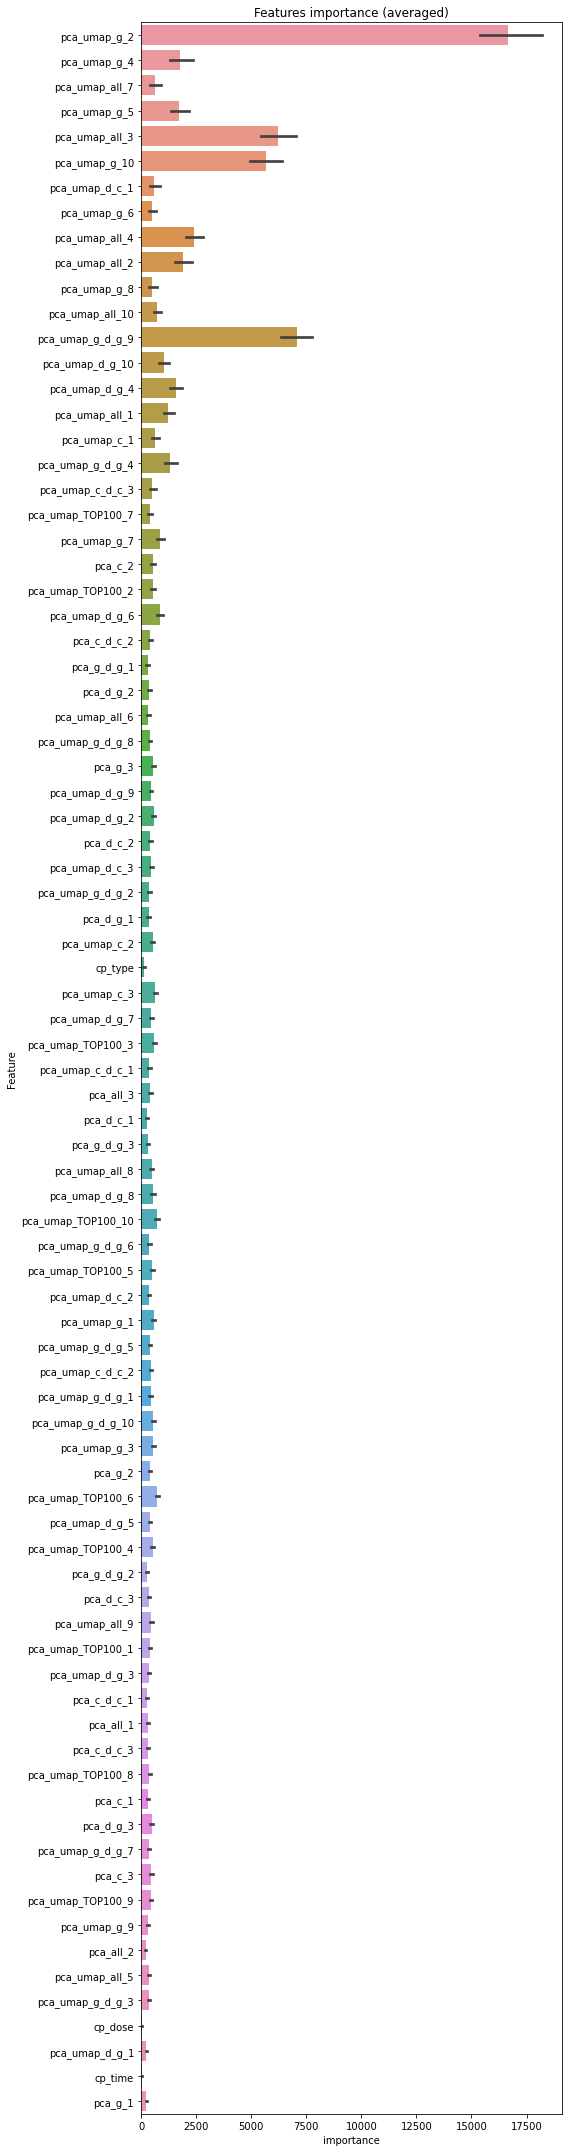

In [53]:
if DEBUG:
    show_feature_importance(feature_importance_df)